<a href="https://colab.research.google.com/github/gkdivya/EVA/blob/main/5_CodingDrillDown/Experiments/MNIST_Exp1_BasicSkeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Target:


Results:


*   Parameters: 
*   Best Train Accuracy: 
*   Best Test Accuracy: 

Analysis:


# Import Libraries

Let's first import all the necessary libraries

In [21]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

## Defining the Model




In [32]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        #Block 1
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, 3,padding=0,bias=False),  # 28x28 output 28x28 RF : 3x3
            nn.ReLU(),

            nn.Conv2d(8, 16, 3,padding=0,bias=False), # 28x28 output 28x28 RF : 5x5
            nn.ReLU(),

            nn.Conv2d(16, 16, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.ReLU(),
        
        )

        #Transition Block (MaxPool + 1x1)
        self.trans1 = nn.Sequential(

            # 1x1 convolution
            nn.Conv2d(16, 8, 1,bias=False), # 26x26 output - 26x26 RF 14x14
            nn.ReLU(),

            nn.MaxPool2d(2, 2),  # 26x26 output - 13x13 RF 14x14

        )

        #Block 2
        self.conv2 =  nn.Sequential(

            nn.Conv2d(8, 16, 3,padding=0, bias=False), # 13x13 output - 11x11 RF 16x16
            nn.ReLU(),

            nn.Conv2d(16, 16, 3,padding=0, bias=False),  # 11x11 output - 9x9 RF 18x18
            nn.ReLU(),

            nn.Conv2d(16, 10, 3,padding=0, bias=False), # 9x9 output - 7x7 RF 20x20
            nn.ReLU(),
        )


        #Block 4 and GAP Layer
        self.avg_pool = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.trans1(x)
        x = self.conv2(x)
        
        x = self.avg_pool(x)
        print(x.shape)
        x = x.view(-1,10)

        return F.log_softmax(x,dim=1)

In [33]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

torch.Size([2, 10, 1, 1])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           1,152
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 16, 22, 22]           2,304
              ReLU-6           [-1, 16, 22, 22]               0
            Conv2d-7            [-1, 8, 22, 22]             128
              ReLU-8            [-1, 8, 22, 22]               0
         MaxPool2d-9            [-1, 8, 11, 11]               0
           Conv2d-10             [-1, 16, 9, 9]           1,152
             ReLU-11             [-1, 16, 9, 9]               0
           Conv2d-12             [-1, 16, 7, 7]           2,304
             ReLU-13             [-1, 16, 7, 7]               0
           Co

## The Model

In [34]:
model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (trans1): Sequential(
    (0): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (3): ReLU()
    (4): Conv2d(16, 10, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (5): ReLU()
  )
  (avg_pool): Sequential(
    (0): AvgPool2d(kernel_size=5, stride=5, padding=0)
  )
)

## Model Parameters

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 8,552 trainable parameters


## Load and Prepare Dataset

MNIST contains 70,000 images of handwritten digits: 60,000 for training and 10,000 for testing. The images are grayscale, 28x28 pixels

We load the PIL images using torchvision.datasets.MNIST, while loading the image we transform he data to tensor and normalize the images with mean and std deviation of MNIST images.

In [36]:
torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))

test = datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ]))
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False, **kwargs)


#Statistics



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:64: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0, dtype=torch.uint8)
 - max: tensor(255, dtype=torch.uint8)
 - mean: 33.318421449829934
 - std: 78.56748998339798
 - var: 6172.850482291342
torch.Size([128, 1, 28, 28])
torch.Size([128])


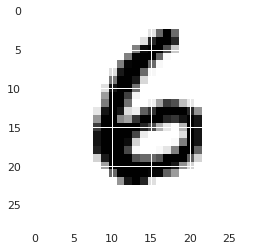

In [37]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
#train_data = train.transform(train_data.cpu().numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', train.train_data.cpu().numpy().mean())
print(' - std:', train.train_data.cpu().numpy().std())
print(' - var:', train.train_data.cpu().numpy().var())

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)



plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

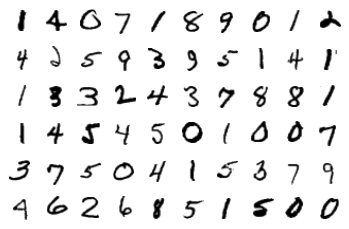

In [38]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Training and Testing Loop

In [39]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    epoch_loss=0
    correct = 0
    pbar = tqdm(train_loader)
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

        pbar.set_description(desc= f'epoch={epoch} Loss={loss.item()} batch_id={batch_idx:05d}')


    train_loss = epoch_loss / len(train_loader.dataset)
    train_acc=100.*correct/len(train_loader.dataset)
    return train_loss,train_acc


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    test_acc=100. * correct / len(test_loader.dataset)
    return test_loss,test_acc

## Let's write train and test the model

In [ ]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.015, momentum=0.9)

train_loss_values = []
test_loss_values = []
train_accuracy=[]
test_accuracy=[]

for epoch in range(1, 15):
    train_loss,train_acc = train(model, device, train_loader, optimizer, epoch)
    test_loss,test_acc = test(model, device, test_loader)

    train_loss_values.append(train_loss)
    test_loss_values.append(test_loss)

    train_accuracy.append(train_acc)
    test_accuracy.append(test_acc)






  0%|          | 0/469 [00:00<?, ?it/s]


epoch=1 Loss=2.3026206493377686 batch_id=00000:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=1 Loss=2.302628517150879 batch_id=00001:   0%|          | 0/469 [00:00<?, ?it/s] 


epoch=1 Loss=2.302628517150879 batch_id=00001:   0%|          | 2/469 [00:00<00:27, 16.91it/s]


epoch=1 Loss=2.30273699760437 batch_id=00002:   0%|          | 2/469 [00:00<00:27, 16.91it/s] 


epoch=1 Loss=2.302572727203369 batch_id=00003:   0%|          | 2/469 [00:00<00:27, 16.91it/s]


epoch=1 Loss=2.302332639694214 batch_id=00004:   0%|          | 2/469 [00:00<00:27, 16.91it/s]


epoch=1 Loss=2.302622079849243 batch_id=00005:   0%|          | 2/469 [00:00<00:27, 16.91it/s]


epoch=1 Loss=2.302622079849243 batch_id=00005:   1%|▏         | 6/469 [00:00<00:22, 20.17it/s]


epoch=1 Loss=2.3023195266723633 batch_id=00006:   1%|▏         | 6/469 [00:00<00:22, 20.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302706003189087 batch_id=00007:   1%|▏         | 6/469 [00:00<00:22, 20.17it/s] 


epoch=1 Loss=2.3023338317871094 batch_id=00008:   1%|▏         | 6/469 [00:00<00:22, 20.17it/s]


epoch=1 Loss=2.3027138710021973 batch_id=00009:   1%|▏         | 6/469 [00:00<00:22, 20.17it/s]


epoch=1 Loss=2.3027138710021973 batch_id=00009:   2%|▏         | 10/469 [00:00<00:20, 22.94it/s]


epoch=1 Loss=2.3026232719421387 batch_id=00010:   2%|▏         | 10/469 [00:00<00:20, 22.94it/s]


epoch=1 Loss=2.3023626804351807 batch_id=00011:   2%|▏         | 10/469 [00:00<00:20, 22.94it/s]


epoch=1 Loss=2.302360773086548 batch_id=00012:   2%|▏         | 10/469 [00:00<00:20, 22.94it/s] 


epoch=1 Loss=2.302523374557495 batch_id=00013:   2%|▏         | 10/469 [00:00<00:20, 22.94it/s]


epoch=1 Loss=2.302523374557495 batch_id=00013:   3%|▎         | 14/469 [00:00<00:17, 25.30it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302802324295044 batch_id=00014:   3%|▎         | 14/469 [00:00<00:17, 25.30it/s]


epoch=1 Loss=2.302614688873291 batch_id=00015:   3%|▎         | 14/469 [00:00<00:17, 25.30it/s]


epoch=1 Loss=2.302597999572754 batch_id=00016:   3%|▎         | 14/469 [00:00<00:17, 25.30it/s]


epoch=1 Loss=2.302511692047119 batch_id=00017:   3%|▎         | 14/469 [00:00<00:17, 25.30it/s]


epoch=1 Loss=2.302511692047119 batch_id=00017:   4%|▍         | 18/469 [00:00<00:16, 26.69it/s]


epoch=1 Loss=2.302494764328003 batch_id=00018:   4%|▍         | 18/469 [00:00<00:16, 26.69it/s]


epoch=1 Loss=2.3026134967803955 batch_id=00019:   4%|▍         | 18/469 [00:00<00:16, 26.69it/s]


epoch=1 Loss=2.302684783935547 batch_id=00020:   4%|▍         | 18/469 [00:00<00:16, 26.69it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302696466445923 batch_id=00021:   4%|▍         | 18/469 [00:00<00:16, 26.69it/s]


epoch=1 Loss=2.302696466445923 batch_id=00021:   5%|▍         | 22/469 [00:00<00:15, 28.17it/s]


epoch=1 Loss=2.3027706146240234 batch_id=00022:   5%|▍         | 22/469 [00:00<00:15, 28.17it/s]


epoch=1 Loss=2.302783727645874 batch_id=00023:   5%|▍         | 22/469 [00:00<00:15, 28.17it/s] 


epoch=1 Loss=2.302881956100464 batch_id=00024:   5%|▍         | 22/469 [00:00<00:15, 28.17it/s]


epoch=1 Loss=2.302881956100464 batch_id=00024:   5%|▌         | 25/469 [00:00<00:16, 26.86it/s]


epoch=1 Loss=2.3027045726776123 batch_id=00025:   5%|▌         | 25/469 [00:00<00:16, 26.86it/s]


epoch=1 Loss=2.3024849891662598 batch_id=00026:   5%|▌         | 25/469 [00:00<00:16, 26.86it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3027119636535645 batch_id=00027:   5%|▌         | 25/469 [00:00<00:16, 26.86it/s]


epoch=1 Loss=2.3027119636535645 batch_id=00027:   6%|▌         | 28/469 [00:00<00:16, 27.42it/s]


epoch=1 Loss=2.302767753601074 batch_id=00028:   6%|▌         | 28/469 [00:00<00:16, 27.42it/s] 


epoch=1 Loss=2.302511692047119 batch_id=00029:   6%|▌         | 28/469 [00:01<00:16, 27.42it/s]


epoch=1 Loss=2.302475690841675 batch_id=00030:   6%|▌         | 28/469 [00:01<00:16, 27.42it/s]


epoch=1 Loss=2.3026926517486572 batch_id=00031:   6%|▌         | 28/469 [00:01<00:16, 27.42it/s]


epoch=1 Loss=2.3026926517486572 batch_id=00031:   7%|▋         | 32/469 [00:01<00:15, 28.51it/s]


epoch=1 Loss=2.302553653717041 batch_id=00032:   7%|▋         | 32/469 [00:01<00:15, 28.51it/s] 


epoch=1 Loss=2.3028464317321777 batch_id=00033:   7%|▋         | 32/469 [00:01<00:15, 28.51it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302555799484253 batch_id=00034:   7%|▋         | 32/469 [00:01<00:15, 28.51it/s] 


epoch=1 Loss=2.30257511138916 batch_id=00035:   7%|▋         | 32/469 [00:01<00:15, 28.51it/s] 


epoch=1 Loss=2.30257511138916 batch_id=00035:   8%|▊         | 36/469 [00:01<00:14, 29.11it/s]


epoch=1 Loss=2.3024661540985107 batch_id=00036:   8%|▊         | 36/469 [00:01<00:14, 29.11it/s]


epoch=1 Loss=2.302598714828491 batch_id=00037:   8%|▊         | 36/469 [00:01<00:14, 29.11it/s] 


epoch=1 Loss=2.3026821613311768 batch_id=00038:   8%|▊         | 36/469 [00:01<00:14, 29.11it/s]


epoch=1 Loss=2.3026821613311768 batch_id=00038:   8%|▊         | 39/469 [00:01<00:14, 29.35it/s]


epoch=1 Loss=2.3022522926330566 batch_id=00039:   8%|▊         | 39/469 [00:01<00:14, 29.35it/s]


epoch=1 Loss=2.3027498722076416 batch_id=00040:   8%|▊         | 39/469 [00:01<00:14, 29.35it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3024466037750244 batch_id=00041:   8%|▊         | 39/469 [00:01<00:14, 29.35it/s]


epoch=1 Loss=2.3024466037750244 batch_id=00041:   9%|▉         | 42/469 [00:01<00:14, 29.53it/s]


epoch=1 Loss=2.302431583404541 batch_id=00042:   9%|▉         | 42/469 [00:01<00:14, 29.53it/s] 


epoch=1 Loss=2.3025760650634766 batch_id=00043:   9%|▉         | 42/469 [00:01<00:14, 29.53it/s]


epoch=1 Loss=2.3025572299957275 batch_id=00044:   9%|▉         | 42/469 [00:01<00:14, 29.53it/s]


epoch=1 Loss=2.3025572299957275 batch_id=00044:  10%|▉         | 45/469 [00:01<00:15, 27.70it/s]


epoch=1 Loss=2.3021762371063232 batch_id=00045:  10%|▉         | 45/469 [00:01<00:15, 27.70it/s]


epoch=1 Loss=2.302685499191284 batch_id=00046:  10%|▉         | 45/469 [00:01<00:15, 27.70it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3023812770843506 batch_id=00047:  10%|▉         | 45/469 [00:01<00:15, 27.70it/s]


epoch=1 Loss=2.3023812770843506 batch_id=00047:  10%|█         | 48/469 [00:01<00:14, 28.31it/s]


epoch=1 Loss=2.3025805950164795 batch_id=00048:  10%|█         | 48/469 [00:01<00:14, 28.31it/s]


epoch=1 Loss=2.30242657661438 batch_id=00049:  10%|█         | 48/469 [00:01<00:14, 28.31it/s]  


epoch=1 Loss=2.302670478820801 batch_id=00050:  10%|█         | 48/469 [00:01<00:14, 28.31it/s]


epoch=1 Loss=2.302539348602295 batch_id=00051:  10%|█         | 48/469 [00:01<00:14, 28.31it/s]


epoch=1 Loss=2.302539348602295 batch_id=00051:  11%|█         | 52/469 [00:01<00:14, 29.24it/s]


epoch=1 Loss=2.3024046421051025 batch_id=00052:  11%|█         | 52/469 [00:01<00:14, 29.24it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302341938018799 batch_id=00053:  11%|█         | 52/469 [00:01<00:14, 29.24it/s] 


epoch=1 Loss=2.3022196292877197 batch_id=00054:  11%|█         | 52/469 [00:01<00:14, 29.24it/s]


epoch=1 Loss=2.3022196292877197 batch_id=00054:  12%|█▏        | 55/469 [00:01<00:14, 28.52it/s]


epoch=1 Loss=2.30257511138916 batch_id=00055:  12%|█▏        | 55/469 [00:01<00:14, 28.52it/s]  


epoch=1 Loss=2.3025729656219482 batch_id=00056:  12%|█▏        | 55/469 [00:01<00:14, 28.52it/s]


epoch=1 Loss=2.302342176437378 batch_id=00057:  12%|█▏        | 55/469 [00:01<00:14, 28.52it/s] 


epoch=1 Loss=2.3022074699401855 batch_id=00058:  12%|█▏        | 55/469 [00:01<00:14, 28.52it/s]


epoch=1 Loss=2.3022074699401855 batch_id=00058:  13%|█▎        | 59/469 [00:01<00:13, 29.76it/s]


epoch=1 Loss=2.3020107746124268 batch_id=00059:  13%|█▎        | 59/469 [00:02<00:13, 29.76it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3024327754974365 batch_id=00060:  13%|█▎        | 59/469 [00:02<00:13, 29.76it/s]


epoch=1 Loss=2.302359104156494 batch_id=00061:  13%|█▎        | 59/469 [00:02<00:13, 29.76it/s] 


epoch=1 Loss=2.302421808242798 batch_id=00062:  13%|█▎        | 59/469 [00:02<00:13, 29.76it/s]


epoch=1 Loss=2.302421808242798 batch_id=00062:  13%|█▎        | 63/469 [00:02<00:13, 29.87it/s]


epoch=1 Loss=2.3026211261749268 batch_id=00063:  13%|█▎        | 63/469 [00:02<00:13, 29.87it/s]


epoch=1 Loss=2.3023221492767334 batch_id=00064:  13%|█▎        | 63/469 [00:02<00:13, 29.87it/s]


epoch=1 Loss=2.302534818649292 batch_id=00065:  13%|█▎        | 63/469 [00:02<00:13, 29.87it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302104949951172 batch_id=00066:  13%|█▎        | 63/469 [00:02<00:13, 29.87it/s]


epoch=1 Loss=2.302104949951172 batch_id=00066:  14%|█▍        | 67/469 [00:02<00:13, 29.62it/s]


epoch=1 Loss=2.3024556636810303 batch_id=00067:  14%|█▍        | 67/469 [00:02<00:13, 29.62it/s]


epoch=1 Loss=2.3024349212646484 batch_id=00068:  14%|█▍        | 67/469 [00:02<00:13, 29.62it/s]


epoch=1 Loss=2.3024017810821533 batch_id=00069:  14%|█▍        | 67/469 [00:02<00:13, 29.62it/s]


epoch=1 Loss=2.3024017810821533 batch_id=00069:  15%|█▍        | 70/469 [00:02<00:13, 29.20it/s]


epoch=1 Loss=2.3023204803466797 batch_id=00070:  15%|█▍        | 70/469 [00:02<00:13, 29.20it/s]


epoch=1 Loss=2.3024680614471436 batch_id=00071:  15%|█▍        | 70/469 [00:02<00:13, 29.20it/s]


epoch=1 Loss=2.3025400638580322 batch_id=00072:  15%|█▍        | 70/469 [00:02<00:13, 29.20it/s]


epoch=1 Loss=2.3025400638580322 batch_id=00072:  16%|█▌        | 73/469 [00:02<00:13, 29.08it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302381992340088 batch_id=00073:  16%|█▌        | 73/469 [00:02<00:13, 29.08it/s] 


epoch=1 Loss=2.302554130554199 batch_id=00074:  16%|█▌        | 73/469 [00:02<00:13, 29.08it/s]


epoch=1 Loss=2.3025341033935547 batch_id=00075:  16%|█▌        | 73/469 [00:02<00:13, 29.08it/s]


epoch=1 Loss=2.301927089691162 batch_id=00076:  16%|█▌        | 73/469 [00:02<00:13, 29.08it/s] 


epoch=1 Loss=2.301927089691162 batch_id=00076:  16%|█▋        | 77/469 [00:02<00:13, 29.51it/s]


epoch=1 Loss=2.3022382259368896 batch_id=00077:  16%|█▋        | 77/469 [00:02<00:13, 29.51it/s]


epoch=1 Loss=2.3025317192077637 batch_id=00078:  16%|█▋        | 77/469 [00:02<00:13, 29.51it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=1 Loss=2.3021738529205322 batch_id=00079:  16%|█▋        | 77/469 [00:02<00:13, 29.51it/s]


epoch=1 Loss=2.3021738529205322 batch_id=00079:  17%|█▋        | 80/469 [00:02<00:13, 28.92it/s]


epoch=1 Loss=2.3024423122406006 batch_id=00080:  17%|█▋        | 80/469 [00:02<00:13, 28.92it/s]


epoch=1 Loss=2.302042007446289 batch_id=00081:  17%|█▋        | 80/469 [00:02<00:13, 28.92it/s] 


epoch=1 Loss=2.3023858070373535 batch_id=00082:  17%|█▋        | 80/469 [00:02<00:13, 28.92it/s]


epoch=1 Loss=2.3023858070373535 batch_id=00082:  18%|█▊        | 83/469 [00:02<00:13, 28.99it/s]


epoch=1 Loss=2.3024609088897705 batch_id=00083:  18%|█▊        | 83/469 [00:02<00:13, 28.99it/s]


epoch=1 Loss=2.302398920059204 batch_id=00084:  18%|█▊        | 83/469 [00:02<00:13, 28.99it/s] 


epoch=1 Loss=2.302384853363037 batch_id=00085:  18%|█▊        | 83/469 [00:02<00:13, 28.99it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302337169647217 batch_id=00086:  18%|█▊        | 83/469 [00:02<00:13, 28.99it/s]


epoch=1 Loss=2.302337169647217 batch_id=00086:  19%|█▊        | 87/469 [00:02<00:12, 29.69it/s]


epoch=1 Loss=2.3022518157958984 batch_id=00087:  19%|█▊        | 87/469 [00:02<00:12, 29.69it/s]


epoch=1 Loss=2.3027184009552 batch_id=00088:  19%|█▊        | 87/469 [00:03<00:12, 29.69it/s]   


epoch=1 Loss=2.3023457527160645 batch_id=00089:  19%|█▊        | 87/469 [00:03<00:12, 29.69it/s]


epoch=1 Loss=2.3023457527160645 batch_id=00089:  19%|█▉        | 90/469 [00:03<00:13, 28.84it/s]


epoch=1 Loss=2.3022429943084717 batch_id=00090:  19%|█▉        | 90/469 [00:03<00:13, 28.84it/s]


epoch=1 Loss=2.3021340370178223 batch_id=00091:  19%|█▉        | 90/469 [00:03<00:13, 28.84it/s]


epoch=1 Loss=2.3021304607391357 batch_id=00092:  19%|█▉        | 90/469 [00:03<00:13, 28.84it/s]


epoch=1 Loss=2.3021304607391357 batch_id=00092:  20%|█▉        | 93/469 [00:03<00:13, 27.74it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302114486694336 batch_id=00093:  20%|█▉        | 93/469 [00:03<00:13, 27.74it/s] 


epoch=1 Loss=2.3027429580688477 batch_id=00094:  20%|█▉        | 93/469 [00:03<00:13, 27.74it/s]


epoch=1 Loss=2.3022799491882324 batch_id=00095:  20%|█▉        | 93/469 [00:03<00:13, 27.74it/s]


epoch=1 Loss=2.3022799491882324 batch_id=00095:  20%|██        | 96/469 [00:03<00:13, 28.12it/s]


epoch=1 Loss=2.302354097366333 batch_id=00096:  20%|██        | 96/469 [00:03<00:13, 28.12it/s] 


epoch=1 Loss=2.302516222000122 batch_id=00097:  20%|██        | 96/469 [00:03<00:13, 28.12it/s]


epoch=1 Loss=2.302657127380371 batch_id=00098:  20%|██        | 96/469 [00:03<00:13, 28.12it/s]


epoch=1 Loss=2.301947832107544 batch_id=00099:  20%|██        | 96/469 [00:03<00:13, 28.12it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.301947832107544 batch_id=00099:  21%|██▏       | 100/469 [00:03<00:13, 28.25it/s]


epoch=1 Loss=2.3024113178253174 batch_id=00100:  21%|██▏       | 100/469 [00:03<00:13, 28.25it/s]


epoch=1 Loss=2.3026342391967773 batch_id=00101:  21%|██▏       | 100/469 [00:03<00:13, 28.25it/s]


epoch=1 Loss=2.302621364593506 batch_id=00102:  21%|██▏       | 100/469 [00:03<00:13, 28.25it/s] 


epoch=1 Loss=2.302621364593506 batch_id=00102:  22%|██▏       | 103/469 [00:03<00:13, 27.83it/s]


epoch=1 Loss=2.3020665645599365 batch_id=00103:  22%|██▏       | 103/469 [00:03<00:13, 27.83it/s]


epoch=1 Loss=2.302692174911499 batch_id=00104:  22%|██▏       | 103/469 [00:03<00:13, 27.83it/s] 


epoch=1 Loss=2.3024022579193115 batch_id=00105:  22%|██▏       | 103/469 [00:03<00:13, 27.83it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=1 Loss=2.302373170852661 batch_id=00106:  22%|██▏       | 103/469 [00:03<00:13, 27.83it/s] 


epoch=1 Loss=2.302373170852661 batch_id=00106:  23%|██▎       | 107/469 [00:03<00:12, 29.06it/s]


epoch=1 Loss=2.3022308349609375 batch_id=00107:  23%|██▎       | 107/469 [00:03<00:12, 29.06it/s]


epoch=1 Loss=2.3025684356689453 batch_id=00108:  23%|██▎       | 107/469 [00:03<00:12, 29.06it/s]


epoch=1 Loss=2.3020451068878174 batch_id=00109:  23%|██▎       | 107/469 [00:03<00:12, 29.06it/s]


epoch=1 Loss=2.3020451068878174 batch_id=00109:  23%|██▎       | 110/469 [00:03<00:12, 28.95it/s]


epoch=1 Loss=2.302504539489746 batch_id=00110:  23%|██▎       | 110/469 [00:03<00:12, 28.95it/s] 


epoch=1 Loss=2.302495241165161 batch_id=00111:  23%|██▎       | 110/469 [00:03<00:12, 28.95it/s]


epoch=1 Loss=2.3021905422210693 batch_id=00112:  23%|██▎       | 110/469 [00:03<00:12, 28.95it/s]


epoch=1 Loss=2.3021905422210693 batch_id=00112:  24%|██▍       | 113/469 [00:03<00:12, 28.33it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3024234771728516 batch_id=00113:  24%|██▍       | 113/469 [00:03<00:12, 28.33it/s]


epoch=1 Loss=2.302824020385742 batch_id=00114:  24%|██▍       | 113/469 [00:03<00:12, 28.33it/s] 


epoch=1 Loss=2.3025364875793457 batch_id=00115:  24%|██▍       | 113/469 [00:03<00:12, 28.33it/s]


epoch=1 Loss=2.3025364875793457 batch_id=00115:  25%|██▍       | 116/469 [00:03<00:12, 27.58it/s]


epoch=1 Loss=2.3020551204681396 batch_id=00116:  25%|██▍       | 116/469 [00:04<00:12, 27.58it/s]


epoch=1 Loss=2.301952362060547 batch_id=00117:  25%|██▍       | 116/469 [00:04<00:12, 27.58it/s] 


epoch=1 Loss=2.302173614501953 batch_id=00118:  25%|██▍       | 116/469 [00:04<00:12, 27.58it/s]


epoch=1 Loss=2.3022820949554443 batch_id=00119:  25%|██▍       | 116/469 [00:04<00:12, 27.58it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=1 Loss=2.3022820949554443 batch_id=00119:  26%|██▌       | 120/469 [00:04<00:12, 29.06it/s]


epoch=1 Loss=2.301906108856201 batch_id=00120:  26%|██▌       | 120/469 [00:04<00:12, 29.06it/s] 


epoch=1 Loss=2.3023884296417236 batch_id=00121:  26%|██▌       | 120/469 [00:04<00:12, 29.06it/s]


epoch=1 Loss=2.3024051189422607 batch_id=00122:  26%|██▌       | 120/469 [00:04<00:12, 29.06it/s]


epoch=1 Loss=2.3024051189422607 batch_id=00122:  26%|██▌       | 123/469 [00:04<00:12, 28.78it/s]


epoch=1 Loss=2.301732301712036 batch_id=00123:  26%|██▌       | 123/469 [00:04<00:12, 28.78it/s] 


epoch=1 Loss=2.302136182785034 batch_id=00124:  26%|██▌       | 123/469 [00:04<00:12, 28.78it/s]


epoch=1 Loss=2.3020355701446533 batch_id=00125:  26%|██▌       | 123/469 [00:04<00:12, 28.78it/s]


epoch=1 Loss=2.3020355701446533 batch_id=00125:  27%|██▋       | 126/469 [00:04<00:11, 29.02it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3022947311401367 batch_id=00126:  27%|██▋       | 126/469 [00:04<00:11, 29.02it/s]


epoch=1 Loss=2.302462577819824 batch_id=00127:  27%|██▋       | 126/469 [00:04<00:11, 29.02it/s] 


epoch=1 Loss=2.3023242950439453 batch_id=00128:  27%|██▋       | 126/469 [00:04<00:11, 29.02it/s]


epoch=1 Loss=2.3023242950439453 batch_id=00128:  28%|██▊       | 129/469 [00:04<00:11, 28.73it/s]


epoch=1 Loss=2.3019466400146484 batch_id=00129:  28%|██▊       | 129/469 [00:04<00:11, 28.73it/s]


epoch=1 Loss=2.302614450454712 batch_id=00130:  28%|██▊       | 129/469 [00:04<00:11, 28.73it/s] 


epoch=1 Loss=2.30230712890625 batch_id=00131:  28%|██▊       | 129/469 [00:04<00:11, 28.73it/s] 


epoch=1 Loss=2.30230712890625 batch_id=00131:  28%|██▊       | 132/469 [00:04<00:12, 27.29it/s]


epoch=1 Loss=2.301663875579834 batch_id=00132:  28%|██▊       | 132/469 [00:04<00:12, 27.29it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302553653717041 batch_id=00133:  28%|██▊       | 132/469 [00:04<00:12, 27.29it/s]


epoch=1 Loss=2.3021528720855713 batch_id=00134:  28%|██▊       | 132/469 [00:04<00:12, 27.29it/s]


epoch=1 Loss=2.3013784885406494 batch_id=00135:  28%|██▊       | 132/469 [00:04<00:12, 27.29it/s]


epoch=1 Loss=2.3013784885406494 batch_id=00135:  29%|██▉       | 136/469 [00:04<00:12, 27.58it/s]


epoch=1 Loss=2.302208423614502 batch_id=00136:  29%|██▉       | 136/469 [00:04<00:12, 27.58it/s] 


epoch=1 Loss=2.3018856048583984 batch_id=00137:  29%|██▉       | 136/469 [00:04<00:12, 27.58it/s]


epoch=1 Loss=2.3022656440734863 batch_id=00138:  29%|██▉       | 136/469 [00:04<00:12, 27.58it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302558422088623 batch_id=00139:  29%|██▉       | 136/469 [00:04<00:12, 27.58it/s] 


epoch=1 Loss=2.302558422088623 batch_id=00139:  30%|██▉       | 140/469 [00:04<00:11, 27.94it/s]


epoch=1 Loss=2.302067518234253 batch_id=00140:  30%|██▉       | 140/469 [00:04<00:11, 27.94it/s]


epoch=1 Loss=2.3017172813415527 batch_id=00141:  30%|██▉       | 140/469 [00:04<00:11, 27.94it/s]


epoch=1 Loss=2.302216053009033 batch_id=00142:  30%|██▉       | 140/469 [00:04<00:11, 27.94it/s] 


epoch=1 Loss=2.302216053009033 batch_id=00142:  30%|███       | 143/469 [00:04<00:11, 28.18it/s]


epoch=1 Loss=2.3020360469818115 batch_id=00143:  30%|███       | 143/469 [00:04<00:11, 28.18it/s]


epoch=1 Loss=2.3027191162109375 batch_id=00144:  30%|███       | 143/469 [00:04<00:11, 28.18it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3017759323120117 batch_id=00145:  30%|███       | 143/469 [00:05<00:11, 28.18it/s]


epoch=1 Loss=2.3017759323120117 batch_id=00145:  31%|███       | 146/469 [00:05<00:11, 28.03it/s]


epoch=1 Loss=2.302090644836426 batch_id=00146:  31%|███       | 146/469 [00:05<00:11, 28.03it/s] 


epoch=1 Loss=2.302438497543335 batch_id=00147:  31%|███       | 146/469 [00:05<00:11, 28.03it/s]


epoch=1 Loss=2.3031156063079834 batch_id=00148:  31%|███       | 146/469 [00:05<00:11, 28.03it/s]


epoch=1 Loss=2.3014514446258545 batch_id=00149:  31%|███       | 146/469 [00:05<00:11, 28.03it/s]


epoch=1 Loss=2.3014514446258545 batch_id=00149:  32%|███▏      | 150/469 [00:05<00:11, 28.66it/s]


epoch=1 Loss=2.3021469116210938 batch_id=00150:  32%|███▏      | 150/469 [00:05<00:11, 28.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302786111831665 batch_id=00151:  32%|███▏      | 150/469 [00:05<00:11, 28.66it/s] 


epoch=1 Loss=2.302881956100464 batch_id=00152:  32%|███▏      | 150/469 [00:05<00:11, 28.66it/s]


epoch=1 Loss=2.302881956100464 batch_id=00152:  33%|███▎      | 153/469 [00:05<00:11, 28.14it/s]


epoch=1 Loss=2.302466630935669 batch_id=00153:  33%|███▎      | 153/469 [00:05<00:11, 28.14it/s]


epoch=1 Loss=2.3022804260253906 batch_id=00154:  33%|███▎      | 153/469 [00:05<00:11, 28.14it/s]


epoch=1 Loss=2.302032709121704 batch_id=00155:  33%|███▎      | 153/469 [00:05<00:11, 28.14it/s] 


epoch=1 Loss=2.302032709121704 batch_id=00155:  33%|███▎      | 156/469 [00:05<00:11, 28.27it/s]


epoch=1 Loss=2.30206036567688 batch_id=00156:  33%|███▎      | 156/469 [00:05<00:11, 28.27it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.301659107208252 batch_id=00157:  33%|███▎      | 156/469 [00:05<00:11, 28.27it/s]


epoch=1 Loss=2.301863431930542 batch_id=00158:  33%|███▎      | 156/469 [00:05<00:11, 28.27it/s]


epoch=1 Loss=2.301652193069458 batch_id=00159:  33%|███▎      | 156/469 [00:05<00:11, 28.27it/s]


epoch=1 Loss=2.301652193069458 batch_id=00159:  34%|███▍      | 160/469 [00:05<00:10, 29.01it/s]


epoch=1 Loss=2.3022844791412354 batch_id=00160:  34%|███▍      | 160/469 [00:05<00:10, 29.01it/s]


epoch=1 Loss=2.3019680976867676 batch_id=00161:  34%|███▍      | 160/469 [00:05<00:10, 29.01it/s]


epoch=1 Loss=2.302513360977173 batch_id=00162:  34%|███▍      | 160/469 [00:05<00:10, 29.01it/s] 


epoch=1 Loss=2.302513360977173 batch_id=00162:  35%|███▍      | 163/469 [00:05<00:10, 28.32it/s]


epoch=1 Loss=2.3020310401916504 batch_id=00163:  35%|███▍      | 163/469 [00:05<00:10, 28.32it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3018150329589844 batch_id=00164:  35%|███▍      | 163/469 [00:05<00:10, 28.32it/s]


epoch=1 Loss=2.30253005027771 batch_id=00165:  35%|███▍      | 163/469 [00:05<00:10, 28.32it/s]  


epoch=1 Loss=2.3020479679107666 batch_id=00166:  35%|███▍      | 163/469 [00:05<00:10, 28.32it/s]


epoch=1 Loss=2.3020479679107666 batch_id=00166:  36%|███▌      | 167/469 [00:05<00:10, 28.96it/s]


epoch=1 Loss=2.3030786514282227 batch_id=00167:  36%|███▌      | 167/469 [00:05<00:10, 28.96it/s]


epoch=1 Loss=2.3017728328704834 batch_id=00168:  36%|███▌      | 167/469 [00:05<00:10, 28.96it/s]


epoch=1 Loss=2.301971435546875 batch_id=00169:  36%|███▌      | 167/469 [00:05<00:10, 28.96it/s] 


epoch=1 Loss=2.301971435546875 batch_id=00169:  36%|███▌      | 170/469 [00:05<00:11, 27.17it/s]


epoch=1 Loss=2.302262783050537 batch_id=00170:  36%|███▌      | 170/469 [00:05<00:11, 27.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.302564859390259 batch_id=00171:  36%|███▌      | 170/469 [00:05<00:11, 27.17it/s]


epoch=1 Loss=2.3019039630889893 batch_id=00172:  36%|███▌      | 170/469 [00:05<00:11, 27.17it/s]


epoch=1 Loss=2.3017992973327637 batch_id=00173:  36%|███▌      | 170/469 [00:05<00:11, 27.17it/s]


epoch=1 Loss=2.3017992973327637 batch_id=00173:  37%|███▋      | 174/469 [00:06<00:10, 28.41it/s]


epoch=1 Loss=2.3018476963043213 batch_id=00174:  37%|███▋      | 174/469 [00:06<00:10, 28.41it/s]


epoch=1 Loss=2.302290916442871 batch_id=00175:  37%|███▋      | 174/469 [00:06<00:10, 28.41it/s] 


epoch=1 Loss=2.3026535511016846 batch_id=00176:  37%|███▋      | 174/469 [00:06<00:10, 28.41it/s]


epoch=1 Loss=2.3026535511016846 batch_id=00176:  38%|███▊      | 177/469 [00:06<00:10, 28.06it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3018393516540527 batch_id=00177:  38%|███▊      | 177/469 [00:06<00:10, 28.06it/s]


epoch=1 Loss=2.3023602962493896 batch_id=00178:  38%|███▊      | 177/469 [00:06<00:10, 28.06it/s]


epoch=1 Loss=2.302264451980591 batch_id=00179:  38%|███▊      | 177/469 [00:06<00:10, 28.06it/s] 


epoch=1 Loss=2.302264451980591 batch_id=00179:  38%|███▊      | 180/469 [00:06<00:10, 27.80it/s]


epoch=1 Loss=2.3012492656707764 batch_id=00180:  38%|███▊      | 180/469 [00:06<00:10, 27.80it/s]


epoch=1 Loss=2.3024652004241943 batch_id=00181:  38%|███▊      | 180/469 [00:06<00:10, 27.80it/s]


epoch=1 Loss=2.301953077316284 batch_id=00182:  38%|███▊      | 180/469 [00:06<00:10, 27.80it/s] 


epoch=1 Loss=2.301953077316284 batch_id=00182:  39%|███▉      | 183/469 [00:06<00:10, 28.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3018198013305664 batch_id=00183:  39%|███▉      | 183/469 [00:06<00:10, 28.31it/s]


epoch=1 Loss=2.302565336227417 batch_id=00184:  39%|███▉      | 183/469 [00:06<00:10, 28.31it/s] 


epoch=1 Loss=2.3022031784057617 batch_id=00185:  39%|███▉      | 183/469 [00:06<00:10, 28.31it/s]


epoch=1 Loss=2.3022031784057617 batch_id=00185:  40%|███▉      | 186/469 [00:06<00:09, 28.69it/s]


epoch=1 Loss=2.301241397857666 batch_id=00186:  40%|███▉      | 186/469 [00:06<00:09, 28.69it/s] 


epoch=1 Loss=2.3023884296417236 batch_id=00187:  40%|███▉      | 186/469 [00:06<00:09, 28.69it/s]


epoch=1 Loss=2.3023571968078613 batch_id=00188:  40%|███▉      | 186/469 [00:06<00:09, 28.69it/s]


epoch=1 Loss=2.3023571968078613 batch_id=00188:  40%|████      | 189/469 [00:06<00:09, 28.53it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.301754951477051 batch_id=00189:  40%|████      | 189/469 [00:06<00:09, 28.53it/s] 


epoch=1 Loss=2.3014159202575684 batch_id=00190:  40%|████      | 189/469 [00:06<00:09, 28.53it/s]


epoch=1 Loss=2.3017659187316895 batch_id=00191:  40%|████      | 189/469 [00:06<00:09, 28.53it/s]


epoch=1 Loss=2.3017659187316895 batch_id=00191:  41%|████      | 192/469 [00:06<00:10, 27.49it/s]


epoch=1 Loss=2.3022022247314453 batch_id=00192:  41%|████      | 192/469 [00:06<00:10, 27.49it/s]


epoch=1 Loss=2.301645517349243 batch_id=00193:  41%|████      | 192/469 [00:06<00:10, 27.49it/s] 


epoch=1 Loss=2.3022820949554443 batch_id=00194:  41%|████      | 192/469 [00:06<00:10, 27.49it/s]


epoch=1 Loss=2.3022820949554443 batch_id=00194:  42%|████▏     | 195/469 [00:06<00:09, 28.13it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3020944595336914 batch_id=00195:  42%|████▏     | 195/469 [00:06<00:09, 28.13it/s]


epoch=1 Loss=2.301772117614746 batch_id=00196:  42%|████▏     | 195/469 [00:06<00:09, 28.13it/s] 


epoch=1 Loss=2.301506996154785 batch_id=00197:  42%|████▏     | 195/469 [00:06<00:09, 28.13it/s]


epoch=1 Loss=2.301506996154785 batch_id=00197:  42%|████▏     | 198/469 [00:06<00:10, 26.52it/s]


epoch=1 Loss=2.302225112915039 batch_id=00198:  42%|████▏     | 198/469 [00:06<00:10, 26.52it/s]


epoch=1 Loss=2.3018062114715576 batch_id=00199:  42%|████▏     | 198/469 [00:06<00:10, 26.52it/s]


epoch=1 Loss=2.3015758991241455 batch_id=00200:  42%|████▏     | 198/469 [00:06<00:10, 26.52it/s]


epoch=1 Loss=2.3015758991241455 batch_id=00200:  43%|████▎     | 201/469 [00:06<00:09, 26.99it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3016374111175537 batch_id=00201:  43%|████▎     | 201/469 [00:07<00:09, 26.99it/s]


epoch=1 Loss=2.3015308380126953 batch_id=00202:  43%|████▎     | 201/469 [00:07<00:09, 26.99it/s]


epoch=1 Loss=2.3020081520080566 batch_id=00203:  43%|████▎     | 201/469 [00:07<00:09, 26.99it/s]


epoch=1 Loss=2.3020081520080566 batch_id=00203:  43%|████▎     | 204/469 [00:07<00:09, 27.12it/s]


epoch=1 Loss=2.302090644836426 batch_id=00204:  43%|████▎     | 204/469 [00:07<00:09, 27.12it/s] 


epoch=1 Loss=2.301626205444336 batch_id=00205:  43%|████▎     | 204/469 [00:07<00:09, 27.12it/s]


epoch=1 Loss=2.301825523376465 batch_id=00206:  43%|████▎     | 204/469 [00:07<00:09, 27.12it/s]


epoch=1 Loss=2.301825523376465 batch_id=00206:  44%|████▍     | 207/469 [00:07<00:09, 27.27it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3014039993286133 batch_id=00207:  44%|████▍     | 207/469 [00:07<00:09, 27.27it/s]


epoch=1 Loss=2.3002238273620605 batch_id=00208:  44%|████▍     | 207/469 [00:07<00:09, 27.27it/s]


epoch=1 Loss=2.3012025356292725 batch_id=00209:  44%|████▍     | 207/469 [00:07<00:09, 27.27it/s]


epoch=1 Loss=2.3012025356292725 batch_id=00209:  45%|████▍     | 210/469 [00:07<00:09, 27.49it/s]


epoch=1 Loss=2.300978660583496 batch_id=00210:  45%|████▍     | 210/469 [00:07<00:09, 27.49it/s] 


epoch=1 Loss=2.302441358566284 batch_id=00211:  45%|████▍     | 210/469 [00:07<00:09, 27.49it/s]


epoch=1 Loss=2.3018617630004883 batch_id=00212:  45%|████▍     | 210/469 [00:07<00:09, 27.49it/s]


epoch=1 Loss=2.3018617630004883 batch_id=00212:  45%|████▌     | 213/469 [00:07<00:09, 27.61it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3020501136779785 batch_id=00213:  45%|████▌     | 213/469 [00:07<00:09, 27.61it/s]


epoch=1 Loss=2.3012750148773193 batch_id=00214:  45%|████▌     | 213/469 [00:07<00:09, 27.61it/s]


epoch=1 Loss=2.301494598388672 batch_id=00215:  45%|████▌     | 213/469 [00:07<00:09, 27.61it/s] 


epoch=1 Loss=2.301494598388672 batch_id=00215:  46%|████▌     | 216/469 [00:07<00:09, 26.62it/s]


epoch=1 Loss=2.301523447036743 batch_id=00216:  46%|████▌     | 216/469 [00:07<00:09, 26.62it/s]


epoch=1 Loss=2.3016746044158936 batch_id=00217:  46%|████▌     | 216/469 [00:07<00:09, 26.62it/s]


epoch=1 Loss=2.3007845878601074 batch_id=00218:  46%|████▌     | 216/469 [00:07<00:09, 26.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3018975257873535 batch_id=00219:  46%|████▌     | 216/469 [00:07<00:09, 26.62it/s]


epoch=1 Loss=2.3018975257873535 batch_id=00219:  47%|████▋     | 220/469 [00:07<00:09, 27.15it/s]


epoch=1 Loss=2.3020148277282715 batch_id=00220:  47%|████▋     | 220/469 [00:07<00:09, 27.15it/s]


epoch=1 Loss=2.302537441253662 batch_id=00221:  47%|████▋     | 220/469 [00:07<00:09, 27.15it/s] 


epoch=1 Loss=2.30165958404541 batch_id=00222:  47%|████▋     | 220/469 [00:07<00:09, 27.15it/s] 


epoch=1 Loss=2.30165958404541 batch_id=00222:  48%|████▊     | 223/469 [00:07<00:09, 27.31it/s]


epoch=1 Loss=2.301722764968872 batch_id=00223:  48%|████▊     | 223/469 [00:07<00:09, 27.31it/s]


epoch=1 Loss=2.3011844158172607 batch_id=00224:  48%|████▊     | 223/469 [00:07<00:09, 27.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3026609420776367 batch_id=00225:  48%|████▊     | 223/469 [00:07<00:09, 27.31it/s]


epoch=1 Loss=2.3026609420776367 batch_id=00225:  48%|████▊     | 226/469 [00:07<00:09, 26.25it/s]


epoch=1 Loss=2.3023202419281006 batch_id=00226:  48%|████▊     | 226/469 [00:07<00:09, 26.25it/s]


epoch=1 Loss=2.302884817123413 batch_id=00227:  48%|████▊     | 226/469 [00:07<00:09, 26.25it/s] 


epoch=1 Loss=2.302130937576294 batch_id=00228:  48%|████▊     | 226/469 [00:08<00:09, 26.25it/s]


epoch=1 Loss=2.302130937576294 batch_id=00228:  49%|████▉     | 229/469 [00:08<00:09, 26.50it/s]


epoch=1 Loss=2.30198335647583 batch_id=00229:  49%|████▉     | 229/469 [00:08<00:09, 26.50it/s] 


epoch=1 Loss=2.302616834640503 batch_id=00230:  49%|████▉     | 229/469 [00:08<00:09, 26.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3013272285461426 batch_id=00231:  49%|████▉     | 229/469 [00:08<00:09, 26.50it/s]


epoch=1 Loss=2.3013272285461426 batch_id=00231:  49%|████▉     | 232/469 [00:08<00:08, 27.08it/s]


epoch=1 Loss=2.302316904067993 batch_id=00232:  49%|████▉     | 232/469 [00:08<00:08, 27.08it/s] 


epoch=1 Loss=2.301299810409546 batch_id=00233:  49%|████▉     | 232/469 [00:08<00:08, 27.08it/s]


epoch=1 Loss=2.302668571472168 batch_id=00234:  49%|████▉     | 232/469 [00:08<00:08, 27.08it/s]


epoch=1 Loss=2.302668571472168 batch_id=00234:  50%|█████     | 235/469 [00:08<00:08, 27.78it/s]


epoch=1 Loss=2.3019325733184814 batch_id=00235:  50%|█████     | 235/469 [00:08<00:08, 27.78it/s]


epoch=1 Loss=2.302093982696533 batch_id=00236:  50%|█████     | 235/469 [00:08<00:08, 27.78it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3012256622314453 batch_id=00237:  50%|█████     | 235/469 [00:08<00:08, 27.78it/s]


epoch=1 Loss=2.3012256622314453 batch_id=00237:  51%|█████     | 238/469 [00:08<00:08, 27.94it/s]


epoch=1 Loss=2.3023366928100586 batch_id=00238:  51%|█████     | 238/469 [00:08<00:08, 27.94it/s]


epoch=1 Loss=2.3015098571777344 batch_id=00239:  51%|█████     | 238/469 [00:08<00:08, 27.94it/s]


epoch=1 Loss=2.3015832901000977 batch_id=00240:  51%|█████     | 238/469 [00:08<00:08, 27.94it/s]


epoch=1 Loss=2.3015832901000977 batch_id=00240:  51%|█████▏    | 241/469 [00:08<00:08, 27.82it/s]


epoch=1 Loss=2.3017032146453857 batch_id=00241:  51%|█████▏    | 241/469 [00:08<00:08, 27.82it/s]


epoch=1 Loss=2.300234079360962 batch_id=00242:  51%|█████▏    | 241/469 [00:08<00:08, 27.82it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.301264524459839 batch_id=00243:  51%|█████▏    | 241/469 [00:08<00:08, 27.82it/s]


epoch=1 Loss=2.301264524459839 batch_id=00243:  52%|█████▏    | 244/469 [00:08<00:08, 27.47it/s]


epoch=1 Loss=2.3019003868103027 batch_id=00244:  52%|█████▏    | 244/469 [00:08<00:08, 27.47it/s]


epoch=1 Loss=2.3033511638641357 batch_id=00245:  52%|█████▏    | 244/469 [00:08<00:08, 27.47it/s]


epoch=1 Loss=2.3025333881378174 batch_id=00246:  52%|█████▏    | 244/469 [00:08<00:08, 27.47it/s]


epoch=1 Loss=2.3025333881378174 batch_id=00246:  53%|█████▎    | 247/469 [00:08<00:07, 27.85it/s]


epoch=1 Loss=2.30102801322937 batch_id=00247:  53%|█████▎    | 247/469 [00:08<00:07, 27.85it/s]  


epoch=1 Loss=2.300856590270996 batch_id=00248:  53%|█████▎    | 247/469 [00:08<00:07, 27.85it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3017287254333496 batch_id=00249:  53%|█████▎    | 247/469 [00:08<00:07, 27.85it/s]


epoch=1 Loss=2.3017287254333496 batch_id=00249:  53%|█████▎    | 250/469 [00:08<00:08, 27.21it/s]


epoch=1 Loss=2.301755905151367 batch_id=00250:  53%|█████▎    | 250/469 [00:08<00:08, 27.21it/s] 


epoch=1 Loss=2.302232027053833 batch_id=00251:  53%|█████▎    | 250/469 [00:08<00:08, 27.21it/s]


epoch=1 Loss=2.300659418106079 batch_id=00252:  53%|█████▎    | 250/469 [00:08<00:08, 27.21it/s]


epoch=1 Loss=2.300659418106079 batch_id=00252:  54%|█████▍    | 253/469 [00:08<00:08, 26.74it/s]


epoch=1 Loss=2.2990124225616455 batch_id=00253:  54%|█████▍    | 253/469 [00:08<00:08, 26.74it/s]


epoch=1 Loss=2.300907850265503 batch_id=00254:  54%|█████▍    | 253/469 [00:08<00:08, 26.74it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3014957904815674 batch_id=00255:  54%|█████▍    | 253/469 [00:08<00:08, 26.74it/s]


epoch=1 Loss=2.3014957904815674 batch_id=00255:  55%|█████▍    | 256/469 [00:09<00:07, 26.88it/s]


epoch=1 Loss=2.300211191177368 batch_id=00256:  55%|█████▍    | 256/469 [00:09<00:07, 26.88it/s] 


epoch=1 Loss=2.30245304107666 batch_id=00257:  55%|█████▍    | 256/469 [00:09<00:07, 26.88it/s] 


epoch=1 Loss=2.301474094390869 batch_id=00258:  55%|█████▍    | 256/469 [00:09<00:07, 26.88it/s]


epoch=1 Loss=2.301474094390869 batch_id=00258:  55%|█████▌    | 259/469 [00:09<00:08, 25.89it/s]


epoch=1 Loss=2.3007543087005615 batch_id=00259:  55%|█████▌    | 259/469 [00:09<00:08, 25.89it/s]


epoch=1 Loss=2.303126335144043 batch_id=00260:  55%|█████▌    | 259/469 [00:09<00:08, 25.89it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2971138954162598 batch_id=00261:  55%|█████▌    | 259/469 [00:09<00:08, 25.89it/s]


epoch=1 Loss=2.300309658050537 batch_id=00262:  55%|█████▌    | 259/469 [00:09<00:08, 25.89it/s] 


epoch=1 Loss=2.300309658050537 batch_id=00262:  56%|█████▌    | 263/469 [00:09<00:07, 27.42it/s]


epoch=1 Loss=2.2999355792999268 batch_id=00263:  56%|█████▌    | 263/469 [00:09<00:07, 27.42it/s]


epoch=1 Loss=2.299574613571167 batch_id=00264:  56%|█████▌    | 263/469 [00:09<00:07, 27.42it/s] 


epoch=1 Loss=2.2984678745269775 batch_id=00265:  56%|█████▌    | 263/469 [00:09<00:07, 27.42it/s]


epoch=1 Loss=2.2984678745269775 batch_id=00265:  57%|█████▋    | 266/469 [00:09<00:07, 26.45it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])




epoch=1 Loss=2.3010544776916504 batch_id=00266:  57%|█████▋    | 266/469 [00:09<00:07, 26.45it/s]


epoch=1 Loss=2.300471305847168 batch_id=00267:  57%|█████▋    | 266/469 [00:09<00:07, 26.45it/s] 


epoch=1 Loss=2.3003172874450684 batch_id=00268:  57%|█████▋    | 266/469 [00:09<00:07, 26.45it/s]


epoch=1 Loss=2.3003172874450684 batch_id=00268:  57%|█████▋    | 269/469 [00:09<00:07, 26.53it/s]


epoch=1 Loss=2.302769660949707 batch_id=00269:  57%|█████▋    | 269/469 [00:09<00:07, 26.53it/s] 


epoch=1 Loss=2.299131393432617 batch_id=00270:  57%|█████▋    | 269/469 [00:09<00:07, 26.53it/s]


epoch=1 Loss=2.3007938861846924 batch_id=00271:  57%|█████▋    | 269/469 [00:09<00:07, 26.53it/s]


epoch=1 Loss=2.3007938861846924 batch_id=00271:  58%|█████▊    | 272/469 [00:09<00:07, 26.55it/s]


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.30226731300354 batch_id=00272:  58%|█████▊    | 272/469 [00:09<00:07, 26.55it/s]  


epoch=1 Loss=2.300476312637329 batch_id=00273:  58%|█████▊    | 272/469 [00:09<00:07, 26.55it/s]


epoch=1 Loss=2.30009126663208 batch_id=00274:  58%|█████▊    | 272/469 [00:09<00:07, 26.55it/s] 


epoch=1 Loss=2.30009126663208 batch_id=00274:  59%|█████▊    | 275/469 [00:09<00:07, 26.63it/s]


epoch=1 Loss=2.3026576042175293 batch_id=00275:  59%|█████▊    | 275/469 [00:09<00:07, 26.63it/s]


epoch=1 Loss=2.3006279468536377 batch_id=00276:  59%|█████▊    | 275/469 [00:09<00:07, 26.63it/s]


epoch=1 Loss=2.302109956741333 batch_id=00277:  59%|█████▊    | 275/469 [00:09<00:07, 26.63it/s] 


epoch=1 Loss=2.302109956741333 batch_id=00277:  59%|█████▉    | 278/469 [00:09<00:07, 26.54it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3017868995666504 batch_id=00278:  59%|█████▉    | 278/469 [00:09<00:07, 26.54it/s]


epoch=1 Loss=2.301595687866211 batch_id=00279:  59%|█████▉    | 278/469 [00:09<00:07, 26.54it/s] 


epoch=1 Loss=2.298914909362793 batch_id=00280:  59%|█████▉    | 278/469 [00:09<00:07, 26.54it/s]


epoch=1 Loss=2.298914909362793 batch_id=00280:  60%|█████▉    | 281/469 [00:09<00:07, 26.37it/s]


epoch=1 Loss=2.3007967472076416 batch_id=00281:  60%|█████▉    | 281/469 [00:09<00:07, 26.37it/s]


epoch=1 Loss=2.3010289669036865 batch_id=00282:  60%|█████▉    | 281/469 [00:10<00:07, 26.37it/s]


epoch=1 Loss=2.3025712966918945 batch_id=00283:  60%|█████▉    | 281/469 [00:10<00:07, 26.37it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.3025712966918945 batch_id=00283:  61%|██████    | 284/469 [00:10<00:07, 25.62it/s]


epoch=1 Loss=2.296682596206665 batch_id=00284:  61%|██████    | 284/469 [00:10<00:07, 25.62it/s] 


epoch=1 Loss=2.301023006439209 batch_id=00285:  61%|██████    | 284/469 [00:10<00:07, 25.62it/s]


epoch=1 Loss=2.2993123531341553 batch_id=00286:  61%|██████    | 284/469 [00:10<00:07, 25.62it/s]


epoch=1 Loss=2.2993123531341553 batch_id=00286:  61%|██████    | 287/469 [00:10<00:07, 25.94it/s]


epoch=1 Loss=2.30287504196167 batch_id=00287:  61%|██████    | 287/469 [00:10<00:07, 25.94it/s]  


epoch=1 Loss=2.3014955520629883 batch_id=00288:  61%|██████    | 287/469 [00:10<00:07, 25.94it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=1 Loss=2.3015899658203125 batch_id=00289:  61%|██████    | 287/469 [00:10<00:07, 25.94it/s]


epoch=1 Loss=2.3015899658203125 batch_id=00289:  62%|██████▏   | 290/469 [00:10<00:07, 25.50it/s]


epoch=1 Loss=2.298936367034912 batch_id=00290:  62%|██████▏   | 290/469 [00:10<00:07, 25.50it/s] 


epoch=1 Loss=2.2986512184143066 batch_id=00291:  62%|██████▏   | 290/469 [00:10<00:07, 25.50it/s]


epoch=1 Loss=2.298652172088623 batch_id=00292:  62%|██████▏   | 290/469 [00:10<00:07, 25.50it/s] 


epoch=1 Loss=2.298652172088623 batch_id=00292:  62%|██████▏   | 293/469 [00:10<00:06, 26.04it/s]


epoch=1 Loss=2.2971980571746826 batch_id=00293:  62%|██████▏   | 293/469 [00:10<00:06, 26.04it/s]


epoch=1 Loss=2.2992541790008545 batch_id=00294:  62%|██████▏   | 293/469 [00:10<00:06, 26.04it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.294924736022949 batch_id=00295:  62%|██████▏   | 293/469 [00:10<00:06, 26.04it/s] 


epoch=1 Loss=2.294924736022949 batch_id=00295:  63%|██████▎   | 296/469 [00:10<00:06, 25.44it/s]


epoch=1 Loss=2.302590847015381 batch_id=00296:  63%|██████▎   | 296/469 [00:10<00:06, 25.44it/s]


epoch=1 Loss=2.299863338470459 batch_id=00297:  63%|██████▎   | 296/469 [00:10<00:06, 25.44it/s]


epoch=1 Loss=2.299914598464966 batch_id=00298:  63%|██████▎   | 296/469 [00:10<00:06, 25.44it/s]


epoch=1 Loss=2.299914598464966 batch_id=00298:  64%|██████▍   | 299/469 [00:10<00:06, 25.66it/s]


epoch=1 Loss=2.299560070037842 batch_id=00299:  64%|██████▍   | 299/469 [00:10<00:06, 25.66it/s]


epoch=1 Loss=2.3018808364868164 batch_id=00300:  64%|██████▍   | 299/469 [00:10<00:06, 25.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2956082820892334 batch_id=00301:  64%|██████▍   | 299/469 [00:10<00:06, 25.66it/s]


epoch=1 Loss=2.2956082820892334 batch_id=00301:  64%|██████▍   | 302/469 [00:10<00:06, 25.33it/s]


epoch=1 Loss=2.298401355743408 batch_id=00302:  64%|██████▍   | 302/469 [00:10<00:06, 25.33it/s] 


epoch=1 Loss=2.2989583015441895 batch_id=00303:  64%|██████▍   | 302/469 [00:10<00:06, 25.33it/s]


epoch=1 Loss=2.2990543842315674 batch_id=00304:  64%|██████▍   | 302/469 [00:10<00:06, 25.33it/s]


epoch=1 Loss=2.2990543842315674 batch_id=00304:  65%|██████▌   | 305/469 [00:10<00:06, 25.58it/s]


epoch=1 Loss=2.2938003540039062 batch_id=00305:  65%|██████▌   | 305/469 [00:10<00:06, 25.58it/s]


epoch=1 Loss=2.296588659286499 batch_id=00306:  65%|██████▌   | 305/469 [00:10<00:06, 25.58it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.299345016479492 batch_id=00307:  65%|██████▌   | 305/469 [00:10<00:06, 25.58it/s]


epoch=1 Loss=2.299345016479492 batch_id=00307:  66%|██████▌   | 308/469 [00:11<00:06, 26.14it/s]


epoch=1 Loss=2.2936131954193115 batch_id=00308:  66%|██████▌   | 308/469 [00:11<00:06, 26.14it/s]


epoch=1 Loss=2.289771556854248 batch_id=00309:  66%|██████▌   | 308/469 [00:11<00:06, 26.14it/s] 


epoch=1 Loss=2.288593053817749 batch_id=00310:  66%|██████▌   | 308/469 [00:11<00:06, 26.14it/s]


epoch=1 Loss=2.288593053817749 batch_id=00310:  66%|██████▋   | 311/469 [00:11<00:06, 26.20it/s]


epoch=1 Loss=2.2960312366485596 batch_id=00311:  66%|██████▋   | 311/469 [00:11<00:06, 26.20it/s]


epoch=1 Loss=2.293107748031616 batch_id=00312:  66%|██████▋   | 311/469 [00:11<00:06, 26.20it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.300267219543457 batch_id=00313:  66%|██████▋   | 311/469 [00:11<00:06, 26.20it/s]


epoch=1 Loss=2.300267219543457 batch_id=00313:  67%|██████▋   | 314/469 [00:11<00:05, 26.75it/s]


epoch=1 Loss=2.2970504760742188 batch_id=00314:  67%|██████▋   | 314/469 [00:11<00:05, 26.75it/s]


epoch=1 Loss=2.3113224506378174 batch_id=00315:  67%|██████▋   | 314/469 [00:11<00:05, 26.75it/s]


epoch=1 Loss=2.2960941791534424 batch_id=00316:  67%|██████▋   | 314/469 [00:11<00:05, 26.75it/s]


epoch=1 Loss=2.2960941791534424 batch_id=00316:  68%|██████▊   | 317/469 [00:11<00:05, 26.02it/s]


epoch=1 Loss=2.2936153411865234 batch_id=00317:  68%|██████▊   | 317/469 [00:11<00:05, 26.02it/s]


epoch=1 Loss=2.303516149520874 batch_id=00318:  68%|██████▊   | 317/469 [00:11<00:05, 26.02it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2925636768341064 batch_id=00319:  68%|██████▊   | 317/469 [00:11<00:05, 26.02it/s]


epoch=1 Loss=2.2925636768341064 batch_id=00319:  68%|██████▊   | 320/469 [00:11<00:05, 26.70it/s]


epoch=1 Loss=2.302330732345581 batch_id=00320:  68%|██████▊   | 320/469 [00:11<00:05, 26.70it/s] 


epoch=1 Loss=2.3036749362945557 batch_id=00321:  68%|██████▊   | 320/469 [00:11<00:05, 26.70it/s]


epoch=1 Loss=2.299484968185425 batch_id=00322:  68%|██████▊   | 320/469 [00:11<00:05, 26.70it/s] 


epoch=1 Loss=2.299484968185425 batch_id=00322:  69%|██████▉   | 323/469 [00:11<00:05, 26.79it/s]


epoch=1 Loss=2.2873313426971436 batch_id=00323:  69%|██████▉   | 323/469 [00:11<00:05, 26.79it/s]


epoch=1 Loss=2.2962169647216797 batch_id=00324:  69%|██████▉   | 323/469 [00:11<00:05, 26.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2964859008789062 batch_id=00325:  69%|██████▉   | 323/469 [00:11<00:05, 26.79it/s]


epoch=1 Loss=2.2964859008789062 batch_id=00325:  70%|██████▉   | 326/469 [00:11<00:05, 26.06it/s]


epoch=1 Loss=2.293937921524048 batch_id=00326:  70%|██████▉   | 326/469 [00:11<00:05, 26.06it/s] 


epoch=1 Loss=2.293581962585449 batch_id=00327:  70%|██████▉   | 326/469 [00:11<00:05, 26.06it/s]


epoch=1 Loss=2.2993154525756836 batch_id=00328:  70%|██████▉   | 326/469 [00:11<00:05, 26.06it/s]


epoch=1 Loss=2.3026270866394043 batch_id=00329:  70%|██████▉   | 326/469 [00:11<00:05, 26.06it/s]


epoch=1 Loss=2.3026270866394043 batch_id=00329:  70%|███████   | 330/469 [00:11<00:05, 27.50it/s]


epoch=1 Loss=2.2963685989379883 batch_id=00330:  70%|███████   | 330/469 [00:11<00:05, 27.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2916250228881836 batch_id=00331:  70%|███████   | 330/469 [00:11<00:05, 27.50it/s]


epoch=1 Loss=2.3040101528167725 batch_id=00332:  70%|███████   | 330/469 [00:11<00:05, 27.50it/s]


epoch=1 Loss=2.3040101528167725 batch_id=00332:  71%|███████   | 333/469 [00:11<00:04, 27.24it/s]


epoch=1 Loss=2.2844667434692383 batch_id=00333:  71%|███████   | 333/469 [00:11<00:04, 27.24it/s]


epoch=1 Loss=2.2783102989196777 batch_id=00334:  71%|███████   | 333/469 [00:11<00:04, 27.24it/s]


epoch=1 Loss=2.303340435028076 batch_id=00335:  71%|███████   | 333/469 [00:12<00:04, 27.24it/s] 


epoch=1 Loss=2.303340435028076 batch_id=00335:  72%|███████▏  | 336/469 [00:12<00:04, 27.34it/s]


epoch=1 Loss=2.294057607650757 batch_id=00336:  72%|███████▏  | 336/469 [00:12<00:04, 27.34it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2992067337036133 batch_id=00337:  72%|███████▏  | 336/469 [00:12<00:04, 27.34it/s]


epoch=1 Loss=2.2976131439208984 batch_id=00338:  72%|███████▏  | 336/469 [00:12<00:04, 27.34it/s]


epoch=1 Loss=2.2976131439208984 batch_id=00338:  72%|███████▏  | 339/469 [00:12<00:04, 26.85it/s]


epoch=1 Loss=2.284609317779541 batch_id=00339:  72%|███████▏  | 339/469 [00:12<00:04, 26.85it/s] 


epoch=1 Loss=2.2974650859832764 batch_id=00340:  72%|███████▏  | 339/469 [00:12<00:04, 26.85it/s]


epoch=1 Loss=2.2967448234558105 batch_id=00341:  72%|███████▏  | 339/469 [00:12<00:04, 26.85it/s]


epoch=1 Loss=2.2967448234558105 batch_id=00341:  73%|███████▎  | 342/469 [00:12<00:04, 27.62it/s]


epoch=1 Loss=2.2918295860290527 batch_id=00342:  73%|███████▎  | 342/469 [00:12<00:04, 27.62it/s]


epoch=1 Loss=2.282227039337158 batch_id=00343:  73%|███████▎  | 342/469 [00:12<00:04, 27.62it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2774651050567627 batch_id=00344:  73%|███████▎  | 342/469 [00:12<00:04, 27.62it/s]


epoch=1 Loss=2.2774651050567627 batch_id=00344:  74%|███████▎  | 345/469 [00:12<00:04, 28.27it/s]


epoch=1 Loss=2.2953684329986572 batch_id=00345:  74%|███████▎  | 345/469 [00:12<00:04, 28.27it/s]


epoch=1 Loss=2.292041063308716 batch_id=00346:  74%|███████▎  | 345/469 [00:12<00:04, 28.27it/s] 


epoch=1 Loss=2.289566993713379 batch_id=00347:  74%|███████▎  | 345/469 [00:12<00:04, 28.27it/s]


epoch=1 Loss=2.289566993713379 batch_id=00347:  74%|███████▍  | 348/469 [00:12<00:04, 27.84it/s]


epoch=1 Loss=2.2853856086730957 batch_id=00348:  74%|███████▍  | 348/469 [00:12<00:04, 27.84it/s]


epoch=1 Loss=2.28232479095459 batch_id=00349:  74%|███████▍  | 348/469 [00:12<00:04, 27.84it/s]  

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2948198318481445 batch_id=00350:  74%|███████▍  | 348/469 [00:12<00:04, 27.84it/s]


epoch=1 Loss=2.2948198318481445 batch_id=00350:  75%|███████▍  | 351/469 [00:12<00:04, 27.02it/s]


epoch=1 Loss=2.290523052215576 batch_id=00351:  75%|███████▍  | 351/469 [00:12<00:04, 27.02it/s] 


epoch=1 Loss=2.2687880992889404 batch_id=00352:  75%|███████▍  | 351/469 [00:12<00:04, 27.02it/s]


epoch=1 Loss=2.2862393856048584 batch_id=00353:  75%|███████▍  | 351/469 [00:12<00:04, 27.02it/s]


epoch=1 Loss=2.2862393856048584 batch_id=00353:  75%|███████▌  | 354/469 [00:12<00:04, 27.80it/s]


epoch=1 Loss=2.290848731994629 batch_id=00354:  75%|███████▌  | 354/469 [00:12<00:04, 27.80it/s] 


epoch=1 Loss=2.296231269836426 batch_id=00355:  75%|███████▌  | 354/469 [00:12<00:04, 27.80it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2892067432403564 batch_id=00356:  75%|███████▌  | 354/469 [00:12<00:04, 27.80it/s]


epoch=1 Loss=2.2892067432403564 batch_id=00356:  76%|███████▌  | 357/469 [00:12<00:04, 27.51it/s]


epoch=1 Loss=2.287403106689453 batch_id=00357:  76%|███████▌  | 357/469 [00:12<00:04, 27.51it/s] 


epoch=1 Loss=2.260596990585327 batch_id=00358:  76%|███████▌  | 357/469 [00:12<00:04, 27.51it/s]


epoch=1 Loss=2.275571584701538 batch_id=00359:  76%|███████▌  | 357/469 [00:12<00:04, 27.51it/s]


epoch=1 Loss=2.275571584701538 batch_id=00359:  77%|███████▋  | 360/469 [00:12<00:04, 27.20it/s]


epoch=1 Loss=2.2600865364074707 batch_id=00360:  77%|███████▋  | 360/469 [00:12<00:04, 27.20it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2765860557556152 batch_id=00361:  77%|███████▋  | 360/469 [00:12<00:04, 27.20it/s]


epoch=1 Loss=2.2662012577056885 batch_id=00362:  77%|███████▋  | 360/469 [00:13<00:04, 27.20it/s]


epoch=1 Loss=2.2662012577056885 batch_id=00362:  77%|███████▋  | 363/469 [00:13<00:04, 26.14it/s]


epoch=1 Loss=2.262208938598633 batch_id=00363:  77%|███████▋  | 363/469 [00:13<00:04, 26.14it/s] 


epoch=1 Loss=2.265005588531494 batch_id=00364:  77%|███████▋  | 363/469 [00:13<00:04, 26.14it/s]


epoch=1 Loss=2.2583343982696533 batch_id=00365:  77%|███████▋  | 363/469 [00:13<00:04, 26.14it/s]


epoch=1 Loss=2.267601490020752 batch_id=00366:  77%|███████▋  | 363/469 [00:13<00:04, 26.14it/s] 


epoch=1 Loss=2.267601490020752 batch_id=00366:  78%|███████▊  | 367/469 [00:13<00:03, 27.66it/s]


epoch=1 Loss=2.3035528659820557 batch_id=00367:  78%|███████▊  | 367/469 [00:13<00:03, 27.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2463841438293457 batch_id=00368:  78%|███████▊  | 367/469 [00:13<00:03, 27.66it/s]


epoch=1 Loss=2.240170955657959 batch_id=00369:  78%|███████▊  | 367/469 [00:13<00:03, 27.66it/s] 


epoch=1 Loss=2.240170955657959 batch_id=00369:  79%|███████▉  | 370/469 [00:13<00:03, 26.83it/s]


epoch=1 Loss=2.277462959289551 batch_id=00370:  79%|███████▉  | 370/469 [00:13<00:03, 26.83it/s]


epoch=1 Loss=2.2530252933502197 batch_id=00371:  79%|███████▉  | 370/469 [00:13<00:03, 26.83it/s]


epoch=1 Loss=2.232710123062134 batch_id=00372:  79%|███████▉  | 370/469 [00:13<00:03, 26.83it/s] 


epoch=1 Loss=2.2518985271453857 batch_id=00373:  79%|███████▉  | 370/469 [00:13<00:03, 26.83it/s]


epoch=1 Loss=2.2518985271453857 batch_id=00373:  80%|███████▉  | 374/469 [00:13<00:03, 27.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.219886064529419 batch_id=00374:  80%|███████▉  | 374/469 [00:13<00:03, 27.66it/s] 


epoch=1 Loss=2.2226932048797607 batch_id=00375:  80%|███████▉  | 374/469 [00:13<00:03, 27.66it/s]


epoch=1 Loss=2.173506021499634 batch_id=00376:  80%|███████▉  | 374/469 [00:13<00:03, 27.66it/s] 


epoch=1 Loss=2.173506021499634 batch_id=00376:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]


epoch=1 Loss=2.236612319946289 batch_id=00377:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]


epoch=1 Loss=2.217311382293701 batch_id=00378:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]


epoch=1 Loss=2.262291193008423 batch_id=00379:  80%|████████  | 377/469 [00:13<00:03, 28.12it/s]


epoch=1 Loss=2.262291193008423 batch_id=00379:  81%|████████  | 380/469 [00:13<00:03, 27.38it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.2119030952453613 batch_id=00380:  81%|████████  | 380/469 [00:13<00:03, 27.38it/s]


epoch=1 Loss=2.190075635910034 batch_id=00381:  81%|████████  | 380/469 [00:13<00:03, 27.38it/s] 


epoch=1 Loss=2.237002372741699 batch_id=00382:  81%|████████  | 380/469 [00:13<00:03, 27.38it/s]


epoch=1 Loss=2.237002372741699 batch_id=00382:  82%|████████▏ | 383/469 [00:13<00:03, 27.07it/s]


epoch=1 Loss=2.2578351497650146 batch_id=00383:  82%|████████▏ | 383/469 [00:13<00:03, 27.07it/s]


epoch=1 Loss=2.1194515228271484 batch_id=00384:  82%|████████▏ | 383/469 [00:13<00:03, 27.07it/s]


epoch=1 Loss=2.186870574951172 batch_id=00385:  82%|████████▏ | 383/469 [00:13<00:03, 27.07it/s] 


epoch=1 Loss=2.186870574951172 batch_id=00385:  82%|████████▏ | 386/469 [00:13<00:03, 26.93it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=2.138411521911621 batch_id=00386:  82%|████████▏ | 386/469 [00:13<00:03, 26.93it/s]


epoch=1 Loss=2.1505966186523438 batch_id=00387:  82%|████████▏ | 386/469 [00:13<00:03, 26.93it/s]


epoch=1 Loss=2.082801103591919 batch_id=00388:  82%|████████▏ | 386/469 [00:13<00:03, 26.93it/s] 


epoch=1 Loss=2.082801103591919 batch_id=00388:  83%|████████▎ | 389/469 [00:13<00:02, 27.15it/s]


epoch=1 Loss=2.040571928024292 batch_id=00389:  83%|████████▎ | 389/469 [00:14<00:02, 27.15it/s]


epoch=1 Loss=2.0414161682128906 batch_id=00390:  83%|████████▎ | 389/469 [00:14<00:02, 27.15it/s]


epoch=1 Loss=1.9660074710845947 batch_id=00391:  83%|████████▎ | 389/469 [00:14<00:02, 27.15it/s]


epoch=1 Loss=1.9660074710845947 batch_id=00391:  84%|████████▎ | 392/469 [00:14<00:02, 27.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.951015591621399 batch_id=00392:  84%|████████▎ | 392/469 [00:14<00:02, 27.17it/s] 


epoch=1 Loss=2.0217208862304688 batch_id=00393:  84%|████████▎ | 392/469 [00:14<00:02, 27.17it/s]


epoch=1 Loss=1.9860385656356812 batch_id=00394:  84%|████████▎ | 392/469 [00:14<00:02, 27.17it/s]


epoch=1 Loss=1.9860385656356812 batch_id=00394:  84%|████████▍ | 395/469 [00:14<00:02, 26.09it/s]


epoch=1 Loss=1.906097650527954 batch_id=00395:  84%|████████▍ | 395/469 [00:14<00:02, 26.09it/s] 


epoch=1 Loss=1.9143966436386108 batch_id=00396:  84%|████████▍ | 395/469 [00:14<00:02, 26.09it/s]


epoch=1 Loss=1.8082889318466187 batch_id=00397:  84%|████████▍ | 395/469 [00:14<00:02, 26.09it/s]


epoch=1 Loss=1.8082889318466187 batch_id=00397:  85%|████████▍ | 398/469 [00:14<00:02, 26.76it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.767789602279663 batch_id=00398:  85%|████████▍ | 398/469 [00:14<00:02, 26.76it/s] 


epoch=1 Loss=1.7457340955734253 batch_id=00399:  85%|████████▍ | 398/469 [00:14<00:02, 26.76it/s]


epoch=1 Loss=1.7871029376983643 batch_id=00400:  85%|████████▍ | 398/469 [00:14<00:02, 26.76it/s]


epoch=1 Loss=1.9837052822113037 batch_id=00401:  85%|████████▍ | 398/469 [00:14<00:02, 26.76it/s]


epoch=1 Loss=1.9837052822113037 batch_id=00401:  86%|████████▌ | 402/469 [00:14<00:02, 27.67it/s]


epoch=1 Loss=2.0678648948669434 batch_id=00402:  86%|████████▌ | 402/469 [00:14<00:02, 27.67it/s]


epoch=1 Loss=1.7180233001708984 batch_id=00403:  86%|████████▌ | 402/469 [00:14<00:02, 27.67it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.870696783065796 batch_id=00404:  86%|████████▌ | 402/469 [00:14<00:02, 27.67it/s] 


epoch=1 Loss=1.870696783065796 batch_id=00404:  86%|████████▋ | 405/469 [00:14<00:02, 27.07it/s]


epoch=1 Loss=1.9363373517990112 batch_id=00405:  86%|████████▋ | 405/469 [00:14<00:02, 27.07it/s]


epoch=1 Loss=2.1184563636779785 batch_id=00406:  86%|████████▋ | 405/469 [00:14<00:02, 27.07it/s]


epoch=1 Loss=1.9172943830490112 batch_id=00407:  86%|████████▋ | 405/469 [00:14<00:02, 27.07it/s]


epoch=1 Loss=1.894752025604248 batch_id=00408:  86%|████████▋ | 405/469 [00:14<00:02, 27.07it/s] 


epoch=1 Loss=1.894752025604248 batch_id=00408:  87%|████████▋ | 409/469 [00:14<00:02, 28.10it/s]


epoch=1 Loss=2.017169237136841 batch_id=00409:  87%|████████▋ | 409/469 [00:14<00:02, 28.10it/s]


epoch=1 Loss=1.9696674346923828 batch_id=00410:  87%|████████▋ | 409/469 [00:14<00:02, 28.10it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.901496171951294 batch_id=00411:  87%|████████▋ | 409/469 [00:14<00:02, 28.10it/s] 


epoch=1 Loss=1.901496171951294 batch_id=00411:  88%|████████▊ | 412/469 [00:14<00:02, 26.50it/s]


epoch=1 Loss=1.896689772605896 batch_id=00412:  88%|████████▊ | 412/469 [00:14<00:02, 26.50it/s]


epoch=1 Loss=1.8056739568710327 batch_id=00413:  88%|████████▊ | 412/469 [00:14<00:02, 26.50it/s]


epoch=1 Loss=1.804839849472046 batch_id=00414:  88%|████████▊ | 412/469 [00:14<00:02, 26.50it/s] 


epoch=1 Loss=1.8837916851043701 batch_id=00415:  88%|████████▊ | 412/469 [00:14<00:02, 26.50it/s]


epoch=1 Loss=1.8837916851043701 batch_id=00415:  89%|████████▊ | 416/469 [00:14<00:01, 27.88it/s]


epoch=1 Loss=1.8138452768325806 batch_id=00416:  89%|████████▊ | 416/469 [00:14<00:01, 27.88it/s]


epoch=1 Loss=1.780915379524231 batch_id=00417:  89%|████████▊ | 416/469 [00:15<00:01, 27.88it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.7712974548339844 batch_id=00418:  89%|████████▊ | 416/469 [00:15<00:01, 27.88it/s]


epoch=1 Loss=1.7712974548339844 batch_id=00418:  89%|████████▉ | 419/469 [00:15<00:01, 27.04it/s]


epoch=1 Loss=1.9076459407806396 batch_id=00419:  89%|████████▉ | 419/469 [00:15<00:01, 27.04it/s]


epoch=1 Loss=1.7317602634429932 batch_id=00420:  89%|████████▉ | 419/469 [00:15<00:01, 27.04it/s]


epoch=1 Loss=1.8227161169052124 batch_id=00421:  89%|████████▉ | 419/469 [00:15<00:01, 27.04it/s]


epoch=1 Loss=1.8227161169052124 batch_id=00421:  90%|████████▉ | 422/469 [00:15<00:01, 26.40it/s]


epoch=1 Loss=1.8631948232650757 batch_id=00422:  90%|████████▉ | 422/469 [00:15<00:01, 26.40it/s]


epoch=1 Loss=1.756856918334961 batch_id=00423:  90%|████████▉ | 422/469 [00:15<00:01, 26.40it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.8118364810943604 batch_id=00424:  90%|████████▉ | 422/469 [00:15<00:01, 26.40it/s]


epoch=1 Loss=1.8118364810943604 batch_id=00424:  91%|█████████ | 425/469 [00:15<00:01, 26.76it/s]


epoch=1 Loss=1.9606270790100098 batch_id=00425:  91%|█████████ | 425/469 [00:15<00:01, 26.76it/s]


epoch=1 Loss=1.7596694231033325 batch_id=00426:  91%|█████████ | 425/469 [00:15<00:01, 26.76it/s]


epoch=1 Loss=1.7636398077011108 batch_id=00427:  91%|█████████ | 425/469 [00:15<00:01, 26.76it/s]


epoch=1 Loss=1.7636398077011108 batch_id=00427:  91%|█████████▏| 428/469 [00:15<00:01, 27.29it/s]


epoch=1 Loss=1.7714085578918457 batch_id=00428:  91%|█████████▏| 428/469 [00:15<00:01, 27.29it/s]


epoch=1 Loss=1.941190481185913 batch_id=00429:  91%|█████████▏| 428/469 [00:15<00:01, 27.29it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.670192003250122 batch_id=00430:  91%|█████████▏| 428/469 [00:15<00:01, 27.29it/s]


epoch=1 Loss=1.670192003250122 batch_id=00430:  92%|█████████▏| 431/469 [00:15<00:01, 26.35it/s]


epoch=1 Loss=1.6983237266540527 batch_id=00431:  92%|█████████▏| 431/469 [00:15<00:01, 26.35it/s]


epoch=1 Loss=1.9251247644424438 batch_id=00432:  92%|█████████▏| 431/469 [00:15<00:01, 26.35it/s]


epoch=1 Loss=1.8280293941497803 batch_id=00433:  92%|█████████▏| 431/469 [00:15<00:01, 26.35it/s]


epoch=1 Loss=1.8280293941497803 batch_id=00433:  93%|█████████▎| 434/469 [00:15<00:01, 25.29it/s]


epoch=1 Loss=1.7644394636154175 batch_id=00434:  93%|█████████▎| 434/469 [00:15<00:01, 25.29it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.617016315460205 batch_id=00435:  93%|█████████▎| 434/469 [00:15<00:01, 25.29it/s] 


epoch=1 Loss=1.8713836669921875 batch_id=00436:  93%|█████████▎| 434/469 [00:15<00:01, 25.29it/s]


epoch=1 Loss=1.8713836669921875 batch_id=00436:  93%|█████████▎| 437/469 [00:15<00:01, 25.35it/s]


epoch=1 Loss=1.8817862272262573 batch_id=00437:  93%|█████████▎| 437/469 [00:15<00:01, 25.35it/s]


epoch=1 Loss=1.661035418510437 batch_id=00438:  93%|█████████▎| 437/469 [00:15<00:01, 25.35it/s] 


epoch=1 Loss=1.590688705444336 batch_id=00439:  93%|█████████▎| 437/469 [00:15<00:01, 25.35it/s]


epoch=1 Loss=1.590688705444336 batch_id=00439:  94%|█████████▍| 440/469 [00:15<00:01, 24.72it/s]


epoch=1 Loss=1.6816376447677612 batch_id=00440:  94%|█████████▍| 440/469 [00:15<00:01, 24.72it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.5987932682037354 batch_id=00441:  94%|█████████▍| 440/469 [00:15<00:01, 24.72it/s]


epoch=1 Loss=1.539812445640564 batch_id=00442:  94%|█████████▍| 440/469 [00:15<00:01, 24.72it/s] 


epoch=1 Loss=1.539812445640564 batch_id=00442:  94%|█████████▍| 443/469 [00:15<00:01, 25.96it/s]


epoch=1 Loss=1.8010531663894653 batch_id=00443:  94%|█████████▍| 443/469 [00:16<00:01, 25.96it/s]


epoch=1 Loss=1.686586618423462 batch_id=00444:  94%|█████████▍| 443/469 [00:16<00:01, 25.96it/s] 


epoch=1 Loss=1.910517930984497 batch_id=00445:  94%|█████████▍| 443/469 [00:16<00:01, 25.96it/s]


epoch=1 Loss=1.910517930984497 batch_id=00445:  95%|█████████▌| 446/469 [00:16<00:00, 25.39it/s]


epoch=1 Loss=1.7442419528961182 batch_id=00446:  95%|█████████▌| 446/469 [00:16<00:00, 25.39it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.784856915473938 batch_id=00447:  95%|█████████▌| 446/469 [00:16<00:00, 25.39it/s] 


epoch=1 Loss=1.6205313205718994 batch_id=00448:  95%|█████████▌| 446/469 [00:16<00:00, 25.39it/s]


epoch=1 Loss=1.6947886943817139 batch_id=00449:  95%|█████████▌| 446/469 [00:16<00:00, 25.39it/s]


epoch=1 Loss=1.6947886943817139 batch_id=00449:  96%|█████████▌| 450/469 [00:16<00:00, 26.42it/s]


epoch=1 Loss=1.6042908430099487 batch_id=00450:  96%|█████████▌| 450/469 [00:16<00:00, 26.42it/s]


epoch=1 Loss=1.5337398052215576 batch_id=00451:  96%|█████████▌| 450/469 [00:16<00:00, 26.42it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=1 Loss=1.6266424655914307 batch_id=00452:  96%|█████████▌| 450/469 [00:16<00:00, 26.42it/s]


epoch=1 Loss=1.6266424655914307 batch_id=00452:  97%|█████████▋| 453/469 [00:16<00:00, 24.55it/s]


epoch=1 Loss=1.6808912754058838 batch_id=00453:  97%|█████████▋| 453/469 [00:16<00:00, 24.55it/s]


epoch=1 Loss=1.7748079299926758 batch_id=00454:  97%|█████████▋| 453/469 [00:16<00:00, 24.55it/s]


epoch=1 Loss=1.786084532737732 batch_id=00455:  97%|█████████▋| 453/469 [00:16<00:00, 24.55it/s] 


epoch=1 Loss=1.694031834602356 batch_id=00456:  97%|█████████▋| 453/469 [00:16<00:00, 24.55it/s]


epoch=1 Loss=1.694031834602356 batch_id=00456:  97%|█████████▋| 457/469 [00:16<00:00, 25.49it/s]


epoch=1 Loss=1.7014588117599487 batch_id=00457:  97%|█████████▋| 457/469 [00:16<00:00, 25.49it/s]


epoch=1 Loss=1.5585737228393555 batch_id=00458:  97%|█████████▋| 457/469 [00:16<00:00, 25.49it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.687975525856018 batch_id=00459:  97%|█████████▋| 457/469 [00:16<00:00, 25.49it/s] 


epoch=1 Loss=1.687975525856018 batch_id=00459:  98%|█████████▊| 460/469 [00:16<00:00, 25.81it/s]


epoch=1 Loss=1.665557622909546 batch_id=00460:  98%|█████████▊| 460/469 [00:16<00:00, 25.81it/s]


epoch=1 Loss=1.8666460514068604 batch_id=00461:  98%|█████████▊| 460/469 [00:16<00:00, 25.81it/s]


epoch=1 Loss=1.6270147562026978 batch_id=00462:  98%|█████████▊| 460/469 [00:16<00:00, 25.81it/s]


epoch=1 Loss=1.6270147562026978 batch_id=00462:  99%|█████████▊| 463/469 [00:16<00:00, 26.69it/s]


epoch=1 Loss=1.5422254800796509 batch_id=00463:  99%|█████████▊| 463/469 [00:16<00:00, 26.69it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=1 Loss=1.8309839963912964 batch_id=00464:  99%|█████████▊| 463/469 [00:16<00:00, 26.69it/s]


epoch=1 Loss=1.7507416009902954 batch_id=00465:  99%|█████████▊| 463/469 [00:16<00:00, 26.69it/s]


epoch=1 Loss=1.7507416009902954 batch_id=00465:  99%|█████████▉| 466/469 [00:16<00:00, 25.52it/s]


epoch=1 Loss=1.4997788667678833 batch_id=00466:  99%|█████████▉| 466/469 [00:16<00:00, 25.52it/s]


epoch=1 Loss=1.6672652959823608 batch_id=00467:  99%|█████████▉| 466/469 [00:16<00:00, 25.52it/s]


epoch=1 Loss=1.6436314582824707 batch_id=00468:  99%|█████████▉| 466/469 [00:16<00:00, 25.52it/s]


epoch=1 Loss=1.6436314582824707 batch_id=00468: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([96, 10, 1, 1])


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10,




  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([16, 10, 1, 1])
Test set: Average loss: 1.6717, Accuracy: 3909/10000 (39.09%)






epoch=2 Loss=1.5381784439086914 batch_id=00000:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=2 Loss=1.6926764249801636 batch_id=00001:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=2 Loss=1.6926764249801636 batch_id=00001:   0%|          | 2/469 [00:00<00:28, 16.51it/s]


epoch=2 Loss=1.6150747537612915 batch_id=00002:   0%|          | 2/469 [00:00<00:28, 16.51it/s]


epoch=2 Loss=1.8306769132614136 batch_id=00003:   0%|          | 2/469 [00:00<00:28, 16.51it/s]


epoch=2 Loss=1.6098239421844482 batch_id=00004:   0%|          | 2/469 [00:00<00:28, 16.51it/s]


epoch=2 Loss=1.6098239421844482 batch_id=00004:   1%|          | 5/469 [00:00<00:24, 18.86it/s]


epoch=2 Loss=1.7719522714614868 batch_id=00005:   1%|          | 5/469 [00:00<00:24, 18.86it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6118656396865845 batch_id=00006:   1%|          | 5/469 [00:00<00:24, 18.86it/s]


epoch=2 Loss=1.4711254835128784 batch_id=00007:   1%|          | 5/469 [00:00<00:24, 18.86it/s]


epoch=2 Loss=1.4711254835128784 batch_id=00007:   2%|▏         | 8/469 [00:00<00:22, 20.30it/s]


epoch=2 Loss=1.5651249885559082 batch_id=00008:   2%|▏         | 8/469 [00:00<00:22, 20.30it/s]


epoch=2 Loss=1.5382616519927979 batch_id=00009:   2%|▏         | 8/469 [00:00<00:22, 20.30it/s]


epoch=2 Loss=1.7717121839523315 batch_id=00010:   2%|▏         | 8/469 [00:00<00:22, 20.30it/s]


epoch=2 Loss=1.7717121839523315 batch_id=00010:   2%|▏         | 11/469 [00:00<00:21, 21.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6897050142288208 batch_id=00011:   2%|▏         | 11/469 [00:00<00:21, 21.62it/s]


epoch=2 Loss=1.7659872770309448 batch_id=00012:   2%|▏         | 11/469 [00:00<00:21, 21.62it/s]


epoch=2 Loss=1.7573676109313965 batch_id=00013:   2%|▏         | 11/469 [00:00<00:21, 21.62it/s]


epoch=2 Loss=1.7573676109313965 batch_id=00013:   3%|▎         | 14/469 [00:00<00:20, 22.70it/s]


epoch=2 Loss=1.5794967412948608 batch_id=00014:   3%|▎         | 14/469 [00:00<00:20, 22.70it/s]


epoch=2 Loss=1.5668015480041504 batch_id=00015:   3%|▎         | 14/469 [00:00<00:20, 22.70it/s]


epoch=2 Loss=1.741912841796875 batch_id=00016:   3%|▎         | 14/469 [00:00<00:20, 22.70it/s] 




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.741912841796875 batch_id=00016:   4%|▎         | 17/469 [00:00<00:19, 23.34it/s]


epoch=2 Loss=1.7377887964248657 batch_id=00017:   4%|▎         | 17/469 [00:00<00:19, 23.34it/s]


epoch=2 Loss=1.7509878873825073 batch_id=00018:   4%|▎         | 17/469 [00:00<00:19, 23.34it/s]


epoch=2 Loss=1.4688720703125 batch_id=00019:   4%|▎         | 17/469 [00:00<00:19, 23.34it/s]   


epoch=2 Loss=1.4688720703125 batch_id=00019:   4%|▍         | 20/469 [00:00<00:18, 24.04it/s]


epoch=2 Loss=1.639331579208374 batch_id=00020:   4%|▍         | 20/469 [00:00<00:18, 24.04it/s]


epoch=2 Loss=1.655914068222046 batch_id=00021:   4%|▍         | 20/469 [00:00<00:18, 24.04it/s]


epoch=2 Loss=1.604696273803711 batch_id=00022:   4%|▍         | 20/469 [00:00<00:18, 24.04it/s]


epoch=2 Loss=1.604696273803711 batch_id=00022:   5%|▍         | 23/469 [00:00<00:17, 24.83it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.625627040863037 batch_id=00023:   5%|▍         | 23/469 [00:00<00:17, 24.83it/s]


epoch=2 Loss=1.5415263175964355 batch_id=00024:   5%|▍         | 23/469 [00:01<00:17, 24.83it/s]


epoch=2 Loss=1.6395717859268188 batch_id=00025:   5%|▍         | 23/469 [00:01<00:17, 24.83it/s]


epoch=2 Loss=1.6395717859268188 batch_id=00025:   6%|▌         | 26/469 [00:01<00:17, 25.33it/s]


epoch=2 Loss=1.7184935808181763 batch_id=00026:   6%|▌         | 26/469 [00:01<00:17, 25.33it/s]


epoch=2 Loss=1.8539259433746338 batch_id=00027:   6%|▌         | 26/469 [00:01<00:17, 25.33it/s]


epoch=2 Loss=1.7428274154663086 batch_id=00028:   6%|▌         | 26/469 [00:01<00:17, 25.33it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.7428274154663086 batch_id=00028:   6%|▌         | 29/469 [00:01<00:17, 24.79it/s]


epoch=2 Loss=1.627236247062683 batch_id=00029:   6%|▌         | 29/469 [00:01<00:17, 24.79it/s] 


epoch=2 Loss=1.6474730968475342 batch_id=00030:   6%|▌         | 29/469 [00:01<00:17, 24.79it/s]


epoch=2 Loss=1.6288267374038696 batch_id=00031:   6%|▌         | 29/469 [00:01<00:17, 24.79it/s]


epoch=2 Loss=1.6288267374038696 batch_id=00031:   7%|▋         | 32/469 [00:01<00:17, 25.10it/s]


epoch=2 Loss=1.5352829694747925 batch_id=00032:   7%|▋         | 32/469 [00:01<00:17, 25.10it/s]


epoch=2 Loss=1.6646414995193481 batch_id=00033:   7%|▋         | 32/469 [00:01<00:17, 25.10it/s]


epoch=2 Loss=1.4240999221801758 batch_id=00034:   7%|▋         | 32/469 [00:01<00:17, 25.10it/s]


epoch=2 Loss=1.4240999221801758 batch_id=00034:   7%|▋         | 35/469 [00:01<00:16, 26.18it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.568246841430664 batch_id=00035:   7%|▋         | 35/469 [00:01<00:16, 26.18it/s] 


epoch=2 Loss=1.719038724899292 batch_id=00036:   7%|▋         | 35/469 [00:01<00:16, 26.18it/s]


epoch=2 Loss=1.7646037340164185 batch_id=00037:   7%|▋         | 35/469 [00:01<00:16, 26.18it/s]


epoch=2 Loss=1.7646037340164185 batch_id=00037:   8%|▊         | 38/469 [00:01<00:16, 25.74it/s]


epoch=2 Loss=1.785727620124817 batch_id=00038:   8%|▊         | 38/469 [00:01<00:16, 25.74it/s] 


epoch=2 Loss=1.603219747543335 batch_id=00039:   8%|▊         | 38/469 [00:01<00:16, 25.74it/s]


epoch=2 Loss=1.7733654975891113 batch_id=00040:   8%|▊         | 38/469 [00:01<00:16, 25.74it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.7733654975891113 batch_id=00040:   9%|▊         | 41/469 [00:01<00:16, 25.28it/s]


epoch=2 Loss=1.9053115844726562 batch_id=00041:   9%|▊         | 41/469 [00:01<00:16, 25.28it/s]


epoch=2 Loss=1.5990678071975708 batch_id=00042:   9%|▊         | 41/469 [00:01<00:16, 25.28it/s]


epoch=2 Loss=1.5849255323410034 batch_id=00043:   9%|▊         | 41/469 [00:01<00:16, 25.28it/s]


epoch=2 Loss=1.5849255323410034 batch_id=00043:   9%|▉         | 44/469 [00:01<00:16, 25.57it/s]


epoch=2 Loss=1.531736135482788 batch_id=00044:   9%|▉         | 44/469 [00:01<00:16, 25.57it/s] 


epoch=2 Loss=1.7494640350341797 batch_id=00045:   9%|▉         | 44/469 [00:01<00:16, 25.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.8043147325515747 batch_id=00046:   9%|▉         | 44/469 [00:01<00:16, 25.57it/s]


epoch=2 Loss=1.8043147325515747 batch_id=00046:  10%|█         | 47/469 [00:01<00:16, 25.57it/s]


epoch=2 Loss=1.5387892723083496 batch_id=00047:  10%|█         | 47/469 [00:01<00:16, 25.57it/s]


epoch=2 Loss=1.664294719696045 batch_id=00048:  10%|█         | 47/469 [00:01<00:16, 25.57it/s] 


epoch=2 Loss=1.537906289100647 batch_id=00049:  10%|█         | 47/469 [00:01<00:16, 25.57it/s]


epoch=2 Loss=1.537906289100647 batch_id=00049:  11%|█         | 50/469 [00:01<00:16, 25.29it/s]


epoch=2 Loss=1.5068093538284302 batch_id=00050:  11%|█         | 50/469 [00:02<00:16, 25.29it/s]


epoch=2 Loss=1.5658068656921387 batch_id=00051:  11%|█         | 50/469 [00:02<00:16, 25.29it/s]


epoch=2 Loss=1.5467233657836914 batch_id=00052:  11%|█         | 50/469 [00:02<00:16, 25.29it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5467233657836914 batch_id=00052:  11%|█▏        | 53/469 [00:02<00:16, 24.97it/s]


epoch=2 Loss=1.6767382621765137 batch_id=00053:  11%|█▏        | 53/469 [00:02<00:16, 24.97it/s]


epoch=2 Loss=1.6231480836868286 batch_id=00054:  11%|█▏        | 53/469 [00:02<00:16, 24.97it/s]


epoch=2 Loss=1.6572105884552002 batch_id=00055:  11%|█▏        | 53/469 [00:02<00:16, 24.97it/s]


epoch=2 Loss=1.6985834836959839 batch_id=00056:  11%|█▏        | 53/469 [00:02<00:16, 24.97it/s]


epoch=2 Loss=1.6985834836959839 batch_id=00056:  12%|█▏        | 57/469 [00:02<00:15, 27.43it/s]


epoch=2 Loss=1.6051952838897705 batch_id=00057:  12%|█▏        | 57/469 [00:02<00:15, 27.43it/s]


epoch=2 Loss=1.408549189567566 batch_id=00058:  12%|█▏        | 57/469 [00:02<00:15, 27.43it/s] 




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.5718356370925903 batch_id=00059:  12%|█▏        | 57/469 [00:02<00:15, 27.43it/s]


epoch=2 Loss=1.5718356370925903 batch_id=00059:  13%|█▎        | 60/469 [00:02<00:15, 27.01it/s]


epoch=2 Loss=1.6279858350753784 batch_id=00060:  13%|█▎        | 60/469 [00:02<00:15, 27.01it/s]


epoch=2 Loss=1.542724609375 batch_id=00061:  13%|█▎        | 60/469 [00:02<00:15, 27.01it/s]    


epoch=2 Loss=1.4513300657272339 batch_id=00062:  13%|█▎        | 60/469 [00:02<00:15, 27.01it/s]


epoch=2 Loss=1.4513300657272339 batch_id=00062:  13%|█▎        | 63/469 [00:02<00:15, 26.39it/s]


epoch=2 Loss=1.6254141330718994 batch_id=00063:  13%|█▎        | 63/469 [00:02<00:15, 26.39it/s]


epoch=2 Loss=1.8498780727386475 batch_id=00064:  13%|█▎        | 63/469 [00:02<00:15, 26.39it/s]


epoch=2 Loss=1.794594407081604 batch_id=00065:  13%|█▎        | 63/469 [00:02<00:15, 26.39it/s] 


epoch=2 Loss=1.794594407081604 batch_id=00065:  14%|█▍        | 66/469 [00:02<00:15, 26.78it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.7890048027038574 batch_id=00066:  14%|█▍        | 66/469 [00:02<00:15, 26.78it/s]


epoch=2 Loss=1.6334197521209717 batch_id=00067:  14%|█▍        | 66/469 [00:02<00:15, 26.78it/s]


epoch=2 Loss=1.5937628746032715 batch_id=00068:  14%|█▍        | 66/469 [00:02<00:15, 26.78it/s]


epoch=2 Loss=1.5937628746032715 batch_id=00068:  15%|█▍        | 69/469 [00:02<00:15, 26.01it/s]


epoch=2 Loss=1.6512881517410278 batch_id=00069:  15%|█▍        | 69/469 [00:02<00:15, 26.01it/s]


epoch=2 Loss=1.4542356729507446 batch_id=00070:  15%|█▍        | 69/469 [00:02<00:15, 26.01it/s]


epoch=2 Loss=1.426202416419983 batch_id=00071:  15%|█▍        | 69/469 [00:02<00:15, 26.01it/s] 




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.426202416419983 batch_id=00071:  15%|█▌        | 72/469 [00:02<00:15, 25.91it/s]


epoch=2 Loss=1.5173029899597168 batch_id=00072:  15%|█▌        | 72/469 [00:02<00:15, 25.91it/s]


epoch=2 Loss=1.6234904527664185 batch_id=00073:  15%|█▌        | 72/469 [00:02<00:15, 25.91it/s]


epoch=2 Loss=1.8128719329833984 batch_id=00074:  15%|█▌        | 72/469 [00:02<00:15, 25.91it/s]


epoch=2 Loss=1.8128719329833984 batch_id=00074:  16%|█▌        | 75/469 [00:02<00:15, 25.79it/s]


epoch=2 Loss=1.5355615615844727 batch_id=00075:  16%|█▌        | 75/469 [00:02<00:15, 25.79it/s]


epoch=2 Loss=1.6240131855010986 batch_id=00076:  16%|█▌        | 75/469 [00:02<00:15, 25.79it/s]


epoch=2 Loss=1.6486237049102783 batch_id=00077:  16%|█▌        | 75/469 [00:03<00:15, 25.79it/s]


epoch=2 Loss=1.6486237049102783 batch_id=00077:  17%|█▋        | 78/469 [00:03<00:14, 26.09it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6986140012741089 batch_id=00078:  17%|█▋        | 78/469 [00:03<00:14, 26.09it/s]


epoch=2 Loss=1.6889897584915161 batch_id=00079:  17%|█▋        | 78/469 [00:03<00:14, 26.09it/s]


epoch=2 Loss=1.5576800107955933 batch_id=00080:  17%|█▋        | 78/469 [00:03<00:14, 26.09it/s]


epoch=2 Loss=1.5576800107955933 batch_id=00080:  17%|█▋        | 81/469 [00:03<00:14, 26.22it/s]


epoch=2 Loss=1.6799734830856323 batch_id=00081:  17%|█▋        | 81/469 [00:03<00:14, 26.22it/s]


epoch=2 Loss=1.5127041339874268 batch_id=00082:  17%|█▋        | 81/469 [00:03<00:14, 26.22it/s]


epoch=2 Loss=1.5909146070480347 batch_id=00083:  17%|█▋        | 81/469 [00:03<00:14, 26.22it/s]


epoch=2 Loss=1.5909146070480347 batch_id=00083:  18%|█▊        | 84/469 [00:03<00:14, 26.19it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5088081359863281 batch_id=00084:  18%|█▊        | 84/469 [00:03<00:14, 26.19it/s]


epoch=2 Loss=1.600243330001831 batch_id=00085:  18%|█▊        | 84/469 [00:03<00:14, 26.19it/s] 


epoch=2 Loss=1.505168080329895 batch_id=00086:  18%|█▊        | 84/469 [00:03<00:14, 26.19it/s]


epoch=2 Loss=1.505168080329895 batch_id=00086:  19%|█▊        | 87/469 [00:03<00:14, 25.55it/s]


epoch=2 Loss=1.4958209991455078 batch_id=00087:  19%|█▊        | 87/469 [00:03<00:14, 25.55it/s]


epoch=2 Loss=1.4516222476959229 batch_id=00088:  19%|█▊        | 87/469 [00:03<00:14, 25.55it/s]


epoch=2 Loss=1.6788625717163086 batch_id=00089:  19%|█▊        | 87/469 [00:03<00:14, 25.55it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6788625717163086 batch_id=00089:  19%|█▉        | 90/469 [00:03<00:15, 24.85it/s]


epoch=2 Loss=1.3683671951293945 batch_id=00090:  19%|█▉        | 90/469 [00:03<00:15, 24.85it/s]


epoch=2 Loss=1.7692322731018066 batch_id=00091:  19%|█▉        | 90/469 [00:03<00:15, 24.85it/s]


epoch=2 Loss=1.5348432064056396 batch_id=00092:  19%|█▉        | 90/469 [00:03<00:15, 24.85it/s]


epoch=2 Loss=1.5348432064056396 batch_id=00092:  20%|█▉        | 93/469 [00:03<00:14, 25.42it/s]


epoch=2 Loss=1.6750205755233765 batch_id=00093:  20%|█▉        | 93/469 [00:03<00:14, 25.42it/s]


epoch=2 Loss=1.5606006383895874 batch_id=00094:  20%|█▉        | 93/469 [00:03<00:14, 25.42it/s]


epoch=2 Loss=1.6123450994491577 batch_id=00095:  20%|█▉        | 93/469 [00:03<00:14, 25.42it/s]


epoch=2 Loss=1.6123450994491577 batch_id=00095:  20%|██        | 96/469 [00:03<00:14, 26.42it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4698950052261353 batch_id=00096:  20%|██        | 96/469 [00:03<00:14, 26.42it/s]


epoch=2 Loss=1.5144973993301392 batch_id=00097:  20%|██        | 96/469 [00:03<00:14, 26.42it/s]


epoch=2 Loss=1.3317662477493286 batch_id=00098:  20%|██        | 96/469 [00:03<00:14, 26.42it/s]


epoch=2 Loss=1.3317662477493286 batch_id=00098:  21%|██        | 99/469 [00:03<00:14, 25.90it/s]


epoch=2 Loss=1.652604579925537 batch_id=00099:  21%|██        | 99/469 [00:03<00:14, 25.90it/s] 


epoch=2 Loss=1.5675241947174072 batch_id=00100:  21%|██        | 99/469 [00:03<00:14, 25.90it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.380721926689148 batch_id=00101:  21%|██        | 99/469 [00:03<00:14, 25.90it/s] 


epoch=2 Loss=1.380721926689148 batch_id=00101:  22%|██▏       | 102/469 [00:04<00:15, 24.37it/s]


epoch=2 Loss=1.5820143222808838 batch_id=00102:  22%|██▏       | 102/469 [00:04<00:15, 24.37it/s]


epoch=2 Loss=1.5751371383666992 batch_id=00103:  22%|██▏       | 102/469 [00:04<00:15, 24.37it/s]


epoch=2 Loss=1.5738298892974854 batch_id=00104:  22%|██▏       | 102/469 [00:04<00:15, 24.37it/s]


epoch=2 Loss=1.5738298892974854 batch_id=00104:  22%|██▏       | 105/469 [00:04<00:14, 24.97it/s]


epoch=2 Loss=1.639349102973938 batch_id=00105:  22%|██▏       | 105/469 [00:04<00:14, 24.97it/s] 


epoch=2 Loss=1.6703399419784546 batch_id=00106:  22%|██▏       | 105/469 [00:04<00:14, 24.97it/s]


epoch=2 Loss=1.5916820764541626 batch_id=00107:  22%|██▏       | 105/469 [00:04<00:14, 24.97it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5916820764541626 batch_id=00107:  23%|██▎       | 108/469 [00:04<00:14, 25.42it/s]


epoch=2 Loss=1.5499753952026367 batch_id=00108:  23%|██▎       | 108/469 [00:04<00:14, 25.42it/s]


epoch=2 Loss=1.563992977142334 batch_id=00109:  23%|██▎       | 108/469 [00:04<00:14, 25.42it/s] 


epoch=2 Loss=1.4774391651153564 batch_id=00110:  23%|██▎       | 108/469 [00:04<00:14, 25.42it/s]


epoch=2 Loss=1.4774391651153564 batch_id=00110:  24%|██▎       | 111/469 [00:04<00:14, 24.95it/s]


epoch=2 Loss=1.446362018585205 batch_id=00111:  24%|██▎       | 111/469 [00:04<00:14, 24.95it/s] 


epoch=2 Loss=1.570450782775879 batch_id=00112:  24%|██▎       | 111/469 [00:04<00:14, 24.95it/s]


epoch=2 Loss=1.3891414403915405 batch_id=00113:  24%|██▎       | 111/469 [00:04<00:14, 24.95it/s]


epoch=2 Loss=1.3891414403915405 batch_id=00113:  24%|██▍       | 114/469 [00:04<00:13, 25.96it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4769631624221802 batch_id=00114:  24%|██▍       | 114/469 [00:04<00:13, 25.96it/s]


epoch=2 Loss=1.528671383857727 batch_id=00115:  24%|██▍       | 114/469 [00:04<00:13, 25.96it/s] 


epoch=2 Loss=1.5530219078063965 batch_id=00116:  24%|██▍       | 114/469 [00:04<00:13, 25.96it/s]


epoch=2 Loss=1.5530219078063965 batch_id=00116:  25%|██▍       | 117/469 [00:04<00:13, 25.64it/s]


epoch=2 Loss=1.4907801151275635 batch_id=00117:  25%|██▍       | 117/469 [00:04<00:13, 25.64it/s]


epoch=2 Loss=1.4020987749099731 batch_id=00118:  25%|██▍       | 117/469 [00:04<00:13, 25.64it/s]


epoch=2 Loss=1.5992634296417236 batch_id=00119:  25%|██▍       | 117/469 [00:04<00:13, 25.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5992634296417236 batch_id=00119:  26%|██▌       | 120/469 [00:04<00:14, 24.81it/s]


epoch=2 Loss=1.6333836317062378 batch_id=00120:  26%|██▌       | 120/469 [00:04<00:14, 24.81it/s]


epoch=2 Loss=1.535554051399231 batch_id=00121:  26%|██▌       | 120/469 [00:04<00:14, 24.81it/s] 


epoch=2 Loss=1.776192545890808 batch_id=00122:  26%|██▌       | 120/469 [00:04<00:14, 24.81it/s]


epoch=2 Loss=1.629097580909729 batch_id=00123:  26%|██▌       | 120/469 [00:04<00:14, 24.81it/s]


epoch=2 Loss=1.629097580909729 batch_id=00123:  26%|██▋       | 124/469 [00:04<00:13, 25.52it/s]


epoch=2 Loss=1.6223615407943726 batch_id=00124:  26%|██▋       | 124/469 [00:04<00:13, 25.52it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.6087833642959595 batch_id=00125:  26%|██▋       | 124/469 [00:04<00:13, 25.52it/s]


epoch=2 Loss=1.544588565826416 batch_id=00126:  26%|██▋       | 124/469 [00:04<00:13, 25.52it/s] 


epoch=2 Loss=1.544588565826416 batch_id=00126:  27%|██▋       | 127/469 [00:04<00:13, 25.59it/s]


epoch=2 Loss=1.5419811010360718 batch_id=00127:  27%|██▋       | 127/469 [00:04<00:13, 25.59it/s]


epoch=2 Loss=1.688287377357483 batch_id=00128:  27%|██▋       | 127/469 [00:05<00:13, 25.59it/s] 


epoch=2 Loss=1.6887099742889404 batch_id=00129:  27%|██▋       | 127/469 [00:05<00:13, 25.59it/s]


epoch=2 Loss=1.6329269409179688 batch_id=00130:  27%|██▋       | 127/469 [00:05<00:13, 25.59it/s]


epoch=2 Loss=1.6329269409179688 batch_id=00130:  28%|██▊       | 131/469 [00:05<00:12, 27.43it/s]


epoch=2 Loss=1.6432994604110718 batch_id=00131:  28%|██▊       | 131/469 [00:05<00:12, 27.43it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.64991295337677 batch_id=00132:  28%|██▊       | 131/469 [00:05<00:12, 27.43it/s]  


epoch=2 Loss=1.5944262742996216 batch_id=00133:  28%|██▊       | 131/469 [00:05<00:12, 27.43it/s]


epoch=2 Loss=1.5944262742996216 batch_id=00133:  29%|██▊       | 134/469 [00:05<00:13, 24.69it/s]


epoch=2 Loss=1.6797270774841309 batch_id=00134:  29%|██▊       | 134/469 [00:05<00:13, 24.69it/s]


epoch=2 Loss=1.3687021732330322 batch_id=00135:  29%|██▊       | 134/469 [00:05<00:13, 24.69it/s]


epoch=2 Loss=1.3849555253982544 batch_id=00136:  29%|██▊       | 134/469 [00:05<00:13, 24.69it/s]


epoch=2 Loss=1.3849555253982544 batch_id=00136:  29%|██▉       | 137/469 [00:05<00:12, 25.83it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6500086784362793 batch_id=00137:  29%|██▉       | 137/469 [00:05<00:12, 25.83it/s]


epoch=2 Loss=1.437156319618225 batch_id=00138:  29%|██▉       | 137/469 [00:05<00:12, 25.83it/s] 


epoch=2 Loss=1.1746797561645508 batch_id=00139:  29%|██▉       | 137/469 [00:05<00:12, 25.83it/s]


epoch=2 Loss=1.1746797561645508 batch_id=00139:  30%|██▉       | 140/469 [00:05<00:13, 24.85it/s]


epoch=2 Loss=1.6730413436889648 batch_id=00140:  30%|██▉       | 140/469 [00:05<00:13, 24.85it/s]


epoch=2 Loss=1.4606472253799438 batch_id=00141:  30%|██▉       | 140/469 [00:05<00:13, 24.85it/s]


epoch=2 Loss=1.6930358409881592 batch_id=00142:  30%|██▉       | 140/469 [00:05<00:13, 24.85it/s]


epoch=2 Loss=1.6930358409881592 batch_id=00142:  30%|███       | 143/469 [00:05<00:12, 25.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6276963949203491 batch_id=00143:  30%|███       | 143/469 [00:05<00:12, 25.31it/s]


epoch=2 Loss=1.5466513633728027 batch_id=00144:  30%|███       | 143/469 [00:05<00:12, 25.31it/s]


epoch=2 Loss=1.5642337799072266 batch_id=00145:  30%|███       | 143/469 [00:05<00:12, 25.31it/s]


epoch=2 Loss=1.5642337799072266 batch_id=00145:  31%|███       | 146/469 [00:05<00:12, 25.08it/s]


epoch=2 Loss=1.2861868143081665 batch_id=00146:  31%|███       | 146/469 [00:05<00:12, 25.08it/s]


epoch=2 Loss=1.6888248920440674 batch_id=00147:  31%|███       | 146/469 [00:05<00:12, 25.08it/s]


epoch=2 Loss=1.5335239171981812 batch_id=00148:  31%|███       | 146/469 [00:05<00:12, 25.08it/s]


epoch=2 Loss=1.5335239171981812 batch_id=00148:  32%|███▏      | 149/469 [00:05<00:12, 26.13it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4600298404693604 batch_id=00149:  32%|███▏      | 149/469 [00:05<00:12, 26.13it/s]


epoch=2 Loss=1.5792542695999146 batch_id=00150:  32%|███▏      | 149/469 [00:05<00:12, 26.13it/s]


epoch=2 Loss=1.455483317375183 batch_id=00151:  32%|███▏      | 149/469 [00:05<00:12, 26.13it/s] 


epoch=2 Loss=1.455483317375183 batch_id=00151:  32%|███▏      | 152/469 [00:05<00:12, 25.68it/s]


epoch=2 Loss=1.6357314586639404 batch_id=00152:  32%|███▏      | 152/469 [00:05<00:12, 25.68it/s]


epoch=2 Loss=1.5901941061019897 batch_id=00153:  32%|███▏      | 152/469 [00:06<00:12, 25.68it/s]


epoch=2 Loss=1.4231501817703247 batch_id=00154:  32%|███▏      | 152/469 [00:06<00:12, 25.68it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4231501817703247 batch_id=00154:  33%|███▎      | 155/469 [00:06<00:12, 24.66it/s]


epoch=2 Loss=1.3938422203063965 batch_id=00155:  33%|███▎      | 155/469 [00:06<00:12, 24.66it/s]


epoch=2 Loss=1.4314382076263428 batch_id=00156:  33%|███▎      | 155/469 [00:06<00:12, 24.66it/s]


epoch=2 Loss=1.585536003112793 batch_id=00157:  33%|███▎      | 155/469 [00:06<00:12, 24.66it/s] 


epoch=2 Loss=1.585536003112793 batch_id=00157:  34%|███▎      | 158/469 [00:06<00:12, 25.54it/s]


epoch=2 Loss=1.4266345500946045 batch_id=00158:  34%|███▎      | 158/469 [00:06<00:12, 25.54it/s]


epoch=2 Loss=1.5730798244476318 batch_id=00159:  34%|███▎      | 158/469 [00:06<00:12, 25.54it/s]


epoch=2 Loss=1.5031753778457642 batch_id=00160:  34%|███▎      | 158/469 [00:06<00:12, 25.54it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5031753778457642 batch_id=00160:  34%|███▍      | 161/469 [00:06<00:12, 25.46it/s]


epoch=2 Loss=1.6489070653915405 batch_id=00161:  34%|███▍      | 161/469 [00:06<00:12, 25.46it/s]


epoch=2 Loss=1.683503270149231 batch_id=00162:  34%|███▍      | 161/469 [00:06<00:12, 25.46it/s] 


epoch=2 Loss=1.5642610788345337 batch_id=00163:  34%|███▍      | 161/469 [00:06<00:12, 25.46it/s]


epoch=2 Loss=1.5642610788345337 batch_id=00163:  35%|███▍      | 164/469 [00:06<00:11, 25.67it/s]


epoch=2 Loss=1.6438411474227905 batch_id=00164:  35%|███▍      | 164/469 [00:06<00:11, 25.67it/s]


epoch=2 Loss=1.5355266332626343 batch_id=00165:  35%|███▍      | 164/469 [00:06<00:11, 25.67it/s]


epoch=2 Loss=1.4339511394500732 batch_id=00166:  35%|███▍      | 164/469 [00:06<00:11, 25.67it/s]


epoch=2 Loss=1.4339511394500732 batch_id=00166:  36%|███▌      | 167/469 [00:06<00:11, 26.41it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.640450119972229 batch_id=00167:  36%|███▌      | 167/469 [00:06<00:11, 26.41it/s] 


epoch=2 Loss=1.507939100265503 batch_id=00168:  36%|███▌      | 167/469 [00:06<00:11, 26.41it/s]


epoch=2 Loss=1.3780075311660767 batch_id=00169:  36%|███▌      | 167/469 [00:06<00:11, 26.41it/s]


epoch=2 Loss=1.3780075311660767 batch_id=00169:  36%|███▌      | 170/469 [00:06<00:11, 25.37it/s]


epoch=2 Loss=1.3935984373092651 batch_id=00170:  36%|███▌      | 170/469 [00:06<00:11, 25.37it/s]


epoch=2 Loss=1.605143666267395 batch_id=00171:  36%|███▌      | 170/469 [00:06<00:11, 25.37it/s] 


epoch=2 Loss=1.5354712009429932 batch_id=00172:  36%|███▌      | 170/469 [00:06<00:11, 25.37it/s]


epoch=2 Loss=1.5354712009429932 batch_id=00172:  37%|███▋      | 173/469 [00:06<00:11, 25.02it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.518065094947815 batch_id=00173:  37%|███▋      | 173/469 [00:06<00:11, 25.02it/s] 


epoch=2 Loss=1.5933258533477783 batch_id=00174:  37%|███▋      | 173/469 [00:06<00:11, 25.02it/s]


epoch=2 Loss=1.5612907409667969 batch_id=00175:  37%|███▋      | 173/469 [00:06<00:11, 25.02it/s]


epoch=2 Loss=1.5612907409667969 batch_id=00175:  38%|███▊      | 176/469 [00:06<00:11, 25.35it/s]


epoch=2 Loss=1.6437277793884277 batch_id=00176:  38%|███▊      | 176/469 [00:06<00:11, 25.35it/s]


epoch=2 Loss=1.3517515659332275 batch_id=00177:  38%|███▊      | 176/469 [00:06<00:11, 25.35it/s]


epoch=2 Loss=1.3376492261886597 batch_id=00178:  38%|███▊      | 176/469 [00:06<00:11, 25.35it/s]


epoch=2 Loss=1.3376492261886597 batch_id=00178:  38%|███▊      | 179/469 [00:06<00:11, 26.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5676205158233643 batch_id=00179:  38%|███▊      | 179/469 [00:07<00:11, 26.23it/s]


epoch=2 Loss=1.3862439393997192 batch_id=00180:  38%|███▊      | 179/469 [00:07<00:11, 26.23it/s]


epoch=2 Loss=1.5078880786895752 batch_id=00181:  38%|███▊      | 179/469 [00:07<00:11, 26.23it/s]


epoch=2 Loss=1.5078880786895752 batch_id=00181:  39%|███▉      | 182/469 [00:07<00:11, 25.89it/s]


epoch=2 Loss=1.559489369392395 batch_id=00182:  39%|███▉      | 182/469 [00:07<00:11, 25.89it/s] 


epoch=2 Loss=1.5455079078674316 batch_id=00183:  39%|███▉      | 182/469 [00:07<00:11, 25.89it/s]


epoch=2 Loss=1.4884592294692993 batch_id=00184:  39%|███▉      | 182/469 [00:07<00:11, 25.89it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4884592294692993 batch_id=00184:  39%|███▉      | 185/469 [00:07<00:11, 24.53it/s]


epoch=2 Loss=1.4705251455307007 batch_id=00185:  39%|███▉      | 185/469 [00:07<00:11, 24.53it/s]


epoch=2 Loss=1.6796667575836182 batch_id=00186:  39%|███▉      | 185/469 [00:07<00:11, 24.53it/s]


epoch=2 Loss=1.4741913080215454 batch_id=00187:  39%|███▉      | 185/469 [00:07<00:11, 24.53it/s]


epoch=2 Loss=1.4741913080215454 batch_id=00187:  40%|████      | 188/469 [00:07<00:10, 25.62it/s]


epoch=2 Loss=1.5015590190887451 batch_id=00188:  40%|████      | 188/469 [00:07<00:10, 25.62it/s]


epoch=2 Loss=1.4335441589355469 batch_id=00189:  40%|████      | 188/469 [00:07<00:10, 25.62it/s]


epoch=2 Loss=1.4319967031478882 batch_id=00190:  40%|████      | 188/469 [00:07<00:10, 25.62it/s]


epoch=2 Loss=1.4319967031478882 batch_id=00190:  41%|████      | 191/469 [00:07<00:10, 26.02it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4118876457214355 batch_id=00191:  41%|████      | 191/469 [00:07<00:10, 26.02it/s]


epoch=2 Loss=1.5042238235473633 batch_id=00192:  41%|████      | 191/469 [00:07<00:10, 26.02it/s]


epoch=2 Loss=1.3537700176239014 batch_id=00193:  41%|████      | 191/469 [00:07<00:10, 26.02it/s]


epoch=2 Loss=1.3537700176239014 batch_id=00193:  41%|████▏     | 194/469 [00:07<00:11, 24.84it/s]


epoch=2 Loss=1.4585816860198975 batch_id=00194:  41%|████▏     | 194/469 [00:07<00:11, 24.84it/s]


epoch=2 Loss=1.7990974187850952 batch_id=00195:  41%|████▏     | 194/469 [00:07<00:11, 24.84it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.63326895236969 batch_id=00196:  41%|████▏     | 194/469 [00:07<00:11, 24.84it/s]  


epoch=2 Loss=1.63326895236969 batch_id=00196:  42%|████▏     | 197/469 [00:07<00:10, 24.76it/s]


epoch=2 Loss=1.6120984554290771 batch_id=00197:  42%|████▏     | 197/469 [00:07<00:10, 24.76it/s]


epoch=2 Loss=1.5966068506240845 batch_id=00198:  42%|████▏     | 197/469 [00:07<00:10, 24.76it/s]


epoch=2 Loss=1.6854734420776367 batch_id=00199:  42%|████▏     | 197/469 [00:07<00:10, 24.76it/s]


epoch=2 Loss=1.6109029054641724 batch_id=00200:  42%|████▏     | 197/469 [00:07<00:10, 24.76it/s]


epoch=2 Loss=1.6109029054641724 batch_id=00200:  43%|████▎     | 201/469 [00:07<00:10, 25.89it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.6162747144699097 batch_id=00201:  43%|████▎     | 201/469 [00:07<00:10, 25.89it/s]


epoch=2 Loss=1.3920304775238037 batch_id=00202:  43%|████▎     | 201/469 [00:07<00:10, 25.89it/s]


epoch=2 Loss=1.57269287109375 batch_id=00203:  43%|████▎     | 201/469 [00:07<00:10, 25.89it/s]  


epoch=2 Loss=1.57269287109375 batch_id=00203:  43%|████▎     | 204/469 [00:07<00:10, 24.70it/s]


epoch=2 Loss=1.4499707221984863 batch_id=00204:  43%|████▎     | 204/469 [00:08<00:10, 24.70it/s]


epoch=2 Loss=1.3042218685150146 batch_id=00205:  43%|████▎     | 204/469 [00:08<00:10, 24.70it/s]


epoch=2 Loss=1.6326943635940552 batch_id=00206:  43%|████▎     | 204/469 [00:08<00:10, 24.70it/s]


epoch=2 Loss=1.3995161056518555 batch_id=00207:  43%|████▎     | 204/469 [00:08<00:10, 24.70it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.3995161056518555 batch_id=00207:  44%|████▍     | 208/469 [00:08<00:10, 26.07it/s]


epoch=2 Loss=1.5938262939453125 batch_id=00208:  44%|████▍     | 208/469 [00:08<00:10, 26.07it/s]


epoch=2 Loss=1.6705666780471802 batch_id=00209:  44%|████▍     | 208/469 [00:08<00:10, 26.07it/s]


epoch=2 Loss=1.3711631298065186 batch_id=00210:  44%|████▍     | 208/469 [00:08<00:10, 26.07it/s]


epoch=2 Loss=1.3711631298065186 batch_id=00210:  45%|████▍     | 211/469 [00:08<00:10, 25.18it/s]


epoch=2 Loss=1.4620078802108765 batch_id=00211:  45%|████▍     | 211/469 [00:08<00:10, 25.18it/s]


epoch=2 Loss=1.6513887643814087 batch_id=00212:  45%|████▍     | 211/469 [00:08<00:10, 25.18it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.3944542407989502 batch_id=00213:  45%|████▍     | 211/469 [00:08<00:10, 25.18it/s]


epoch=2 Loss=1.3944542407989502 batch_id=00213:  46%|████▌     | 214/469 [00:08<00:10, 24.00it/s]


epoch=2 Loss=1.4513444900512695 batch_id=00214:  46%|████▌     | 214/469 [00:08<00:10, 24.00it/s]


epoch=2 Loss=1.4798839092254639 batch_id=00215:  46%|████▌     | 214/469 [00:08<00:10, 24.00it/s]


epoch=2 Loss=1.5729173421859741 batch_id=00216:  46%|████▌     | 214/469 [00:08<00:10, 24.00it/s]


epoch=2 Loss=1.5729173421859741 batch_id=00216:  46%|████▋     | 217/469 [00:08<00:10, 24.43it/s]


epoch=2 Loss=1.3287477493286133 batch_id=00217:  46%|████▋     | 217/469 [00:08<00:10, 24.43it/s]


epoch=2 Loss=1.6499199867248535 batch_id=00218:  46%|████▋     | 217/469 [00:08<00:10, 24.43it/s]


epoch=2 Loss=1.3761012554168701 batch_id=00219:  46%|████▋     | 217/469 [00:08<00:10, 24.43it/s]


epoch=2 Loss=1.3761012554168701 batch_id=00219:  47%|████▋     | 220/469 [00:08<00:09, 25.59it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.7101173400878906 batch_id=00220:  47%|████▋     | 220/469 [00:08<00:09, 25.59it/s]


epoch=2 Loss=1.5651543140411377 batch_id=00221:  47%|████▋     | 220/469 [00:08<00:09, 25.59it/s]


epoch=2 Loss=1.5364168882369995 batch_id=00222:  47%|████▋     | 220/469 [00:08<00:09, 25.59it/s]


epoch=2 Loss=1.5364168882369995 batch_id=00222:  48%|████▊     | 223/469 [00:08<00:09, 25.87it/s]


epoch=2 Loss=1.5179212093353271 batch_id=00223:  48%|████▊     | 223/469 [00:08<00:09, 25.87it/s]


epoch=2 Loss=1.3268464803695679 batch_id=00224:  48%|████▊     | 223/469 [00:08<00:09, 25.87it/s]


epoch=2 Loss=1.532589316368103 batch_id=00225:  48%|████▊     | 223/469 [00:08<00:09, 25.87it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.532589316368103 batch_id=00225:  48%|████▊     | 226/469 [00:08<00:09, 25.33it/s]


epoch=2 Loss=1.55615234375 batch_id=00226:  48%|████▊     | 226/469 [00:08<00:09, 25.33it/s]    


epoch=2 Loss=1.661008596420288 batch_id=00227:  48%|████▊     | 226/469 [00:08<00:09, 25.33it/s]


epoch=2 Loss=1.566174030303955 batch_id=00228:  48%|████▊     | 226/469 [00:08<00:09, 25.33it/s]


epoch=2 Loss=1.566174030303955 batch_id=00228:  49%|████▉     | 229/469 [00:08<00:09, 25.37it/s]


epoch=2 Loss=1.6347135305404663 batch_id=00229:  49%|████▉     | 229/469 [00:09<00:09, 25.37it/s]


epoch=2 Loss=1.424620270729065 batch_id=00230:  49%|████▉     | 229/469 [00:09<00:09, 25.37it/s] 


epoch=2 Loss=1.5795538425445557 batch_id=00231:  49%|████▉     | 229/469 [00:09<00:09, 25.37it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5795538425445557 batch_id=00231:  49%|████▉     | 232/469 [00:09<00:09, 24.92it/s]


epoch=2 Loss=1.4982361793518066 batch_id=00232:  49%|████▉     | 232/469 [00:09<00:09, 24.92it/s]


epoch=2 Loss=1.509035587310791 batch_id=00233:  49%|████▉     | 232/469 [00:09<00:09, 24.92it/s] 


epoch=2 Loss=1.4876004457473755 batch_id=00234:  49%|████▉     | 232/469 [00:09<00:09, 24.92it/s]


epoch=2 Loss=1.4876004457473755 batch_id=00234:  50%|█████     | 235/469 [00:09<00:09, 24.55it/s]


epoch=2 Loss=1.7287132740020752 batch_id=00235:  50%|█████     | 235/469 [00:09<00:09, 24.55it/s]


epoch=2 Loss=1.5906556844711304 batch_id=00236:  50%|█████     | 235/469 [00:09<00:09, 24.55it/s]


epoch=2 Loss=1.4964920282363892 batch_id=00237:  50%|█████     | 235/469 [00:09<00:09, 24.55it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.4964920282363892 batch_id=00237:  51%|█████     | 238/469 [00:09<00:09, 24.75it/s]


epoch=2 Loss=1.5891567468643188 batch_id=00238:  51%|█████     | 238/469 [00:09<00:09, 24.75it/s]


epoch=2 Loss=1.3685933351516724 batch_id=00239:  51%|█████     | 238/469 [00:09<00:09, 24.75it/s]


epoch=2 Loss=1.3888092041015625 batch_id=00240:  51%|█████     | 238/469 [00:09<00:09, 24.75it/s]


epoch=2 Loss=1.3888092041015625 batch_id=00240:  51%|█████▏    | 241/469 [00:09<00:08, 25.67it/s]


epoch=2 Loss=1.5776455402374268 batch_id=00241:  51%|█████▏    | 241/469 [00:09<00:08, 25.67it/s]


epoch=2 Loss=1.2607260942459106 batch_id=00242:  51%|█████▏    | 241/469 [00:09<00:08, 25.67it/s]


epoch=2 Loss=1.7740366458892822 batch_id=00243:  51%|█████▏    | 241/469 [00:09<00:08, 25.67it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.7740366458892822 batch_id=00243:  52%|█████▏    | 244/469 [00:09<00:09, 24.56it/s]


epoch=2 Loss=1.2352300882339478 batch_id=00244:  52%|█████▏    | 244/469 [00:09<00:09, 24.56it/s]


epoch=2 Loss=1.4707950353622437 batch_id=00245:  52%|█████▏    | 244/469 [00:09<00:09, 24.56it/s]


epoch=2 Loss=1.6450954675674438 batch_id=00246:  52%|█████▏    | 244/469 [00:09<00:09, 24.56it/s]


epoch=2 Loss=1.6450954675674438 batch_id=00246:  53%|█████▎    | 247/469 [00:09<00:09, 24.35it/s]


epoch=2 Loss=1.7124967575073242 batch_id=00247:  53%|█████▎    | 247/469 [00:09<00:09, 24.35it/s]


epoch=2 Loss=1.4388269186019897 batch_id=00248:  53%|█████▎    | 247/469 [00:09<00:09, 24.35it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.7831346988677979 batch_id=00249:  53%|█████▎    | 247/469 [00:09<00:09, 24.35it/s]


epoch=2 Loss=1.7831346988677979 batch_id=00249:  53%|█████▎    | 250/469 [00:09<00:08, 24.79it/s]


epoch=2 Loss=1.3120989799499512 batch_id=00250:  53%|█████▎    | 250/469 [00:09<00:08, 24.79it/s]


epoch=2 Loss=1.403673529624939 batch_id=00251:  53%|█████▎    | 250/469 [00:09<00:08, 24.79it/s] 


epoch=2 Loss=1.6334750652313232 batch_id=00252:  53%|█████▎    | 250/469 [00:09<00:08, 24.79it/s]


epoch=2 Loss=1.6334750652313232 batch_id=00252:  54%|█████▍    | 253/469 [00:09<00:08, 24.83it/s]


epoch=2 Loss=1.5820143222808838 batch_id=00253:  54%|█████▍    | 253/469 [00:09<00:08, 24.83it/s]


epoch=2 Loss=1.5104312896728516 batch_id=00254:  54%|█████▍    | 253/469 [00:10<00:08, 24.83it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5880645513534546 batch_id=00255:  54%|█████▍    | 253/469 [00:10<00:08, 24.83it/s]


epoch=2 Loss=1.5880645513534546 batch_id=00255:  55%|█████▍    | 256/469 [00:10<00:08, 24.40it/s]


epoch=2 Loss=1.4913171529769897 batch_id=00256:  55%|█████▍    | 256/469 [00:10<00:08, 24.40it/s]


epoch=2 Loss=1.624455451965332 batch_id=00257:  55%|█████▍    | 256/469 [00:10<00:08, 24.40it/s] 


epoch=2 Loss=1.5148335695266724 batch_id=00258:  55%|█████▍    | 256/469 [00:10<00:08, 24.40it/s]


epoch=2 Loss=1.5148335695266724 batch_id=00258:  55%|█████▌    | 259/469 [00:10<00:08, 24.16it/s]


epoch=2 Loss=1.456699013710022 batch_id=00259:  55%|█████▌    | 259/469 [00:10<00:08, 24.16it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6400368213653564 batch_id=00260:  55%|█████▌    | 259/469 [00:10<00:08, 24.16it/s]


epoch=2 Loss=1.4379218816757202 batch_id=00261:  55%|█████▌    | 259/469 [00:10<00:08, 24.16it/s]


epoch=2 Loss=1.4379218816757202 batch_id=00261:  56%|█████▌    | 262/469 [00:10<00:09, 22.88it/s]


epoch=2 Loss=1.4483213424682617 batch_id=00262:  56%|█████▌    | 262/469 [00:10<00:09, 22.88it/s]


epoch=2 Loss=1.6962809562683105 batch_id=00263:  56%|█████▌    | 262/469 [00:10<00:09, 22.88it/s]


epoch=2 Loss=1.3726563453674316 batch_id=00264:  56%|█████▌    | 262/469 [00:10<00:09, 22.88it/s]


epoch=2 Loss=1.3726563453674316 batch_id=00264:  57%|█████▋    | 265/469 [00:10<00:08, 24.48it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.658434271812439 batch_id=00265:  57%|█████▋    | 265/469 [00:10<00:08, 24.48it/s] 


epoch=2 Loss=1.616913080215454 batch_id=00266:  57%|█████▋    | 265/469 [00:10<00:08, 24.48it/s]


epoch=2 Loss=1.483717679977417 batch_id=00267:  57%|█████▋    | 265/469 [00:10<00:08, 24.48it/s]


epoch=2 Loss=1.483717679977417 batch_id=00267:  57%|█████▋    | 268/469 [00:10<00:08, 24.39it/s]


epoch=2 Loss=1.643914818763733 batch_id=00268:  57%|█████▋    | 268/469 [00:10<00:08, 24.39it/s]


epoch=2 Loss=1.4825835227966309 batch_id=00269:  57%|█████▋    | 268/469 [00:10<00:08, 24.39it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6082162857055664 batch_id=00270:  57%|█████▋    | 268/469 [00:10<00:08, 24.39it/s]


epoch=2 Loss=1.6082162857055664 batch_id=00270:  58%|█████▊    | 271/469 [00:10<00:08, 23.84it/s]


epoch=2 Loss=1.463008165359497 batch_id=00271:  58%|█████▊    | 271/469 [00:10<00:08, 23.84it/s] 


epoch=2 Loss=1.6907343864440918 batch_id=00272:  58%|█████▊    | 271/469 [00:10<00:08, 23.84it/s]


epoch=2 Loss=1.5728771686553955 batch_id=00273:  58%|█████▊    | 271/469 [00:10<00:08, 23.84it/s]


epoch=2 Loss=1.5728771686553955 batch_id=00273:  58%|█████▊    | 274/469 [00:10<00:08, 22.83it/s]


epoch=2 Loss=1.610769271850586 batch_id=00274:  58%|█████▊    | 274/469 [00:10<00:08, 22.83it/s] 


epoch=2 Loss=1.506178617477417 batch_id=00275:  58%|█████▊    | 274/469 [00:10<00:08, 22.83it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6050585508346558 batch_id=00276:  58%|█████▊    | 274/469 [00:10<00:08, 22.83it/s]


epoch=2 Loss=1.5867959260940552 batch_id=00277:  58%|█████▊    | 274/469 [00:10<00:08, 22.83it/s]


epoch=2 Loss=1.5867959260940552 batch_id=00277:  59%|█████▉    | 278/469 [00:10<00:07, 24.21it/s]


epoch=2 Loss=1.7578545808792114 batch_id=00278:  59%|█████▉    | 278/469 [00:11<00:07, 24.21it/s]


epoch=2 Loss=1.6089080572128296 batch_id=00279:  59%|█████▉    | 278/469 [00:11<00:07, 24.21it/s]


epoch=2 Loss=1.6795539855957031 batch_id=00280:  59%|█████▉    | 278/469 [00:11<00:07, 24.21it/s]


epoch=2 Loss=1.6795539855957031 batch_id=00280:  60%|█████▉    | 281/469 [00:11<00:07, 25.01it/s]


epoch=2 Loss=1.4501235485076904 batch_id=00281:  60%|█████▉    | 281/469 [00:11<00:07, 25.01it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.2589900493621826 batch_id=00282:  60%|█████▉    | 281/469 [00:11<00:07, 25.01it/s]


epoch=2 Loss=1.5541421175003052 batch_id=00283:  60%|█████▉    | 281/469 [00:11<00:07, 25.01it/s]


epoch=2 Loss=1.5541421175003052 batch_id=00283:  61%|██████    | 284/469 [00:11<00:07, 24.45it/s]


epoch=2 Loss=1.5546001195907593 batch_id=00284:  61%|██████    | 284/469 [00:11<00:07, 24.45it/s]


epoch=2 Loss=1.5343331098556519 batch_id=00285:  61%|██████    | 284/469 [00:11<00:07, 24.45it/s]


epoch=2 Loss=1.4601017236709595 batch_id=00286:  61%|██████    | 284/469 [00:11<00:07, 24.45it/s]


epoch=2 Loss=1.4601017236709595 batch_id=00286:  61%|██████    | 287/469 [00:11<00:07, 24.27it/s]


epoch=2 Loss=1.551303505897522 batch_id=00287:  61%|██████    | 287/469 [00:11<00:07, 24.27it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4583693742752075 batch_id=00288:  61%|██████    | 287/469 [00:11<00:07, 24.27it/s]


epoch=2 Loss=1.5147367715835571 batch_id=00289:  61%|██████    | 287/469 [00:11<00:07, 24.27it/s]


epoch=2 Loss=1.5147367715835571 batch_id=00289:  62%|██████▏   | 290/469 [00:11<00:07, 24.93it/s]


epoch=2 Loss=1.5375418663024902 batch_id=00290:  62%|██████▏   | 290/469 [00:11<00:07, 24.93it/s]


epoch=2 Loss=1.5184019804000854 batch_id=00291:  62%|██████▏   | 290/469 [00:11<00:07, 24.93it/s]


epoch=2 Loss=1.6017180681228638 batch_id=00292:  62%|██████▏   | 290/469 [00:11<00:07, 24.93it/s]


epoch=2 Loss=1.6017180681228638 batch_id=00292:  62%|██████▏   | 293/469 [00:11<00:07, 25.01it/s]


epoch=2 Loss=1.5432325601577759 batch_id=00293:  62%|██████▏   | 293/469 [00:11<00:07, 25.01it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.7925872802734375 batch_id=00294:  62%|██████▏   | 293/469 [00:11<00:07, 25.01it/s]


epoch=2 Loss=1.558152675628662 batch_id=00295:  62%|██████▏   | 293/469 [00:11<00:07, 25.01it/s] 


epoch=2 Loss=1.558152675628662 batch_id=00295:  63%|██████▎   | 296/469 [00:11<00:07, 23.98it/s]


epoch=2 Loss=1.5967698097229004 batch_id=00296:  63%|██████▎   | 296/469 [00:11<00:07, 23.98it/s]


epoch=2 Loss=1.600743293762207 batch_id=00297:  63%|██████▎   | 296/469 [00:11<00:07, 23.98it/s] 


epoch=2 Loss=1.5039678812026978 batch_id=00298:  63%|██████▎   | 296/469 [00:11<00:07, 23.98it/s]


epoch=2 Loss=1.5039678812026978 batch_id=00298:  64%|██████▍   | 299/469 [00:11<00:06, 24.29it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6391549110412598 batch_id=00299:  64%|██████▍   | 299/469 [00:11<00:06, 24.29it/s]


epoch=2 Loss=1.4119250774383545 batch_id=00300:  64%|██████▍   | 299/469 [00:11<00:06, 24.29it/s]


epoch=2 Loss=1.6912777423858643 batch_id=00301:  64%|██████▍   | 299/469 [00:11<00:06, 24.29it/s]


epoch=2 Loss=1.6912777423858643 batch_id=00301:  64%|██████▍   | 302/469 [00:11<00:06, 24.56it/s]


epoch=2 Loss=1.6017513275146484 batch_id=00302:  64%|██████▍   | 302/469 [00:11<00:06, 24.56it/s]


epoch=2 Loss=1.524430513381958 batch_id=00303:  64%|██████▍   | 302/469 [00:12<00:06, 24.56it/s] 


epoch=2 Loss=1.6375882625579834 batch_id=00304:  64%|██████▍   | 302/469 [00:12<00:06, 24.56it/s]


epoch=2 Loss=1.6375882625579834 batch_id=00304:  65%|██████▌   | 305/469 [00:12<00:06, 24.71it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.603751540184021 batch_id=00305:  65%|██████▌   | 305/469 [00:12<00:06, 24.71it/s] 


epoch=2 Loss=1.6193122863769531 batch_id=00306:  65%|██████▌   | 305/469 [00:12<00:06, 24.71it/s]


epoch=2 Loss=1.5093530416488647 batch_id=00307:  65%|██████▌   | 305/469 [00:12<00:06, 24.71it/s]


epoch=2 Loss=1.5093530416488647 batch_id=00307:  66%|██████▌   | 308/469 [00:12<00:06, 23.63it/s]


epoch=2 Loss=1.4836724996566772 batch_id=00308:  66%|██████▌   | 308/469 [00:12<00:06, 23.63it/s]


epoch=2 Loss=1.5051041841506958 batch_id=00309:  66%|██████▌   | 308/469 [00:12<00:06, 23.63it/s]


epoch=2 Loss=1.6482608318328857 batch_id=00310:  66%|██████▌   | 308/469 [00:12<00:06, 23.63it/s]


epoch=2 Loss=1.6482608318328857 batch_id=00310:  66%|██████▋   | 311/469 [00:12<00:06, 24.10it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.6757193803787231 batch_id=00311:  66%|██████▋   | 311/469 [00:12<00:06, 24.10it/s]


epoch=2 Loss=1.4627327919006348 batch_id=00312:  66%|██████▋   | 311/469 [00:12<00:06, 24.10it/s]


epoch=2 Loss=1.455762267112732 batch_id=00313:  66%|██████▋   | 311/469 [00:12<00:06, 24.10it/s] 


epoch=2 Loss=1.455762267112732 batch_id=00313:  67%|██████▋   | 314/469 [00:12<00:06, 24.76it/s]


epoch=2 Loss=1.4516384601593018 batch_id=00314:  67%|██████▋   | 314/469 [00:12<00:06, 24.76it/s]


epoch=2 Loss=1.4435267448425293 batch_id=00315:  67%|██████▋   | 314/469 [00:12<00:06, 24.76it/s]


epoch=2 Loss=1.3475693464279175 batch_id=00316:  67%|██████▋   | 314/469 [00:12<00:06, 24.76it/s]


epoch=2 Loss=1.3475693464279175 batch_id=00316:  68%|██████▊   | 317/469 [00:12<00:06, 24.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.734829306602478 batch_id=00317:  68%|██████▊   | 317/469 [00:12<00:06, 24.50it/s] 


epoch=2 Loss=1.4923301935195923 batch_id=00318:  68%|██████▊   | 317/469 [00:12<00:06, 24.50it/s]


epoch=2 Loss=1.432495355606079 batch_id=00319:  68%|██████▊   | 317/469 [00:12<00:06, 24.50it/s] 


epoch=2 Loss=1.432495355606079 batch_id=00319:  68%|██████▊   | 320/469 [00:12<00:06, 24.65it/s]


epoch=2 Loss=1.4702504873275757 batch_id=00320:  68%|██████▊   | 320/469 [00:12<00:06, 24.65it/s]


epoch=2 Loss=1.566593885421753 batch_id=00321:  68%|██████▊   | 320/469 [00:12<00:06, 24.65it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5313447713851929 batch_id=00322:  68%|██████▊   | 320/469 [00:12<00:06, 24.65it/s]


epoch=2 Loss=1.5313447713851929 batch_id=00322:  69%|██████▉   | 323/469 [00:12<00:06, 23.94it/s]


epoch=2 Loss=1.496146321296692 batch_id=00323:  69%|██████▉   | 323/469 [00:12<00:06, 23.94it/s] 


epoch=2 Loss=1.5615988969802856 batch_id=00324:  69%|██████▉   | 323/469 [00:12<00:06, 23.94it/s]


epoch=2 Loss=1.5772243738174438 batch_id=00325:  69%|██████▉   | 323/469 [00:12<00:06, 23.94it/s]


epoch=2 Loss=1.5772243738174438 batch_id=00325:  70%|██████▉   | 326/469 [00:12<00:05, 24.52it/s]


epoch=2 Loss=1.5682411193847656 batch_id=00326:  70%|██████▉   | 326/469 [00:12<00:05, 24.52it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4639215469360352 batch_id=00327:  70%|██████▉   | 326/469 [00:13<00:05, 24.52it/s]


epoch=2 Loss=1.5539772510528564 batch_id=00328:  70%|██████▉   | 326/469 [00:13<00:05, 24.52it/s]


epoch=2 Loss=1.5539772510528564 batch_id=00328:  70%|███████   | 329/469 [00:13<00:05, 24.21it/s]


epoch=2 Loss=1.456170916557312 batch_id=00329:  70%|███████   | 329/469 [00:13<00:05, 24.21it/s] 


epoch=2 Loss=1.7401139736175537 batch_id=00330:  70%|███████   | 329/469 [00:13<00:05, 24.21it/s]


epoch=2 Loss=1.5493991374969482 batch_id=00331:  70%|███████   | 329/469 [00:13<00:05, 24.21it/s]


epoch=2 Loss=1.5493991374969482 batch_id=00331:  71%|███████   | 332/469 [00:13<00:05, 23.90it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5978903770446777 batch_id=00332:  71%|███████   | 332/469 [00:13<00:05, 23.90it/s]


epoch=2 Loss=1.590224027633667 batch_id=00333:  71%|███████   | 332/469 [00:13<00:05, 23.90it/s] 


epoch=2 Loss=1.513965129852295 batch_id=00334:  71%|███████   | 332/469 [00:13<00:05, 23.90it/s]


epoch=2 Loss=1.513965129852295 batch_id=00334:  71%|███████▏  | 335/469 [00:13<00:05, 23.47it/s]


epoch=2 Loss=1.6217689514160156 batch_id=00335:  71%|███████▏  | 335/469 [00:13<00:05, 23.47it/s]


epoch=2 Loss=1.4481635093688965 batch_id=00336:  71%|███████▏  | 335/469 [00:13<00:05, 23.47it/s]


epoch=2 Loss=1.3827039003372192 batch_id=00337:  71%|███████▏  | 335/469 [00:13<00:05, 23.47it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.3827039003372192 batch_id=00337:  72%|███████▏  | 338/469 [00:13<00:05, 24.24it/s]


epoch=2 Loss=1.439971685409546 batch_id=00338:  72%|███████▏  | 338/469 [00:13<00:05, 24.24it/s] 


epoch=2 Loss=1.612255573272705 batch_id=00339:  72%|███████▏  | 338/469 [00:13<00:05, 24.24it/s]


epoch=2 Loss=1.4661951065063477 batch_id=00340:  72%|███████▏  | 338/469 [00:13<00:05, 24.24it/s]


epoch=2 Loss=1.4661951065063477 batch_id=00340:  73%|███████▎  | 341/469 [00:13<00:05, 24.76it/s]


epoch=2 Loss=1.37741219997406 batch_id=00341:  73%|███████▎  | 341/469 [00:13<00:05, 24.76it/s]  


epoch=2 Loss=1.6088027954101562 batch_id=00342:  73%|███████▎  | 341/469 [00:13<00:05, 24.76it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4913755655288696 batch_id=00343:  73%|███████▎  | 341/469 [00:13<00:05, 24.76it/s]


epoch=2 Loss=1.4913755655288696 batch_id=00343:  73%|███████▎  | 344/469 [00:13<00:05, 23.69it/s]


epoch=2 Loss=1.5268982648849487 batch_id=00344:  73%|███████▎  | 344/469 [00:13<00:05, 23.69it/s]


epoch=2 Loss=1.6345449686050415 batch_id=00345:  73%|███████▎  | 344/469 [00:13<00:05, 23.69it/s]


epoch=2 Loss=1.4812349081039429 batch_id=00346:  73%|███████▎  | 344/469 [00:13<00:05, 23.69it/s]


epoch=2 Loss=1.4812349081039429 batch_id=00346:  74%|███████▍  | 347/469 [00:13<00:04, 24.65it/s]


epoch=2 Loss=1.73261559009552 batch_id=00347:  74%|███████▍  | 347/469 [00:13<00:04, 24.65it/s]  


epoch=2 Loss=1.4092105627059937 batch_id=00348:  74%|███████▍  | 347/469 [00:13<00:04, 24.65it/s]


epoch=2 Loss=1.5957812070846558 batch_id=00349:  74%|███████▍  | 347/469 [00:13<00:04, 24.65it/s]


epoch=2 Loss=1.5957812070846558 batch_id=00349:  75%|███████▍  | 350/469 [00:13<00:04, 24.81it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4578744173049927 batch_id=00350:  75%|███████▍  | 350/469 [00:13<00:04, 24.81it/s]


epoch=2 Loss=1.360692024230957 batch_id=00351:  75%|███████▍  | 350/469 [00:14<00:04, 24.81it/s] 


epoch=2 Loss=1.6357342004776 batch_id=00352:  75%|███████▍  | 350/469 [00:14<00:04, 24.81it/s]  


epoch=2 Loss=1.6357342004776 batch_id=00352:  75%|███████▌  | 353/469 [00:14<00:04, 24.44it/s]


epoch=2 Loss=1.4122436046600342 batch_id=00353:  75%|███████▌  | 353/469 [00:14<00:04, 24.44it/s]


epoch=2 Loss=1.6103239059448242 batch_id=00354:  75%|███████▌  | 353/469 [00:14<00:04, 24.44it/s]


epoch=2 Loss=1.4190510511398315 batch_id=00355:  75%|███████▌  | 353/469 [00:14<00:04, 24.44it/s]


epoch=2 Loss=1.4190510511398315 batch_id=00355:  76%|███████▌  | 356/469 [00:14<00:04, 25.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.630515694618225 batch_id=00356:  76%|███████▌  | 356/469 [00:14<00:04, 25.23it/s] 


epoch=2 Loss=1.52842378616333 batch_id=00357:  76%|███████▌  | 356/469 [00:14<00:04, 25.23it/s] 


epoch=2 Loss=1.5247728824615479 batch_id=00358:  76%|███████▌  | 356/469 [00:14<00:04, 25.23it/s]


epoch=2 Loss=1.5247728824615479 batch_id=00358:  77%|███████▋  | 359/469 [00:14<00:04, 24.26it/s]


epoch=2 Loss=1.5628987550735474 batch_id=00359:  77%|███████▋  | 359/469 [00:14<00:04, 24.26it/s]


epoch=2 Loss=1.6337416172027588 batch_id=00360:  77%|███████▋  | 359/469 [00:14<00:04, 24.26it/s]


epoch=2 Loss=1.3752868175506592 batch_id=00361:  77%|███████▋  | 359/469 [00:14<00:04, 24.26it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.3752868175506592 batch_id=00361:  77%|███████▋  | 362/469 [00:14<00:04, 24.93it/s]


epoch=2 Loss=1.6300350427627563 batch_id=00362:  77%|███████▋  | 362/469 [00:14<00:04, 24.93it/s]


epoch=2 Loss=1.5334277153015137 batch_id=00363:  77%|███████▋  | 362/469 [00:14<00:04, 24.93it/s]


epoch=2 Loss=1.5452048778533936 batch_id=00364:  77%|███████▋  | 362/469 [00:14<00:04, 24.93it/s]


epoch=2 Loss=1.5452048778533936 batch_id=00364:  78%|███████▊  | 365/469 [00:14<00:04, 25.05it/s]


epoch=2 Loss=1.5491228103637695 batch_id=00365:  78%|███████▊  | 365/469 [00:14<00:04, 25.05it/s]


epoch=2 Loss=1.5396511554718018 batch_id=00366:  78%|███████▊  | 365/469 [00:14<00:04, 25.05it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.54859459400177 batch_id=00367:  78%|███████▊  | 365/469 [00:14<00:04, 25.05it/s]  


epoch=2 Loss=1.54859459400177 batch_id=00367:  78%|███████▊  | 368/469 [00:14<00:04, 24.57it/s]


epoch=2 Loss=1.3368988037109375 batch_id=00368:  78%|███████▊  | 368/469 [00:14<00:04, 24.57it/s]


epoch=2 Loss=1.7077465057373047 batch_id=00369:  78%|███████▊  | 368/469 [00:14<00:04, 24.57it/s]


epoch=2 Loss=1.6504085063934326 batch_id=00370:  78%|███████▊  | 368/469 [00:14<00:04, 24.57it/s]


epoch=2 Loss=1.6504085063934326 batch_id=00370:  79%|███████▉  | 371/469 [00:14<00:03, 24.84it/s]


epoch=2 Loss=1.630686640739441 batch_id=00371:  79%|███████▉  | 371/469 [00:14<00:03, 24.84it/s] 


epoch=2 Loss=1.4698195457458496 batch_id=00372:  79%|███████▉  | 371/469 [00:14<00:03, 24.84it/s]


epoch=2 Loss=1.6418570280075073 batch_id=00373:  79%|███████▉  | 371/469 [00:14<00:03, 24.84it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.6418570280075073 batch_id=00373:  80%|███████▉  | 374/469 [00:14<00:03, 24.29it/s]


epoch=2 Loss=1.5281277894973755 batch_id=00374:  80%|███████▉  | 374/469 [00:14<00:03, 24.29it/s]


epoch=2 Loss=1.5645049810409546 batch_id=00375:  80%|███████▉  | 374/469 [00:14<00:03, 24.29it/s]


epoch=2 Loss=1.5277774333953857 batch_id=00376:  80%|███████▉  | 374/469 [00:15<00:03, 24.29it/s]


epoch=2 Loss=1.5277774333953857 batch_id=00376:  80%|████████  | 377/469 [00:15<00:03, 25.24it/s]


epoch=2 Loss=1.3848124742507935 batch_id=00377:  80%|████████  | 377/469 [00:15<00:03, 25.24it/s]


epoch=2 Loss=1.5563565492630005 batch_id=00378:  80%|████████  | 377/469 [00:15<00:03, 25.24it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5239697694778442 batch_id=00379:  80%|████████  | 377/469 [00:15<00:03, 25.24it/s]


epoch=2 Loss=1.5239697694778442 batch_id=00379:  81%|████████  | 380/469 [00:15<00:03, 24.04it/s]


epoch=2 Loss=1.5271450281143188 batch_id=00380:  81%|████████  | 380/469 [00:15<00:03, 24.04it/s]


epoch=2 Loss=1.5089635848999023 batch_id=00381:  81%|████████  | 380/469 [00:15<00:03, 24.04it/s]


epoch=2 Loss=1.6033433675765991 batch_id=00382:  81%|████████  | 380/469 [00:15<00:03, 24.04it/s]


epoch=2 Loss=1.6033433675765991 batch_id=00382:  82%|████████▏ | 383/469 [00:15<00:03, 22.27it/s]


epoch=2 Loss=1.398470401763916 batch_id=00383:  82%|████████▏ | 383/469 [00:15<00:03, 22.27it/s] 


epoch=2 Loss=1.4173327684402466 batch_id=00384:  82%|████████▏ | 383/469 [00:15<00:03, 22.27it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4764398336410522 batch_id=00385:  82%|████████▏ | 383/469 [00:15<00:03, 22.27it/s]


epoch=2 Loss=1.4764398336410522 batch_id=00385:  82%|████████▏ | 386/469 [00:15<00:03, 23.30it/s]


epoch=2 Loss=1.5551022291183472 batch_id=00386:  82%|████████▏ | 386/469 [00:15<00:03, 23.30it/s]


epoch=2 Loss=1.4260332584381104 batch_id=00387:  82%|████████▏ | 386/469 [00:15<00:03, 23.30it/s]


epoch=2 Loss=1.3836331367492676 batch_id=00388:  82%|████████▏ | 386/469 [00:15<00:03, 23.30it/s]


epoch=2 Loss=1.3836331367492676 batch_id=00388:  83%|████████▎ | 389/469 [00:15<00:03, 23.63it/s]


epoch=2 Loss=1.521530270576477 batch_id=00389:  83%|████████▎ | 389/469 [00:15<00:03, 23.63it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.3259484767913818 batch_id=00390:  83%|████████▎ | 389/469 [00:15<00:03, 23.63it/s]


epoch=2 Loss=1.5585179328918457 batch_id=00391:  83%|████████▎ | 389/469 [00:15<00:03, 23.63it/s]


epoch=2 Loss=1.5585179328918457 batch_id=00391:  84%|████████▎ | 392/469 [00:15<00:03, 23.90it/s]


epoch=2 Loss=1.4212533235549927 batch_id=00392:  84%|████████▎ | 392/469 [00:15<00:03, 23.90it/s]


epoch=2 Loss=1.3780461549758911 batch_id=00393:  84%|████████▎ | 392/469 [00:15<00:03, 23.90it/s]


epoch=2 Loss=1.5508536100387573 batch_id=00394:  84%|████████▎ | 392/469 [00:15<00:03, 23.90it/s]


epoch=2 Loss=1.5508536100387573 batch_id=00394:  84%|████████▍ | 395/469 [00:15<00:03, 23.09it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.522133231163025 batch_id=00395:  84%|████████▍ | 395/469 [00:15<00:03, 23.09it/s] 


epoch=2 Loss=1.4944453239440918 batch_id=00396:  84%|████████▍ | 395/469 [00:15<00:03, 23.09it/s]


epoch=2 Loss=1.6309807300567627 batch_id=00397:  84%|████████▍ | 395/469 [00:15<00:03, 23.09it/s]


epoch=2 Loss=1.6309807300567627 batch_id=00397:  85%|████████▍ | 398/469 [00:15<00:02, 23.76it/s]


epoch=2 Loss=1.6531627178192139 batch_id=00398:  85%|████████▍ | 398/469 [00:15<00:02, 23.76it/s]


epoch=2 Loss=1.482845664024353 batch_id=00399:  85%|████████▍ | 398/469 [00:16<00:02, 23.76it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.350956678390503 batch_id=00400:  85%|████████▍ | 398/469 [00:16<00:02, 23.76it/s]


epoch=2 Loss=1.350956678390503 batch_id=00400:  86%|████████▌ | 401/469 [00:16<00:02, 23.32it/s]


epoch=2 Loss=1.5476335287094116 batch_id=00401:  86%|████████▌ | 401/469 [00:16<00:02, 23.32it/s]


epoch=2 Loss=1.4282296895980835 batch_id=00402:  86%|████████▌ | 401/469 [00:16<00:02, 23.32it/s]


epoch=2 Loss=1.6554009914398193 batch_id=00403:  86%|████████▌ | 401/469 [00:16<00:02, 23.32it/s]


epoch=2 Loss=1.6554009914398193 batch_id=00403:  86%|████████▌ | 404/469 [00:16<00:02, 23.82it/s]


epoch=2 Loss=1.5721702575683594 batch_id=00404:  86%|████████▌ | 404/469 [00:16<00:02, 23.82it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4317011833190918 batch_id=00405:  86%|████████▌ | 404/469 [00:16<00:02, 23.82it/s]


epoch=2 Loss=1.435368537902832 batch_id=00406:  86%|████████▌ | 404/469 [00:16<00:02, 23.82it/s] 


epoch=2 Loss=1.435368537902832 batch_id=00406:  87%|████████▋ | 407/469 [00:16<00:02, 23.98it/s]


epoch=2 Loss=1.6448482275009155 batch_id=00407:  87%|████████▋ | 407/469 [00:16<00:02, 23.98it/s]


epoch=2 Loss=1.6134263277053833 batch_id=00408:  87%|████████▋ | 407/469 [00:16<00:02, 23.98it/s]


epoch=2 Loss=1.582058072090149 batch_id=00409:  87%|████████▋ | 407/469 [00:16<00:02, 23.98it/s] 


epoch=2 Loss=1.582058072090149 batch_id=00409:  87%|████████▋ | 410/469 [00:16<00:02, 23.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4634454250335693 batch_id=00410:  87%|████████▋ | 410/469 [00:16<00:02, 23.62it/s]


epoch=2 Loss=1.6748660802841187 batch_id=00411:  87%|████████▋ | 410/469 [00:16<00:02, 23.62it/s]


epoch=2 Loss=1.4876116514205933 batch_id=00412:  87%|████████▋ | 410/469 [00:16<00:02, 23.62it/s]


epoch=2 Loss=1.4876116514205933 batch_id=00412:  88%|████████▊ | 413/469 [00:16<00:02, 23.48it/s]


epoch=2 Loss=1.3992236852645874 batch_id=00413:  88%|████████▊ | 413/469 [00:16<00:02, 23.48it/s]


epoch=2 Loss=1.4564323425292969 batch_id=00414:  88%|████████▊ | 413/469 [00:16<00:02, 23.48it/s]


epoch=2 Loss=1.3728067874908447 batch_id=00415:  88%|████████▊ | 413/469 [00:16<00:02, 23.48it/s]


epoch=2 Loss=1.3728067874908447 batch_id=00415:  89%|████████▊ | 416/469 [00:16<00:02, 24.65it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.3656775951385498 batch_id=00416:  89%|████████▊ | 416/469 [00:16<00:02, 24.65it/s]


epoch=2 Loss=1.627640724182129 batch_id=00417:  89%|████████▊ | 416/469 [00:16<00:02, 24.65it/s] 


epoch=2 Loss=1.5480799674987793 batch_id=00418:  89%|████████▊ | 416/469 [00:16<00:02, 24.65it/s]


epoch=2 Loss=1.5480799674987793 batch_id=00418:  89%|████████▉ | 419/469 [00:16<00:02, 24.44it/s]


epoch=2 Loss=1.4639166593551636 batch_id=00419:  89%|████████▉ | 419/469 [00:16<00:02, 24.44it/s]


epoch=2 Loss=1.443386435508728 batch_id=00420:  89%|████████▉ | 419/469 [00:16<00:02, 24.44it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.550681471824646 batch_id=00421:  89%|████████▉ | 419/469 [00:16<00:02, 24.44it/s]


epoch=2 Loss=1.550681471824646 batch_id=00421:  90%|████████▉ | 422/469 [00:16<00:01, 24.00it/s]


epoch=2 Loss=1.58771812915802 batch_id=00422:  90%|████████▉ | 422/469 [00:16<00:01, 24.00it/s] 


epoch=2 Loss=1.3505380153656006 batch_id=00423:  90%|████████▉ | 422/469 [00:17<00:01, 24.00it/s]


epoch=2 Loss=1.4756485223770142 batch_id=00424:  90%|████████▉ | 422/469 [00:17<00:01, 24.00it/s]


epoch=2 Loss=1.4756485223770142 batch_id=00424:  91%|█████████ | 425/469 [00:17<00:01, 24.50it/s]


epoch=2 Loss=1.4952507019042969 batch_id=00425:  91%|█████████ | 425/469 [00:17<00:01, 24.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.4853384494781494 batch_id=00426:  91%|█████████ | 425/469 [00:17<00:01, 24.50it/s]


epoch=2 Loss=1.4944628477096558 batch_id=00427:  91%|█████████ | 425/469 [00:17<00:01, 24.50it/s]


epoch=2 Loss=1.4944628477096558 batch_id=00427:  91%|█████████▏| 428/469 [00:17<00:01, 23.14it/s]


epoch=2 Loss=1.6676976680755615 batch_id=00428:  91%|█████████▏| 428/469 [00:17<00:01, 23.14it/s]


epoch=2 Loss=1.5002084970474243 batch_id=00429:  91%|█████████▏| 428/469 [00:17<00:01, 23.14it/s]


epoch=2 Loss=1.6321322917938232 batch_id=00430:  91%|█████████▏| 428/469 [00:17<00:01, 23.14it/s]


epoch=2 Loss=1.6321322917938232 batch_id=00430:  92%|█████████▏| 431/469 [00:17<00:01, 24.37it/s]


epoch=2 Loss=1.4211338758468628 batch_id=00431:  92%|█████████▏| 431/469 [00:17<00:01, 24.37it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5251343250274658 batch_id=00432:  92%|█████████▏| 431/469 [00:17<00:01, 24.37it/s]


epoch=2 Loss=1.510025978088379 batch_id=00433:  92%|█████████▏| 431/469 [00:17<00:01, 24.37it/s] 


epoch=2 Loss=1.510025978088379 batch_id=00433:  93%|█████████▎| 434/469 [00:17<00:01, 24.27it/s]


epoch=2 Loss=1.6121221780776978 batch_id=00434:  93%|█████████▎| 434/469 [00:17<00:01, 24.27it/s]


epoch=2 Loss=1.5675790309906006 batch_id=00435:  93%|█████████▎| 434/469 [00:17<00:01, 24.27it/s]


epoch=2 Loss=1.630446434020996 batch_id=00436:  93%|█████████▎| 434/469 [00:17<00:01, 24.27it/s] 


epoch=2 Loss=1.630446434020996 batch_id=00436:  93%|█████████▎| 437/469 [00:17<00:01, 25.40it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.5206276178359985 batch_id=00437:  93%|█████████▎| 437/469 [00:17<00:01, 25.40it/s]


epoch=2 Loss=1.494768738746643 batch_id=00438:  93%|█████████▎| 437/469 [00:17<00:01, 25.40it/s] 


epoch=2 Loss=1.427221655845642 batch_id=00439:  93%|█████████▎| 437/469 [00:17<00:01, 25.40it/s]


epoch=2 Loss=1.427221655845642 batch_id=00439:  94%|█████████▍| 440/469 [00:17<00:01, 23.89it/s]


epoch=2 Loss=1.3329493999481201 batch_id=00440:  94%|█████████▍| 440/469 [00:17<00:01, 23.89it/s]


epoch=2 Loss=1.6006746292114258 batch_id=00441:  94%|█████████▍| 440/469 [00:17<00:01, 23.89it/s]


epoch=2 Loss=1.4927617311477661 batch_id=00442:  94%|█████████▍| 440/469 [00:17<00:01, 23.89it/s]


epoch=2 Loss=1.4927617311477661 batch_id=00442:  94%|█████████▍| 443/469 [00:17<00:01, 23.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.2942792177200317 batch_id=00443:  94%|█████████▍| 443/469 [00:17<00:01, 23.63it/s]


epoch=2 Loss=1.6182239055633545 batch_id=00444:  94%|█████████▍| 443/469 [00:17<00:01, 23.63it/s]


epoch=2 Loss=1.2550033330917358 batch_id=00445:  94%|█████████▍| 443/469 [00:17<00:01, 23.63it/s]


epoch=2 Loss=1.2550033330917358 batch_id=00445:  95%|█████████▌| 446/469 [00:17<00:00, 23.15it/s]


epoch=2 Loss=1.489428162574768 batch_id=00446:  95%|█████████▌| 446/469 [00:17<00:00, 23.15it/s] 


epoch=2 Loss=1.5420156717300415 batch_id=00447:  95%|█████████▌| 446/469 [00:18<00:00, 23.15it/s]


epoch=2 Loss=1.2085845470428467 batch_id=00448:  95%|█████████▌| 446/469 [00:18<00:00, 23.15it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=2 Loss=1.2085845470428467 batch_id=00448:  96%|█████████▌| 449/469 [00:18<00:00, 24.75it/s]


epoch=2 Loss=1.5846847295761108 batch_id=00449:  96%|█████████▌| 449/469 [00:18<00:00, 24.75it/s]


epoch=2 Loss=1.383590579032898 batch_id=00450:  96%|█████████▌| 449/469 [00:18<00:00, 24.75it/s] 


epoch=2 Loss=1.5116257667541504 batch_id=00451:  96%|█████████▌| 449/469 [00:18<00:00, 24.75it/s]


epoch=2 Loss=1.5116257667541504 batch_id=00451:  96%|█████████▋| 452/469 [00:18<00:00, 23.48it/s]


epoch=2 Loss=1.4110662937164307 batch_id=00452:  96%|█████████▋| 452/469 [00:18<00:00, 23.48it/s]


epoch=2 Loss=1.27299964427948 batch_id=00453:  96%|█████████▋| 452/469 [00:18<00:00, 23.48it/s]  

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.2861981391906738 batch_id=00454:  96%|█████████▋| 452/469 [00:18<00:00, 23.48it/s]


epoch=2 Loss=1.2861981391906738 batch_id=00454:  97%|█████████▋| 455/469 [00:18<00:00, 25.03it/s]


epoch=2 Loss=1.4956698417663574 batch_id=00455:  97%|█████████▋| 455/469 [00:18<00:00, 25.03it/s]


epoch=2 Loss=1.3266879320144653 batch_id=00456:  97%|█████████▋| 455/469 [00:18<00:00, 25.03it/s]


epoch=2 Loss=1.294663429260254 batch_id=00457:  97%|█████████▋| 455/469 [00:18<00:00, 25.03it/s] 


epoch=2 Loss=1.294663429260254 batch_id=00457:  98%|█████████▊| 458/469 [00:18<00:00, 25.02it/s]


epoch=2 Loss=1.2849290370941162 batch_id=00458:  98%|█████████▊| 458/469 [00:18<00:00, 25.02it/s]


epoch=2 Loss=1.25973379611969 batch_id=00459:  98%|█████████▊| 458/469 [00:18<00:00, 25.02it/s]  

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.1680301427841187 batch_id=00460:  98%|█████████▊| 458/469 [00:18<00:00, 25.02it/s]


epoch=2 Loss=1.1680301427841187 batch_id=00460:  98%|█████████▊| 461/469 [00:18<00:00, 23.84it/s]


epoch=2 Loss=1.492255687713623 batch_id=00461:  98%|█████████▊| 461/469 [00:18<00:00, 23.84it/s] 


epoch=2 Loss=1.4455459117889404 batch_id=00462:  98%|█████████▊| 461/469 [00:18<00:00, 23.84it/s]


epoch=2 Loss=1.4515620470046997 batch_id=00463:  98%|█████████▊| 461/469 [00:18<00:00, 23.84it/s]


epoch=2 Loss=1.4515620470046997 batch_id=00463:  99%|█████████▉| 464/469 [00:18<00:00, 24.32it/s]


epoch=2 Loss=1.3373241424560547 batch_id=00464:  99%|█████████▉| 464/469 [00:18<00:00, 24.32it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=2 Loss=1.3123236894607544 batch_id=00465:  99%|█████████▉| 464/469 [00:18<00:00, 24.32it/s]


epoch=2 Loss=1.3912115097045898 batch_id=00466:  99%|█████████▉| 464/469 [00:18<00:00, 24.32it/s]


epoch=2 Loss=1.3912115097045898 batch_id=00466: 100%|█████████▉| 467/469 [00:18<00:00, 23.79it/s]


epoch=2 Loss=1.360872745513916 batch_id=00467: 100%|█████████▉| 467/469 [00:18<00:00, 23.79it/s] 


epoch=2 Loss=1.2465455532073975 batch_id=00468: 100%|██████████| 469/469 [00:18<00:00, 24.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([96, 10, 1, 1])


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10,




  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([16, 10, 1, 1])
Test set: Average loss: 1.3591, Accuracy: 4893/10000 (48.93%)






epoch=3 Loss=1.3665683269500732 batch_id=00000:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=3 Loss=1.3665683269500732 batch_id=00000:   0%|          | 1/469 [00:00<00:57,  8.16it/s]


epoch=3 Loss=1.1552704572677612 batch_id=00001:   0%|          | 1/469 [00:00<00:57,  8.16it/s]


epoch=3 Loss=1.3541971445083618 batch_id=00002:   0%|          | 1/469 [00:00<00:57,  8.16it/s]


epoch=3 Loss=1.1822174787521362 batch_id=00003:   0%|          | 1/469 [00:00<00:57,  8.16it/s]


epoch=3 Loss=1.469702959060669 batch_id=00004:   0%|          | 1/469 [00:00<00:57,  8.16it/s] 


epoch=3 Loss=1.469702959060669 batch_id=00004:   1%|          | 5/469 [00:00<00:44, 10.52it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.347176432609558 batch_id=00005:   1%|          | 5/469 [00:00<00:44, 10.52it/s]


epoch=3 Loss=1.255099892616272 batch_id=00006:   1%|          | 5/469 [00:00<00:44, 10.52it/s]


epoch=3 Loss=1.2562079429626465 batch_id=00007:   1%|          | 5/469 [00:00<00:44, 10.52it/s]


epoch=3 Loss=1.2562079429626465 batch_id=00007:   2%|▏         | 8/469 [00:00<00:37, 12.28it/s]


epoch=3 Loss=1.2349940538406372 batch_id=00008:   2%|▏         | 8/469 [00:00<00:37, 12.28it/s]


epoch=3 Loss=1.2857016324996948 batch_id=00009:   2%|▏         | 8/469 [00:00<00:37, 12.28it/s]


epoch=3 Loss=1.5673272609710693 batch_id=00010:   2%|▏         | 8/469 [00:00<00:37, 12.28it/s]


epoch=3 Loss=1.5673272609710693 batch_id=00010:   2%|▏         | 11/469 [00:00<00:31, 14.75it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.3224308490753174 batch_id=00011:   2%|▏         | 11/469 [00:00<00:31, 14.75it/s]


epoch=3 Loss=1.2066022157669067 batch_id=00012:   2%|▏         | 11/469 [00:00<00:31, 14.75it/s]


epoch=3 Loss=1.3035694360733032 batch_id=00013:   2%|▏         | 11/469 [00:00<00:31, 14.75it/s]


epoch=3 Loss=1.3035694360733032 batch_id=00013:   3%|▎         | 14/469 [00:00<00:27, 16.69it/s]


epoch=3 Loss=1.3625470399856567 batch_id=00014:   3%|▎         | 14/469 [00:00<00:27, 16.69it/s]


epoch=3 Loss=1.4319297075271606 batch_id=00015:   3%|▎         | 14/469 [00:00<00:27, 16.69it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.2190274000167847 batch_id=00016:   3%|▎         | 14/469 [00:00<00:27, 16.69it/s]


epoch=3 Loss=1.2190274000167847 batch_id=00016:   4%|▎         | 17/469 [00:00<00:25, 17.58it/s]


epoch=3 Loss=1.3207683563232422 batch_id=00017:   4%|▎         | 17/469 [00:00<00:25, 17.58it/s]


epoch=3 Loss=1.272110939025879 batch_id=00018:   4%|▎         | 17/469 [00:00<00:25, 17.58it/s] 


epoch=3 Loss=1.2186251878738403 batch_id=00019:   4%|▎         | 17/469 [00:00<00:25, 17.58it/s]


epoch=3 Loss=1.2186251878738403 batch_id=00019:   4%|▍         | 20/469 [00:00<00:23, 19.14it/s]


epoch=3 Loss=1.2676324844360352 batch_id=00020:   4%|▍         | 20/469 [00:00<00:23, 19.14it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.2410136461257935 batch_id=00021:   4%|▍         | 20/469 [00:00<00:23, 19.14it/s]


epoch=3 Loss=1.2468229532241821 batch_id=00022:   4%|▍         | 20/469 [00:01<00:23, 19.14it/s]


epoch=3 Loss=1.2468229532241821 batch_id=00022:   5%|▍         | 23/469 [00:01<00:21, 21.19it/s]


epoch=3 Loss=1.2051116228103638 batch_id=00023:   5%|▍         | 23/469 [00:01<00:21, 21.19it/s]


epoch=3 Loss=1.2738648653030396 batch_id=00024:   5%|▍         | 23/469 [00:01<00:21, 21.19it/s]


epoch=3 Loss=1.316820502281189 batch_id=00025:   5%|▍         | 23/469 [00:01<00:21, 21.19it/s] 


epoch=3 Loss=1.316820502281189 batch_id=00025:   6%|▌         | 26/469 [00:01<00:20, 21.51it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.2555872201919556 batch_id=00026:   6%|▌         | 26/469 [00:01<00:20, 21.51it/s]


epoch=3 Loss=0.9789710640907288 batch_id=00027:   6%|▌         | 26/469 [00:01<00:20, 21.51it/s]


epoch=3 Loss=1.0712614059448242 batch_id=00028:   6%|▌         | 26/469 [00:01<00:20, 21.51it/s]


epoch=3 Loss=1.0712614059448242 batch_id=00028:   6%|▌         | 29/469 [00:01<00:20, 21.89it/s]


epoch=3 Loss=1.0089417695999146 batch_id=00029:   6%|▌         | 29/469 [00:01<00:20, 21.89it/s]


epoch=3 Loss=1.0022252798080444 batch_id=00030:   6%|▌         | 29/469 [00:01<00:20, 21.89it/s]


epoch=3 Loss=1.2171826362609863 batch_id=00031:   6%|▌         | 29/469 [00:01<00:20, 21.89it/s]


epoch=3 Loss=1.2171826362609863 batch_id=00031:   7%|▋         | 32/469 [00:01<00:19, 22.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0082802772521973 batch_id=00032:   7%|▋         | 32/469 [00:01<00:19, 22.64it/s]


epoch=3 Loss=1.005082130432129 batch_id=00033:   7%|▋         | 32/469 [00:01<00:19, 22.64it/s] 


epoch=3 Loss=1.129012107849121 batch_id=00034:   7%|▋         | 32/469 [00:01<00:19, 22.64it/s]


epoch=3 Loss=1.129012107849121 batch_id=00034:   7%|▋         | 35/469 [00:01<00:18, 22.98it/s]


epoch=3 Loss=1.0754990577697754 batch_id=00035:   7%|▋         | 35/469 [00:01<00:18, 22.98it/s]


epoch=3 Loss=1.12755286693573 batch_id=00036:   7%|▋         | 35/469 [00:01<00:18, 22.98it/s]  

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8842551112174988 batch_id=00037:   7%|▋         | 35/469 [00:01<00:18, 22.98it/s]


epoch=3 Loss=0.8842551112174988 batch_id=00037:   8%|▊         | 38/469 [00:01<00:18, 23.67it/s]


epoch=3 Loss=1.313455581665039 batch_id=00038:   8%|▊         | 38/469 [00:01<00:18, 23.67it/s] 


epoch=3 Loss=1.1254215240478516 batch_id=00039:   8%|▊         | 38/469 [00:01<00:18, 23.67it/s]


epoch=3 Loss=1.0307201147079468 batch_id=00040:   8%|▊         | 38/469 [00:01<00:18, 23.67it/s]


epoch=3 Loss=1.0307201147079468 batch_id=00040:   9%|▊         | 41/469 [00:01<00:18, 23.32it/s]


epoch=3 Loss=1.1695210933685303 batch_id=00041:   9%|▊         | 41/469 [00:01<00:18, 23.32it/s]


epoch=3 Loss=1.2374624013900757 batch_id=00042:   9%|▊         | 41/469 [00:01<00:18, 23.32it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.1915993690490723 batch_id=00043:   9%|▊         | 41/469 [00:01<00:18, 23.32it/s]


epoch=3 Loss=1.1915993690490723 batch_id=00043:   9%|▉         | 44/469 [00:01<00:18, 22.93it/s]


epoch=3 Loss=1.1032992601394653 batch_id=00044:   9%|▉         | 44/469 [00:01<00:18, 22.93it/s]


epoch=3 Loss=1.122989296913147 batch_id=00045:   9%|▉         | 44/469 [00:01<00:18, 22.93it/s] 


epoch=3 Loss=0.9771853685379028 batch_id=00046:   9%|▉         | 44/469 [00:02<00:18, 22.93it/s]


epoch=3 Loss=0.9771853685379028 batch_id=00046:  10%|█         | 47/469 [00:02<00:18, 23.29it/s]


epoch=3 Loss=0.9737030863761902 batch_id=00047:  10%|█         | 47/469 [00:02<00:18, 23.29it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.2645102739334106 batch_id=00048:  10%|█         | 47/469 [00:02<00:18, 23.29it/s]


epoch=3 Loss=0.9974379539489746 batch_id=00049:  10%|█         | 47/469 [00:02<00:18, 23.29it/s]


epoch=3 Loss=0.9974379539489746 batch_id=00049:  11%|█         | 50/469 [00:02<00:17, 23.96it/s]


epoch=3 Loss=1.0114574432373047 batch_id=00050:  11%|█         | 50/469 [00:02<00:17, 23.96it/s]


epoch=3 Loss=1.2473989725112915 batch_id=00051:  11%|█         | 50/469 [00:02<00:17, 23.96it/s]


epoch=3 Loss=1.1749094724655151 batch_id=00052:  11%|█         | 50/469 [00:02<00:17, 23.96it/s]


epoch=3 Loss=1.1749094724655151 batch_id=00052:  11%|█▏        | 53/469 [00:02<00:17, 23.71it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0305424928665161 batch_id=00053:  11%|█▏        | 53/469 [00:02<00:17, 23.71it/s]


epoch=3 Loss=0.8828986883163452 batch_id=00054:  11%|█▏        | 53/469 [00:02<00:17, 23.71it/s]


epoch=3 Loss=1.1429768800735474 batch_id=00055:  11%|█▏        | 53/469 [00:02<00:17, 23.71it/s]


epoch=3 Loss=1.1429768800735474 batch_id=00055:  12%|█▏        | 56/469 [00:02<00:17, 24.00it/s]


epoch=3 Loss=0.691850483417511 batch_id=00056:  12%|█▏        | 56/469 [00:02<00:17, 24.00it/s] 


epoch=3 Loss=0.9086285829544067 batch_id=00057:  12%|█▏        | 56/469 [00:02<00:17, 24.00it/s]


epoch=3 Loss=1.1180498600006104 batch_id=00058:  12%|█▏        | 56/469 [00:02<00:17, 24.00it/s]


epoch=3 Loss=1.1180498600006104 batch_id=00058:  13%|█▎        | 59/469 [00:02<00:16, 24.57it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=3 Loss=1.0750958919525146 batch_id=00059:  13%|█▎        | 59/469 [00:02<00:16, 24.57it/s]


epoch=3 Loss=1.0002559423446655 batch_id=00060:  13%|█▎        | 59/469 [00:02<00:16, 24.57it/s]


epoch=3 Loss=1.2430213689804077 batch_id=00061:  13%|█▎        | 59/469 [00:02<00:16, 24.57it/s]


epoch=3 Loss=1.2430213689804077 batch_id=00061:  13%|█▎        | 62/469 [00:02<00:16, 24.36it/s]


epoch=3 Loss=1.0649760961532593 batch_id=00062:  13%|█▎        | 62/469 [00:02<00:16, 24.36it/s]


epoch=3 Loss=0.929725170135498 batch_id=00063:  13%|█▎        | 62/469 [00:02<00:16, 24.36it/s] 


epoch=3 Loss=1.1912946701049805 batch_id=00064:  13%|█▎        | 62/469 [00:02<00:16, 24.36it/s]


epoch=3 Loss=1.1912946701049805 batch_id=00064:  14%|█▍        | 65/469 [00:02<00:16, 24.06it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.1512750387191772 batch_id=00065:  14%|█▍        | 65/469 [00:02<00:16, 24.06it/s]


epoch=3 Loss=1.0287940502166748 batch_id=00066:  14%|█▍        | 65/469 [00:02<00:16, 24.06it/s]


epoch=3 Loss=0.9510167837142944 batch_id=00067:  14%|█▍        | 65/469 [00:02<00:16, 24.06it/s]


epoch=3 Loss=0.9510167837142944 batch_id=00067:  14%|█▍        | 68/469 [00:02<00:17, 23.09it/s]


epoch=3 Loss=0.9908719062805176 batch_id=00068:  14%|█▍        | 68/469 [00:02<00:17, 23.09it/s]


epoch=3 Loss=1.1926352977752686 batch_id=00069:  14%|█▍        | 68/469 [00:02<00:17, 23.09it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.1283113956451416 batch_id=00070:  14%|█▍        | 68/469 [00:03<00:17, 23.09it/s]


epoch=3 Loss=1.1283113956451416 batch_id=00070:  15%|█▌        | 71/469 [00:03<00:16, 24.52it/s]


epoch=3 Loss=1.162505030632019 batch_id=00071:  15%|█▌        | 71/469 [00:03<00:16, 24.52it/s] 


epoch=3 Loss=1.135322093963623 batch_id=00072:  15%|█▌        | 71/469 [00:03<00:16, 24.52it/s]


epoch=3 Loss=0.9650790095329285 batch_id=00073:  15%|█▌        | 71/469 [00:03<00:16, 24.52it/s]


epoch=3 Loss=0.9650790095329285 batch_id=00073:  16%|█▌        | 74/469 [00:03<00:16, 24.39it/s]


epoch=3 Loss=0.9094840288162231 batch_id=00074:  16%|█▌        | 74/469 [00:03<00:16, 24.39it/s]


epoch=3 Loss=0.9713878035545349 batch_id=00075:  16%|█▌        | 74/469 [00:03<00:16, 24.39it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.1327815055847168 batch_id=00076:  16%|█▌        | 74/469 [00:03<00:16, 24.39it/s]


epoch=3 Loss=1.1327815055847168 batch_id=00076:  16%|█▋        | 77/469 [00:03<00:16, 23.98it/s]


epoch=3 Loss=0.9931398630142212 batch_id=00077:  16%|█▋        | 77/469 [00:03<00:16, 23.98it/s]


epoch=3 Loss=1.0084038972854614 batch_id=00078:  16%|█▋        | 77/469 [00:03<00:16, 23.98it/s]


epoch=3 Loss=1.1864702701568604 batch_id=00079:  16%|█▋        | 77/469 [00:03<00:16, 23.98it/s]


epoch=3 Loss=1.1864702701568604 batch_id=00079:  17%|█▋        | 80/469 [00:03<00:16, 23.23it/s]


epoch=3 Loss=0.9519322514533997 batch_id=00080:  17%|█▋        | 80/469 [00:03<00:16, 23.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0997511148452759 batch_id=00081:  17%|█▋        | 80/469 [00:03<00:16, 23.23it/s]


epoch=3 Loss=1.0392353534698486 batch_id=00082:  17%|█▋        | 80/469 [00:03<00:16, 23.23it/s]


epoch=3 Loss=1.0392353534698486 batch_id=00082:  18%|█▊        | 83/469 [00:03<00:16, 23.47it/s]


epoch=3 Loss=0.962563693523407 batch_id=00083:  18%|█▊        | 83/469 [00:03<00:16, 23.47it/s] 


epoch=3 Loss=1.0479462146759033 batch_id=00084:  18%|█▊        | 83/469 [00:03<00:16, 23.47it/s]


epoch=3 Loss=1.0244909524917603 batch_id=00085:  18%|█▊        | 83/469 [00:03<00:16, 23.47it/s]


epoch=3 Loss=1.0244909524917603 batch_id=00085:  18%|█▊        | 86/469 [00:03<00:16, 23.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0634926557540894 batch_id=00086:  18%|█▊        | 86/469 [00:03<00:16, 23.50it/s]


epoch=3 Loss=1.0047098398208618 batch_id=00087:  18%|█▊        | 86/469 [00:03<00:16, 23.50it/s]


epoch=3 Loss=0.9375643134117126 batch_id=00088:  18%|█▊        | 86/469 [00:03<00:16, 23.50it/s]


epoch=3 Loss=0.9375643134117126 batch_id=00088:  19%|█▉        | 89/469 [00:03<00:16, 23.11it/s]


epoch=3 Loss=0.9586992859840393 batch_id=00089:  19%|█▉        | 89/469 [00:03<00:16, 23.11it/s]


epoch=3 Loss=1.105170726776123 batch_id=00090:  19%|█▉        | 89/469 [00:03<00:16, 23.11it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8935708403587341 batch_id=00091:  19%|█▉        | 89/469 [00:03<00:16, 23.11it/s]


epoch=3 Loss=0.8935708403587341 batch_id=00091:  20%|█▉        | 92/469 [00:03<00:16, 22.45it/s]


epoch=3 Loss=1.2031522989273071 batch_id=00092:  20%|█▉        | 92/469 [00:03<00:16, 22.45it/s]


epoch=3 Loss=0.9234517812728882 batch_id=00093:  20%|█▉        | 92/469 [00:03<00:16, 22.45it/s]


epoch=3 Loss=1.0345789194107056 batch_id=00094:  20%|█▉        | 92/469 [00:04<00:16, 22.45it/s]


epoch=3 Loss=1.0345789194107056 batch_id=00094:  20%|██        | 95/469 [00:04<00:15, 23.77it/s]


epoch=3 Loss=0.841480016708374 batch_id=00095:  20%|██        | 95/469 [00:04<00:15, 23.77it/s] 


epoch=3 Loss=0.9984473586082458 batch_id=00096:  20%|██        | 95/469 [00:04<00:15, 23.77it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.1396613121032715 batch_id=00097:  20%|██        | 95/469 [00:04<00:15, 23.77it/s]


epoch=3 Loss=1.1396613121032715 batch_id=00097:  21%|██        | 98/469 [00:04<00:14, 24.89it/s]


epoch=3 Loss=0.9269342422485352 batch_id=00098:  21%|██        | 98/469 [00:04<00:14, 24.89it/s]


epoch=3 Loss=0.9855989217758179 batch_id=00099:  21%|██        | 98/469 [00:04<00:14, 24.89it/s]


epoch=3 Loss=0.9404435753822327 batch_id=00100:  21%|██        | 98/469 [00:04<00:14, 24.89it/s]


epoch=3 Loss=0.9404435753822327 batch_id=00100:  22%|██▏       | 101/469 [00:04<00:14, 24.62it/s]


epoch=3 Loss=1.3398590087890625 batch_id=00101:  22%|██▏       | 101/469 [00:04<00:14, 24.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9288424849510193 batch_id=00102:  22%|██▏       | 101/469 [00:04<00:14, 24.62it/s]


epoch=3 Loss=1.2308895587921143 batch_id=00103:  22%|██▏       | 101/469 [00:04<00:14, 24.62it/s]


epoch=3 Loss=1.2308895587921143 batch_id=00103:  22%|██▏       | 104/469 [00:04<00:15, 23.26it/s]


epoch=3 Loss=1.069706916809082 batch_id=00104:  22%|██▏       | 104/469 [00:04<00:15, 23.26it/s] 


epoch=3 Loss=0.9843847751617432 batch_id=00105:  22%|██▏       | 104/469 [00:04<00:15, 23.26it/s]


epoch=3 Loss=1.0554640293121338 batch_id=00106:  22%|██▏       | 104/469 [00:04<00:15, 23.26it/s]


epoch=3 Loss=1.0554640293121338 batch_id=00106:  23%|██▎       | 107/469 [00:04<00:15, 23.11it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0354619026184082 batch_id=00107:  23%|██▎       | 107/469 [00:04<00:15, 23.11it/s]


epoch=3 Loss=0.9150928258895874 batch_id=00108:  23%|██▎       | 107/469 [00:04<00:15, 23.11it/s]


epoch=3 Loss=0.96491539478302 batch_id=00109:  23%|██▎       | 107/469 [00:04<00:15, 23.11it/s]  


epoch=3 Loss=0.96491539478302 batch_id=00109:  23%|██▎       | 110/469 [00:04<00:15, 22.82it/s]


epoch=3 Loss=0.8683923482894897 batch_id=00110:  23%|██▎       | 110/469 [00:04<00:15, 22.82it/s]


epoch=3 Loss=0.9583840370178223 batch_id=00111:  23%|██▎       | 110/469 [00:04<00:15, 22.82it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9873316287994385 batch_id=00112:  23%|██▎       | 110/469 [00:04<00:15, 22.82it/s]


epoch=3 Loss=0.9873316287994385 batch_id=00112:  24%|██▍       | 113/469 [00:04<00:15, 22.71it/s]


epoch=3 Loss=0.8482417464256287 batch_id=00113:  24%|██▍       | 113/469 [00:04<00:15, 22.71it/s]


epoch=3 Loss=0.9174047112464905 batch_id=00114:  24%|██▍       | 113/469 [00:04<00:15, 22.71it/s]


epoch=3 Loss=0.8460205793380737 batch_id=00115:  24%|██▍       | 113/469 [00:04<00:15, 22.71it/s]


epoch=3 Loss=0.8460205793380737 batch_id=00115:  25%|██▍       | 116/469 [00:04<00:15, 22.64it/s]


epoch=3 Loss=0.9981693625450134 batch_id=00116:  25%|██▍       | 116/469 [00:04<00:15, 22.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0219473838806152 batch_id=00117:  25%|██▍       | 116/469 [00:05<00:15, 22.64it/s]


epoch=3 Loss=1.2640047073364258 batch_id=00118:  25%|██▍       | 116/469 [00:05<00:15, 22.64it/s]


epoch=3 Loss=1.2640047073364258 batch_id=00118:  25%|██▌       | 119/469 [00:05<00:15, 23.27it/s]


epoch=3 Loss=0.9479712843894958 batch_id=00119:  25%|██▌       | 119/469 [00:05<00:15, 23.27it/s]


epoch=3 Loss=0.9160034656524658 batch_id=00120:  25%|██▌       | 119/469 [00:05<00:15, 23.27it/s]


epoch=3 Loss=1.0974819660186768 batch_id=00121:  25%|██▌       | 119/469 [00:05<00:15, 23.27it/s]


epoch=3 Loss=1.0974819660186768 batch_id=00121:  26%|██▌       | 122/469 [00:05<00:15, 23.03it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9469702839851379 batch_id=00122:  26%|██▌       | 122/469 [00:05<00:15, 23.03it/s]


epoch=3 Loss=0.8185185790061951 batch_id=00123:  26%|██▌       | 122/469 [00:05<00:15, 23.03it/s]


epoch=3 Loss=0.8991317749023438 batch_id=00124:  26%|██▌       | 122/469 [00:05<00:15, 23.03it/s]


epoch=3 Loss=0.8991317749023438 batch_id=00124:  27%|██▋       | 125/469 [00:05<00:15, 22.62it/s]


epoch=3 Loss=1.059648871421814 batch_id=00125:  27%|██▋       | 125/469 [00:05<00:15, 22.62it/s] 


epoch=3 Loss=1.0704138278961182 batch_id=00126:  27%|██▋       | 125/469 [00:05<00:15, 22.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.6539749503135681 batch_id=00127:  27%|██▋       | 125/469 [00:05<00:15, 22.62it/s]


epoch=3 Loss=0.6539749503135681 batch_id=00127:  27%|██▋       | 128/469 [00:05<00:14, 23.39it/s]


epoch=3 Loss=0.9689353704452515 batch_id=00128:  27%|██▋       | 128/469 [00:05<00:14, 23.39it/s]


epoch=3 Loss=1.1085588932037354 batch_id=00129:  27%|██▋       | 128/469 [00:05<00:14, 23.39it/s]


epoch=3 Loss=1.1468505859375 batch_id=00130:  27%|██▋       | 128/469 [00:05<00:14, 23.39it/s]   


epoch=3 Loss=1.1468505859375 batch_id=00130:  28%|██▊       | 131/469 [00:05<00:14, 22.65it/s]


epoch=3 Loss=0.881377100944519 batch_id=00131:  28%|██▊       | 131/469 [00:05<00:14, 22.65it/s]


epoch=3 Loss=0.9698284864425659 batch_id=00132:  28%|██▊       | 131/469 [00:05<00:14, 22.65it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0421440601348877 batch_id=00133:  28%|██▊       | 131/469 [00:05<00:14, 22.65it/s]


epoch=3 Loss=1.0421440601348877 batch_id=00133:  29%|██▊       | 134/469 [00:05<00:14, 22.62it/s]


epoch=3 Loss=1.1400821208953857 batch_id=00134:  29%|██▊       | 134/469 [00:05<00:14, 22.62it/s]


epoch=3 Loss=1.0049198865890503 batch_id=00135:  29%|██▊       | 134/469 [00:05<00:14, 22.62it/s]


epoch=3 Loss=1.0075048208236694 batch_id=00136:  29%|██▊       | 134/469 [00:05<00:14, 22.62it/s]


epoch=3 Loss=1.0075048208236694 batch_id=00136:  29%|██▉       | 137/469 [00:05<00:13, 24.24it/s]


epoch=3 Loss=0.9082715511322021 batch_id=00137:  29%|██▉       | 137/469 [00:05<00:13, 24.24it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8494672775268555 batch_id=00138:  29%|██▉       | 137/469 [00:05<00:13, 24.24it/s]


epoch=3 Loss=0.9590340256690979 batch_id=00139:  29%|██▉       | 137/469 [00:05<00:13, 24.24it/s]


epoch=3 Loss=0.9590340256690979 batch_id=00139:  30%|██▉       | 140/469 [00:06<00:14, 22.81it/s]


epoch=3 Loss=1.0934590101242065 batch_id=00140:  30%|██▉       | 140/469 [00:06<00:14, 22.81it/s]


epoch=3 Loss=1.086971640586853 batch_id=00141:  30%|██▉       | 140/469 [00:06<00:14, 22.81it/s] 


epoch=3 Loss=0.8439189791679382 batch_id=00142:  30%|██▉       | 140/469 [00:06<00:14, 22.81it/s]


epoch=3 Loss=0.8439189791679382 batch_id=00142:  30%|███       | 143/469 [00:06<00:14, 22.78it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.084632158279419 batch_id=00143:  30%|███       | 143/469 [00:06<00:14, 22.78it/s] 


epoch=3 Loss=1.2043663263320923 batch_id=00144:  30%|███       | 143/469 [00:06<00:14, 22.78it/s]


epoch=3 Loss=1.0771803855895996 batch_id=00145:  30%|███       | 143/469 [00:06<00:14, 22.78it/s]


epoch=3 Loss=1.0771803855895996 batch_id=00145:  31%|███       | 146/469 [00:06<00:14, 22.96it/s]


epoch=3 Loss=0.9558624029159546 batch_id=00146:  31%|███       | 146/469 [00:06<00:14, 22.96it/s]


epoch=3 Loss=0.9585298299789429 batch_id=00147:  31%|███       | 146/469 [00:06<00:14, 22.96it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.2046595811843872 batch_id=00148:  31%|███       | 146/469 [00:06<00:14, 22.96it/s]


epoch=3 Loss=1.2046595811843872 batch_id=00148:  32%|███▏      | 149/469 [00:06<00:13, 23.22it/s]


epoch=3 Loss=1.0513304471969604 batch_id=00149:  32%|███▏      | 149/469 [00:06<00:13, 23.22it/s]


epoch=3 Loss=0.9035680890083313 batch_id=00150:  32%|███▏      | 149/469 [00:06<00:13, 23.22it/s]


epoch=3 Loss=0.9548413753509521 batch_id=00151:  32%|███▏      | 149/469 [00:06<00:13, 23.22it/s]


epoch=3 Loss=0.9548413753509521 batch_id=00151:  32%|███▏      | 152/469 [00:06<00:14, 22.13it/s]


epoch=3 Loss=1.1242588758468628 batch_id=00152:  32%|███▏      | 152/469 [00:06<00:14, 22.13it/s]


epoch=3 Loss=0.9261730909347534 batch_id=00153:  32%|███▏      | 152/469 [00:06<00:14, 22.13it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9509407877922058 batch_id=00154:  32%|███▏      | 152/469 [00:06<00:14, 22.13it/s]


epoch=3 Loss=0.9509407877922058 batch_id=00154:  33%|███▎      | 155/469 [00:06<00:13, 23.37it/s]


epoch=3 Loss=0.8678112626075745 batch_id=00155:  33%|███▎      | 155/469 [00:06<00:13, 23.37it/s]


epoch=3 Loss=1.0750607252120972 batch_id=00156:  33%|███▎      | 155/469 [00:06<00:13, 23.37it/s]


epoch=3 Loss=0.9360156655311584 batch_id=00157:  33%|███▎      | 155/469 [00:06<00:13, 23.37it/s]


epoch=3 Loss=0.9360156655311584 batch_id=00157:  34%|███▎      | 158/469 [00:06<00:13, 23.47it/s]


epoch=3 Loss=1.0777418613433838 batch_id=00158:  34%|███▎      | 158/469 [00:06<00:13, 23.47it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.1201788187026978 batch_id=00159:  34%|███▎      | 158/469 [00:06<00:13, 23.47it/s]


epoch=3 Loss=0.9600763916969299 batch_id=00160:  34%|███▎      | 158/469 [00:06<00:13, 23.47it/s]


epoch=3 Loss=0.9600763916969299 batch_id=00160:  34%|███▍      | 161/469 [00:06<00:12, 23.70it/s]


epoch=3 Loss=0.932796835899353 batch_id=00161:  34%|███▍      | 161/469 [00:06<00:12, 23.70it/s] 


epoch=3 Loss=1.110164761543274 batch_id=00162:  34%|███▍      | 161/469 [00:06<00:12, 23.70it/s]


epoch=3 Loss=1.0416460037231445 batch_id=00163:  34%|███▍      | 161/469 [00:07<00:12, 23.70it/s]


epoch=3 Loss=1.0416460037231445 batch_id=00163:  35%|███▍      | 164/469 [00:07<00:12, 23.96it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9963551759719849 batch_id=00164:  35%|███▍      | 164/469 [00:07<00:12, 23.96it/s]


epoch=3 Loss=0.9476439356803894 batch_id=00165:  35%|███▍      | 164/469 [00:07<00:12, 23.96it/s]


epoch=3 Loss=1.0915284156799316 batch_id=00166:  35%|███▍      | 164/469 [00:07<00:12, 23.96it/s]


epoch=3 Loss=1.0915284156799316 batch_id=00166:  36%|███▌      | 167/469 [00:07<00:12, 23.97it/s]


epoch=3 Loss=1.0819133520126343 batch_id=00167:  36%|███▌      | 167/469 [00:07<00:12, 23.97it/s]


epoch=3 Loss=1.035996913909912 batch_id=00168:  36%|███▌      | 167/469 [00:07<00:12, 23.97it/s] 


epoch=3 Loss=0.9122340083122253 batch_id=00169:  36%|███▌      | 167/469 [00:07<00:12, 23.97it/s]


epoch=3 Loss=0.9122340083122253 batch_id=00169:  36%|███▌      | 170/469 [00:07<00:12, 24.30it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8504199981689453 batch_id=00170:  36%|███▌      | 170/469 [00:07<00:12, 24.30it/s]


epoch=3 Loss=0.939908504486084 batch_id=00171:  36%|███▌      | 170/469 [00:07<00:12, 24.30it/s] 


epoch=3 Loss=1.1110329627990723 batch_id=00172:  36%|███▌      | 170/469 [00:07<00:12, 24.30it/s]


epoch=3 Loss=1.1110329627990723 batch_id=00172:  37%|███▋      | 173/469 [00:07<00:12, 24.66it/s]


epoch=3 Loss=1.0190670490264893 batch_id=00173:  37%|███▋      | 173/469 [00:07<00:12, 24.66it/s]


epoch=3 Loss=0.8796648383140564 batch_id=00174:  37%|███▋      | 173/469 [00:07<00:12, 24.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9013738632202148 batch_id=00175:  37%|███▋      | 173/469 [00:07<00:12, 24.66it/s]


epoch=3 Loss=0.9013738632202148 batch_id=00175:  38%|███▊      | 176/469 [00:07<00:12, 23.47it/s]


epoch=3 Loss=1.1093288660049438 batch_id=00176:  38%|███▊      | 176/469 [00:07<00:12, 23.47it/s]


epoch=3 Loss=0.947242259979248 batch_id=00177:  38%|███▊      | 176/469 [00:07<00:12, 23.47it/s] 


epoch=3 Loss=0.8995345830917358 batch_id=00178:  38%|███▊      | 176/469 [00:07<00:12, 23.47it/s]


epoch=3 Loss=0.9868327975273132 batch_id=00179:  38%|███▊      | 176/469 [00:07<00:12, 23.47it/s]


epoch=3 Loss=0.9868327975273132 batch_id=00179:  38%|███▊      | 180/469 [00:07<00:11, 25.55it/s]


epoch=3 Loss=0.8752404451370239 batch_id=00180:  38%|███▊      | 180/469 [00:07<00:11, 25.55it/s]


epoch=3 Loss=0.947394609451294 batch_id=00181:  38%|███▊      | 180/469 [00:07<00:11, 25.55it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.7601304054260254 batch_id=00182:  38%|███▊      | 180/469 [00:07<00:11, 25.55it/s]


epoch=3 Loss=0.7601304054260254 batch_id=00182:  39%|███▉      | 183/469 [00:07<00:12, 23.16it/s]


epoch=3 Loss=0.9683895111083984 batch_id=00183:  39%|███▉      | 183/469 [00:07<00:12, 23.16it/s]


epoch=3 Loss=0.9060140252113342 batch_id=00184:  39%|███▉      | 183/469 [00:07<00:12, 23.16it/s]


epoch=3 Loss=0.9427627325057983 batch_id=00185:  39%|███▉      | 183/469 [00:07<00:12, 23.16it/s]


epoch=3 Loss=0.9427627325057983 batch_id=00185:  40%|███▉      | 186/469 [00:07<00:11, 23.65it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9944113492965698 batch_id=00186:  40%|███▉      | 186/469 [00:07<00:11, 23.65it/s]


epoch=3 Loss=0.8239601850509644 batch_id=00187:  40%|███▉      | 186/469 [00:08<00:11, 23.65it/s]


epoch=3 Loss=1.0889570713043213 batch_id=00188:  40%|███▉      | 186/469 [00:08<00:11, 23.65it/s]


epoch=3 Loss=1.0889570713043213 batch_id=00188:  40%|████      | 189/469 [00:08<00:12, 23.18it/s]


epoch=3 Loss=0.9119327068328857 batch_id=00189:  40%|████      | 189/469 [00:08<00:12, 23.18it/s]


epoch=3 Loss=0.9217977523803711 batch_id=00190:  40%|████      | 189/469 [00:08<00:12, 23.18it/s]


epoch=3 Loss=0.9644466638565063 batch_id=00191:  40%|████      | 189/469 [00:08<00:12, 23.18it/s]


epoch=3 Loss=0.9644466638565063 batch_id=00191:  41%|████      | 192/469 [00:08<00:11, 23.68it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.002504825592041 batch_id=00192:  41%|████      | 192/469 [00:08<00:11, 23.68it/s] 


epoch=3 Loss=0.9110395312309265 batch_id=00193:  41%|████      | 192/469 [00:08<00:11, 23.68it/s]


epoch=3 Loss=0.9002002477645874 batch_id=00194:  41%|████      | 192/469 [00:08<00:11, 23.68it/s]


epoch=3 Loss=0.9002002477645874 batch_id=00194:  42%|████▏     | 195/469 [00:08<00:11, 22.85it/s]


epoch=3 Loss=1.0851433277130127 batch_id=00195:  42%|████▏     | 195/469 [00:08<00:11, 22.85it/s]


epoch=3 Loss=0.9082456827163696 batch_id=00196:  42%|████▏     | 195/469 [00:08<00:11, 22.85it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0765290260314941 batch_id=00197:  42%|████▏     | 195/469 [00:08<00:11, 22.85it/s]


epoch=3 Loss=1.0765290260314941 batch_id=00197:  42%|████▏     | 198/469 [00:08<00:12, 21.42it/s]


epoch=3 Loss=0.9047644734382629 batch_id=00198:  42%|████▏     | 198/469 [00:08<00:12, 21.42it/s]


epoch=3 Loss=0.8917742371559143 batch_id=00199:  42%|████▏     | 198/469 [00:08<00:12, 21.42it/s]


epoch=3 Loss=0.9016460180282593 batch_id=00200:  42%|████▏     | 198/469 [00:08<00:12, 21.42it/s]


epoch=3 Loss=0.9016460180282593 batch_id=00200:  43%|████▎     | 201/469 [00:08<00:12, 21.97it/s]


epoch=3 Loss=0.877013087272644 batch_id=00201:  43%|████▎     | 201/469 [00:08<00:12, 21.97it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.91656494140625 batch_id=00202:  43%|████▎     | 201/469 [00:08<00:12, 21.97it/s] 


epoch=3 Loss=0.8420683741569519 batch_id=00203:  43%|████▎     | 201/469 [00:08<00:12, 21.97it/s]


epoch=3 Loss=0.8420683741569519 batch_id=00203:  43%|████▎     | 204/469 [00:08<00:12, 21.45it/s]


epoch=3 Loss=0.9744454622268677 batch_id=00204:  43%|████▎     | 204/469 [00:08<00:12, 21.45it/s]


epoch=3 Loss=0.9539229273796082 batch_id=00205:  43%|████▎     | 204/469 [00:08<00:12, 21.45it/s]


epoch=3 Loss=0.9866982102394104 batch_id=00206:  43%|████▎     | 204/469 [00:08<00:12, 21.45it/s]


epoch=3 Loss=0.9866982102394104 batch_id=00206:  44%|████▍     | 207/469 [00:08<00:12, 21.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.802466094493866 batch_id=00207:  44%|████▍     | 207/469 [00:08<00:12, 21.64it/s] 


epoch=3 Loss=0.8705579042434692 batch_id=00208:  44%|████▍     | 207/469 [00:08<00:12, 21.64it/s]


epoch=3 Loss=1.0554035902023315 batch_id=00209:  44%|████▍     | 207/469 [00:09<00:12, 21.64it/s]


epoch=3 Loss=1.0554035902023315 batch_id=00209:  45%|████▍     | 210/469 [00:09<00:11, 21.69it/s]


epoch=3 Loss=1.015982747077942 batch_id=00210:  45%|████▍     | 210/469 [00:09<00:11, 21.69it/s] 


epoch=3 Loss=0.8452853560447693 batch_id=00211:  45%|████▍     | 210/469 [00:09<00:11, 21.69it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0863676071166992 batch_id=00212:  45%|████▍     | 210/469 [00:09<00:11, 21.69it/s]


epoch=3 Loss=1.0863676071166992 batch_id=00212:  45%|████▌     | 213/469 [00:09<00:11, 22.06it/s]


epoch=3 Loss=0.892058789730072 batch_id=00213:  45%|████▌     | 213/469 [00:09<00:11, 22.06it/s] 


epoch=3 Loss=0.9619445204734802 batch_id=00214:  45%|████▌     | 213/469 [00:09<00:11, 22.06it/s]


epoch=3 Loss=0.9256975650787354 batch_id=00215:  45%|████▌     | 213/469 [00:09<00:11, 22.06it/s]


epoch=3 Loss=0.9256975650787354 batch_id=00215:  46%|████▌     | 216/469 [00:09<00:11, 22.22it/s]


epoch=3 Loss=0.9473320245742798 batch_id=00216:  46%|████▌     | 216/469 [00:09<00:11, 22.22it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8313124179840088 batch_id=00217:  46%|████▌     | 216/469 [00:09<00:11, 22.22it/s]


epoch=3 Loss=0.9449136257171631 batch_id=00218:  46%|████▌     | 216/469 [00:09<00:11, 22.22it/s]


epoch=3 Loss=0.9449136257171631 batch_id=00218:  47%|████▋     | 219/469 [00:09<00:11, 21.47it/s]


epoch=3 Loss=0.9991577863693237 batch_id=00219:  47%|████▋     | 219/469 [00:09<00:11, 21.47it/s]


epoch=3 Loss=0.8848329186439514 batch_id=00220:  47%|████▋     | 219/469 [00:09<00:11, 21.47it/s]


epoch=3 Loss=0.9972482919692993 batch_id=00221:  47%|████▋     | 219/469 [00:09<00:11, 21.47it/s]


epoch=3 Loss=0.9972482919692993 batch_id=00221:  47%|████▋     | 222/469 [00:09<00:11, 21.65it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0209650993347168 batch_id=00222:  47%|████▋     | 222/469 [00:09<00:11, 21.65it/s]


epoch=3 Loss=0.9456292390823364 batch_id=00223:  47%|████▋     | 222/469 [00:09<00:11, 21.65it/s]


epoch=3 Loss=0.9536237716674805 batch_id=00224:  47%|████▋     | 222/469 [00:09<00:11, 21.65it/s]


epoch=3 Loss=0.9536237716674805 batch_id=00224:  48%|████▊     | 225/469 [00:09<00:10, 23.44it/s]


epoch=3 Loss=0.9954640865325928 batch_id=00225:  48%|████▊     | 225/469 [00:09<00:10, 23.44it/s]


epoch=3 Loss=1.0002620220184326 batch_id=00226:  48%|████▊     | 225/469 [00:09<00:10, 23.44it/s]


epoch=3 Loss=1.1258217096328735 batch_id=00227:  48%|████▊     | 225/469 [00:09<00:10, 23.44it/s]


epoch=3 Loss=1.1258217096328735 batch_id=00227:  49%|████▊     | 228/469 [00:09<00:09, 24.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.009377121925354 batch_id=00228:  49%|████▊     | 228/469 [00:09<00:09, 24.31it/s] 


epoch=3 Loss=0.866024911403656 batch_id=00229:  49%|████▊     | 228/469 [00:09<00:09, 24.31it/s]


epoch=3 Loss=0.9500651955604553 batch_id=00230:  49%|████▊     | 228/469 [00:09<00:09, 24.31it/s]


epoch=3 Loss=0.9500651955604553 batch_id=00230:  49%|████▉     | 231/469 [00:09<00:09, 24.06it/s]


epoch=3 Loss=1.1350713968276978 batch_id=00231:  49%|████▉     | 231/469 [00:09<00:09, 24.06it/s]


epoch=3 Loss=0.9417668581008911 batch_id=00232:  49%|████▉     | 231/469 [00:10<00:09, 24.06it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=3 Loss=0.9606581926345825 batch_id=00233:  49%|████▉     | 231/469 [00:10<00:09, 24.06it/s]


epoch=3 Loss=0.9606581926345825 batch_id=00233:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s]


epoch=3 Loss=0.9068334698677063 batch_id=00234:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s]


epoch=3 Loss=0.9265944361686707 batch_id=00235:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s]


epoch=3 Loss=0.9661213159561157 batch_id=00236:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s]


epoch=3 Loss=0.9661213159561157 batch_id=00236:  51%|█████     | 237/469 [00:10<00:09, 23.66it/s]


epoch=3 Loss=1.0225565433502197 batch_id=00237:  51%|█████     | 237/469 [00:10<00:09, 23.66it/s]


epoch=3 Loss=0.9389157295227051 batch_id=00238:  51%|█████     | 237/469 [00:10<00:09, 23.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8010175228118896 batch_id=00239:  51%|█████     | 237/469 [00:10<00:09, 23.66it/s]


epoch=3 Loss=0.8010175228118896 batch_id=00239:  51%|█████     | 240/469 [00:10<00:10, 21.99it/s]


epoch=3 Loss=1.0907000303268433 batch_id=00240:  51%|█████     | 240/469 [00:10<00:10, 21.99it/s]


epoch=3 Loss=0.8695975542068481 batch_id=00241:  51%|█████     | 240/469 [00:10<00:10, 21.99it/s]


epoch=3 Loss=1.0000529289245605 batch_id=00242:  51%|█████     | 240/469 [00:10<00:10, 21.99it/s]


epoch=3 Loss=1.0000529289245605 batch_id=00242:  52%|█████▏    | 243/469 [00:10<00:10, 22.07it/s]


epoch=3 Loss=0.941939651966095 batch_id=00243:  52%|█████▏    | 243/469 [00:10<00:10, 22.07it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0092079639434814 batch_id=00244:  52%|█████▏    | 243/469 [00:10<00:10, 22.07it/s]


epoch=3 Loss=1.0843738317489624 batch_id=00245:  52%|█████▏    | 243/469 [00:10<00:10, 22.07it/s]


epoch=3 Loss=1.0843738317489624 batch_id=00245:  52%|█████▏    | 246/469 [00:10<00:10, 21.96it/s]


epoch=3 Loss=0.9116427302360535 batch_id=00246:  52%|█████▏    | 246/469 [00:10<00:10, 21.96it/s]


epoch=3 Loss=1.0174548625946045 batch_id=00247:  52%|█████▏    | 246/469 [00:10<00:10, 21.96it/s]


epoch=3 Loss=1.0888636112213135 batch_id=00248:  52%|█████▏    | 246/469 [00:10<00:10, 21.96it/s]


epoch=3 Loss=1.0888636112213135 batch_id=00248:  53%|█████▎    | 249/469 [00:10<00:09, 23.73it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0089139938354492 batch_id=00249:  53%|█████▎    | 249/469 [00:10<00:09, 23.73it/s]


epoch=3 Loss=0.8373194932937622 batch_id=00250:  53%|█████▎    | 249/469 [00:10<00:09, 23.73it/s]


epoch=3 Loss=1.1297104358673096 batch_id=00251:  53%|█████▎    | 249/469 [00:10<00:09, 23.73it/s]


epoch=3 Loss=1.1297104358673096 batch_id=00251:  54%|█████▎    | 252/469 [00:10<00:09, 22.49it/s]


epoch=3 Loss=1.0671229362487793 batch_id=00252:  54%|█████▎    | 252/469 [00:10<00:09, 22.49it/s]


epoch=3 Loss=0.855061411857605 batch_id=00253:  54%|█████▎    | 252/469 [00:10<00:09, 22.49it/s] 


epoch=3 Loss=0.7484233975410461 batch_id=00254:  54%|█████▎    | 252/469 [00:10<00:09, 22.49it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.7484233975410461 batch_id=00254:  54%|█████▍    | 255/469 [00:10<00:09, 23.58it/s]


epoch=3 Loss=1.0111684799194336 batch_id=00255:  54%|█████▍    | 255/469 [00:11<00:09, 23.58it/s]


epoch=3 Loss=0.8016233444213867 batch_id=00256:  54%|█████▍    | 255/469 [00:11<00:09, 23.58it/s]


epoch=3 Loss=0.756952166557312 batch_id=00257:  54%|█████▍    | 255/469 [00:11<00:09, 23.58it/s] 


epoch=3 Loss=0.756952166557312 batch_id=00257:  55%|█████▌    | 258/469 [00:11<00:08, 24.41it/s]


epoch=3 Loss=0.7514470815658569 batch_id=00258:  55%|█████▌    | 258/469 [00:11<00:08, 24.41it/s]


epoch=3 Loss=0.9611741900444031 batch_id=00259:  55%|█████▌    | 258/469 [00:11<00:08, 24.41it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9320855736732483 batch_id=00260:  55%|█████▌    | 258/469 [00:11<00:08, 24.41it/s]


epoch=3 Loss=0.9320855736732483 batch_id=00260:  56%|█████▌    | 261/469 [00:11<00:08, 24.71it/s]


epoch=3 Loss=0.8072261810302734 batch_id=00261:  56%|█████▌    | 261/469 [00:11<00:08, 24.71it/s]


epoch=3 Loss=0.9675307273864746 batch_id=00262:  56%|█████▌    | 261/469 [00:11<00:08, 24.71it/s]


epoch=3 Loss=1.0884336233139038 batch_id=00263:  56%|█████▌    | 261/469 [00:11<00:08, 24.71it/s]


epoch=3 Loss=1.0884336233139038 batch_id=00263:  56%|█████▋    | 264/469 [00:11<00:08, 23.90it/s]


epoch=3 Loss=0.9755939841270447 batch_id=00264:  56%|█████▋    | 264/469 [00:11<00:08, 23.90it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9849146008491516 batch_id=00265:  56%|█████▋    | 264/469 [00:11<00:08, 23.90it/s]


epoch=3 Loss=1.0864886045455933 batch_id=00266:  56%|█████▋    | 264/469 [00:11<00:08, 23.90it/s]


epoch=3 Loss=1.0864886045455933 batch_id=00266:  57%|█████▋    | 267/469 [00:11<00:08, 23.27it/s]


epoch=3 Loss=0.9608595967292786 batch_id=00267:  57%|█████▋    | 267/469 [00:11<00:08, 23.27it/s]


epoch=3 Loss=0.8719313740730286 batch_id=00268:  57%|█████▋    | 267/469 [00:11<00:08, 23.27it/s]


epoch=3 Loss=1.024224042892456 batch_id=00269:  57%|█████▋    | 267/469 [00:11<00:08, 23.27it/s] 


epoch=3 Loss=1.024224042892456 batch_id=00269:  58%|█████▊    | 270/469 [00:11<00:08, 23.00it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0412343740463257 batch_id=00270:  58%|█████▊    | 270/469 [00:11<00:08, 23.00it/s]


epoch=3 Loss=0.9874542951583862 batch_id=00271:  58%|█████▊    | 270/469 [00:11<00:08, 23.00it/s]


epoch=3 Loss=0.886468768119812 batch_id=00272:  58%|█████▊    | 270/469 [00:11<00:08, 23.00it/s] 


epoch=3 Loss=0.886468768119812 batch_id=00272:  58%|█████▊    | 273/469 [00:11<00:08, 22.33it/s]


epoch=3 Loss=0.9392992854118347 batch_id=00273:  58%|█████▊    | 273/469 [00:11<00:08, 22.33it/s]


epoch=3 Loss=0.9837555289268494 batch_id=00274:  58%|█████▊    | 273/469 [00:11<00:08, 22.33it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.98906409740448 batch_id=00275:  58%|█████▊    | 273/469 [00:11<00:08, 22.33it/s]  


epoch=3 Loss=0.98906409740448 batch_id=00275:  59%|█████▉    | 276/469 [00:11<00:08, 22.39it/s]


epoch=3 Loss=0.9247387051582336 batch_id=00276:  59%|█████▉    | 276/469 [00:11<00:08, 22.39it/s]


epoch=3 Loss=0.8001930117607117 batch_id=00277:  59%|█████▉    | 276/469 [00:11<00:08, 22.39it/s]


epoch=3 Loss=0.9946863651275635 batch_id=00278:  59%|█████▉    | 276/469 [00:12<00:08, 22.39it/s]


epoch=3 Loss=0.9946863651275635 batch_id=00278:  59%|█████▉    | 279/469 [00:12<00:08, 21.79it/s]


epoch=3 Loss=0.9905011057853699 batch_id=00279:  59%|█████▉    | 279/469 [00:12<00:08, 21.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9899804592132568 batch_id=00280:  59%|█████▉    | 279/469 [00:12<00:08, 21.79it/s]


epoch=3 Loss=0.9053800106048584 batch_id=00281:  59%|█████▉    | 279/469 [00:12<00:08, 21.79it/s]


epoch=3 Loss=0.9053800106048584 batch_id=00281:  60%|██████    | 282/469 [00:12<00:08, 23.11it/s]


epoch=3 Loss=1.0278428792953491 batch_id=00282:  60%|██████    | 282/469 [00:12<00:08, 23.11it/s]


epoch=3 Loss=1.0382872819900513 batch_id=00283:  60%|██████    | 282/469 [00:12<00:08, 23.11it/s]


epoch=3 Loss=1.0375202894210815 batch_id=00284:  60%|██████    | 282/469 [00:12<00:08, 23.11it/s]


epoch=3 Loss=1.0375202894210815 batch_id=00284:  61%|██████    | 285/469 [00:12<00:07, 23.39it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=3 Loss=1.1001777648925781 batch_id=00285:  61%|██████    | 285/469 [00:12<00:07, 23.39it/s]


epoch=3 Loss=0.9616339206695557 batch_id=00286:  61%|██████    | 285/469 [00:12<00:07, 23.39it/s]


epoch=3 Loss=0.8670192360877991 batch_id=00287:  61%|██████    | 285/469 [00:12<00:07, 23.39it/s]


epoch=3 Loss=0.8670192360877991 batch_id=00287:  61%|██████▏   | 288/469 [00:12<00:07, 24.07it/s]


epoch=3 Loss=0.9496817588806152 batch_id=00288:  61%|██████▏   | 288/469 [00:12<00:07, 24.07it/s]


epoch=3 Loss=0.862043559551239 batch_id=00289:  61%|██████▏   | 288/469 [00:12<00:07, 24.07it/s] 


epoch=3 Loss=0.9724234342575073 batch_id=00290:  61%|██████▏   | 288/469 [00:12<00:07, 24.07it/s]


epoch=3 Loss=0.9724234342575073 batch_id=00290:  62%|██████▏   | 291/469 [00:12<00:07, 23.42it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9636520743370056 batch_id=00291:  62%|██████▏   | 291/469 [00:12<00:07, 23.42it/s]


epoch=3 Loss=1.0224007368087769 batch_id=00292:  62%|██████▏   | 291/469 [00:12<00:07, 23.42it/s]


epoch=3 Loss=0.9354374408721924 batch_id=00293:  62%|██████▏   | 291/469 [00:12<00:07, 23.42it/s]


epoch=3 Loss=0.9354374408721924 batch_id=00293:  63%|██████▎   | 294/469 [00:12<00:07, 22.60it/s]


epoch=3 Loss=0.8489881753921509 batch_id=00294:  63%|██████▎   | 294/469 [00:12<00:07, 22.60it/s]


epoch=3 Loss=0.7446820139884949 batch_id=00295:  63%|██████▎   | 294/469 [00:12<00:07, 22.60it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8628493547439575 batch_id=00296:  63%|██████▎   | 294/469 [00:12<00:07, 22.60it/s]


epoch=3 Loss=0.8628493547439575 batch_id=00296:  63%|██████▎   | 297/469 [00:12<00:07, 22.79it/s]


epoch=3 Loss=0.7351828813552856 batch_id=00297:  63%|██████▎   | 297/469 [00:12<00:07, 22.79it/s]


epoch=3 Loss=0.9161967635154724 batch_id=00298:  63%|██████▎   | 297/469 [00:12<00:07, 22.79it/s]


epoch=3 Loss=0.8415230512619019 batch_id=00299:  63%|██████▎   | 297/469 [00:12<00:07, 22.79it/s]


epoch=3 Loss=0.8415230512619019 batch_id=00299:  64%|██████▍   | 300/469 [00:12<00:07, 22.16it/s]


epoch=3 Loss=1.0796595811843872 batch_id=00300:  64%|██████▍   | 300/469 [00:12<00:07, 22.16it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0607854127883911 batch_id=00301:  64%|██████▍   | 300/469 [00:13<00:07, 22.16it/s]


epoch=3 Loss=0.9540574550628662 batch_id=00302:  64%|██████▍   | 300/469 [00:13<00:07, 22.16it/s]


epoch=3 Loss=0.9540574550628662 batch_id=00302:  65%|██████▍   | 303/469 [00:13<00:07, 22.18it/s]


epoch=3 Loss=0.9061729907989502 batch_id=00303:  65%|██████▍   | 303/469 [00:13<00:07, 22.18it/s]


epoch=3 Loss=0.8652933239936829 batch_id=00304:  65%|██████▍   | 303/469 [00:13<00:07, 22.18it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=3 Loss=0.9911232590675354 batch_id=00305:  65%|██████▍   | 303/469 [00:13<00:07, 22.18it/s]


epoch=3 Loss=0.9911232590675354 batch_id=00305:  65%|██████▌   | 306/469 [00:13<00:07, 21.26it/s]


epoch=3 Loss=1.0979344844818115 batch_id=00306:  65%|██████▌   | 306/469 [00:13<00:07, 21.26it/s]


epoch=3 Loss=1.1290618181228638 batch_id=00307:  65%|██████▌   | 306/469 [00:13<00:07, 21.26it/s]


epoch=3 Loss=0.8830842971801758 batch_id=00308:  65%|██████▌   | 306/469 [00:13<00:07, 21.26it/s]


epoch=3 Loss=0.8830842971801758 batch_id=00308:  66%|██████▌   | 309/469 [00:13<00:07, 20.61it/s]


epoch=3 Loss=0.7335412502288818 batch_id=00309:  66%|██████▌   | 309/469 [00:13<00:07, 20.61it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9921572208404541 batch_id=00310:  66%|██████▌   | 309/469 [00:13<00:07, 20.61it/s]


epoch=3 Loss=0.9625637531280518 batch_id=00311:  66%|██████▌   | 309/469 [00:13<00:07, 20.61it/s]


epoch=3 Loss=0.9625637531280518 batch_id=00311:  67%|██████▋   | 312/469 [00:13<00:07, 20.85it/s]


epoch=3 Loss=0.9135247468948364 batch_id=00312:  67%|██████▋   | 312/469 [00:13<00:07, 20.85it/s]


epoch=3 Loss=0.9110004305839539 batch_id=00313:  67%|██████▋   | 312/469 [00:13<00:07, 20.85it/s]


epoch=3 Loss=1.0879557132720947 batch_id=00314:  67%|██████▋   | 312/469 [00:13<00:07, 20.85it/s]


epoch=3 Loss=1.0879557132720947 batch_id=00314:  67%|██████▋   | 315/469 [00:13<00:07, 20.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8861778974533081 batch_id=00315:  67%|██████▋   | 315/469 [00:13<00:07, 20.64it/s]


epoch=3 Loss=1.1405415534973145 batch_id=00316:  67%|██████▋   | 315/469 [00:13<00:07, 20.64it/s]


epoch=3 Loss=1.0333925485610962 batch_id=00317:  67%|██████▋   | 315/469 [00:13<00:07, 20.64it/s]


epoch=3 Loss=1.0333925485610962 batch_id=00317:  68%|██████▊   | 318/469 [00:13<00:07, 20.60it/s]


epoch=3 Loss=0.766141414642334 batch_id=00318:  68%|██████▊   | 318/469 [00:13<00:07, 20.60it/s] 


epoch=3 Loss=1.0223842859268188 batch_id=00319:  68%|██████▊   | 318/469 [00:13<00:07, 20.60it/s]


epoch=3 Loss=0.8118771910667419 batch_id=00320:  68%|██████▊   | 318/469 [00:13<00:07, 20.60it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8118771910667419 batch_id=00320:  68%|██████▊   | 321/469 [00:13<00:06, 22.24it/s]


epoch=3 Loss=0.9594811201095581 batch_id=00321:  68%|██████▊   | 321/469 [00:13<00:06, 22.24it/s]


epoch=3 Loss=0.90088951587677 batch_id=00322:  68%|██████▊   | 321/469 [00:14<00:06, 22.24it/s]  


epoch=3 Loss=0.9057304859161377 batch_id=00323:  68%|██████▊   | 321/469 [00:14<00:06, 22.24it/s]


epoch=3 Loss=0.9057304859161377 batch_id=00323:  69%|██████▉   | 324/469 [00:14<00:06, 22.62it/s]


epoch=3 Loss=1.0841082334518433 batch_id=00324:  69%|██████▉   | 324/469 [00:14<00:06, 22.62it/s]


epoch=3 Loss=0.8305850625038147 batch_id=00325:  69%|██████▉   | 324/469 [00:14<00:06, 22.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9453553557395935 batch_id=00326:  69%|██████▉   | 324/469 [00:14<00:06, 22.62it/s]


epoch=3 Loss=0.9453553557395935 batch_id=00326:  70%|██████▉   | 327/469 [00:14<00:06, 22.67it/s]


epoch=3 Loss=0.9649692177772522 batch_id=00327:  70%|██████▉   | 327/469 [00:14<00:06, 22.67it/s]


epoch=3 Loss=1.009063959121704 batch_id=00328:  70%|██████▉   | 327/469 [00:14<00:06, 22.67it/s] 


epoch=3 Loss=0.8818833827972412 batch_id=00329:  70%|██████▉   | 327/469 [00:14<00:06, 22.67it/s]


epoch=3 Loss=0.8818833827972412 batch_id=00329:  70%|███████   | 330/469 [00:14<00:06, 22.30it/s]


epoch=3 Loss=0.9441490769386292 batch_id=00330:  70%|███████   | 330/469 [00:14<00:06, 22.30it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8922450542449951 batch_id=00331:  70%|███████   | 330/469 [00:14<00:06, 22.30it/s]


epoch=3 Loss=0.9529387950897217 batch_id=00332:  70%|███████   | 330/469 [00:14<00:06, 22.30it/s]


epoch=3 Loss=0.9529387950897217 batch_id=00332:  71%|███████   | 333/469 [00:14<00:05, 22.91it/s]


epoch=3 Loss=0.9990400671958923 batch_id=00333:  71%|███████   | 333/469 [00:14<00:05, 22.91it/s]


epoch=3 Loss=0.7026192545890808 batch_id=00334:  71%|███████   | 333/469 [00:14<00:05, 22.91it/s]


epoch=3 Loss=1.0492981672286987 batch_id=00335:  71%|███████   | 333/469 [00:14<00:05, 22.91it/s]


epoch=3 Loss=1.0492981672286987 batch_id=00335:  72%|███████▏  | 336/469 [00:14<00:05, 23.02it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9984366297721863 batch_id=00336:  72%|███████▏  | 336/469 [00:14<00:05, 23.02it/s]


epoch=3 Loss=1.0098358392715454 batch_id=00337:  72%|███████▏  | 336/469 [00:14<00:05, 23.02it/s]


epoch=3 Loss=1.0118792057037354 batch_id=00338:  72%|███████▏  | 336/469 [00:14<00:05, 23.02it/s]


epoch=3 Loss=1.0118792057037354 batch_id=00338:  72%|███████▏  | 339/469 [00:14<00:05, 23.51it/s]


epoch=3 Loss=0.8794482946395874 batch_id=00339:  72%|███████▏  | 339/469 [00:14<00:05, 23.51it/s]


epoch=3 Loss=0.9056852459907532 batch_id=00340:  72%|███████▏  | 339/469 [00:14<00:05, 23.51it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9410009384155273 batch_id=00341:  72%|███████▏  | 339/469 [00:14<00:05, 23.51it/s]


epoch=3 Loss=0.9410009384155273 batch_id=00341:  73%|███████▎  | 342/469 [00:14<00:05, 23.66it/s]


epoch=3 Loss=0.9935544729232788 batch_id=00342:  73%|███████▎  | 342/469 [00:14<00:05, 23.66it/s]


epoch=3 Loss=0.884831428527832 batch_id=00343:  73%|███████▎  | 342/469 [00:14<00:05, 23.66it/s] 


epoch=3 Loss=0.9729446768760681 batch_id=00344:  73%|███████▎  | 342/469 [00:14<00:05, 23.66it/s]


epoch=3 Loss=0.9729446768760681 batch_id=00344:  74%|███████▎  | 345/469 [00:14<00:05, 23.66it/s]


epoch=3 Loss=0.9935409426689148 batch_id=00345:  74%|███████▎  | 345/469 [00:15<00:05, 23.66it/s]


epoch=3 Loss=0.888107180595398 batch_id=00346:  74%|███████▎  | 345/469 [00:15<00:05, 23.66it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.7403861284255981 batch_id=00347:  74%|███████▎  | 345/469 [00:15<00:05, 23.66it/s]


epoch=3 Loss=0.7403861284255981 batch_id=00347:  74%|███████▍  | 348/469 [00:15<00:05, 23.84it/s]


epoch=3 Loss=0.8921274542808533 batch_id=00348:  74%|███████▍  | 348/469 [00:15<00:05, 23.84it/s]


epoch=3 Loss=1.1409010887145996 batch_id=00349:  74%|███████▍  | 348/469 [00:15<00:05, 23.84it/s]


epoch=3 Loss=0.8911048173904419 batch_id=00350:  74%|███████▍  | 348/469 [00:15<00:05, 23.84it/s]


epoch=3 Loss=0.8911048173904419 batch_id=00350:  75%|███████▍  | 351/469 [00:15<00:05, 23.48it/s]


epoch=3 Loss=1.1355623006820679 batch_id=00351:  75%|███████▍  | 351/469 [00:15<00:05, 23.48it/s]


epoch=3 Loss=0.7485794425010681 batch_id=00352:  75%|███████▍  | 351/469 [00:15<00:05, 23.48it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.812725305557251 batch_id=00353:  75%|███████▍  | 351/469 [00:15<00:05, 23.48it/s] 


epoch=3 Loss=0.812725305557251 batch_id=00353:  75%|███████▌  | 354/469 [00:15<00:04, 23.08it/s]


epoch=3 Loss=0.9047933220863342 batch_id=00354:  75%|███████▌  | 354/469 [00:15<00:04, 23.08it/s]


epoch=3 Loss=0.8927500247955322 batch_id=00355:  75%|███████▌  | 354/469 [00:15<00:04, 23.08it/s]


epoch=3 Loss=1.0131163597106934 batch_id=00356:  75%|███████▌  | 354/469 [00:15<00:04, 23.08it/s]


epoch=3 Loss=1.0131163597106934 batch_id=00356:  76%|███████▌  | 357/469 [00:15<00:04, 23.18it/s]


epoch=3 Loss=0.9772664308547974 batch_id=00357:  76%|███████▌  | 357/469 [00:15<00:04, 23.18it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0181143283843994 batch_id=00358:  76%|███████▌  | 357/469 [00:15<00:04, 23.18it/s]


epoch=3 Loss=0.7543274164199829 batch_id=00359:  76%|███████▌  | 357/469 [00:15<00:04, 23.18it/s]


epoch=3 Loss=0.7543274164199829 batch_id=00359:  77%|███████▋  | 360/469 [00:15<00:04, 22.00it/s]


epoch=3 Loss=0.8599598407745361 batch_id=00360:  77%|███████▋  | 360/469 [00:15<00:04, 22.00it/s]


epoch=3 Loss=1.0179945230484009 batch_id=00361:  77%|███████▋  | 360/469 [00:15<00:04, 22.00it/s]


epoch=3 Loss=0.9646533727645874 batch_id=00362:  77%|███████▋  | 360/469 [00:15<00:04, 22.00it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=3 Loss=0.9646533727645874 batch_id=00362:  77%|███████▋  | 363/469 [00:15<00:04, 22.17it/s]


epoch=3 Loss=0.929347038269043 batch_id=00363:  77%|███████▋  | 363/469 [00:15<00:04, 22.17it/s] 


epoch=3 Loss=0.8765411376953125 batch_id=00364:  77%|███████▋  | 363/469 [00:15<00:04, 22.17it/s]


epoch=3 Loss=0.9619078040122986 batch_id=00365:  77%|███████▋  | 363/469 [00:15<00:04, 22.17it/s]


epoch=3 Loss=0.9619078040122986 batch_id=00365:  78%|███████▊  | 366/469 [00:15<00:04, 21.87it/s]


epoch=3 Loss=0.7332534790039062 batch_id=00366:  78%|███████▊  | 366/469 [00:15<00:04, 21.87it/s]


epoch=3 Loss=0.8303889036178589 batch_id=00367:  78%|███████▊  | 366/469 [00:16<00:04, 21.87it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.0137357711791992 batch_id=00368:  78%|███████▊  | 366/469 [00:16<00:04, 21.87it/s]


epoch=3 Loss=1.0137357711791992 batch_id=00368:  79%|███████▊  | 369/469 [00:16<00:04, 22.13it/s]


epoch=3 Loss=0.7639755606651306 batch_id=00369:  79%|███████▊  | 369/469 [00:16<00:04, 22.13it/s]


epoch=3 Loss=1.0490648746490479 batch_id=00370:  79%|███████▊  | 369/469 [00:16<00:04, 22.13it/s]


epoch=3 Loss=0.7568770051002502 batch_id=00371:  79%|███████▊  | 369/469 [00:16<00:04, 22.13it/s]


epoch=3 Loss=0.7568770051002502 batch_id=00371:  79%|███████▉  | 372/469 [00:16<00:04, 23.32it/s]


epoch=3 Loss=0.980557382106781 batch_id=00372:  79%|███████▉  | 372/469 [00:16<00:04, 23.32it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8978351950645447 batch_id=00373:  79%|███████▉  | 372/469 [00:16<00:04, 23.32it/s]


epoch=3 Loss=1.0800893306732178 batch_id=00374:  79%|███████▉  | 372/469 [00:16<00:04, 23.32it/s]


epoch=3 Loss=1.0800893306732178 batch_id=00374:  80%|███████▉  | 375/469 [00:16<00:04, 22.08it/s]


epoch=3 Loss=0.9427969455718994 batch_id=00375:  80%|███████▉  | 375/469 [00:16<00:04, 22.08it/s]


epoch=3 Loss=0.9789248704910278 batch_id=00376:  80%|███████▉  | 375/469 [00:16<00:04, 22.08it/s]


epoch=3 Loss=1.022525429725647 batch_id=00377:  80%|███████▉  | 375/469 [00:16<00:04, 22.08it/s] 


epoch=3 Loss=1.022525429725647 batch_id=00377:  81%|████████  | 378/469 [00:16<00:03, 23.95it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9718410968780518 batch_id=00378:  81%|████████  | 378/469 [00:16<00:03, 23.95it/s]


epoch=3 Loss=0.8295959830284119 batch_id=00379:  81%|████████  | 378/469 [00:16<00:03, 23.95it/s]


epoch=3 Loss=0.9098037481307983 batch_id=00380:  81%|████████  | 378/469 [00:16<00:03, 23.95it/s]


epoch=3 Loss=0.9098037481307983 batch_id=00380:  81%|████████  | 381/469 [00:16<00:03, 23.33it/s]


epoch=3 Loss=0.8013431429862976 batch_id=00381:  81%|████████  | 381/469 [00:16<00:03, 23.33it/s]


epoch=3 Loss=0.7936724424362183 batch_id=00382:  81%|████████  | 381/469 [00:16<00:03, 23.33it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8882639408111572 batch_id=00383:  81%|████████  | 381/469 [00:16<00:03, 23.33it/s]


epoch=3 Loss=0.8882639408111572 batch_id=00383:  82%|████████▏ | 384/469 [00:16<00:03, 23.01it/s]


epoch=3 Loss=0.8435616493225098 batch_id=00384:  82%|████████▏ | 384/469 [00:16<00:03, 23.01it/s]


epoch=3 Loss=0.80620938539505 batch_id=00385:  82%|████████▏ | 384/469 [00:16<00:03, 23.01it/s]  


epoch=3 Loss=1.0001641511917114 batch_id=00386:  82%|████████▏ | 384/469 [00:16<00:03, 23.01it/s]


epoch=3 Loss=1.0001641511917114 batch_id=00386:  83%|████████▎ | 387/469 [00:16<00:03, 23.88it/s]


epoch=3 Loss=1.0048229694366455 batch_id=00387:  83%|████████▎ | 387/469 [00:16<00:03, 23.88it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8403860926628113 batch_id=00388:  83%|████████▎ | 387/469 [00:16<00:03, 23.88it/s]


epoch=3 Loss=0.7949821352958679 batch_id=00389:  83%|████████▎ | 387/469 [00:16<00:03, 23.88it/s]


epoch=3 Loss=0.7949821352958679 batch_id=00389:  83%|████████▎ | 390/469 [00:16<00:03, 23.47it/s]


epoch=3 Loss=0.6788334846496582 batch_id=00390:  83%|████████▎ | 390/469 [00:16<00:03, 23.47it/s]


epoch=3 Loss=1.1711053848266602 batch_id=00391:  83%|████████▎ | 390/469 [00:16<00:03, 23.47it/s]


epoch=3 Loss=0.8694536089897156 batch_id=00392:  83%|████████▎ | 390/469 [00:17<00:03, 23.47it/s]


epoch=3 Loss=0.8694536089897156 batch_id=00392:  84%|████████▍ | 393/469 [00:17<00:03, 23.84it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8506380319595337 batch_id=00393:  84%|████████▍ | 393/469 [00:17<00:03, 23.84it/s]


epoch=3 Loss=0.895294189453125 batch_id=00394:  84%|████████▍ | 393/469 [00:17<00:03, 23.84it/s] 


epoch=3 Loss=0.9524126648902893 batch_id=00395:  84%|████████▍ | 393/469 [00:17<00:03, 23.84it/s]


epoch=3 Loss=0.9524126648902893 batch_id=00395:  84%|████████▍ | 396/469 [00:17<00:03, 23.57it/s]


epoch=3 Loss=1.0502095222473145 batch_id=00396:  84%|████████▍ | 396/469 [00:17<00:03, 23.57it/s]


epoch=3 Loss=0.9035965204238892 batch_id=00397:  84%|████████▍ | 396/469 [00:17<00:03, 23.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.97554612159729 batch_id=00398:  84%|████████▍ | 396/469 [00:17<00:03, 23.57it/s]  


epoch=3 Loss=0.97554612159729 batch_id=00398:  85%|████████▌ | 399/469 [00:17<00:03, 23.21it/s]


epoch=3 Loss=0.9513620734214783 batch_id=00399:  85%|████████▌ | 399/469 [00:17<00:03, 23.21it/s]


epoch=3 Loss=0.8780044317245483 batch_id=00400:  85%|████████▌ | 399/469 [00:17<00:03, 23.21it/s]


epoch=3 Loss=0.9348039627075195 batch_id=00401:  85%|████████▌ | 399/469 [00:17<00:03, 23.21it/s]


epoch=3 Loss=0.9348039627075195 batch_id=00401:  86%|████████▌ | 402/469 [00:17<00:02, 23.97it/s]


epoch=3 Loss=1.0476148128509521 batch_id=00402:  86%|████████▌ | 402/469 [00:17<00:02, 23.97it/s]


epoch=3 Loss=1.0447906255722046 batch_id=00403:  86%|████████▌ | 402/469 [00:17<00:02, 23.97it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8601728081703186 batch_id=00404:  86%|████████▌ | 402/469 [00:17<00:02, 23.97it/s]


epoch=3 Loss=0.8601728081703186 batch_id=00404:  86%|████████▋ | 405/469 [00:17<00:02, 21.77it/s]


epoch=3 Loss=0.9761864542961121 batch_id=00405:  86%|████████▋ | 405/469 [00:17<00:02, 21.77it/s]


epoch=3 Loss=0.8538170456886292 batch_id=00406:  86%|████████▋ | 405/469 [00:17<00:02, 21.77it/s]


epoch=3 Loss=0.8994631767272949 batch_id=00407:  86%|████████▋ | 405/469 [00:17<00:02, 21.77it/s]


epoch=3 Loss=0.9897699356079102 batch_id=00408:  86%|████████▋ | 405/469 [00:17<00:02, 21.77it/s]


epoch=3 Loss=0.9897699356079102 batch_id=00408:  87%|████████▋ | 409/469 [00:17<00:02, 23.09it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.6339341402053833 batch_id=00409:  87%|████████▋ | 409/469 [00:17<00:02, 23.09it/s]


epoch=3 Loss=0.7779201865196228 batch_id=00410:  87%|████████▋ | 409/469 [00:17<00:02, 23.09it/s]


epoch=3 Loss=0.8856744766235352 batch_id=00411:  87%|████████▋ | 409/469 [00:17<00:02, 23.09it/s]


epoch=3 Loss=0.8856744766235352 batch_id=00411:  88%|████████▊ | 412/469 [00:17<00:02, 23.71it/s]


epoch=3 Loss=1.060291051864624 batch_id=00412:  88%|████████▊ | 412/469 [00:17<00:02, 23.71it/s] 


epoch=3 Loss=0.8547271490097046 batch_id=00413:  88%|████████▊ | 412/469 [00:17<00:02, 23.71it/s]


epoch=3 Loss=0.9472823143005371 batch_id=00414:  88%|████████▊ | 412/469 [00:17<00:02, 23.71it/s]


epoch=3 Loss=0.9472823143005371 batch_id=00414:  88%|████████▊ | 415/469 [00:17<00:02, 23.10it/s]


epoch=3 Loss=0.9823790192604065 batch_id=00415:  88%|████████▊ | 415/469 [00:18<00:02, 23.10it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.051202416419983 batch_id=00416:  88%|████████▊ | 415/469 [00:18<00:02, 23.10it/s] 


epoch=3 Loss=0.8150177001953125 batch_id=00417:  88%|████████▊ | 415/469 [00:18<00:02, 23.10it/s]


epoch=3 Loss=0.8150177001953125 batch_id=00417:  89%|████████▉ | 418/469 [00:18<00:02, 24.09it/s]


epoch=3 Loss=0.8230847716331482 batch_id=00418:  89%|████████▉ | 418/469 [00:18<00:02, 24.09it/s]


epoch=3 Loss=1.0613709688186646 batch_id=00419:  89%|████████▉ | 418/469 [00:18<00:02, 24.09it/s]


epoch=3 Loss=1.0183093547821045 batch_id=00420:  89%|████████▉ | 418/469 [00:18<00:02, 24.09it/s]


epoch=3 Loss=1.0183093547821045 batch_id=00420:  90%|████████▉ | 421/469 [00:18<00:02, 23.65it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.7186587452888489 batch_id=00421:  90%|████████▉ | 421/469 [00:18<00:02, 23.65it/s]


epoch=3 Loss=0.9622393250465393 batch_id=00422:  90%|████████▉ | 421/469 [00:18<00:02, 23.65it/s]


epoch=3 Loss=0.9051013588905334 batch_id=00423:  90%|████████▉ | 421/469 [00:18<00:02, 23.65it/s]


epoch=3 Loss=0.9051013588905334 batch_id=00423:  90%|█████████ | 424/469 [00:18<00:01, 23.23it/s]


epoch=3 Loss=0.845069944858551 batch_id=00424:  90%|█████████ | 424/469 [00:18<00:01, 23.23it/s] 


epoch=3 Loss=0.7913913726806641 batch_id=00425:  90%|█████████ | 424/469 [00:18<00:01, 23.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9139389991760254 batch_id=00426:  90%|█████████ | 424/469 [00:18<00:01, 23.23it/s]


epoch=3 Loss=0.9139389991760254 batch_id=00426:  91%|█████████ | 427/469 [00:18<00:01, 22.76it/s]


epoch=3 Loss=0.8681690096855164 batch_id=00427:  91%|█████████ | 427/469 [00:18<00:01, 22.76it/s]


epoch=3 Loss=0.8850794434547424 batch_id=00428:  91%|█████████ | 427/469 [00:18<00:01, 22.76it/s]


epoch=3 Loss=1.0429596900939941 batch_id=00429:  91%|█████████ | 427/469 [00:18<00:01, 22.76it/s]


epoch=3 Loss=1.0429596900939941 batch_id=00429:  92%|█████████▏| 430/469 [00:18<00:01, 22.58it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9585455060005188 batch_id=00430:  92%|█████████▏| 430/469 [00:18<00:01, 22.58it/s]


epoch=3 Loss=0.7019584774971008 batch_id=00431:  92%|█████████▏| 430/469 [00:18<00:01, 22.58it/s]


epoch=3 Loss=0.9232005476951599 batch_id=00432:  92%|█████████▏| 430/469 [00:18<00:01, 22.58it/s]


epoch=3 Loss=0.9232005476951599 batch_id=00432:  92%|█████████▏| 433/469 [00:18<00:01, 21.97it/s]


epoch=3 Loss=0.6390700936317444 batch_id=00433:  92%|█████████▏| 433/469 [00:18<00:01, 21.97it/s]


epoch=3 Loss=0.8126046657562256 batch_id=00434:  92%|█████████▏| 433/469 [00:18<00:01, 21.97it/s]


epoch=3 Loss=0.8297441601753235 batch_id=00435:  92%|█████████▏| 433/469 [00:18<00:01, 21.97it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.8297441601753235 batch_id=00435:  93%|█████████▎| 436/469 [00:18<00:01, 21.50it/s]


epoch=3 Loss=1.0628609657287598 batch_id=00436:  93%|█████████▎| 436/469 [00:18<00:01, 21.50it/s]


epoch=3 Loss=0.9216073751449585 batch_id=00437:  93%|█████████▎| 436/469 [00:19<00:01, 21.50it/s]


epoch=3 Loss=1.0012613534927368 batch_id=00438:  93%|█████████▎| 436/469 [00:19<00:01, 21.50it/s]


epoch=3 Loss=1.0012613534927368 batch_id=00438:  94%|█████████▎| 439/469 [00:19<00:01, 22.59it/s]


epoch=3 Loss=1.1460859775543213 batch_id=00439:  94%|█████████▎| 439/469 [00:19<00:01, 22.59it/s]


epoch=3 Loss=1.0334490537643433 batch_id=00440:  94%|█████████▎| 439/469 [00:19<00:01, 22.59it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.7860178351402283 batch_id=00441:  94%|█████████▎| 439/469 [00:19<00:01, 22.59it/s]


epoch=3 Loss=0.7860178351402283 batch_id=00441:  94%|█████████▍| 442/469 [00:19<00:01, 22.95it/s]


epoch=3 Loss=0.6864092946052551 batch_id=00442:  94%|█████████▍| 442/469 [00:19<00:01, 22.95it/s]


epoch=3 Loss=1.036981463432312 batch_id=00443:  94%|█████████▍| 442/469 [00:19<00:01, 22.95it/s] 


epoch=3 Loss=0.8807708024978638 batch_id=00444:  94%|█████████▍| 442/469 [00:19<00:01, 22.95it/s]


epoch=3 Loss=0.8807708024978638 batch_id=00444:  95%|█████████▍| 445/469 [00:19<00:01, 23.17it/s]


epoch=3 Loss=0.9218294620513916 batch_id=00445:  95%|█████████▍| 445/469 [00:19<00:01, 23.17it/s]


epoch=3 Loss=0.7789409756660461 batch_id=00446:  95%|█████████▍| 445/469 [00:19<00:01, 23.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.936169445514679 batch_id=00447:  95%|█████████▍| 445/469 [00:19<00:01, 23.17it/s] 


epoch=3 Loss=0.936169445514679 batch_id=00447:  96%|█████████▌| 448/469 [00:19<00:00, 22.23it/s]


epoch=3 Loss=0.8511645197868347 batch_id=00448:  96%|█████████▌| 448/469 [00:19<00:00, 22.23it/s]


epoch=3 Loss=0.8076494336128235 batch_id=00449:  96%|█████████▌| 448/469 [00:19<00:00, 22.23it/s]


epoch=3 Loss=0.8921868205070496 batch_id=00450:  96%|█████████▌| 448/469 [00:19<00:00, 22.23it/s]


epoch=3 Loss=0.8921868205070496 batch_id=00450:  96%|█████████▌| 451/469 [00:19<00:00, 23.23it/s]


epoch=3 Loss=0.7425572276115417 batch_id=00451:  96%|█████████▌| 451/469 [00:19<00:00, 23.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.6997169852256775 batch_id=00452:  96%|█████████▌| 451/469 [00:19<00:00, 23.23it/s]


epoch=3 Loss=0.9170215129852295 batch_id=00453:  96%|█████████▌| 451/469 [00:19<00:00, 23.23it/s]


epoch=3 Loss=0.9170215129852295 batch_id=00453:  97%|█████████▋| 454/469 [00:19<00:00, 21.59it/s]


epoch=3 Loss=0.788952648639679 batch_id=00454:  97%|█████████▋| 454/469 [00:19<00:00, 21.59it/s] 


epoch=3 Loss=0.858729898929596 batch_id=00455:  97%|█████████▋| 454/469 [00:19<00:00, 21.59it/s]


epoch=3 Loss=0.7716600894927979 batch_id=00456:  97%|█████████▋| 454/469 [00:19<00:00, 21.59it/s]


epoch=3 Loss=0.7716600894927979 batch_id=00456:  97%|█████████▋| 457/469 [00:19<00:00, 22.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9613552689552307 batch_id=00457:  97%|█████████▋| 457/469 [00:19<00:00, 22.23it/s]


epoch=3 Loss=1.034503698348999 batch_id=00458:  97%|█████████▋| 457/469 [00:19<00:00, 22.23it/s] 


epoch=3 Loss=0.9068832993507385 batch_id=00459:  97%|█████████▋| 457/469 [00:20<00:00, 22.23it/s]


epoch=3 Loss=0.9068832993507385 batch_id=00459:  98%|█████████▊| 460/469 [00:20<00:00, 21.59it/s]


epoch=3 Loss=1.0635892152786255 batch_id=00460:  98%|█████████▊| 460/469 [00:20<00:00, 21.59it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=1.1269651651382446 batch_id=00461:  98%|█████████▊| 460/469 [00:20<00:00, 21.59it/s]


epoch=3 Loss=0.946159839630127 batch_id=00462:  98%|█████████▊| 460/469 [00:20<00:00, 21.59it/s] 


epoch=3 Loss=0.946159839630127 batch_id=00462:  99%|█████████▊| 463/469 [00:20<00:00, 21.26it/s]


epoch=3 Loss=0.9344378113746643 batch_id=00463:  99%|█████████▊| 463/469 [00:20<00:00, 21.26it/s]


epoch=3 Loss=0.7451419830322266 batch_id=00464:  99%|█████████▊| 463/469 [00:20<00:00, 21.26it/s]


epoch=3 Loss=0.8214008808135986 batch_id=00465:  99%|█████████▊| 463/469 [00:20<00:00, 21.26it/s]


epoch=3 Loss=0.8214008808135986 batch_id=00465:  99%|█████████▉| 466/469 [00:20<00:00, 21.63it/s]


epoch=3 Loss=0.6986944675445557 batch_id=00466:  99%|█████████▉| 466/469 [00:20<00:00, 21.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=3 Loss=0.9026766419410706 batch_id=00467:  99%|█████████▉| 466/469 [00:20<00:00, 21.63it/s]


epoch=3 Loss=0.9270689487457275 batch_id=00468:  99%|█████████▉| 466/469 [00:20<00:00, 21.63it/s]


epoch=3 Loss=0.9270689487457275 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.93it/s]

torch.Size([128, 10, 1, 1])
torch.Size([96, 10, 1, 1])


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10,




  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([16, 10, 1, 1])
Test set: Average loss: 0.8716, Accuracy: 6730/10000 (67.30%)






epoch=4 Loss=0.8953595757484436 batch_id=00000:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=4 Loss=0.8953595757484436 batch_id=00000:   0%|          | 1/469 [00:00<00:46,  9.96it/s]


epoch=4 Loss=0.9136223196983337 batch_id=00001:   0%|          | 1/469 [00:00<00:46,  9.96it/s]


epoch=4 Loss=0.8334862589836121 batch_id=00002:   0%|          | 1/469 [00:00<00:46,  9.96it/s]


epoch=4 Loss=0.9501644968986511 batch_id=00003:   0%|          | 1/469 [00:00<00:46,  9.96it/s]


epoch=4 Loss=0.9501644968986511 batch_id=00003:   1%|          | 4/469 [00:00<00:38, 12.23it/s]


epoch=4 Loss=0.8973391056060791 batch_id=00004:   1%|          | 4/469 [00:00<00:38, 12.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8869255185127258 batch_id=00005:   1%|          | 4/469 [00:00<00:38, 12.23it/s]


epoch=4 Loss=0.8623719811439514 batch_id=00006:   1%|          | 4/469 [00:00<00:38, 12.23it/s]


epoch=4 Loss=0.8623719811439514 batch_id=00006:   1%|▏         | 7/469 [00:00<00:32, 14.16it/s]


epoch=4 Loss=0.9819676280021667 batch_id=00007:   1%|▏         | 7/469 [00:00<00:32, 14.16it/s]


epoch=4 Loss=0.8271596431732178 batch_id=00008:   1%|▏         | 7/469 [00:00<00:32, 14.16it/s]


epoch=4 Loss=0.8243475556373596 batch_id=00009:   1%|▏         | 7/469 [00:00<00:32, 14.16it/s]


epoch=4 Loss=0.8243475556373596 batch_id=00009:   2%|▏         | 10/469 [00:00<00:29, 15.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.6957628130912781 batch_id=00010:   2%|▏         | 10/469 [00:00<00:29, 15.79it/s]


epoch=4 Loss=0.8841589689254761 batch_id=00011:   2%|▏         | 10/469 [00:00<00:29, 15.79it/s]


epoch=4 Loss=0.9736390709877014 batch_id=00012:   2%|▏         | 10/469 [00:00<00:29, 15.79it/s]


epoch=4 Loss=0.9736390709877014 batch_id=00012:   3%|▎         | 13/469 [00:00<00:26, 17.19it/s]


epoch=4 Loss=0.9850356578826904 batch_id=00013:   3%|▎         | 13/469 [00:00<00:26, 17.19it/s]


epoch=4 Loss=0.7797812223434448 batch_id=00014:   3%|▎         | 13/469 [00:00<00:26, 17.19it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8389639854431152 batch_id=00015:   3%|▎         | 13/469 [00:00<00:26, 17.19it/s]


epoch=4 Loss=0.8389639854431152 batch_id=00015:   3%|▎         | 16/469 [00:00<00:23, 18.97it/s]


epoch=4 Loss=0.8776494860649109 batch_id=00016:   3%|▎         | 16/469 [00:00<00:23, 18.97it/s]


epoch=4 Loss=0.8268030881881714 batch_id=00017:   3%|▎         | 16/469 [00:00<00:23, 18.97it/s]


epoch=4 Loss=0.7892731428146362 batch_id=00018:   3%|▎         | 16/469 [00:00<00:23, 18.97it/s]


epoch=4 Loss=0.7892731428146362 batch_id=00018:   4%|▍         | 19/469 [00:00<00:21, 20.86it/s]


epoch=4 Loss=0.8578876256942749 batch_id=00019:   4%|▍         | 19/469 [00:00<00:21, 20.86it/s]


epoch=4 Loss=0.7987298369407654 batch_id=00020:   4%|▍         | 19/469 [00:00<00:21, 20.86it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=1.0529732704162598 batch_id=00021:   4%|▍         | 19/469 [00:01<00:21, 20.86it/s]


epoch=4 Loss=1.0529732704162598 batch_id=00021:   5%|▍         | 22/469 [00:01<00:21, 20.65it/s]


epoch=4 Loss=0.7785131931304932 batch_id=00022:   5%|▍         | 22/469 [00:01<00:21, 20.65it/s]


epoch=4 Loss=0.963273286819458 batch_id=00023:   5%|▍         | 22/469 [00:01<00:21, 20.65it/s] 


epoch=4 Loss=0.8355975151062012 batch_id=00024:   5%|▍         | 22/469 [00:01<00:21, 20.65it/s]


epoch=4 Loss=0.8355975151062012 batch_id=00024:   5%|▌         | 25/469 [00:01<00:21, 21.00it/s]


epoch=4 Loss=0.9757019281387329 batch_id=00025:   5%|▌         | 25/469 [00:01<00:21, 21.00it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=1.0879656076431274 batch_id=00026:   5%|▌         | 25/469 [00:01<00:21, 21.00it/s]


epoch=4 Loss=0.8959646224975586 batch_id=00027:   5%|▌         | 25/469 [00:01<00:21, 21.00it/s]


epoch=4 Loss=0.8959646224975586 batch_id=00027:   6%|▌         | 28/469 [00:01<00:19, 22.32it/s]


epoch=4 Loss=0.9429877996444702 batch_id=00028:   6%|▌         | 28/469 [00:01<00:19, 22.32it/s]


epoch=4 Loss=0.9268411993980408 batch_id=00029:   6%|▌         | 28/469 [00:01<00:19, 22.32it/s]


epoch=4 Loss=0.9624522924423218 batch_id=00030:   6%|▌         | 28/469 [00:01<00:19, 22.32it/s]


epoch=4 Loss=0.9624522924423218 batch_id=00030:   7%|▋         | 31/469 [00:01<00:19, 22.93it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8158009052276611 batch_id=00031:   7%|▋         | 31/469 [00:01<00:19, 22.93it/s]


epoch=4 Loss=0.8600565791130066 batch_id=00032:   7%|▋         | 31/469 [00:01<00:19, 22.93it/s]


epoch=4 Loss=0.814145028591156 batch_id=00033:   7%|▋         | 31/469 [00:01<00:19, 22.93it/s] 


epoch=4 Loss=0.814145028591156 batch_id=00033:   7%|▋         | 34/469 [00:01<00:18, 23.59it/s]


epoch=4 Loss=0.8030152320861816 batch_id=00034:   7%|▋         | 34/469 [00:01<00:18, 23.59it/s]


epoch=4 Loss=0.8657971024513245 batch_id=00035:   7%|▋         | 34/469 [00:01<00:18, 23.59it/s]


epoch=4 Loss=0.8945545554161072 batch_id=00036:   7%|▋         | 34/469 [00:01<00:18, 23.59it/s]


epoch=4 Loss=0.8945545554161072 batch_id=00036:   8%|▊         | 37/469 [00:01<00:17, 24.22it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.838396430015564 batch_id=00037:   8%|▊         | 37/469 [00:01<00:17, 24.22it/s] 


epoch=4 Loss=0.934986412525177 batch_id=00038:   8%|▊         | 37/469 [00:01<00:17, 24.22it/s]


epoch=4 Loss=0.9458972811698914 batch_id=00039:   8%|▊         | 37/469 [00:01<00:17, 24.22it/s]


epoch=4 Loss=0.9458972811698914 batch_id=00039:   9%|▊         | 40/469 [00:01<00:19, 22.35it/s]


epoch=4 Loss=0.9457504153251648 batch_id=00040:   9%|▊         | 40/469 [00:01<00:19, 22.35it/s]


epoch=4 Loss=0.9823838472366333 batch_id=00041:   9%|▊         | 40/469 [00:01<00:19, 22.35it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9401345252990723 batch_id=00042:   9%|▊         | 40/469 [00:01<00:19, 22.35it/s]


epoch=4 Loss=0.9401345252990723 batch_id=00042:   9%|▉         | 43/469 [00:01<00:18, 23.60it/s]


epoch=4 Loss=0.8548921346664429 batch_id=00043:   9%|▉         | 43/469 [00:01<00:18, 23.60it/s]


epoch=4 Loss=0.7881965041160583 batch_id=00044:   9%|▉         | 43/469 [00:01<00:18, 23.60it/s]


epoch=4 Loss=0.9024757146835327 batch_id=00045:   9%|▉         | 43/469 [00:01<00:18, 23.60it/s]


epoch=4 Loss=0.9024757146835327 batch_id=00045:  10%|▉         | 46/469 [00:02<00:17, 23.98it/s]


epoch=4 Loss=0.9791699051856995 batch_id=00046:  10%|▉         | 46/469 [00:02<00:17, 23.98it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8937616348266602 batch_id=00047:  10%|▉         | 46/469 [00:02<00:17, 23.98it/s]


epoch=4 Loss=0.8781569004058838 batch_id=00048:  10%|▉         | 46/469 [00:02<00:17, 23.98it/s]


epoch=4 Loss=0.8781569004058838 batch_id=00048:  10%|█         | 49/469 [00:02<00:18, 22.51it/s]


epoch=4 Loss=1.049220085144043 batch_id=00049:  10%|█         | 49/469 [00:02<00:18, 22.51it/s] 


epoch=4 Loss=0.9072545766830444 batch_id=00050:  10%|█         | 49/469 [00:02<00:18, 22.51it/s]


epoch=4 Loss=0.8661009073257446 batch_id=00051:  10%|█         | 49/469 [00:02<00:18, 22.51it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8661009073257446 batch_id=00051:  11%|█         | 52/469 [00:02<00:18, 22.13it/s]


epoch=4 Loss=0.8752695918083191 batch_id=00052:  11%|█         | 52/469 [00:02<00:18, 22.13it/s]


epoch=4 Loss=0.7961640954017639 batch_id=00053:  11%|█         | 52/469 [00:02<00:18, 22.13it/s]


epoch=4 Loss=0.8133130073547363 batch_id=00054:  11%|█         | 52/469 [00:02<00:18, 22.13it/s]


epoch=4 Loss=0.8133130073547363 batch_id=00054:  12%|█▏        | 55/469 [00:02<00:19, 21.64it/s]


epoch=4 Loss=0.9871918559074402 batch_id=00055:  12%|█▏        | 55/469 [00:02<00:19, 21.64it/s]


epoch=4 Loss=0.8713365793228149 batch_id=00056:  12%|█▏        | 55/469 [00:02<00:19, 21.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8419832587242126 batch_id=00057:  12%|█▏        | 55/469 [00:02<00:19, 21.64it/s]


epoch=4 Loss=0.8419832587242126 batch_id=00057:  12%|█▏        | 58/469 [00:02<00:18, 21.83it/s]


epoch=4 Loss=0.9125975370407104 batch_id=00058:  12%|█▏        | 58/469 [00:02<00:18, 21.83it/s]


epoch=4 Loss=1.024001121520996 batch_id=00059:  12%|█▏        | 58/469 [00:02<00:18, 21.83it/s] 


epoch=4 Loss=0.8160063028335571 batch_id=00060:  12%|█▏        | 58/469 [00:02<00:18, 21.83it/s]


epoch=4 Loss=0.8160063028335571 batch_id=00060:  13%|█▎        | 61/469 [00:02<00:18, 21.94it/s]


epoch=4 Loss=0.7981072664260864 batch_id=00061:  13%|█▎        | 61/469 [00:02<00:18, 21.94it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9763122797012329 batch_id=00062:  13%|█▎        | 61/469 [00:02<00:18, 21.94it/s]


epoch=4 Loss=0.8402847051620483 batch_id=00063:  13%|█▎        | 61/469 [00:02<00:18, 21.94it/s]


epoch=4 Loss=0.8402847051620483 batch_id=00063:  14%|█▎        | 64/469 [00:02<00:18, 21.45it/s]


epoch=4 Loss=0.8767188191413879 batch_id=00064:  14%|█▎        | 64/469 [00:02<00:18, 21.45it/s]


epoch=4 Loss=1.0031943321228027 batch_id=00065:  14%|█▎        | 64/469 [00:02<00:18, 21.45it/s]


epoch=4 Loss=1.0173470973968506 batch_id=00066:  14%|█▎        | 64/469 [00:02<00:18, 21.45it/s]


epoch=4 Loss=1.1556332111358643 batch_id=00067:  14%|█▎        | 64/469 [00:02<00:18, 21.45it/s]


epoch=4 Loss=1.1556332111358643 batch_id=00067:  14%|█▍        | 68/469 [00:02<00:16, 23.95it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8463348746299744 batch_id=00068:  14%|█▍        | 68/469 [00:03<00:16, 23.95it/s]


epoch=4 Loss=0.9243819117546082 batch_id=00069:  14%|█▍        | 68/469 [00:03<00:16, 23.95it/s]


epoch=4 Loss=0.8098801374435425 batch_id=00070:  14%|█▍        | 68/469 [00:03<00:16, 23.95it/s]


epoch=4 Loss=0.8098801374435425 batch_id=00070:  15%|█▌        | 71/469 [00:03<00:17, 23.16it/s]


epoch=4 Loss=0.801619827747345 batch_id=00071:  15%|█▌        | 71/469 [00:03<00:17, 23.16it/s] 


epoch=4 Loss=0.6777873039245605 batch_id=00072:  15%|█▌        | 71/469 [00:03<00:17, 23.16it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7121518850326538 batch_id=00073:  15%|█▌        | 71/469 [00:03<00:17, 23.16it/s]


epoch=4 Loss=0.7121518850326538 batch_id=00073:  16%|█▌        | 74/469 [00:03<00:17, 22.72it/s]


epoch=4 Loss=0.7621175050735474 batch_id=00074:  16%|█▌        | 74/469 [00:03<00:17, 22.72it/s]


epoch=4 Loss=0.7702488899230957 batch_id=00075:  16%|█▌        | 74/469 [00:03<00:17, 22.72it/s]


epoch=4 Loss=0.8248851895332336 batch_id=00076:  16%|█▌        | 74/469 [00:03<00:17, 22.72it/s]


epoch=4 Loss=0.8248851895332336 batch_id=00076:  16%|█▋        | 77/469 [00:03<00:17, 22.70it/s]


epoch=4 Loss=1.0751590728759766 batch_id=00077:  16%|█▋        | 77/469 [00:03<00:17, 22.70it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9469850659370422 batch_id=00078:  16%|█▋        | 77/469 [00:03<00:17, 22.70it/s]


epoch=4 Loss=0.6270623803138733 batch_id=00079:  16%|█▋        | 77/469 [00:03<00:17, 22.70it/s]


epoch=4 Loss=0.6270623803138733 batch_id=00079:  17%|█▋        | 80/469 [00:03<00:17, 22.62it/s]


epoch=4 Loss=0.7942299246788025 batch_id=00080:  17%|█▋        | 80/469 [00:03<00:17, 22.62it/s]


epoch=4 Loss=0.6973379254341125 batch_id=00081:  17%|█▋        | 80/469 [00:03<00:17, 22.62it/s]


epoch=4 Loss=0.7232000231742859 batch_id=00082:  17%|█▋        | 80/469 [00:03<00:17, 22.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7232000231742859 batch_id=00082:  18%|█▊        | 83/469 [00:03<00:17, 21.68it/s]


epoch=4 Loss=0.9988510608673096 batch_id=00083:  18%|█▊        | 83/469 [00:03<00:17, 21.68it/s]


epoch=4 Loss=0.9472781419754028 batch_id=00084:  18%|█▊        | 83/469 [00:03<00:17, 21.68it/s]


epoch=4 Loss=0.8288913369178772 batch_id=00085:  18%|█▊        | 83/469 [00:03<00:17, 21.68it/s]


epoch=4 Loss=0.8288913369178772 batch_id=00085:  18%|█▊        | 86/469 [00:03<00:17, 21.66it/s]


epoch=4 Loss=0.8353346586227417 batch_id=00086:  18%|█▊        | 86/469 [00:03<00:17, 21.66it/s]


epoch=4 Loss=1.0994311571121216 batch_id=00087:  18%|█▊        | 86/469 [00:03<00:17, 21.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7897924184799194 batch_id=00088:  18%|█▊        | 86/469 [00:03<00:17, 21.66it/s]


epoch=4 Loss=0.7897924184799194 batch_id=00088:  19%|█▉        | 89/469 [00:03<00:17, 21.76it/s]


epoch=4 Loss=0.7665731310844421 batch_id=00089:  19%|█▉        | 89/469 [00:04<00:17, 21.76it/s]


epoch=4 Loss=0.963043212890625 batch_id=00090:  19%|█▉        | 89/469 [00:04<00:17, 21.76it/s] 


epoch=4 Loss=0.8205164670944214 batch_id=00091:  19%|█▉        | 89/469 [00:04<00:17, 21.76it/s]


epoch=4 Loss=0.8205164670944214 batch_id=00091:  20%|█▉        | 92/469 [00:04<00:18, 20.56it/s]


epoch=4 Loss=0.9951144456863403 batch_id=00092:  20%|█▉        | 92/469 [00:04<00:18, 20.56it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9630252718925476 batch_id=00093:  20%|█▉        | 92/469 [00:04<00:18, 20.56it/s]


epoch=4 Loss=0.9721783399581909 batch_id=00094:  20%|█▉        | 92/469 [00:04<00:18, 20.56it/s]


epoch=4 Loss=0.7300945520401001 batch_id=00095:  20%|█▉        | 92/469 [00:04<00:18, 20.56it/s]


epoch=4 Loss=0.7300945520401001 batch_id=00095:  20%|██        | 96/469 [00:04<00:16, 22.78it/s]


epoch=4 Loss=0.6664069890975952 batch_id=00096:  20%|██        | 96/469 [00:04<00:16, 22.78it/s]


epoch=4 Loss=0.9147311449050903 batch_id=00097:  20%|██        | 96/469 [00:04<00:16, 22.78it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.994421660900116 batch_id=00098:  20%|██        | 96/469 [00:04<00:16, 22.78it/s] 


epoch=4 Loss=0.994421660900116 batch_id=00098:  21%|██        | 99/469 [00:04<00:16, 22.56it/s]


epoch=4 Loss=0.7938167452812195 batch_id=00099:  21%|██        | 99/469 [00:04<00:16, 22.56it/s]


epoch=4 Loss=1.059011459350586 batch_id=00100:  21%|██        | 99/469 [00:04<00:16, 22.56it/s] 


epoch=4 Loss=0.9999465346336365 batch_id=00101:  21%|██        | 99/469 [00:04<00:16, 22.56it/s]


epoch=4 Loss=0.9999465346336365 batch_id=00101:  22%|██▏       | 102/469 [00:04<00:16, 22.45it/s]


epoch=4 Loss=0.9238579273223877 batch_id=00102:  22%|██▏       | 102/469 [00:04<00:16, 22.45it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=1.0305125713348389 batch_id=00103:  22%|██▏       | 102/469 [00:04<00:16, 22.45it/s]


epoch=4 Loss=0.9208322763442993 batch_id=00104:  22%|██▏       | 102/469 [00:04<00:16, 22.45it/s]


epoch=4 Loss=0.9208322763442993 batch_id=00104:  22%|██▏       | 105/469 [00:04<00:15, 23.98it/s]


epoch=4 Loss=0.8987741470336914 batch_id=00105:  22%|██▏       | 105/469 [00:04<00:15, 23.98it/s]


epoch=4 Loss=1.0334721803665161 batch_id=00106:  22%|██▏       | 105/469 [00:04<00:15, 23.98it/s]


epoch=4 Loss=1.0295685529708862 batch_id=00107:  22%|██▏       | 105/469 [00:04<00:15, 23.98it/s]


epoch=4 Loss=1.0295685529708862 batch_id=00107:  23%|██▎       | 108/469 [00:04<00:15, 23.32it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9574505090713501 batch_id=00108:  23%|██▎       | 108/469 [00:04<00:15, 23.32it/s]


epoch=4 Loss=0.812019407749176 batch_id=00109:  23%|██▎       | 108/469 [00:04<00:15, 23.32it/s] 


epoch=4 Loss=0.8588969111442566 batch_id=00110:  23%|██▎       | 108/469 [00:04<00:15, 23.32it/s]


epoch=4 Loss=0.8588969111442566 batch_id=00110:  24%|██▎       | 111/469 [00:04<00:15, 22.59it/s]


epoch=4 Loss=1.0609276294708252 batch_id=00111:  24%|██▎       | 111/469 [00:04<00:15, 22.59it/s]


epoch=4 Loss=0.96635502576828 batch_id=00112:  24%|██▎       | 111/469 [00:04<00:15, 22.59it/s]  

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=1.0180264711380005 batch_id=00113:  24%|██▎       | 111/469 [00:05<00:15, 22.59it/s]


epoch=4 Loss=1.0180264711380005 batch_id=00113:  24%|██▍       | 114/469 [00:05<00:16, 21.95it/s]


epoch=4 Loss=0.8744680285453796 batch_id=00114:  24%|██▍       | 114/469 [00:05<00:16, 21.95it/s]


epoch=4 Loss=1.0533978939056396 batch_id=00115:  24%|██▍       | 114/469 [00:05<00:16, 21.95it/s]


epoch=4 Loss=0.7646795511245728 batch_id=00116:  24%|██▍       | 114/469 [00:05<00:16, 21.95it/s]


epoch=4 Loss=0.7646795511245728 batch_id=00116:  25%|██▍       | 117/469 [00:05<00:17, 20.28it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8206828832626343 batch_id=00117:  25%|██▍       | 117/469 [00:05<00:17, 20.28it/s]


epoch=4 Loss=0.91716468334198 batch_id=00118:  25%|██▍       | 117/469 [00:05<00:17, 20.28it/s]  


epoch=4 Loss=0.868005096912384 batch_id=00119:  25%|██▍       | 117/469 [00:05<00:17, 20.28it/s]


epoch=4 Loss=0.868005096912384 batch_id=00119:  26%|██▌       | 120/469 [00:05<00:16, 20.63it/s]


epoch=4 Loss=0.9519779682159424 batch_id=00120:  26%|██▌       | 120/469 [00:05<00:16, 20.63it/s]


epoch=4 Loss=1.0086312294006348 batch_id=00121:  26%|██▌       | 120/469 [00:05<00:16, 20.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7293106317520142 batch_id=00122:  26%|██▌       | 120/469 [00:05<00:16, 20.63it/s]


epoch=4 Loss=0.7293106317520142 batch_id=00122:  26%|██▌       | 123/469 [00:05<00:16, 20.70it/s]


epoch=4 Loss=0.8232412338256836 batch_id=00123:  26%|██▌       | 123/469 [00:05<00:16, 20.70it/s]


epoch=4 Loss=0.9724606871604919 batch_id=00124:  26%|██▌       | 123/469 [00:05<00:16, 20.70it/s]


epoch=4 Loss=0.7922865748405457 batch_id=00125:  26%|██▌       | 123/469 [00:05<00:16, 20.70it/s]


epoch=4 Loss=0.7922865748405457 batch_id=00125:  27%|██▋       | 126/469 [00:05<00:16, 21.07it/s]


epoch=4 Loss=0.822117805480957 batch_id=00126:  27%|██▋       | 126/469 [00:05<00:16, 21.07it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9015346765518188 batch_id=00127:  27%|██▋       | 126/469 [00:05<00:16, 21.07it/s]


epoch=4 Loss=0.738261342048645 batch_id=00128:  27%|██▋       | 126/469 [00:05<00:16, 21.07it/s] 


epoch=4 Loss=0.738261342048645 batch_id=00128:  28%|██▊       | 129/469 [00:05<00:15, 21.27it/s]


epoch=4 Loss=0.7649292945861816 batch_id=00129:  28%|██▊       | 129/469 [00:05<00:15, 21.27it/s]


epoch=4 Loss=0.8329761028289795 batch_id=00130:  28%|██▊       | 129/469 [00:05<00:15, 21.27it/s]


epoch=4 Loss=0.7714486122131348 batch_id=00131:  28%|██▊       | 129/469 [00:05<00:15, 21.27it/s]


epoch=4 Loss=0.7714486122131348 batch_id=00131:  28%|██▊       | 132/469 [00:05<00:15, 21.41it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=1.0212873220443726 batch_id=00132:  28%|██▊       | 132/469 [00:05<00:15, 21.41it/s]


epoch=4 Loss=0.8754141330718994 batch_id=00133:  28%|██▊       | 132/469 [00:06<00:15, 21.41it/s]


epoch=4 Loss=0.889340341091156 batch_id=00134:  28%|██▊       | 132/469 [00:06<00:15, 21.41it/s] 


epoch=4 Loss=0.889340341091156 batch_id=00134:  29%|██▉       | 135/469 [00:06<00:15, 21.34it/s]


epoch=4 Loss=0.8820070028305054 batch_id=00135:  29%|██▉       | 135/469 [00:06<00:15, 21.34it/s]


epoch=4 Loss=0.9396160840988159 batch_id=00136:  29%|██▉       | 135/469 [00:06<00:15, 21.34it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=1.0892301797866821 batch_id=00137:  29%|██▉       | 135/469 [00:06<00:15, 21.34it/s]


epoch=4 Loss=1.0892301797866821 batch_id=00137:  29%|██▉       | 138/469 [00:06<00:15, 21.32it/s]


epoch=4 Loss=0.9325789213180542 batch_id=00138:  29%|██▉       | 138/469 [00:06<00:15, 21.32it/s]


epoch=4 Loss=0.9866760969161987 batch_id=00139:  29%|██▉       | 138/469 [00:06<00:15, 21.32it/s]


epoch=4 Loss=1.0487143993377686 batch_id=00140:  29%|██▉       | 138/469 [00:06<00:15, 21.32it/s]


epoch=4 Loss=1.0487143993377686 batch_id=00140:  30%|███       | 141/469 [00:06<00:15, 21.53it/s]


epoch=4 Loss=0.9671631455421448 batch_id=00141:  30%|███       | 141/469 [00:06<00:15, 21.53it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9009159207344055 batch_id=00142:  30%|███       | 141/469 [00:06<00:15, 21.53it/s]


epoch=4 Loss=1.0301839113235474 batch_id=00143:  30%|███       | 141/469 [00:06<00:15, 21.53it/s]


epoch=4 Loss=1.0301839113235474 batch_id=00143:  31%|███       | 144/469 [00:06<00:15, 21.49it/s]


epoch=4 Loss=1.2251478433609009 batch_id=00144:  31%|███       | 144/469 [00:06<00:15, 21.49it/s]


epoch=4 Loss=0.89473557472229 batch_id=00145:  31%|███       | 144/469 [00:06<00:15, 21.49it/s]  


epoch=4 Loss=0.8794744610786438 batch_id=00146:  31%|███       | 144/469 [00:06<00:15, 21.49it/s]


epoch=4 Loss=0.8794744610786438 batch_id=00146:  31%|███▏      | 147/469 [00:06<00:14, 21.51it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9150089621543884 batch_id=00147:  31%|███▏      | 147/469 [00:06<00:14, 21.51it/s]


epoch=4 Loss=1.0396217107772827 batch_id=00148:  31%|███▏      | 147/469 [00:06<00:14, 21.51it/s]


epoch=4 Loss=0.9041557908058167 batch_id=00149:  31%|███▏      | 147/469 [00:06<00:14, 21.51it/s]


epoch=4 Loss=0.9041557908058167 batch_id=00149:  32%|███▏      | 150/469 [00:06<00:14, 21.40it/s]


epoch=4 Loss=0.8262060880661011 batch_id=00150:  32%|███▏      | 150/469 [00:06<00:14, 21.40it/s]


epoch=4 Loss=0.7600470781326294 batch_id=00151:  32%|███▏      | 150/469 [00:06<00:14, 21.40it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.869259774684906 batch_id=00152:  32%|███▏      | 150/469 [00:06<00:14, 21.40it/s] 


epoch=4 Loss=0.869259774684906 batch_id=00152:  33%|███▎      | 153/469 [00:06<00:14, 21.19it/s]


epoch=4 Loss=0.8275167942047119 batch_id=00153:  33%|███▎      | 153/469 [00:06<00:14, 21.19it/s]


epoch=4 Loss=0.8165527582168579 batch_id=00154:  33%|███▎      | 153/469 [00:06<00:14, 21.19it/s]


epoch=4 Loss=0.9209682941436768 batch_id=00155:  33%|███▎      | 153/469 [00:07<00:14, 21.19it/s]


epoch=4 Loss=0.9209682941436768 batch_id=00155:  33%|███▎      | 156/469 [00:07<00:14, 21.02it/s]


epoch=4 Loss=0.7975406050682068 batch_id=00156:  33%|███▎      | 156/469 [00:07<00:14, 21.02it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8286911249160767 batch_id=00157:  33%|███▎      | 156/469 [00:07<00:14, 21.02it/s]


epoch=4 Loss=0.7280071377754211 batch_id=00158:  33%|███▎      | 156/469 [00:07<00:14, 21.02it/s]


epoch=4 Loss=0.7280071377754211 batch_id=00158:  34%|███▍      | 159/469 [00:07<00:13, 22.37it/s]


epoch=4 Loss=1.0853385925292969 batch_id=00159:  34%|███▍      | 159/469 [00:07<00:13, 22.37it/s]


epoch=4 Loss=0.9952549934387207 batch_id=00160:  34%|███▍      | 159/469 [00:07<00:13, 22.37it/s]


epoch=4 Loss=0.895003080368042 batch_id=00161:  34%|███▍      | 159/469 [00:07<00:13, 22.37it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.895003080368042 batch_id=00161:  35%|███▍      | 162/469 [00:07<00:14, 21.43it/s]


epoch=4 Loss=0.9668309688568115 batch_id=00162:  35%|███▍      | 162/469 [00:07<00:14, 21.43it/s]


epoch=4 Loss=0.9580276608467102 batch_id=00163:  35%|███▍      | 162/469 [00:07<00:14, 21.43it/s]


epoch=4 Loss=0.6797721982002258 batch_id=00164:  35%|███▍      | 162/469 [00:07<00:14, 21.43it/s]


epoch=4 Loss=0.6797721982002258 batch_id=00164:  35%|███▌      | 165/469 [00:07<00:13, 23.21it/s]


epoch=4 Loss=0.7868316769599915 batch_id=00165:  35%|███▌      | 165/469 [00:07<00:13, 23.21it/s]


epoch=4 Loss=1.1628715991973877 batch_id=00166:  35%|███▌      | 165/469 [00:07<00:13, 23.21it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8882556557655334 batch_id=00167:  35%|███▌      | 165/469 [00:07<00:13, 23.21it/s]


epoch=4 Loss=0.8882556557655334 batch_id=00167:  36%|███▌      | 168/469 [00:07<00:13, 22.59it/s]


epoch=4 Loss=0.7576820850372314 batch_id=00168:  36%|███▌      | 168/469 [00:07<00:13, 22.59it/s]


epoch=4 Loss=0.8734362125396729 batch_id=00169:  36%|███▌      | 168/469 [00:07<00:13, 22.59it/s]


epoch=4 Loss=1.1744182109832764 batch_id=00170:  36%|███▌      | 168/469 [00:07<00:13, 22.59it/s]


epoch=4 Loss=1.1744182109832764 batch_id=00170:  36%|███▋      | 171/469 [00:07<00:13, 21.50it/s]


epoch=4 Loss=0.866486132144928 batch_id=00171:  36%|███▋      | 171/469 [00:07<00:13, 21.50it/s] 


epoch=4 Loss=0.8205582499504089 batch_id=00172:  36%|███▋      | 171/469 [00:07<00:13, 21.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8720541000366211 batch_id=00173:  36%|███▋      | 171/469 [00:07<00:13, 21.50it/s]


epoch=4 Loss=0.8720541000366211 batch_id=00173:  37%|███▋      | 174/469 [00:07<00:13, 22.39it/s]


epoch=4 Loss=1.0187867879867554 batch_id=00174:  37%|███▋      | 174/469 [00:07<00:13, 22.39it/s]


epoch=4 Loss=0.9352393746376038 batch_id=00175:  37%|███▋      | 174/469 [00:07<00:13, 22.39it/s]


epoch=4 Loss=0.8591411709785461 batch_id=00176:  37%|███▋      | 174/469 [00:07<00:13, 22.39it/s]


epoch=4 Loss=0.8591411709785461 batch_id=00176:  38%|███▊      | 177/469 [00:07<00:12, 23.22it/s]


epoch=4 Loss=0.6494486331939697 batch_id=00177:  38%|███▊      | 177/469 [00:08<00:12, 23.22it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7720950841903687 batch_id=00178:  38%|███▊      | 177/469 [00:08<00:12, 23.22it/s]


epoch=4 Loss=0.8512822985649109 batch_id=00179:  38%|███▊      | 177/469 [00:08<00:12, 23.22it/s]


epoch=4 Loss=0.8512822985649109 batch_id=00179:  38%|███▊      | 180/469 [00:08<00:13, 22.19it/s]


epoch=4 Loss=0.9563254714012146 batch_id=00180:  38%|███▊      | 180/469 [00:08<00:13, 22.19it/s]


epoch=4 Loss=0.7635254263877869 batch_id=00181:  38%|███▊      | 180/469 [00:08<00:13, 22.19it/s]


epoch=4 Loss=0.7252780199050903 batch_id=00182:  38%|███▊      | 180/469 [00:08<00:13, 22.19it/s]


epoch=4 Loss=0.7252780199050903 batch_id=00182:  39%|███▉      | 183/469 [00:08<00:12, 22.29it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.6717979907989502 batch_id=00183:  39%|███▉      | 183/469 [00:08<00:12, 22.29it/s]


epoch=4 Loss=0.9598557949066162 batch_id=00184:  39%|███▉      | 183/469 [00:08<00:12, 22.29it/s]


epoch=4 Loss=0.8462263941764832 batch_id=00185:  39%|███▉      | 183/469 [00:08<00:12, 22.29it/s]


epoch=4 Loss=0.8462263941764832 batch_id=00185:  40%|███▉      | 186/469 [00:08<00:12, 22.06it/s]


epoch=4 Loss=0.847977340221405 batch_id=00186:  40%|███▉      | 186/469 [00:08<00:12, 22.06it/s] 


epoch=4 Loss=0.9620548486709595 batch_id=00187:  40%|███▉      | 186/469 [00:08<00:12, 22.06it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8739676475524902 batch_id=00188:  40%|███▉      | 186/469 [00:08<00:12, 22.06it/s]


epoch=4 Loss=0.8739676475524902 batch_id=00188:  40%|████      | 189/469 [00:08<00:12, 21.75it/s]


epoch=4 Loss=0.915733277797699 batch_id=00189:  40%|████      | 189/469 [00:08<00:12, 21.75it/s] 


epoch=4 Loss=1.001728892326355 batch_id=00190:  40%|████      | 189/469 [00:08<00:12, 21.75it/s]


epoch=4 Loss=0.8983986377716064 batch_id=00191:  40%|████      | 189/469 [00:08<00:12, 21.75it/s]


epoch=4 Loss=0.8983986377716064 batch_id=00191:  41%|████      | 192/469 [00:08<00:12, 21.53it/s]


epoch=4 Loss=0.8017964363098145 batch_id=00192:  41%|████      | 192/469 [00:08<00:12, 21.53it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8994374871253967 batch_id=00193:  41%|████      | 192/469 [00:08<00:12, 21.53it/s]


epoch=4 Loss=0.7479994893074036 batch_id=00194:  41%|████      | 192/469 [00:08<00:12, 21.53it/s]


epoch=4 Loss=0.7479994893074036 batch_id=00194:  42%|████▏     | 195/469 [00:08<00:12, 22.27it/s]


epoch=4 Loss=0.9070438146591187 batch_id=00195:  42%|████▏     | 195/469 [00:08<00:12, 22.27it/s]


epoch=4 Loss=0.8113291263580322 batch_id=00196:  42%|████▏     | 195/469 [00:08<00:12, 22.27it/s]


epoch=4 Loss=0.743510365486145 batch_id=00197:  42%|████▏     | 195/469 [00:08<00:12, 22.27it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.743510365486145 batch_id=00197:  42%|████▏     | 198/469 [00:08<00:12, 21.78it/s]


epoch=4 Loss=0.8394320011138916 batch_id=00198:  42%|████▏     | 198/469 [00:08<00:12, 21.78it/s]


epoch=4 Loss=0.8789858818054199 batch_id=00199:  42%|████▏     | 198/469 [00:08<00:12, 21.78it/s]


epoch=4 Loss=0.9726700782775879 batch_id=00200:  42%|████▏     | 198/469 [00:09<00:12, 21.78it/s]


epoch=4 Loss=0.9726700782775879 batch_id=00200:  43%|████▎     | 201/469 [00:09<00:11, 22.90it/s]


epoch=4 Loss=0.6848242878913879 batch_id=00201:  43%|████▎     | 201/469 [00:09<00:11, 22.90it/s]


epoch=4 Loss=0.9149959087371826 batch_id=00202:  43%|████▎     | 201/469 [00:09<00:11, 22.90it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8316031098365784 batch_id=00203:  43%|████▎     | 201/469 [00:09<00:11, 22.90it/s]


epoch=4 Loss=0.8316031098365784 batch_id=00203:  43%|████▎     | 204/469 [00:09<00:11, 22.74it/s]


epoch=4 Loss=0.9322063326835632 batch_id=00204:  43%|████▎     | 204/469 [00:09<00:11, 22.74it/s]


epoch=4 Loss=0.9059032797813416 batch_id=00205:  43%|████▎     | 204/469 [00:09<00:11, 22.74it/s]


epoch=4 Loss=0.8069407939910889 batch_id=00206:  43%|████▎     | 204/469 [00:09<00:11, 22.74it/s]


epoch=4 Loss=0.8069407939910889 batch_id=00206:  44%|████▍     | 207/469 [00:09<00:11, 22.73it/s]


epoch=4 Loss=0.866625189781189 batch_id=00207:  44%|████▍     | 207/469 [00:09<00:11, 22.73it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7969868183135986 batch_id=00208:  44%|████▍     | 207/469 [00:09<00:11, 22.73it/s]


epoch=4 Loss=0.782603919506073 batch_id=00209:  44%|████▍     | 207/469 [00:09<00:11, 22.73it/s] 


epoch=4 Loss=0.782603919506073 batch_id=00209:  45%|████▍     | 210/469 [00:09<00:11, 22.68it/s]


epoch=4 Loss=0.7238141298294067 batch_id=00210:  45%|████▍     | 210/469 [00:09<00:11, 22.68it/s]


epoch=4 Loss=1.0136688947677612 batch_id=00211:  45%|████▍     | 210/469 [00:09<00:11, 22.68it/s]


epoch=4 Loss=0.9183707237243652 batch_id=00212:  45%|████▍     | 210/469 [00:09<00:11, 22.68it/s]


epoch=4 Loss=0.9183707237243652 batch_id=00212:  45%|████▌     | 213/469 [00:09<00:11, 22.43it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8816652297973633 batch_id=00213:  45%|████▌     | 213/469 [00:09<00:11, 22.43it/s]


epoch=4 Loss=0.857928454875946 batch_id=00214:  45%|████▌     | 213/469 [00:09<00:11, 22.43it/s] 


epoch=4 Loss=0.9364403486251831 batch_id=00215:  45%|████▌     | 213/469 [00:09<00:11, 22.43it/s]


epoch=4 Loss=0.9364403486251831 batch_id=00215:  46%|████▌     | 216/469 [00:09<00:11, 21.98it/s]


epoch=4 Loss=0.9571693539619446 batch_id=00216:  46%|████▌     | 216/469 [00:09<00:11, 21.98it/s]


epoch=4 Loss=1.0203862190246582 batch_id=00217:  46%|████▌     | 216/469 [00:09<00:11, 21.98it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7972423434257507 batch_id=00218:  46%|████▌     | 216/469 [00:09<00:11, 21.98it/s]


epoch=4 Loss=0.7972423434257507 batch_id=00218:  47%|████▋     | 219/469 [00:09<00:11, 21.51it/s]


epoch=4 Loss=0.9208818674087524 batch_id=00219:  47%|████▋     | 219/469 [00:09<00:11, 21.51it/s]


epoch=4 Loss=0.8057573437690735 batch_id=00220:  47%|████▋     | 219/469 [00:09<00:11, 21.51it/s]


epoch=4 Loss=0.7559407353401184 batch_id=00221:  47%|████▋     | 219/469 [00:09<00:11, 21.51it/s]


epoch=4 Loss=0.7559407353401184 batch_id=00221:  47%|████▋     | 222/469 [00:09<00:11, 22.26it/s]


epoch=4 Loss=0.8964061141014099 batch_id=00222:  47%|████▋     | 222/469 [00:10<00:11, 22.26it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.721001923084259 batch_id=00223:  47%|████▋     | 222/469 [00:10<00:11, 22.26it/s] 


epoch=4 Loss=1.0461839437484741 batch_id=00224:  47%|████▋     | 222/469 [00:10<00:11, 22.26it/s]


epoch=4 Loss=1.0461839437484741 batch_id=00224:  48%|████▊     | 225/469 [00:10<00:11, 21.11it/s]


epoch=4 Loss=0.8475245833396912 batch_id=00225:  48%|████▊     | 225/469 [00:10<00:11, 21.11it/s]


epoch=4 Loss=0.9834123253822327 batch_id=00226:  48%|████▊     | 225/469 [00:10<00:11, 21.11it/s]


epoch=4 Loss=0.8545746207237244 batch_id=00227:  48%|████▊     | 225/469 [00:10<00:11, 21.11it/s]


epoch=4 Loss=0.8545746207237244 batch_id=00227:  49%|████▊     | 228/469 [00:10<00:10, 22.40it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8571079969406128 batch_id=00228:  49%|████▊     | 228/469 [00:10<00:10, 22.40it/s]


epoch=4 Loss=0.7997897863388062 batch_id=00229:  49%|████▊     | 228/469 [00:10<00:10, 22.40it/s]


epoch=4 Loss=0.8922460675239563 batch_id=00230:  49%|████▊     | 228/469 [00:10<00:10, 22.40it/s]


epoch=4 Loss=0.8922460675239563 batch_id=00230:  49%|████▉     | 231/469 [00:10<00:10, 22.62it/s]


epoch=4 Loss=0.7870678305625916 batch_id=00231:  49%|████▉     | 231/469 [00:10<00:10, 22.62it/s]


epoch=4 Loss=0.8333903551101685 batch_id=00232:  49%|████▉     | 231/469 [00:10<00:10, 22.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7486045956611633 batch_id=00233:  49%|████▉     | 231/469 [00:10<00:10, 22.62it/s]


epoch=4 Loss=0.7486045956611633 batch_id=00233:  50%|████▉     | 234/469 [00:10<00:10, 23.03it/s]


epoch=4 Loss=1.0751241445541382 batch_id=00234:  50%|████▉     | 234/469 [00:10<00:10, 23.03it/s]


epoch=4 Loss=0.8281428217887878 batch_id=00235:  50%|████▉     | 234/469 [00:10<00:10, 23.03it/s]


epoch=4 Loss=0.6772124767303467 batch_id=00236:  50%|████▉     | 234/469 [00:10<00:10, 23.03it/s]


epoch=4 Loss=0.6772124767303467 batch_id=00236:  51%|█████     | 237/469 [00:10<00:10, 22.73it/s]


epoch=4 Loss=0.7954093217849731 batch_id=00237:  51%|█████     | 237/469 [00:10<00:10, 22.73it/s]


epoch=4 Loss=0.860867977142334 batch_id=00238:  51%|█████     | 237/469 [00:10<00:10, 22.73it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.923816442489624 batch_id=00239:  51%|█████     | 237/469 [00:10<00:10, 22.73it/s]


epoch=4 Loss=0.923816442489624 batch_id=00239:  51%|█████     | 240/469 [00:10<00:10, 22.78it/s]


epoch=4 Loss=0.8763864040374756 batch_id=00240:  51%|█████     | 240/469 [00:10<00:10, 22.78it/s]


epoch=4 Loss=1.0116822719573975 batch_id=00241:  51%|█████     | 240/469 [00:10<00:10, 22.78it/s]


epoch=4 Loss=0.8423357605934143 batch_id=00242:  51%|█████     | 240/469 [00:10<00:10, 22.78it/s]


epoch=4 Loss=0.8423357605934143 batch_id=00242:  52%|█████▏    | 243/469 [00:10<00:09, 22.72it/s]


epoch=4 Loss=0.9186930656433105 batch_id=00243:  52%|█████▏    | 243/469 [00:10<00:09, 22.72it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8147023916244507 batch_id=00244:  52%|█████▏    | 243/469 [00:11<00:09, 22.72it/s]


epoch=4 Loss=0.8056135177612305 batch_id=00245:  52%|█████▏    | 243/469 [00:11<00:09, 22.72it/s]


epoch=4 Loss=0.8056135177612305 batch_id=00245:  52%|█████▏    | 246/469 [00:11<00:10, 21.86it/s]


epoch=4 Loss=0.9342449307441711 batch_id=00246:  52%|█████▏    | 246/469 [00:11<00:10, 21.86it/s]


epoch=4 Loss=0.8358429670333862 batch_id=00247:  52%|█████▏    | 246/469 [00:11<00:10, 21.86it/s]


epoch=4 Loss=0.7397619485855103 batch_id=00248:  52%|█████▏    | 246/469 [00:11<00:10, 21.86it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7397619485855103 batch_id=00248:  53%|█████▎    | 249/469 [00:11<00:10, 21.74it/s]


epoch=4 Loss=0.8941619992256165 batch_id=00249:  53%|█████▎    | 249/469 [00:11<00:10, 21.74it/s]


epoch=4 Loss=0.6756101250648499 batch_id=00250:  53%|█████▎    | 249/469 [00:11<00:10, 21.74it/s]


epoch=4 Loss=0.8028069138526917 batch_id=00251:  53%|█████▎    | 249/469 [00:11<00:10, 21.74it/s]


epoch=4 Loss=0.8028069138526917 batch_id=00251:  54%|█████▎    | 252/469 [00:11<00:09, 22.18it/s]


epoch=4 Loss=0.9342715740203857 batch_id=00252:  54%|█████▎    | 252/469 [00:11<00:09, 22.18it/s]


epoch=4 Loss=0.8565438985824585 batch_id=00253:  54%|█████▎    | 252/469 [00:11<00:09, 22.18it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=4 Loss=0.7735685706138611 batch_id=00254:  54%|█████▎    | 252/469 [00:11<00:09, 22.18it/s]


epoch=4 Loss=0.7735685706138611 batch_id=00254:  54%|█████▍    | 255/469 [00:11<00:09, 22.16it/s]


epoch=4 Loss=0.9907999038696289 batch_id=00255:  54%|█████▍    | 255/469 [00:11<00:09, 22.16it/s]


epoch=4 Loss=0.9173758029937744 batch_id=00256:  54%|█████▍    | 255/469 [00:11<00:09, 22.16it/s]


epoch=4 Loss=0.9285219311714172 batch_id=00257:  54%|█████▍    | 255/469 [00:11<00:09, 22.16it/s]


epoch=4 Loss=0.9285219311714172 batch_id=00257:  55%|█████▌    | 258/469 [00:11<00:09, 22.06it/s]


epoch=4 Loss=0.8093162775039673 batch_id=00258:  55%|█████▌    | 258/469 [00:11<00:09, 22.06it/s]


epoch=4 Loss=0.9480114579200745 batch_id=00259:  55%|█████▌    | 258/469 [00:11<00:09, 22.06it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=4 Loss=0.9550203680992126 batch_id=00260:  55%|█████▌    | 258/469 [00:11<00:09, 22.06it/s]


epoch=4 Loss=0.9550203680992126 batch_id=00260:  56%|█████▌    | 261/469 [00:11<00:08, 23.42it/s]


epoch=4 Loss=1.0446611642837524 batch_id=00261:  56%|█████▌    | 261/469 [00:11<00:08, 23.42it/s]


epoch=4 Loss=1.0040634870529175 batch_id=00262:  56%|█████▌    | 261/469 [00:11<00:08, 23.42it/s]


epoch=4 Loss=0.882349967956543 batch_id=00263:  56%|█████▌    | 261/469 [00:11<00:08, 23.42it/s] 


epoch=4 Loss=0.882349967956543 batch_id=00263:  56%|█████▋    | 264/469 [00:11<00:08, 24.11it/s]


epoch=4 Loss=0.7982313632965088 batch_id=00264:  56%|█████▋    | 264/469 [00:11<00:08, 24.11it/s]


epoch=4 Loss=0.6924853324890137 batch_id=00265:  56%|█████▋    | 264/469 [00:11<00:08, 24.11it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8993107676506042 batch_id=00266:  56%|█████▋    | 264/469 [00:11<00:08, 24.11it/s]


epoch=4 Loss=0.8993107676506042 batch_id=00266:  57%|█████▋    | 267/469 [00:11<00:08, 22.56it/s]


epoch=4 Loss=0.867203414440155 batch_id=00267:  57%|█████▋    | 267/469 [00:12<00:08, 22.56it/s] 


epoch=4 Loss=0.7845177054405212 batch_id=00268:  57%|█████▋    | 267/469 [00:12<00:08, 22.56it/s]


epoch=4 Loss=0.9699954390525818 batch_id=00269:  57%|█████▋    | 267/469 [00:12<00:08, 22.56it/s]


epoch=4 Loss=0.9699954390525818 batch_id=00269:  58%|█████▊    | 270/469 [00:12<00:08, 24.11it/s]


epoch=4 Loss=0.962648332118988 batch_id=00270:  58%|█████▊    | 270/469 [00:12<00:08, 24.11it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])




epoch=4 Loss=1.0123077630996704 batch_id=00271:  58%|█████▊    | 270/469 [00:12<00:08, 24.11it/s]


epoch=4 Loss=0.915934145450592 batch_id=00272:  58%|█████▊    | 270/469 [00:12<00:08, 24.11it/s] 


epoch=4 Loss=0.915934145450592 batch_id=00272:  58%|█████▊    | 273/469 [00:12<00:08, 22.83it/s]


epoch=4 Loss=0.9257590770721436 batch_id=00273:  58%|█████▊    | 273/469 [00:12<00:08, 22.83it/s]


epoch=4 Loss=0.9836412072181702 batch_id=00274:  58%|█████▊    | 273/469 [00:12<00:08, 22.83it/s]


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7619951367378235 batch_id=00275:  58%|█████▊    | 273/469 [00:12<00:08, 22.83it/s]


epoch=4 Loss=0.7619951367378235 batch_id=00275:  59%|█████▉    | 276/469 [00:12<00:08, 22.49it/s]


epoch=4 Loss=0.862576425075531 batch_id=00276:  59%|█████▉    | 276/469 [00:12<00:08, 22.49it/s] 


epoch=4 Loss=0.7822862267494202 batch_id=00277:  59%|█████▉    | 276/469 [00:12<00:08, 22.49it/s]


epoch=4 Loss=0.8851107358932495 batch_id=00278:  59%|█████▉    | 276/469 [00:12<00:08, 22.49it/s]


epoch=4 Loss=0.8851107358932495 batch_id=00278:  59%|█████▉    | 279/469 [00:12<00:08, 22.85it/s]


epoch=4 Loss=0.7925217151641846 batch_id=00279:  59%|█████▉    | 279/469 [00:12<00:08, 22.85it/s]


epoch=4 Loss=0.9865838289260864 batch_id=00280:  59%|█████▉    | 279/469 [00:12<00:08, 22.85it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9031674265861511 batch_id=00281:  59%|█████▉    | 279/469 [00:12<00:08, 22.85it/s]


epoch=4 Loss=0.9031674265861511 batch_id=00281:  60%|██████    | 282/469 [00:12<00:08, 22.64it/s]


epoch=4 Loss=0.9014930725097656 batch_id=00282:  60%|██████    | 282/469 [00:12<00:08, 22.64it/s]


epoch=4 Loss=1.0576577186584473 batch_id=00283:  60%|██████    | 282/469 [00:12<00:08, 22.64it/s]


epoch=4 Loss=0.8772696256637573 batch_id=00284:  60%|██████    | 282/469 [00:12<00:08, 22.64it/s]


epoch=4 Loss=0.8772696256637573 batch_id=00284:  61%|██████    | 285/469 [00:12<00:08, 22.56it/s]


epoch=4 Loss=0.863075852394104 batch_id=00285:  61%|██████    | 285/469 [00:12<00:08, 22.56it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9546506404876709 batch_id=00286:  61%|██████    | 285/469 [00:12<00:08, 22.56it/s]


epoch=4 Loss=0.8917255401611328 batch_id=00287:  61%|██████    | 285/469 [00:12<00:08, 22.56it/s]


epoch=4 Loss=0.8917255401611328 batch_id=00287:  61%|██████▏   | 288/469 [00:12<00:08, 22.12it/s]


epoch=4 Loss=0.8701457381248474 batch_id=00288:  61%|██████▏   | 288/469 [00:12<00:08, 22.12it/s]


epoch=4 Loss=1.011187195777893 batch_id=00289:  61%|██████▏   | 288/469 [00:13<00:08, 22.12it/s] 


epoch=4 Loss=0.8199306130409241 batch_id=00290:  61%|██████▏   | 288/469 [00:13<00:08, 22.12it/s]


epoch=4 Loss=0.8199306130409241 batch_id=00290:  62%|██████▏   | 291/469 [00:13<00:07, 22.61it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8664406538009644 batch_id=00291:  62%|██████▏   | 291/469 [00:13<00:07, 22.61it/s]


epoch=4 Loss=0.845192551612854 batch_id=00292:  62%|██████▏   | 291/469 [00:13<00:07, 22.61it/s] 


epoch=4 Loss=1.056803584098816 batch_id=00293:  62%|██████▏   | 291/469 [00:13<00:07, 22.61it/s]


epoch=4 Loss=1.056803584098816 batch_id=00293:  63%|██████▎   | 294/469 [00:13<00:07, 22.25it/s]


epoch=4 Loss=0.962518572807312 batch_id=00294:  63%|██████▎   | 294/469 [00:13<00:07, 22.25it/s]


epoch=4 Loss=0.9486302137374878 batch_id=00295:  63%|██████▎   | 294/469 [00:13<00:07, 22.25it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9527417421340942 batch_id=00296:  63%|██████▎   | 294/469 [00:13<00:07, 22.25it/s]


epoch=4 Loss=0.9527417421340942 batch_id=00296:  63%|██████▎   | 297/469 [00:13<00:07, 21.91it/s]


epoch=4 Loss=0.8563380837440491 batch_id=00297:  63%|██████▎   | 297/469 [00:13<00:07, 21.91it/s]


epoch=4 Loss=0.6633486151695251 batch_id=00298:  63%|██████▎   | 297/469 [00:13<00:07, 21.91it/s]


epoch=4 Loss=0.7230896949768066 batch_id=00299:  63%|██████▎   | 297/469 [00:13<00:07, 21.91it/s]


epoch=4 Loss=0.7230896949768066 batch_id=00299:  64%|██████▍   | 300/469 [00:13<00:07, 21.58it/s]


epoch=4 Loss=0.7501060962677002 batch_id=00300:  64%|██████▍   | 300/469 [00:13<00:07, 21.58it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9129075407981873 batch_id=00301:  64%|██████▍   | 300/469 [00:13<00:07, 21.58it/s]


epoch=4 Loss=0.6313047409057617 batch_id=00302:  64%|██████▍   | 300/469 [00:13<00:07, 21.58it/s]


epoch=4 Loss=0.6313047409057617 batch_id=00302:  65%|██████▍   | 303/469 [00:13<00:07, 21.63it/s]


epoch=4 Loss=0.9853636026382446 batch_id=00303:  65%|██████▍   | 303/469 [00:13<00:07, 21.63it/s]


epoch=4 Loss=0.8270998001098633 batch_id=00304:  65%|██████▍   | 303/469 [00:13<00:07, 21.63it/s]


epoch=4 Loss=0.7847049832344055 batch_id=00305:  65%|██████▍   | 303/469 [00:13<00:07, 21.63it/s]


epoch=4 Loss=0.7847049832344055 batch_id=00305:  65%|██████▌   | 306/469 [00:13<00:07, 21.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7617315649986267 batch_id=00306:  65%|██████▌   | 306/469 [00:13<00:07, 21.50it/s]


epoch=4 Loss=0.8754948377609253 batch_id=00307:  65%|██████▌   | 306/469 [00:13<00:07, 21.50it/s]


epoch=4 Loss=0.855568528175354 batch_id=00308:  65%|██████▌   | 306/469 [00:13<00:07, 21.50it/s] 


epoch=4 Loss=0.855568528175354 batch_id=00308:  66%|██████▌   | 309/469 [00:13<00:07, 20.52it/s]


epoch=4 Loss=0.9237802028656006 batch_id=00309:  66%|██████▌   | 309/469 [00:13<00:07, 20.52it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=4 Loss=1.0116437673568726 batch_id=00310:  66%|██████▌   | 309/469 [00:13<00:07, 20.52it/s]


epoch=4 Loss=1.1118602752685547 batch_id=00311:  66%|██████▌   | 309/469 [00:14<00:07, 20.52it/s]


epoch=4 Loss=1.1118602752685547 batch_id=00311:  67%|██████▋   | 312/469 [00:14<00:07, 21.34it/s]


epoch=4 Loss=0.8191066384315491 batch_id=00312:  67%|██████▋   | 312/469 [00:14<00:07, 21.34it/s]


epoch=4 Loss=0.9317668080329895 batch_id=00313:  67%|██████▋   | 312/469 [00:14<00:07, 21.34it/s]


epoch=4 Loss=0.9282257556915283 batch_id=00314:  67%|██████▋   | 312/469 [00:14<00:07, 21.34it/s]


epoch=4 Loss=0.9282257556915283 batch_id=00314:  67%|██████▋   | 315/469 [00:14<00:07, 20.01it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7505283355712891 batch_id=00315:  67%|██████▋   | 315/469 [00:14<00:07, 20.01it/s]


epoch=4 Loss=0.888157844543457 batch_id=00316:  67%|██████▋   | 315/469 [00:14<00:07, 20.01it/s] 


epoch=4 Loss=1.067548394203186 batch_id=00317:  67%|██████▋   | 315/469 [00:14<00:07, 20.01it/s]


epoch=4 Loss=1.067548394203186 batch_id=00317:  68%|██████▊   | 318/469 [00:14<00:07, 21.44it/s]


epoch=4 Loss=0.7395633459091187 batch_id=00318:  68%|██████▊   | 318/469 [00:14<00:07, 21.44it/s]


epoch=4 Loss=0.9171361923217773 batch_id=00319:  68%|██████▊   | 318/469 [00:14<00:07, 21.44it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=4 Loss=0.7610424757003784 batch_id=00320:  68%|██████▊   | 318/469 [00:14<00:07, 21.44it/s]


epoch=4 Loss=0.7610424757003784 batch_id=00320:  68%|██████▊   | 321/469 [00:14<00:06, 21.42it/s]


epoch=4 Loss=1.0409753322601318 batch_id=00321:  68%|██████▊   | 321/469 [00:14<00:06, 21.42it/s]


epoch=4 Loss=1.1100833415985107 batch_id=00322:  68%|██████▊   | 321/469 [00:14<00:06, 21.42it/s]


epoch=4 Loss=0.7498238682746887 batch_id=00323:  68%|██████▊   | 321/469 [00:14<00:06, 21.42it/s]


epoch=4 Loss=0.7498238682746887 batch_id=00323:  69%|██████▉   | 324/469 [00:14<00:06, 22.47it/s]


epoch=4 Loss=0.9157384634017944 batch_id=00324:  69%|██████▉   | 324/469 [00:14<00:06, 22.47it/s]


epoch=4 Loss=0.6965333223342896 batch_id=00325:  69%|██████▉   | 324/469 [00:14<00:06, 22.47it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=4 Loss=0.8734034299850464 batch_id=00326:  69%|██████▉   | 324/469 [00:14<00:06, 22.47it/s]


epoch=4 Loss=0.8734034299850464 batch_id=00326:  70%|██████▉   | 327/469 [00:14<00:05, 23.67it/s]


epoch=4 Loss=0.7841439843177795 batch_id=00327:  70%|██████▉   | 327/469 [00:14<00:05, 23.67it/s]


epoch=4 Loss=0.7781543731689453 batch_id=00328:  70%|██████▉   | 327/469 [00:14<00:05, 23.67it/s]


epoch=4 Loss=0.8523221015930176 batch_id=00329:  70%|██████▉   | 327/469 [00:14<00:05, 23.67it/s]


epoch=4 Loss=0.8523221015930176 batch_id=00329:  70%|███████   | 330/469 [00:14<00:05, 23.47it/s]


epoch=4 Loss=0.9444159865379333 batch_id=00330:  70%|███████   | 330/469 [00:14<00:05, 23.47it/s]


epoch=4 Loss=0.81887286901474 batch_id=00331:  70%|███████   | 330/469 [00:14<00:05, 23.47it/s]  

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9392642974853516 batch_id=00332:  70%|███████   | 330/469 [00:14<00:05, 23.47it/s]


epoch=4 Loss=0.9392642974853516 batch_id=00332:  71%|███████   | 333/469 [00:14<00:05, 23.90it/s]


epoch=4 Loss=0.8690629601478577 batch_id=00333:  71%|███████   | 333/469 [00:14<00:05, 23.90it/s]


epoch=4 Loss=0.8320291042327881 batch_id=00334:  71%|███████   | 333/469 [00:15<00:05, 23.90it/s]


epoch=4 Loss=0.9388515949249268 batch_id=00335:  71%|███████   | 333/469 [00:15<00:05, 23.90it/s]


epoch=4 Loss=0.9388515949249268 batch_id=00335:  72%|███████▏  | 336/469 [00:15<00:05, 23.41it/s]


epoch=4 Loss=0.8390180468559265 batch_id=00336:  72%|███████▏  | 336/469 [00:15<00:05, 23.41it/s]


epoch=4 Loss=0.8205887079238892 batch_id=00337:  72%|███████▏  | 336/469 [00:15<00:05, 23.41it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8051417469978333 batch_id=00338:  72%|███████▏  | 336/469 [00:15<00:05, 23.41it/s]


epoch=4 Loss=0.8051417469978333 batch_id=00338:  72%|███████▏  | 339/469 [00:15<00:05, 24.11it/s]


epoch=4 Loss=0.6670972108840942 batch_id=00339:  72%|███████▏  | 339/469 [00:15<00:05, 24.11it/s]


epoch=4 Loss=0.8726317882537842 batch_id=00340:  72%|███████▏  | 339/469 [00:15<00:05, 24.11it/s]


epoch=4 Loss=1.0214073657989502 batch_id=00341:  72%|███████▏  | 339/469 [00:15<00:05, 24.11it/s]


epoch=4 Loss=1.0214073657989502 batch_id=00341:  73%|███████▎  | 342/469 [00:15<00:05, 23.59it/s]


epoch=4 Loss=0.9483346343040466 batch_id=00342:  73%|███████▎  | 342/469 [00:15<00:05, 23.59it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.6481120586395264 batch_id=00343:  73%|███████▎  | 342/469 [00:15<00:05, 23.59it/s]


epoch=4 Loss=1.0007362365722656 batch_id=00344:  73%|███████▎  | 342/469 [00:15<00:05, 23.59it/s]


epoch=4 Loss=1.0007362365722656 batch_id=00344:  74%|███████▎  | 345/469 [00:15<00:05, 24.34it/s]


epoch=4 Loss=0.7123104333877563 batch_id=00345:  74%|███████▎  | 345/469 [00:15<00:05, 24.34it/s]


epoch=4 Loss=0.8938471078872681 batch_id=00346:  74%|███████▎  | 345/469 [00:15<00:05, 24.34it/s]


epoch=4 Loss=0.8383577466011047 batch_id=00347:  74%|███████▎  | 345/469 [00:15<00:05, 24.34it/s]


epoch=4 Loss=0.8383577466011047 batch_id=00347:  74%|███████▍  | 348/469 [00:15<00:05, 24.02it/s]


epoch=4 Loss=0.8536903262138367 batch_id=00348:  74%|███████▍  | 348/469 [00:15<00:05, 24.02it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9102374911308289 batch_id=00349:  74%|███████▍  | 348/469 [00:15<00:05, 24.02it/s]


epoch=4 Loss=0.9354649186134338 batch_id=00350:  74%|███████▍  | 348/469 [00:15<00:05, 24.02it/s]


epoch=4 Loss=0.9354649186134338 batch_id=00350:  75%|███████▍  | 351/469 [00:15<00:04, 23.63it/s]


epoch=4 Loss=0.7863861322402954 batch_id=00351:  75%|███████▍  | 351/469 [00:15<00:04, 23.63it/s]


epoch=4 Loss=0.9068484902381897 batch_id=00352:  75%|███████▍  | 351/469 [00:15<00:04, 23.63it/s]


epoch=4 Loss=1.0499955415725708 batch_id=00353:  75%|███████▍  | 351/469 [00:15<00:04, 23.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=1.0499955415725708 batch_id=00353:  75%|███████▌  | 354/469 [00:15<00:05, 22.13it/s]


epoch=4 Loss=0.8772069215774536 batch_id=00354:  75%|███████▌  | 354/469 [00:15<00:05, 22.13it/s]


epoch=4 Loss=0.9667496681213379 batch_id=00355:  75%|███████▌  | 354/469 [00:15<00:05, 22.13it/s]


epoch=4 Loss=0.8506562113761902 batch_id=00356:  75%|███████▌  | 354/469 [00:15<00:05, 22.13it/s]


epoch=4 Loss=0.8506562113761902 batch_id=00356:  76%|███████▌  | 357/469 [00:15<00:04, 23.04it/s]


epoch=4 Loss=1.0934075117111206 batch_id=00357:  76%|███████▌  | 357/469 [00:16<00:04, 23.04it/s]


epoch=4 Loss=1.0300672054290771 batch_id=00358:  76%|███████▌  | 357/469 [00:16<00:04, 23.04it/s]


epoch=4 Loss=0.7856162786483765 batch_id=00359:  76%|███████▌  | 357/469 [00:16<00:04, 23.04it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.750586211681366 batch_id=00360:  76%|███████▌  | 357/469 [00:16<00:04, 23.04it/s] 


epoch=4 Loss=0.750586211681366 batch_id=00360:  77%|███████▋  | 361/469 [00:16<00:04, 23.89it/s]


epoch=4 Loss=0.8653690218925476 batch_id=00361:  77%|███████▋  | 361/469 [00:16<00:04, 23.89it/s]


epoch=4 Loss=1.0770783424377441 batch_id=00362:  77%|███████▋  | 361/469 [00:16<00:04, 23.89it/s]


epoch=4 Loss=0.8312467932701111 batch_id=00363:  77%|███████▋  | 361/469 [00:16<00:04, 23.89it/s]


epoch=4 Loss=0.8312467932701111 batch_id=00363:  78%|███████▊  | 364/469 [00:16<00:04, 22.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7804107666015625 batch_id=00364:  78%|███████▊  | 364/469 [00:16<00:04, 22.31it/s]


epoch=4 Loss=1.0252760648727417 batch_id=00365:  78%|███████▊  | 364/469 [00:16<00:04, 22.31it/s]


epoch=4 Loss=0.8591263890266418 batch_id=00366:  78%|███████▊  | 364/469 [00:16<00:04, 22.31it/s]


epoch=4 Loss=0.8591263890266418 batch_id=00366:  78%|███████▊  | 367/469 [00:16<00:04, 21.17it/s]


epoch=4 Loss=0.8570862412452698 batch_id=00367:  78%|███████▊  | 367/469 [00:16<00:04, 21.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.6657784581184387 batch_id=00368:  78%|███████▊  | 367/469 [00:16<00:04, 21.17it/s]


epoch=4 Loss=0.8849636912345886 batch_id=00369:  78%|███████▊  | 367/469 [00:16<00:04, 21.17it/s]


epoch=4 Loss=0.8849636912345886 batch_id=00369:  79%|███████▉  | 370/469 [00:16<00:04, 21.28it/s]


epoch=4 Loss=0.9404047131538391 batch_id=00370:  79%|███████▉  | 370/469 [00:16<00:04, 21.28it/s]


epoch=4 Loss=0.8386568427085876 batch_id=00371:  79%|███████▉  | 370/469 [00:16<00:04, 21.28it/s]


epoch=4 Loss=0.8454241156578064 batch_id=00372:  79%|███████▉  | 370/469 [00:16<00:04, 21.28it/s]


epoch=4 Loss=0.8454241156578064 batch_id=00372:  80%|███████▉  | 373/469 [00:16<00:04, 21.41it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=4 Loss=0.8456351161003113 batch_id=00373:  80%|███████▉  | 373/469 [00:16<00:04, 21.41it/s]


epoch=4 Loss=1.0387792587280273 batch_id=00374:  80%|███████▉  | 373/469 [00:16<00:04, 21.41it/s]


epoch=4 Loss=0.8564577102661133 batch_id=00375:  80%|███████▉  | 373/469 [00:16<00:04, 21.41it/s]


epoch=4 Loss=0.8564577102661133 batch_id=00375:  80%|████████  | 376/469 [00:16<00:04, 21.32it/s]


epoch=4 Loss=0.9208463430404663 batch_id=00376:  80%|████████  | 376/469 [00:16<00:04, 21.32it/s]


epoch=4 Loss=0.8354557156562805 batch_id=00377:  80%|████████  | 376/469 [00:16<00:04, 21.32it/s]


epoch=4 Loss=0.8603010177612305 batch_id=00378:  80%|████████  | 376/469 [00:17<00:04, 21.32it/s]


epoch=4 Loss=0.8603010177612305 batch_id=00378:  81%|████████  | 379/469 [00:17<00:04, 21.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7672755718231201 batch_id=00379:  81%|████████  | 379/469 [00:17<00:04, 21.57it/s]


epoch=4 Loss=0.8340253829956055 batch_id=00380:  81%|████████  | 379/469 [00:17<00:04, 21.57it/s]


epoch=4 Loss=1.0037755966186523 batch_id=00381:  81%|████████  | 379/469 [00:17<00:04, 21.57it/s]


epoch=4 Loss=1.0037755966186523 batch_id=00381:  81%|████████▏ | 382/469 [00:17<00:03, 22.01it/s]


epoch=4 Loss=0.820909857749939 batch_id=00382:  81%|████████▏ | 382/469 [00:17<00:03, 22.01it/s] 


epoch=4 Loss=1.031567931175232 batch_id=00383:  81%|████████▏ | 382/469 [00:17<00:03, 22.01it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8013529777526855 batch_id=00384:  81%|████████▏ | 382/469 [00:17<00:03, 22.01it/s]


epoch=4 Loss=0.8013529777526855 batch_id=00384:  82%|████████▏ | 385/469 [00:17<00:03, 21.61it/s]


epoch=4 Loss=0.8447630405426025 batch_id=00385:  82%|████████▏ | 385/469 [00:17<00:03, 21.61it/s]


epoch=4 Loss=0.7967511415481567 batch_id=00386:  82%|████████▏ | 385/469 [00:17<00:03, 21.61it/s]


epoch=4 Loss=0.8048928380012512 batch_id=00387:  82%|████████▏ | 385/469 [00:17<00:03, 21.61it/s]


epoch=4 Loss=0.8048928380012512 batch_id=00387:  83%|████████▎ | 388/469 [00:17<00:03, 22.36it/s]


epoch=4 Loss=0.8608989119529724 batch_id=00388:  83%|████████▎ | 388/469 [00:17<00:03, 22.36it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9417040944099426 batch_id=00389:  83%|████████▎ | 388/469 [00:17<00:03, 22.36it/s]


epoch=4 Loss=0.7565371990203857 batch_id=00390:  83%|████████▎ | 388/469 [00:17<00:03, 22.36it/s]


epoch=4 Loss=0.7565371990203857 batch_id=00390:  83%|████████▎ | 391/469 [00:17<00:03, 22.76it/s]


epoch=4 Loss=0.7883568406105042 batch_id=00391:  83%|████████▎ | 391/469 [00:17<00:03, 22.76it/s]


epoch=4 Loss=0.6910245418548584 batch_id=00392:  83%|████████▎ | 391/469 [00:17<00:03, 22.76it/s]


epoch=4 Loss=0.8600248694419861 batch_id=00393:  83%|████████▎ | 391/469 [00:17<00:03, 22.76it/s]


epoch=4 Loss=0.8600248694419861 batch_id=00393:  84%|████████▍ | 394/469 [00:17<00:03, 23.15it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9698066115379333 batch_id=00394:  84%|████████▍ | 394/469 [00:17<00:03, 23.15it/s]


epoch=4 Loss=0.7950726747512817 batch_id=00395:  84%|████████▍ | 394/469 [00:17<00:03, 23.15it/s]


epoch=4 Loss=0.8885751962661743 batch_id=00396:  84%|████████▍ | 394/469 [00:17<00:03, 23.15it/s]


epoch=4 Loss=0.8885751962661743 batch_id=00396:  85%|████████▍ | 397/469 [00:17<00:03, 22.90it/s]


epoch=4 Loss=0.8647502660751343 batch_id=00397:  85%|████████▍ | 397/469 [00:17<00:03, 22.90it/s]


epoch=4 Loss=1.0471502542495728 batch_id=00398:  85%|████████▍ | 397/469 [00:17<00:03, 22.90it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7900071740150452 batch_id=00399:  85%|████████▍ | 397/469 [00:17<00:03, 22.90it/s]


epoch=4 Loss=0.7900071740150452 batch_id=00399:  85%|████████▌ | 400/469 [00:17<00:03, 22.51it/s]


epoch=4 Loss=0.9737013578414917 batch_id=00400:  85%|████████▌ | 400/469 [00:17<00:03, 22.51it/s]


epoch=4 Loss=0.9284471273422241 batch_id=00401:  85%|████████▌ | 400/469 [00:18<00:03, 22.51it/s]


epoch=4 Loss=0.8976374864578247 batch_id=00402:  85%|████████▌ | 400/469 [00:18<00:03, 22.51it/s]


epoch=4 Loss=0.8976374864578247 batch_id=00402:  86%|████████▌ | 403/469 [00:18<00:02, 22.38it/s]


epoch=4 Loss=1.010114073753357 batch_id=00403:  86%|████████▌ | 403/469 [00:18<00:02, 22.38it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8221147060394287 batch_id=00404:  86%|████████▌ | 403/469 [00:18<00:02, 22.38it/s]


epoch=4 Loss=0.9586693048477173 batch_id=00405:  86%|████████▌ | 403/469 [00:18<00:02, 22.38it/s]


epoch=4 Loss=1.0081875324249268 batch_id=00406:  86%|████████▌ | 403/469 [00:18<00:02, 22.38it/s]


epoch=4 Loss=1.0081875324249268 batch_id=00406:  87%|████████▋ | 407/469 [00:18<00:02, 24.20it/s]


epoch=4 Loss=0.9463930130004883 batch_id=00407:  87%|████████▋ | 407/469 [00:18<00:02, 24.20it/s]


epoch=4 Loss=0.6604611277580261 batch_id=00408:  87%|████████▋ | 407/469 [00:18<00:02, 24.20it/s]


epoch=4 Loss=0.888673722743988 batch_id=00409:  87%|████████▋ | 407/469 [00:18<00:02, 24.20it/s] 


epoch=4 Loss=0.888673722743988 batch_id=00409:  87%|████████▋ | 410/469 [00:18<00:02, 23.98it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.677505612373352 batch_id=00410:  87%|████████▋ | 410/469 [00:18<00:02, 23.98it/s]


epoch=4 Loss=0.743456244468689 batch_id=00411:  87%|████████▋ | 410/469 [00:18<00:02, 23.98it/s]


epoch=4 Loss=0.7433516979217529 batch_id=00412:  87%|████████▋ | 410/469 [00:18<00:02, 23.98it/s]


epoch=4 Loss=0.7433516979217529 batch_id=00412:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]


epoch=4 Loss=0.7640334367752075 batch_id=00413:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]


epoch=4 Loss=0.8959606885910034 batch_id=00414:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7215575575828552 batch_id=00415:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]


epoch=4 Loss=0.7215575575828552 batch_id=00415:  89%|████████▊ | 416/469 [00:18<00:02, 23.24it/s]


epoch=4 Loss=0.9059820175170898 batch_id=00416:  89%|████████▊ | 416/469 [00:18<00:02, 23.24it/s]


epoch=4 Loss=0.8143319487571716 batch_id=00417:  89%|████████▊ | 416/469 [00:18<00:02, 23.24it/s]


epoch=4 Loss=1.0185229778289795 batch_id=00418:  89%|████████▊ | 416/469 [00:18<00:02, 23.24it/s]


epoch=4 Loss=1.0185229778289795 batch_id=00418:  89%|████████▉ | 419/469 [00:18<00:02, 23.17it/s]


epoch=4 Loss=0.8626198768615723 batch_id=00419:  89%|████████▉ | 419/469 [00:18<00:02, 23.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9687301516532898 batch_id=00420:  89%|████████▉ | 419/469 [00:18<00:02, 23.17it/s]


epoch=4 Loss=0.7700352668762207 batch_id=00421:  89%|████████▉ | 419/469 [00:18<00:02, 23.17it/s]


epoch=4 Loss=0.7700352668762207 batch_id=00421:  90%|████████▉ | 422/469 [00:18<00:02, 22.55it/s]


epoch=4 Loss=0.9749186038970947 batch_id=00422:  90%|████████▉ | 422/469 [00:18<00:02, 22.55it/s]


epoch=4 Loss=0.7973983287811279 batch_id=00423:  90%|████████▉ | 422/469 [00:18<00:02, 22.55it/s]


epoch=4 Loss=0.8719727993011475 batch_id=00424:  90%|████████▉ | 422/469 [00:18<00:02, 22.55it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=4 Loss=0.773626983165741 batch_id=00425:  90%|████████▉ | 422/469 [00:19<00:02, 22.55it/s] 


epoch=4 Loss=0.773626983165741 batch_id=00425:  91%|█████████ | 426/469 [00:19<00:01, 23.86it/s]


epoch=4 Loss=0.9464064240455627 batch_id=00426:  91%|█████████ | 426/469 [00:19<00:01, 23.86it/s]


epoch=4 Loss=0.8577507734298706 batch_id=00427:  91%|█████████ | 426/469 [00:19<00:01, 23.86it/s]


epoch=4 Loss=0.9252539873123169 batch_id=00428:  91%|█████████ | 426/469 [00:19<00:01, 23.86it/s]


epoch=4 Loss=0.9252539873123169 batch_id=00428:  91%|█████████▏| 429/469 [00:19<00:01, 24.08it/s]


epoch=4 Loss=0.8889297246932983 batch_id=00429:  91%|█████████▏| 429/469 [00:19<00:01, 24.08it/s]


epoch=4 Loss=0.7393710613250732 batch_id=00430:  91%|█████████▏| 429/469 [00:19<00:01, 24.08it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7720928192138672 batch_id=00431:  91%|█████████▏| 429/469 [00:19<00:01, 24.08it/s]


epoch=4 Loss=0.7720928192138672 batch_id=00431:  92%|█████████▏| 432/469 [00:19<00:01, 23.06it/s]


epoch=4 Loss=0.796636164188385 batch_id=00432:  92%|█████████▏| 432/469 [00:19<00:01, 23.06it/s] 


epoch=4 Loss=0.8678116798400879 batch_id=00433:  92%|█████████▏| 432/469 [00:19<00:01, 23.06it/s]


epoch=4 Loss=0.6476278305053711 batch_id=00434:  92%|█████████▏| 432/469 [00:19<00:01, 23.06it/s]


epoch=4 Loss=0.6476278305053711 batch_id=00434:  93%|█████████▎| 435/469 [00:19<00:01, 20.92it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8451102375984192 batch_id=00435:  93%|█████████▎| 435/469 [00:19<00:01, 20.92it/s]


epoch=4 Loss=0.7816888689994812 batch_id=00436:  93%|█████████▎| 435/469 [00:19<00:01, 20.92it/s]


epoch=4 Loss=0.8930760025978088 batch_id=00437:  93%|█████████▎| 435/469 [00:19<00:01, 20.92it/s]


epoch=4 Loss=0.8930760025978088 batch_id=00437:  93%|█████████▎| 438/469 [00:19<00:01, 21.09it/s]


epoch=4 Loss=0.9681251049041748 batch_id=00438:  93%|█████████▎| 438/469 [00:19<00:01, 21.09it/s]


epoch=4 Loss=0.8820278644561768 batch_id=00439:  93%|█████████▎| 438/469 [00:19<00:01, 21.09it/s]


epoch=4 Loss=0.9403839111328125 batch_id=00440:  93%|█████████▎| 438/469 [00:19<00:01, 21.09it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7892798185348511 batch_id=00441:  93%|█████████▎| 438/469 [00:19<00:01, 21.09it/s]


epoch=4 Loss=0.7892798185348511 batch_id=00441:  94%|█████████▍| 442/469 [00:19<00:01, 23.08it/s]


epoch=4 Loss=0.7945200800895691 batch_id=00442:  94%|█████████▍| 442/469 [00:19<00:01, 23.08it/s]


epoch=4 Loss=0.8476217985153198 batch_id=00443:  94%|█████████▍| 442/469 [00:19<00:01, 23.08it/s]


epoch=4 Loss=0.7746727466583252 batch_id=00444:  94%|█████████▍| 442/469 [00:19<00:01, 23.08it/s]


epoch=4 Loss=0.7746727466583252 batch_id=00444:  95%|█████████▍| 445/469 [00:19<00:01, 23.41it/s]


epoch=4 Loss=0.8786606788635254 batch_id=00445:  95%|█████████▍| 445/469 [00:19<00:01, 23.41it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.8980311155319214 batch_id=00446:  95%|█████████▍| 445/469 [00:19<00:01, 23.41it/s]


epoch=4 Loss=0.9965953826904297 batch_id=00447:  95%|█████████▍| 445/469 [00:19<00:01, 23.41it/s]


epoch=4 Loss=0.9965953826904297 batch_id=00447:  96%|█████████▌| 448/469 [00:19<00:00, 23.53it/s]


epoch=4 Loss=0.7503157258033752 batch_id=00448:  96%|█████████▌| 448/469 [00:20<00:00, 23.53it/s]


epoch=4 Loss=0.8893003463745117 batch_id=00449:  96%|█████████▌| 448/469 [00:20<00:00, 23.53it/s]


epoch=4 Loss=0.7745047807693481 batch_id=00450:  96%|█████████▌| 448/469 [00:20<00:00, 23.53it/s]


epoch=4 Loss=0.7745047807693481 batch_id=00450:  96%|█████████▌| 451/469 [00:20<00:00, 23.38it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.802055835723877 batch_id=00451:  96%|█████████▌| 451/469 [00:20<00:00, 23.38it/s] 


epoch=4 Loss=0.9535412788391113 batch_id=00452:  96%|█████████▌| 451/469 [00:20<00:00, 23.38it/s]


epoch=4 Loss=0.9674661755561829 batch_id=00453:  96%|█████████▌| 451/469 [00:20<00:00, 23.38it/s]


epoch=4 Loss=0.9674661755561829 batch_id=00453:  97%|█████████▋| 454/469 [00:20<00:00, 22.65it/s]


epoch=4 Loss=0.7627948522567749 batch_id=00454:  97%|█████████▋| 454/469 [00:20<00:00, 22.65it/s]


epoch=4 Loss=0.7810856699943542 batch_id=00455:  97%|█████████▋| 454/469 [00:20<00:00, 22.65it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7792956829071045 batch_id=00456:  97%|█████████▋| 454/469 [00:20<00:00, 22.65it/s]


epoch=4 Loss=0.7792956829071045 batch_id=00456:  97%|█████████▋| 457/469 [00:20<00:00, 22.89it/s]


epoch=4 Loss=1.0055310726165771 batch_id=00457:  97%|█████████▋| 457/469 [00:20<00:00, 22.89it/s]


epoch=4 Loss=0.6834890246391296 batch_id=00458:  97%|█████████▋| 457/469 [00:20<00:00, 22.89it/s]


epoch=4 Loss=0.7753041386604309 batch_id=00459:  97%|█████████▋| 457/469 [00:20<00:00, 22.89it/s]


epoch=4 Loss=0.7753041386604309 batch_id=00459:  98%|█████████▊| 460/469 [00:20<00:00, 23.51it/s]


epoch=4 Loss=0.8607991337776184 batch_id=00460:  98%|█████████▊| 460/469 [00:20<00:00, 23.51it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.7141684889793396 batch_id=00461:  98%|█████████▊| 460/469 [00:20<00:00, 23.51it/s]


epoch=4 Loss=0.850890576839447 batch_id=00462:  98%|█████████▊| 460/469 [00:20<00:00, 23.51it/s] 


epoch=4 Loss=0.850890576839447 batch_id=00462:  99%|█████████▊| 463/469 [00:20<00:00, 21.94it/s]


epoch=4 Loss=0.825237512588501 batch_id=00463:  99%|█████████▊| 463/469 [00:20<00:00, 21.94it/s]


epoch=4 Loss=1.1054275035858154 batch_id=00464:  99%|█████████▊| 463/469 [00:20<00:00, 21.94it/s]


epoch=4 Loss=0.8718303442001343 batch_id=00465:  99%|█████████▊| 463/469 [00:20<00:00, 21.94it/s]


epoch=4 Loss=0.8718303442001343 batch_id=00465:  99%|█████████▉| 466/469 [00:20<00:00, 23.42it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=4 Loss=0.9710730314254761 batch_id=00466:  99%|█████████▉| 466/469 [00:20<00:00, 23.42it/s]


epoch=4 Loss=0.8361921906471252 batch_id=00467:  99%|█████████▉| 466/469 [00:20<00:00, 23.42it/s]


epoch=4 Loss=0.7802157998085022 batch_id=00468:  99%|█████████▉| 466/469 [00:20<00:00, 23.42it/s]


epoch=4 Loss=0.7802157998085022 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.42it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([96, 10, 1, 1])


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10,




  0%|          | 0/469 [00:00<?, ?it/s]

Test set: Average loss: 0.8367, Accuracy: 6805/10000 (68.05%)






epoch=5 Loss=0.8833386898040771 batch_id=00000:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=5 Loss=0.8833386898040771 batch_id=00000:   0%|          | 1/469 [00:00<01:10,  6.60it/s]


epoch=5 Loss=0.7524926066398621 batch_id=00001:   0%|          | 1/469 [00:00<01:10,  6.60it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9175302386283875 batch_id=00002:   0%|          | 1/469 [00:00<01:10,  6.60it/s]


epoch=5 Loss=0.6818217039108276 batch_id=00003:   0%|          | 1/469 [00:00<01:10,  6.60it/s]


epoch=5 Loss=0.6818217039108276 batch_id=00003:   1%|          | 4/469 [00:00<00:54,  8.56it/s]


epoch=5 Loss=0.8500956892967224 batch_id=00004:   1%|          | 4/469 [00:00<00:54,  8.56it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9715432524681091 batch_id=00005:   1%|          | 4/469 [00:00<00:54,  8.56it/s]


epoch=5 Loss=0.8965117931365967 batch_id=00006:   1%|          | 4/469 [00:00<00:54,  8.56it/s]


epoch=5 Loss=0.8965117931365967 batch_id=00006:   1%|▏         | 7/469 [00:00<00:43, 10.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.0575459003448486 batch_id=00007:   1%|▏         | 7/469 [00:00<00:43, 10.64it/s]


epoch=5 Loss=0.6933040022850037 batch_id=00008:   1%|▏         | 7/469 [00:00<00:43, 10.64it/s]


epoch=5 Loss=0.6933040022850037 batch_id=00008:   2%|▏         | 9/469 [00:00<00:37, 12.17it/s]


epoch=5 Loss=0.8769100904464722 batch_id=00009:   2%|▏         | 9/469 [00:00<00:37, 12.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7335185408592224 batch_id=00010:   2%|▏         | 9/469 [00:00<00:37, 12.17it/s]


epoch=5 Loss=0.6421767473220825 batch_id=00011:   2%|▏         | 9/469 [00:00<00:37, 12.17it/s]


epoch=5 Loss=0.6421767473220825 batch_id=00011:   3%|▎         | 12/469 [00:00<00:32, 14.18it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9458811283111572 batch_id=00012:   3%|▎         | 12/469 [00:00<00:32, 14.18it/s]


epoch=5 Loss=0.8332222104072571 batch_id=00013:   3%|▎         | 12/469 [00:00<00:32, 14.18it/s]


epoch=5 Loss=0.8663398623466492 batch_id=00014:   3%|▎         | 12/469 [00:00<00:32, 14.18it/s]


epoch=5 Loss=0.8663398623466492 batch_id=00014:   3%|▎         | 15/469 [00:00<00:28, 15.85it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8247893452644348 batch_id=00015:   3%|▎         | 15/469 [00:00<00:28, 15.85it/s]


epoch=5 Loss=0.7222675681114197 batch_id=00016:   3%|▎         | 15/469 [00:00<00:28, 15.85it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8784500956535339 batch_id=00017:   3%|▎         | 15/469 [00:00<00:28, 15.85it/s]


epoch=5 Loss=0.8784500956535339 batch_id=00017:   4%|▍         | 18/469 [00:00<00:26, 17.06it/s]


epoch=5 Loss=0.7901175022125244 batch_id=00018:   4%|▍         | 18/469 [00:00<00:26, 17.06it/s]


epoch=5 Loss=0.9190883636474609 batch_id=00019:   4%|▍         | 18/469 [00:00<00:26, 17.06it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.004791021347046 batch_id=00020:   4%|▍         | 18/469 [00:01<00:26, 17.06it/s] 


epoch=5 Loss=1.004791021347046 batch_id=00020:   4%|▍         | 21/469 [00:01<00:25, 17.86it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8547648191452026 batch_id=00021:   4%|▍         | 21/469 [00:01<00:25, 17.86it/s]


epoch=5 Loss=0.9218689203262329 batch_id=00022:   4%|▍         | 21/469 [00:01<00:25, 17.86it/s]


epoch=5 Loss=0.8247928619384766 batch_id=00023:   4%|▍         | 21/469 [00:01<00:25, 17.86it/s]


epoch=5 Loss=0.8247928619384766 batch_id=00023:   5%|▌         | 24/469 [00:01<00:24, 18.41it/s]


epoch=5 Loss=0.7950605154037476 batch_id=00024:   5%|▌         | 24/469 [00:01<00:24, 18.41it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7969263792037964 batch_id=00025:   5%|▌         | 24/469 [00:01<00:24, 18.41it/s]


epoch=5 Loss=0.9636156558990479 batch_id=00026:   5%|▌         | 24/469 [00:01<00:24, 18.41it/s]


epoch=5 Loss=0.9636156558990479 batch_id=00026:   6%|▌         | 27/469 [00:01<00:22, 19.74it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7122073173522949 batch_id=00027:   6%|▌         | 27/469 [00:01<00:22, 19.74it/s]


epoch=5 Loss=0.830966591835022 batch_id=00028:   6%|▌         | 27/469 [00:01<00:22, 19.74it/s] 


epoch=5 Loss=0.8149194717407227 batch_id=00029:   6%|▌         | 27/469 [00:01<00:22, 19.74it/s]


epoch=5 Loss=0.8149194717407227 batch_id=00029:   6%|▋         | 30/469 [00:01<00:21, 20.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7188546061515808 batch_id=00030:   6%|▋         | 30/469 [00:01<00:21, 20.57it/s]


epoch=5 Loss=0.864021360874176 batch_id=00031:   6%|▋         | 30/469 [00:01<00:21, 20.57it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8406176567077637 batch_id=00032:   6%|▋         | 30/469 [00:01<00:21, 20.57it/s]


epoch=5 Loss=0.8406176567077637 batch_id=00032:   7%|▋         | 33/469 [00:01<00:21, 20.51it/s]


epoch=5 Loss=1.017711877822876 batch_id=00033:   7%|▋         | 33/469 [00:01<00:21, 20.51it/s] 


epoch=5 Loss=0.8376470804214478 batch_id=00034:   7%|▋         | 33/469 [00:01<00:21, 20.51it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8510212302207947 batch_id=00035:   7%|▋         | 33/469 [00:01<00:21, 20.51it/s]


epoch=5 Loss=0.8510212302207947 batch_id=00035:   8%|▊         | 36/469 [00:01<00:20, 21.13it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])




epoch=5 Loss=0.7869939208030701 batch_id=00036:   8%|▊         | 36/469 [00:01<00:20, 21.13it/s]


epoch=5 Loss=0.9073392748832703 batch_id=00037:   8%|▊         | 36/469 [00:01<00:20, 21.13it/s]


epoch=5 Loss=0.7728761434555054 batch_id=00038:   8%|▊         | 36/469 [00:01<00:20, 21.13it/s]


epoch=5 Loss=0.7728761434555054 batch_id=00038:   8%|▊         | 39/469 [00:01<00:20, 20.54it/s]


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8748363256454468 batch_id=00039:   8%|▊         | 39/469 [00:01<00:20, 20.54it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.7703564167022705 batch_id=00040:   8%|▊         | 39/469 [00:01<00:20, 20.54it/s]


epoch=5 Loss=0.9856368899345398 batch_id=00041:   8%|▊         | 39/469 [00:02<00:20, 20.54it/s]


epoch=5 Loss=0.9856368899345398 batch_id=00041:   9%|▉         | 42/469 [00:02<00:21, 20.19it/s]


epoch=5 Loss=0.8184750080108643 batch_id=00042:   9%|▉         | 42/469 [00:02<00:21, 20.19it/s]


epoch=5 Loss=0.862185001373291 batch_id=00043:   9%|▉         | 42/469 [00:02<00:21, 20.19it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.033530831336975 batch_id=00044:   9%|▉         | 42/469 [00:02<00:21, 20.19it/s]


epoch=5 Loss=1.033530831336975 batch_id=00044:  10%|▉         | 45/469 [00:02<00:19, 22.21it/s]


epoch=5 Loss=0.9376820921897888 batch_id=00045:  10%|▉         | 45/469 [00:02<00:19, 22.21it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9084861874580383 batch_id=00046:  10%|▉         | 45/469 [00:02<00:19, 22.21it/s]


epoch=5 Loss=0.7966828942298889 batch_id=00047:  10%|▉         | 45/469 [00:02<00:19, 22.21it/s]


epoch=5 Loss=0.7966828942298889 batch_id=00047:  10%|█         | 48/469 [00:02<00:19, 21.88it/s]


epoch=5 Loss=0.7246862053871155 batch_id=00048:  10%|█         | 48/469 [00:02<00:19, 21.88it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8329090476036072 batch_id=00049:  10%|█         | 48/469 [00:02<00:19, 21.88it/s]


epoch=5 Loss=0.866779088973999 batch_id=00050:  10%|█         | 48/469 [00:02<00:19, 21.88it/s] 


epoch=5 Loss=0.866779088973999 batch_id=00050:  11%|█         | 51/469 [00:02<00:19, 21.96it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7949987649917603 batch_id=00051:  11%|█         | 51/469 [00:02<00:19, 21.96it/s]


epoch=5 Loss=0.9575504064559937 batch_id=00052:  11%|█         | 51/469 [00:02<00:19, 21.96it/s]


epoch=5 Loss=0.8268811702728271 batch_id=00053:  11%|█         | 51/469 [00:02<00:19, 21.96it/s]


epoch=5 Loss=0.8268811702728271 batch_id=00053:  12%|█▏        | 54/469 [00:02<00:20, 20.44it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7548877596855164 batch_id=00054:  12%|█▏        | 54/469 [00:02<00:20, 20.44it/s]


epoch=5 Loss=0.9298659563064575 batch_id=00055:  12%|█▏        | 54/469 [00:02<00:20, 20.44it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9403377175331116 batch_id=00056:  12%|█▏        | 54/469 [00:02<00:20, 20.44it/s]


epoch=5 Loss=0.8124201893806458 batch_id=00057:  12%|█▏        | 54/469 [00:02<00:20, 20.44it/s]


epoch=5 Loss=0.8124201893806458 batch_id=00057:  12%|█▏        | 58/469 [00:02<00:17, 22.86it/s]


epoch=5 Loss=1.0870317220687866 batch_id=00058:  12%|█▏        | 58/469 [00:02<00:17, 22.86it/s]


epoch=5 Loss=0.9322662949562073 batch_id=00059:  12%|█▏        | 58/469 [00:02<00:17, 22.86it/s]


epoch=5 Loss=0.8264521360397339 batch_id=00060:  12%|█▏        | 58/469 [00:02<00:17, 22.86it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8264521360397339 batch_id=00060:  13%|█▎        | 61/469 [00:02<00:17, 22.89it/s]


epoch=5 Loss=0.9981387853622437 batch_id=00061:  13%|█▎        | 61/469 [00:02<00:17, 22.89it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8597050309181213 batch_id=00062:  13%|█▎        | 61/469 [00:02<00:17, 22.89it/s]


epoch=5 Loss=0.8417382836341858 batch_id=00063:  13%|█▎        | 61/469 [00:02<00:17, 22.89it/s]


epoch=5 Loss=0.8417382836341858 batch_id=00063:  14%|█▎        | 64/469 [00:02<00:17, 23.17it/s]


epoch=5 Loss=0.6023894548416138 batch_id=00064:  14%|█▎        | 64/469 [00:03<00:17, 23.17it/s]


epoch=5 Loss=0.9204419255256653 batch_id=00065:  14%|█▎        | 64/469 [00:03<00:17, 23.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7186297178268433 batch_id=00066:  14%|█▎        | 64/469 [00:03<00:17, 23.17it/s]


epoch=5 Loss=0.7186297178268433 batch_id=00066:  14%|█▍        | 67/469 [00:03<00:17, 22.70it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9500309824943542 batch_id=00067:  14%|█▍        | 67/469 [00:03<00:17, 22.70it/s]


epoch=5 Loss=0.9118897318840027 batch_id=00068:  14%|█▍        | 67/469 [00:03<00:17, 22.70it/s]


epoch=5 Loss=0.8191695213317871 batch_id=00069:  14%|█▍        | 67/469 [00:03<00:17, 22.70it/s]


epoch=5 Loss=0.8191695213317871 batch_id=00069:  15%|█▍        | 70/469 [00:03<00:18, 21.55it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.91102135181427 batch_id=00070:  15%|█▍        | 70/469 [00:03<00:18, 21.55it/s]  


epoch=5 Loss=0.7974883913993835 batch_id=00071:  15%|█▍        | 70/469 [00:03<00:18, 21.55it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8049088716506958 batch_id=00072:  15%|█▍        | 70/469 [00:03<00:18, 21.55it/s]


epoch=5 Loss=0.9715346693992615 batch_id=00073:  15%|█▍        | 70/469 [00:03<00:18, 21.55it/s]


epoch=5 Loss=0.9715346693992615 batch_id=00073:  16%|█▌        | 74/469 [00:03<00:17, 23.03it/s]


epoch=5 Loss=0.9236555695533752 batch_id=00074:  16%|█▌        | 74/469 [00:03<00:17, 23.03it/s]


epoch=5 Loss=0.895455539226532 batch_id=00075:  16%|█▌        | 74/469 [00:03<00:17, 23.03it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8948659300804138 batch_id=00076:  16%|█▌        | 74/469 [00:03<00:17, 23.03it/s]


epoch=5 Loss=0.8948659300804138 batch_id=00076:  16%|█▋        | 77/469 [00:03<00:17, 21.97it/s]


epoch=5 Loss=0.8771339058876038 batch_id=00077:  16%|█▋        | 77/469 [00:03<00:17, 21.97it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6953979730606079 batch_id=00078:  16%|█▋        | 77/469 [00:03<00:17, 21.97it/s]


epoch=5 Loss=0.6702053546905518 batch_id=00079:  16%|█▋        | 77/469 [00:03<00:17, 21.97it/s]


epoch=5 Loss=0.6702053546905518 batch_id=00079:  17%|█▋        | 80/469 [00:03<00:17, 22.16it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9215840101242065 batch_id=00080:  17%|█▋        | 80/469 [00:03<00:17, 22.16it/s]


epoch=5 Loss=0.7713534832000732 batch_id=00081:  17%|█▋        | 80/469 [00:03<00:17, 22.16it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8348345756530762 batch_id=00082:  17%|█▋        | 80/469 [00:03<00:17, 22.16it/s]


epoch=5 Loss=0.8348345756530762 batch_id=00082:  18%|█▊        | 83/469 [00:03<00:18, 20.86it/s]


epoch=5 Loss=0.7619361281394958 batch_id=00083:  18%|█▊        | 83/469 [00:03<00:18, 20.86it/s]


epoch=5 Loss=0.8713698387145996 batch_id=00084:  18%|█▊        | 83/469 [00:03<00:18, 20.86it/s]


epoch=5 Loss=0.6002016067504883 batch_id=00085:  18%|█▊        | 83/469 [00:03<00:18, 20.86it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8179014325141907 batch_id=00086:  18%|█▊        | 83/469 [00:04<00:18, 20.86it/s]


epoch=5 Loss=0.8179014325141907 batch_id=00086:  19%|█▊        | 87/469 [00:04<00:16, 22.86it/s]


epoch=5 Loss=0.9792555570602417 batch_id=00087:  19%|█▊        | 87/469 [00:04<00:16, 22.86it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7960999608039856 batch_id=00088:  19%|█▊        | 87/469 [00:04<00:16, 22.86it/s]


epoch=5 Loss=0.9841833710670471 batch_id=00089:  19%|█▊        | 87/469 [00:04<00:16, 22.86it/s]


epoch=5 Loss=0.9841833710670471 batch_id=00089:  19%|█▉        | 90/469 [00:04<00:16, 22.61it/s]


epoch=5 Loss=0.8247559666633606 batch_id=00090:  19%|█▉        | 90/469 [00:04<00:16, 22.61it/s]


epoch=5 Loss=0.7683477401733398 batch_id=00091:  19%|█▉        | 90/469 [00:04<00:16, 22.61it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.0004502534866333 batch_id=00092:  19%|█▉        | 90/469 [00:04<00:16, 22.61it/s]


epoch=5 Loss=1.0004502534866333 batch_id=00092:  20%|█▉        | 93/469 [00:04<00:17, 21.82it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8078020215034485 batch_id=00093:  20%|█▉        | 93/469 [00:04<00:17, 21.82it/s]


epoch=5 Loss=0.7570049166679382 batch_id=00094:  20%|█▉        | 93/469 [00:04<00:17, 21.82it/s]


epoch=5 Loss=0.9276854991912842 batch_id=00095:  20%|█▉        | 93/469 [00:04<00:17, 21.82it/s]


epoch=5 Loss=0.9276854991912842 batch_id=00095:  20%|██        | 96/469 [00:04<00:16, 22.48it/s]


epoch=5 Loss=0.8839970231056213 batch_id=00096:  20%|██        | 96/469 [00:04<00:16, 22.48it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7503522038459778 batch_id=00097:  20%|██        | 96/469 [00:04<00:16, 22.48it/s]


epoch=5 Loss=0.7507235407829285 batch_id=00098:  20%|██        | 96/469 [00:04<00:16, 22.48it/s]


epoch=5 Loss=0.7507235407829285 batch_id=00098:  21%|██        | 99/469 [00:04<00:16, 22.26it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.881513774394989 batch_id=00099:  21%|██        | 99/469 [00:04<00:16, 22.26it/s] 


epoch=5 Loss=0.6537185907363892 batch_id=00100:  21%|██        | 99/469 [00:04<00:16, 22.26it/s]


epoch=5 Loss=0.72901850938797 batch_id=00101:  21%|██        | 99/469 [00:04<00:16, 22.26it/s]  


epoch=5 Loss=0.72901850938797 batch_id=00101:  22%|██▏       | 102/469 [00:04<00:16, 22.76it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7753930687904358 batch_id=00102:  22%|██▏       | 102/469 [00:04<00:16, 22.76it/s]


epoch=5 Loss=0.973892331123352 batch_id=00103:  22%|██▏       | 102/469 [00:04<00:16, 22.76it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8602927327156067 batch_id=00104:  22%|██▏       | 102/469 [00:04<00:16, 22.76it/s]


epoch=5 Loss=0.8602927327156067 batch_id=00104:  22%|██▏       | 105/469 [00:04<00:17, 20.85it/s]


epoch=5 Loss=0.5946741700172424 batch_id=00105:  22%|██▏       | 105/469 [00:04<00:17, 20.85it/s]


epoch=5 Loss=0.9030349850654602 batch_id=00106:  22%|██▏       | 105/469 [00:04<00:17, 20.85it/s]


epoch=5 Loss=0.9921084046363831 batch_id=00107:  22%|██▏       | 105/469 [00:04<00:17, 20.85it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.0332731008529663 batch_id=00108:  22%|██▏       | 105/469 [00:04<00:17, 20.85it/s]


epoch=5 Loss=1.0332731008529663 batch_id=00108:  23%|██▎       | 109/469 [00:05<00:16, 22.27it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9749131202697754 batch_id=00109:  23%|██▎       | 109/469 [00:05<00:16, 22.27it/s]


epoch=5 Loss=0.8970048427581787 batch_id=00110:  23%|██▎       | 109/469 [00:05<00:16, 22.27it/s]


epoch=5 Loss=0.9546349048614502 batch_id=00111:  23%|██▎       | 109/469 [00:05<00:16, 22.27it/s]


epoch=5 Loss=0.9546349048614502 batch_id=00111:  24%|██▍       | 112/469 [00:05<00:15, 22.69it/s]


epoch=5 Loss=0.8301219344139099 batch_id=00112:  24%|██▍       | 112/469 [00:05<00:15, 22.69it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9269974231719971 batch_id=00113:  24%|██▍       | 112/469 [00:05<00:15, 22.69it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7991971969604492 batch_id=00114:  24%|██▍       | 112/469 [00:05<00:15, 22.69it/s]


epoch=5 Loss=0.7991971969604492 batch_id=00114:  25%|██▍       | 115/469 [00:05<00:15, 22.26it/s]


epoch=5 Loss=0.6717894673347473 batch_id=00115:  25%|██▍       | 115/469 [00:05<00:15, 22.26it/s]


epoch=5 Loss=0.9194520115852356 batch_id=00116:  25%|██▍       | 115/469 [00:05<00:15, 22.26it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7658006548881531 batch_id=00117:  25%|██▍       | 115/469 [00:05<00:15, 22.26it/s]


epoch=5 Loss=0.7658006548881531 batch_id=00117:  25%|██▌       | 118/469 [00:05<00:16, 21.69it/s]

torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8905037641525269 batch_id=00118:  25%|██▌       | 118/469 [00:05<00:16, 21.69it/s]


epoch=5 Loss=0.9738701581954956 batch_id=00119:  25%|██▌       | 118/469 [00:05<00:16, 21.69it/s]


epoch=5 Loss=0.8125202655792236 batch_id=00120:  25%|██▌       | 118/469 [00:05<00:16, 21.69it/s]


epoch=5 Loss=0.8125202655792236 batch_id=00120:  26%|██▌       | 121/469 [00:05<00:16, 21.04it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9726054072380066 batch_id=00121:  26%|██▌       | 121/469 [00:05<00:16, 21.04it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.755341649055481 batch_id=00122:  26%|██▌       | 121/469 [00:05<00:16, 21.04it/s] 


epoch=5 Loss=0.8968216776847839 batch_id=00123:  26%|██▌       | 121/469 [00:05<00:16, 21.04it/s]


epoch=5 Loss=0.8968216776847839 batch_id=00123:  26%|██▋       | 124/469 [00:05<00:16, 21.31it/s]


epoch=5 Loss=1.1229361295700073 batch_id=00124:  26%|██▋       | 124/469 [00:05<00:16, 21.31it/s]


epoch=5 Loss=0.6235610842704773 batch_id=00125:  26%|██▋       | 124/469 [00:05<00:16, 21.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8784174919128418 batch_id=00126:  26%|██▋       | 124/469 [00:05<00:16, 21.31it/s]


epoch=5 Loss=0.8784174919128418 batch_id=00126:  27%|██▋       | 127/469 [00:05<00:16, 21.19it/s]


epoch=5 Loss=0.9698214530944824 batch_id=00127:  27%|██▋       | 127/469 [00:05<00:16, 21.19it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6707932949066162 batch_id=00128:  27%|██▋       | 127/469 [00:05<00:16, 21.19it/s]


epoch=5 Loss=0.7647307515144348 batch_id=00129:  27%|██▋       | 127/469 [00:05<00:16, 21.19it/s]


epoch=5 Loss=0.7647307515144348 batch_id=00129:  28%|██▊       | 130/469 [00:05<00:15, 21.56it/s]


epoch=5 Loss=0.764759361743927 batch_id=00130:  28%|██▊       | 130/469 [00:06<00:15, 21.56it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6794381737709045 batch_id=00131:  28%|██▊       | 130/469 [00:06<00:15, 21.56it/s]


epoch=5 Loss=0.7671876549720764 batch_id=00132:  28%|██▊       | 130/469 [00:06<00:15, 21.56it/s]


epoch=5 Loss=0.7671876549720764 batch_id=00132:  28%|██▊       | 133/469 [00:06<00:15, 21.47it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9389265179634094 batch_id=00133:  28%|██▊       | 133/469 [00:06<00:15, 21.47it/s]


epoch=5 Loss=0.764049768447876 batch_id=00134:  28%|██▊       | 133/469 [00:06<00:15, 21.47it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8420429229736328 batch_id=00135:  28%|██▊       | 133/469 [00:06<00:15, 21.47it/s]


epoch=5 Loss=0.8420429229736328 batch_id=00135:  29%|██▉       | 136/469 [00:06<00:16, 20.47it/s]


epoch=5 Loss=0.7635490894317627 batch_id=00136:  29%|██▉       | 136/469 [00:06<00:16, 20.47it/s]


epoch=5 Loss=0.8512599468231201 batch_id=00137:  29%|██▉       | 136/469 [00:06<00:16, 20.47it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7163071036338806 batch_id=00138:  29%|██▉       | 136/469 [00:06<00:16, 20.47it/s]


epoch=5 Loss=0.7163071036338806 batch_id=00138:  30%|██▉       | 139/469 [00:06<00:15, 21.09it/s]


epoch=5 Loss=0.8926658034324646 batch_id=00139:  30%|██▉       | 139/469 [00:06<00:15, 21.09it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8097241520881653 batch_id=00140:  30%|██▉       | 139/469 [00:06<00:15, 21.09it/s]


epoch=5 Loss=0.7916744351387024 batch_id=00141:  30%|██▉       | 139/469 [00:06<00:15, 21.09it/s]


epoch=5 Loss=0.7916744351387024 batch_id=00141:  30%|███       | 142/469 [00:06<00:14, 22.03it/s]


epoch=5 Loss=0.6203886270523071 batch_id=00142:  30%|███       | 142/469 [00:06<00:14, 22.03it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6433708071708679 batch_id=00143:  30%|███       | 142/469 [00:06<00:14, 22.03it/s]


epoch=5 Loss=0.8738795518875122 batch_id=00144:  30%|███       | 142/469 [00:06<00:14, 22.03it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8738795518875122 batch_id=00144:  31%|███       | 145/469 [00:06<00:15, 21.39it/s]


epoch=5 Loss=1.0182987451553345 batch_id=00145:  31%|███       | 145/469 [00:06<00:15, 21.39it/s]


epoch=5 Loss=0.7753097414970398 batch_id=00146:  31%|███       | 145/469 [00:06<00:15, 21.39it/s]


epoch=5 Loss=0.9932452440261841 batch_id=00147:  31%|███       | 145/469 [00:06<00:15, 21.39it/s]


epoch=5 Loss=0.9932452440261841 batch_id=00147:  32%|███▏      | 148/469 [00:06<00:13, 22.97it/s]


epoch=5 Loss=0.9543479084968567 batch_id=00148:  32%|███▏      | 148/469 [00:06<00:13, 22.97it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8160807490348816 batch_id=00149:  32%|███▏      | 148/469 [00:06<00:13, 22.97it/s]


epoch=5 Loss=0.9144899845123291 batch_id=00150:  32%|███▏      | 148/469 [00:06<00:13, 22.97it/s]


epoch=5 Loss=0.9144899845123291 batch_id=00150:  32%|███▏      | 151/469 [00:06<00:15, 20.64it/s]


epoch=5 Loss=0.8567672967910767 batch_id=00151:  32%|███▏      | 151/469 [00:07<00:15, 20.64it/s]


epoch=5 Loss=0.7395042777061462 batch_id=00152:  32%|███▏      | 151/469 [00:07<00:15, 20.64it/s]


epoch=5 Loss=0.8549903631210327 batch_id=00153:  32%|███▏      | 151/469 [00:07<00:15, 20.64it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.8549903631210327 batch_id=00153:  33%|███▎      | 154/469 [00:07<00:14, 21.13it/s]


epoch=5 Loss=0.8285361528396606 batch_id=00154:  33%|███▎      | 154/469 [00:07<00:14, 21.13it/s]


epoch=5 Loss=0.8973074555397034 batch_id=00155:  33%|███▎      | 154/469 [00:07<00:14, 21.13it/s]


epoch=5 Loss=0.7109918594360352 batch_id=00156:  33%|███▎      | 154/469 [00:07<00:14, 21.13it/s]


epoch=5 Loss=0.7109918594360352 batch_id=00156:  33%|███▎      | 157/469 [00:07<00:14, 21.38it/s]


epoch=5 Loss=0.9338754415512085 batch_id=00157:  33%|███▎      | 157/469 [00:07<00:14, 21.38it/s]


epoch=5 Loss=0.914939820766449 batch_id=00158:  33%|███▎      | 157/469 [00:07<00:14, 21.38it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7574306130409241 batch_id=00159:  33%|███▎      | 157/469 [00:07<00:14, 21.38it/s]


epoch=5 Loss=0.7574306130409241 batch_id=00159:  34%|███▍      | 160/469 [00:07<00:14, 21.67it/s]


epoch=5 Loss=0.9173111915588379 batch_id=00160:  34%|███▍      | 160/469 [00:07<00:14, 21.67it/s]


epoch=5 Loss=0.9249157905578613 batch_id=00161:  34%|███▍      | 160/469 [00:07<00:14, 21.67it/s]


epoch=5 Loss=0.7741602659225464 batch_id=00162:  34%|███▍      | 160/469 [00:07<00:14, 21.67it/s]


epoch=5 Loss=0.7741602659225464 batch_id=00162:  35%|███▍      | 163/469 [00:07<00:13, 22.30it/s]


epoch=5 Loss=0.950282633304596 batch_id=00163:  35%|███▍      | 163/469 [00:07<00:13, 22.30it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.078466534614563 batch_id=00164:  35%|███▍      | 163/469 [00:07<00:13, 22.30it/s]


epoch=5 Loss=0.8406564593315125 batch_id=00165:  35%|███▍      | 163/469 [00:07<00:13, 22.30it/s]


epoch=5 Loss=0.8406564593315125 batch_id=00165:  35%|███▌      | 166/469 [00:07<00:13, 22.42it/s]


epoch=5 Loss=0.9048714637756348 batch_id=00166:  35%|███▌      | 166/469 [00:07<00:13, 22.42it/s]


epoch=5 Loss=0.9739874601364136 batch_id=00167:  35%|███▌      | 166/469 [00:07<00:13, 22.42it/s]


epoch=5 Loss=0.9131080508232117 batch_id=00168:  35%|███▌      | 166/469 [00:07<00:13, 22.42it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.9131080508232117 batch_id=00168:  36%|███▌      | 169/469 [00:07<00:13, 22.24it/s]


epoch=5 Loss=0.9798009991645813 batch_id=00169:  36%|███▌      | 169/469 [00:07<00:13, 22.24it/s]


epoch=5 Loss=1.0776078701019287 batch_id=00170:  36%|███▌      | 169/469 [00:07<00:13, 22.24it/s]


epoch=5 Loss=0.8408671617507935 batch_id=00171:  36%|███▌      | 169/469 [00:07<00:13, 22.24it/s]


epoch=5 Loss=0.8408671617507935 batch_id=00171:  37%|███▋      | 172/469 [00:07<00:13, 21.76it/s]


epoch=5 Loss=1.0441116094589233 batch_id=00172:  37%|███▋      | 172/469 [00:07<00:13, 21.76it/s]


epoch=5 Loss=0.7655105590820312 batch_id=00173:  37%|███▋      | 172/469 [00:07<00:13, 21.76it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9014920592308044 batch_id=00174:  37%|███▋      | 172/469 [00:08<00:13, 21.76it/s]


epoch=5 Loss=0.9014920592308044 batch_id=00174:  37%|███▋      | 175/469 [00:08<00:12, 23.07it/s]


epoch=5 Loss=0.828682541847229 batch_id=00175:  37%|███▋      | 175/469 [00:08<00:12, 23.07it/s] 


epoch=5 Loss=0.9411547780036926 batch_id=00176:  37%|███▋      | 175/469 [00:08<00:12, 23.07it/s]


epoch=5 Loss=0.8801892995834351 batch_id=00177:  37%|███▋      | 175/469 [00:08<00:12, 23.07it/s]


epoch=5 Loss=0.8801892995834351 batch_id=00177:  38%|███▊      | 178/469 [00:08<00:12, 23.92it/s]


epoch=5 Loss=0.9419584274291992 batch_id=00178:  38%|███▊      | 178/469 [00:08<00:12, 23.92it/s]


epoch=5 Loss=0.9095553755760193 batch_id=00179:  38%|███▊      | 178/469 [00:08<00:12, 23.92it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9086867570877075 batch_id=00180:  38%|███▊      | 178/469 [00:08<00:12, 23.92it/s]


epoch=5 Loss=0.9086867570877075 batch_id=00180:  39%|███▊      | 181/469 [00:08<00:12, 22.92it/s]


epoch=5 Loss=1.009979009628296 batch_id=00181:  39%|███▊      | 181/469 [00:08<00:12, 22.92it/s] 


epoch=5 Loss=0.8714399337768555 batch_id=00182:  39%|███▊      | 181/469 [00:08<00:12, 22.92it/s]


epoch=5 Loss=0.7660960555076599 batch_id=00183:  39%|███▊      | 181/469 [00:08<00:12, 22.92it/s]


epoch=5 Loss=0.7660960555076599 batch_id=00183:  39%|███▉      | 184/469 [00:08<00:12, 22.54it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8526303768157959 batch_id=00184:  39%|███▉      | 184/469 [00:08<00:12, 22.54it/s]


epoch=5 Loss=0.903356671333313 batch_id=00185:  39%|███▉      | 184/469 [00:08<00:12, 22.54it/s] 


epoch=5 Loss=0.8711212277412415 batch_id=00186:  39%|███▉      | 184/469 [00:08<00:12, 22.54it/s]


epoch=5 Loss=0.8711212277412415 batch_id=00186:  40%|███▉      | 187/469 [00:08<00:12, 21.92it/s]


epoch=5 Loss=0.8866838812828064 batch_id=00187:  40%|███▉      | 187/469 [00:08<00:12, 21.92it/s]


epoch=5 Loss=0.7955792546272278 batch_id=00188:  40%|███▉      | 187/469 [00:08<00:12, 21.92it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8010722398757935 batch_id=00189:  40%|███▉      | 187/469 [00:08<00:12, 21.92it/s]


epoch=5 Loss=0.8010722398757935 batch_id=00189:  41%|████      | 190/469 [00:08<00:12, 21.77it/s]


epoch=5 Loss=0.8198750615119934 batch_id=00190:  41%|████      | 190/469 [00:08<00:12, 21.77it/s]


epoch=5 Loss=1.0034301280975342 batch_id=00191:  41%|████      | 190/469 [00:08<00:12, 21.77it/s]


epoch=5 Loss=0.9438549876213074 batch_id=00192:  41%|████      | 190/469 [00:08<00:12, 21.77it/s]


epoch=5 Loss=0.9438549876213074 batch_id=00192:  41%|████      | 193/469 [00:08<00:12, 21.73it/s]


epoch=5 Loss=0.796385645866394 batch_id=00193:  41%|████      | 193/469 [00:08<00:12, 21.73it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7984163761138916 batch_id=00194:  41%|████      | 193/469 [00:08<00:12, 21.73it/s]


epoch=5 Loss=0.7615521550178528 batch_id=00195:  41%|████      | 193/469 [00:08<00:12, 21.73it/s]


epoch=5 Loss=0.7615521550178528 batch_id=00195:  42%|████▏     | 196/469 [00:08<00:12, 22.73it/s]


epoch=5 Loss=0.6956477165222168 batch_id=00196:  42%|████▏     | 196/469 [00:08<00:12, 22.73it/s]


epoch=5 Loss=0.8803130984306335 batch_id=00197:  42%|████▏     | 196/469 [00:09<00:12, 22.73it/s]


epoch=5 Loss=0.8707798719406128 batch_id=00198:  42%|████▏     | 196/469 [00:09<00:12, 22.73it/s]


epoch=5 Loss=0.9161099195480347 batch_id=00199:  42%|████▏     | 196/469 [00:09<00:12, 22.73it/s]


epoch=5 Loss=0.9161099195480347 batch_id=00199:  43%|████▎     | 200/469 [00:09<00:11, 24.38it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7520352602005005 batch_id=00200:  43%|████▎     | 200/469 [00:09<00:11, 24.38it/s]


epoch=5 Loss=0.8911577463150024 batch_id=00201:  43%|████▎     | 200/469 [00:09<00:11, 24.38it/s]


epoch=5 Loss=0.7730485796928406 batch_id=00202:  43%|████▎     | 200/469 [00:09<00:11, 24.38it/s]


epoch=5 Loss=0.7730485796928406 batch_id=00202:  43%|████▎     | 203/469 [00:09<00:11, 23.67it/s]


epoch=5 Loss=1.039146065711975 batch_id=00203:  43%|████▎     | 203/469 [00:09<00:11, 23.67it/s] 


epoch=5 Loss=0.7792133688926697 batch_id=00204:  43%|████▎     | 203/469 [00:09<00:11, 23.67it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.000209093093872 batch_id=00205:  43%|████▎     | 203/469 [00:09<00:11, 23.67it/s] 


epoch=5 Loss=1.000209093093872 batch_id=00205:  44%|████▍     | 206/469 [00:09<00:11, 22.57it/s]


epoch=5 Loss=0.8859859108924866 batch_id=00206:  44%|████▍     | 206/469 [00:09<00:11, 22.57it/s]


epoch=5 Loss=0.999856173992157 batch_id=00207:  44%|████▍     | 206/469 [00:09<00:11, 22.57it/s] 


epoch=5 Loss=0.8168574571609497 batch_id=00208:  44%|████▍     | 206/469 [00:09<00:11, 22.57it/s]


epoch=5 Loss=0.8168574571609497 batch_id=00208:  45%|████▍     | 209/469 [00:09<00:11, 22.34it/s]


epoch=5 Loss=0.7805834412574768 batch_id=00209:  45%|████▍     | 209/469 [00:09<00:11, 22.34it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8945547342300415 batch_id=00210:  45%|████▍     | 209/469 [00:09<00:11, 22.34it/s]


epoch=5 Loss=0.915978193283081 batch_id=00211:  45%|████▍     | 209/469 [00:09<00:11, 22.34it/s] 


epoch=5 Loss=0.915978193283081 batch_id=00211:  45%|████▌     | 212/469 [00:09<00:11, 22.40it/s]


epoch=5 Loss=0.7654522657394409 batch_id=00212:  45%|████▌     | 212/469 [00:09<00:11, 22.40it/s]


epoch=5 Loss=0.9712800979614258 batch_id=00213:  45%|████▌     | 212/469 [00:09<00:11, 22.40it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.8142545223236084 batch_id=00214:  45%|████▌     | 212/469 [00:09<00:11, 22.40it/s]


epoch=5 Loss=0.8142545223236084 batch_id=00214:  46%|████▌     | 215/469 [00:09<00:11, 21.20it/s]


epoch=5 Loss=0.9236813187599182 batch_id=00215:  46%|████▌     | 215/469 [00:09<00:11, 21.20it/s]


epoch=5 Loss=0.8988674879074097 batch_id=00216:  46%|████▌     | 215/469 [00:09<00:11, 21.20it/s]


epoch=5 Loss=0.9060625433921814 batch_id=00217:  46%|████▌     | 215/469 [00:09<00:11, 21.20it/s]


epoch=5 Loss=0.7561522126197815 batch_id=00218:  46%|████▌     | 215/469 [00:09<00:11, 21.20it/s]


epoch=5 Loss=0.7561522126197815 batch_id=00218:  47%|████▋     | 219/469 [00:09<00:10, 23.22it/s]


epoch=5 Loss=0.9987319707870483 batch_id=00219:  47%|████▋     | 219/469 [00:09<00:10, 23.22it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.0125207901000977 batch_id=00220:  47%|████▋     | 219/469 [00:10<00:10, 23.22it/s]


epoch=5 Loss=0.7601607441902161 batch_id=00221:  47%|████▋     | 219/469 [00:10<00:10, 23.22it/s]


epoch=5 Loss=0.7601607441902161 batch_id=00221:  47%|████▋     | 222/469 [00:10<00:10, 22.80it/s]


epoch=5 Loss=0.8310596346855164 batch_id=00222:  47%|████▋     | 222/469 [00:10<00:10, 22.80it/s]


epoch=5 Loss=0.8769971132278442 batch_id=00223:  47%|████▋     | 222/469 [00:10<00:10, 22.80it/s]


epoch=5 Loss=0.9001772999763489 batch_id=00224:  47%|████▋     | 222/469 [00:10<00:10, 22.80it/s]


epoch=5 Loss=0.9001772999763489 batch_id=00224:  48%|████▊     | 225/469 [00:10<00:10, 23.30it/s]


epoch=5 Loss=0.849660336971283 batch_id=00225:  48%|████▊     | 225/469 [00:10<00:10, 23.30it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.908403754234314 batch_id=00226:  48%|████▊     | 225/469 [00:10<00:10, 23.30it/s]


epoch=5 Loss=0.8577613234519958 batch_id=00227:  48%|████▊     | 225/469 [00:10<00:10, 23.30it/s]


epoch=5 Loss=0.8577613234519958 batch_id=00227:  49%|████▊     | 228/469 [00:10<00:10, 22.31it/s]


epoch=5 Loss=0.6439001560211182 batch_id=00228:  49%|████▊     | 228/469 [00:10<00:10, 22.31it/s]


epoch=5 Loss=0.9977640509605408 batch_id=00229:  49%|████▊     | 228/469 [00:10<00:10, 22.31it/s]


epoch=5 Loss=0.9440948367118835 batch_id=00230:  49%|████▊     | 228/469 [00:10<00:10, 22.31it/s]


epoch=5 Loss=0.9440948367118835 batch_id=00230:  49%|████▉     | 231/469 [00:10<00:10, 23.28it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.839775025844574 batch_id=00231:  49%|████▉     | 231/469 [00:10<00:10, 23.28it/s] 


epoch=5 Loss=1.0527132749557495 batch_id=00232:  49%|████▉     | 231/469 [00:10<00:10, 23.28it/s]


epoch=5 Loss=0.8246240019798279 batch_id=00233:  49%|████▉     | 231/469 [00:10<00:10, 23.28it/s]


epoch=5 Loss=0.8246240019798279 batch_id=00233:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s]


epoch=5 Loss=0.757908046245575 batch_id=00234:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s] 


epoch=5 Loss=0.7943533658981323 batch_id=00235:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8047528266906738 batch_id=00236:  50%|████▉     | 234/469 [00:10<00:10, 23.49it/s]


epoch=5 Loss=0.8047528266906738 batch_id=00236:  51%|█████     | 237/469 [00:10<00:10, 23.19it/s]


epoch=5 Loss=0.9156532883644104 batch_id=00237:  51%|█████     | 237/469 [00:10<00:10, 23.19it/s]


epoch=5 Loss=0.7602344155311584 batch_id=00238:  51%|█████     | 237/469 [00:10<00:10, 23.19it/s]


epoch=5 Loss=0.990429162979126 batch_id=00239:  51%|█████     | 237/469 [00:10<00:10, 23.19it/s] 


epoch=5 Loss=0.990429162979126 batch_id=00239:  51%|█████     | 240/469 [00:10<00:10, 21.50it/s]


epoch=5 Loss=0.8144778609275818 batch_id=00240:  51%|█████     | 240/469 [00:10<00:10, 21.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8190882205963135 batch_id=00241:  51%|█████     | 240/469 [00:10<00:10, 21.50it/s]


epoch=5 Loss=0.9519892334938049 batch_id=00242:  51%|█████     | 240/469 [00:11<00:10, 21.50it/s]


epoch=5 Loss=0.9519892334938049 batch_id=00242:  52%|█████▏    | 243/469 [00:11<00:09, 22.84it/s]


epoch=5 Loss=0.7582327127456665 batch_id=00243:  52%|█████▏    | 243/469 [00:11<00:09, 22.84it/s]


epoch=5 Loss=0.8325461149215698 batch_id=00244:  52%|█████▏    | 243/469 [00:11<00:09, 22.84it/s]


epoch=5 Loss=0.7852110266685486 batch_id=00245:  52%|█████▏    | 243/469 [00:11<00:09, 22.84it/s]


epoch=5 Loss=0.7852110266685486 batch_id=00245:  52%|█████▏    | 246/469 [00:11<00:09, 24.09it/s]


epoch=5 Loss=0.7986338138580322 batch_id=00246:  52%|█████▏    | 246/469 [00:11<00:09, 24.09it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.003596544265747 batch_id=00247:  52%|█████▏    | 246/469 [00:11<00:09, 24.09it/s] 


epoch=5 Loss=1.032984733581543 batch_id=00248:  52%|█████▏    | 246/469 [00:11<00:09, 24.09it/s]


epoch=5 Loss=1.032984733581543 batch_id=00248:  53%|█████▎    | 249/469 [00:11<00:09, 23.57it/s]


epoch=5 Loss=0.6338545083999634 batch_id=00249:  53%|█████▎    | 249/469 [00:11<00:09, 23.57it/s]


epoch=5 Loss=0.7306276559829712 batch_id=00250:  53%|█████▎    | 249/469 [00:11<00:09, 23.57it/s]


epoch=5 Loss=0.8991640210151672 batch_id=00251:  53%|█████▎    | 249/469 [00:11<00:09, 23.57it/s]


epoch=5 Loss=0.8991640210151672 batch_id=00251:  54%|█████▎    | 252/469 [00:11<00:09, 23.43it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6878036856651306 batch_id=00252:  54%|█████▎    | 252/469 [00:11<00:09, 23.43it/s]


epoch=5 Loss=0.9571920037269592 batch_id=00253:  54%|█████▎    | 252/469 [00:11<00:09, 23.43it/s]


epoch=5 Loss=0.8136104941368103 batch_id=00254:  54%|█████▎    | 252/469 [00:11<00:09, 23.43it/s]


epoch=5 Loss=0.8136104941368103 batch_id=00254:  54%|█████▍    | 255/469 [00:11<00:09, 22.23it/s]


epoch=5 Loss=0.6590670943260193 batch_id=00255:  54%|█████▍    | 255/469 [00:11<00:09, 22.23it/s]


epoch=5 Loss=0.6262123584747314 batch_id=00256:  54%|█████▍    | 255/469 [00:11<00:09, 22.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9278006553649902 batch_id=00257:  54%|█████▍    | 255/469 [00:11<00:09, 22.23it/s]


epoch=5 Loss=0.9278006553649902 batch_id=00257:  55%|█████▌    | 258/469 [00:11<00:09, 22.27it/s]


epoch=5 Loss=0.7958786487579346 batch_id=00258:  55%|█████▌    | 258/469 [00:11<00:09, 22.27it/s]


epoch=5 Loss=0.8168471455574036 batch_id=00259:  55%|█████▌    | 258/469 [00:11<00:09, 22.27it/s]


epoch=5 Loss=0.7438502907752991 batch_id=00260:  55%|█████▌    | 258/469 [00:11<00:09, 22.27it/s]


epoch=5 Loss=0.7438502907752991 batch_id=00260:  56%|█████▌    | 261/469 [00:11<00:09, 21.61it/s]


epoch=5 Loss=0.997579038143158 batch_id=00261:  56%|█████▌    | 261/469 [00:11<00:09, 21.61it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8359361886978149 batch_id=00262:  56%|█████▌    | 261/469 [00:11<00:09, 21.61it/s]


epoch=5 Loss=0.9180842041969299 batch_id=00263:  56%|█████▌    | 261/469 [00:11<00:09, 21.61it/s]


epoch=5 Loss=0.9180842041969299 batch_id=00263:  56%|█████▋    | 264/469 [00:11<00:08, 23.02it/s]


epoch=5 Loss=0.7787656188011169 batch_id=00264:  56%|█████▋    | 264/469 [00:11<00:08, 23.02it/s]


epoch=5 Loss=0.8919601440429688 batch_id=00265:  56%|█████▋    | 264/469 [00:12<00:08, 23.02it/s]


epoch=5 Loss=1.018370509147644 batch_id=00266:  56%|█████▋    | 264/469 [00:12<00:08, 23.02it/s] 


epoch=5 Loss=1.018370509147644 batch_id=00266:  57%|█████▋    | 267/469 [00:12<00:08, 22.72it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8623437881469727 batch_id=00267:  57%|█████▋    | 267/469 [00:12<00:08, 22.72it/s]


epoch=5 Loss=0.945216178894043 batch_id=00268:  57%|█████▋    | 267/469 [00:12<00:08, 22.72it/s] 


epoch=5 Loss=0.8991371393203735 batch_id=00269:  57%|█████▋    | 267/469 [00:12<00:08, 22.72it/s]


epoch=5 Loss=0.8991371393203735 batch_id=00269:  58%|█████▊    | 270/469 [00:12<00:08, 22.52it/s]


epoch=5 Loss=0.87974613904953 batch_id=00270:  58%|█████▊    | 270/469 [00:12<00:08, 22.52it/s]  


epoch=5 Loss=0.7598681449890137 batch_id=00271:  58%|█████▊    | 270/469 [00:12<00:08, 22.52it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.5795888304710388 batch_id=00272:  58%|█████▊    | 270/469 [00:12<00:08, 22.52it/s]


epoch=5 Loss=0.5795888304710388 batch_id=00272:  58%|█████▊    | 273/469 [00:12<00:08, 22.91it/s]


epoch=5 Loss=0.838009238243103 batch_id=00273:  58%|█████▊    | 273/469 [00:12<00:08, 22.91it/s] 


epoch=5 Loss=0.8384618759155273 batch_id=00274:  58%|█████▊    | 273/469 [00:12<00:08, 22.91it/s]


epoch=5 Loss=0.9882271885871887 batch_id=00275:  58%|█████▊    | 273/469 [00:12<00:08, 22.91it/s]


epoch=5 Loss=0.9882271885871887 batch_id=00275:  59%|█████▉    | 276/469 [00:12<00:08, 22.28it/s]


epoch=5 Loss=0.9117507934570312 batch_id=00276:  59%|█████▉    | 276/469 [00:12<00:08, 22.28it/s]


epoch=5 Loss=0.8690401315689087 batch_id=00277:  59%|█████▉    | 276/469 [00:12<00:08, 22.28it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7241506576538086 batch_id=00278:  59%|█████▉    | 276/469 [00:12<00:08, 22.28it/s]


epoch=5 Loss=0.7241506576538086 batch_id=00278:  59%|█████▉    | 279/469 [00:12<00:08, 22.52it/s]


epoch=5 Loss=0.7998049259185791 batch_id=00279:  59%|█████▉    | 279/469 [00:12<00:08, 22.52it/s]


epoch=5 Loss=0.8607996702194214 batch_id=00280:  59%|█████▉    | 279/469 [00:12<00:08, 22.52it/s]


epoch=5 Loss=0.7281484603881836 batch_id=00281:  59%|█████▉    | 279/469 [00:12<00:08, 22.52it/s]


epoch=5 Loss=0.7281484603881836 batch_id=00281:  60%|██████    | 282/469 [00:12<00:08, 22.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7210932970046997 batch_id=00282:  60%|██████    | 282/469 [00:12<00:08, 22.57it/s]


epoch=5 Loss=0.7748013734817505 batch_id=00283:  60%|██████    | 282/469 [00:12<00:08, 22.57it/s]


epoch=5 Loss=1.1575616598129272 batch_id=00284:  60%|██████    | 282/469 [00:12<00:08, 22.57it/s]


epoch=5 Loss=1.1575616598129272 batch_id=00284:  61%|██████    | 285/469 [00:12<00:08, 22.33it/s]


epoch=5 Loss=0.8693162202835083 batch_id=00285:  61%|██████    | 285/469 [00:12<00:08, 22.33it/s]


epoch=5 Loss=0.9305922985076904 batch_id=00286:  61%|██████    | 285/469 [00:12<00:08, 22.33it/s]


epoch=5 Loss=0.8440840840339661 batch_id=00287:  61%|██████    | 285/469 [00:12<00:08, 22.33it/s]


epoch=5 Loss=0.8440840840339661 batch_id=00287:  61%|██████▏   | 288/469 [00:13<00:08, 22.33it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7362781763076782 batch_id=00288:  61%|██████▏   | 288/469 [00:13<00:08, 22.33it/s]


epoch=5 Loss=0.8931633234024048 batch_id=00289:  61%|██████▏   | 288/469 [00:13<00:08, 22.33it/s]


epoch=5 Loss=0.866265594959259 batch_id=00290:  61%|██████▏   | 288/469 [00:13<00:08, 22.33it/s] 


epoch=5 Loss=0.866265594959259 batch_id=00290:  62%|██████▏   | 291/469 [00:13<00:07, 23.01it/s]


epoch=5 Loss=0.926999032497406 batch_id=00291:  62%|██████▏   | 291/469 [00:13<00:07, 23.01it/s]


epoch=5 Loss=0.9577380418777466 batch_id=00292:  62%|██████▏   | 291/469 [00:13<00:07, 23.01it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9418794512748718 batch_id=00293:  62%|██████▏   | 291/469 [00:13<00:07, 23.01it/s]


epoch=5 Loss=0.9418794512748718 batch_id=00293:  63%|██████▎   | 294/469 [00:13<00:07, 22.22it/s]


epoch=5 Loss=0.97227942943573 batch_id=00294:  63%|██████▎   | 294/469 [00:13<00:07, 22.22it/s]  


epoch=5 Loss=0.7757076621055603 batch_id=00295:  63%|██████▎   | 294/469 [00:13<00:07, 22.22it/s]


epoch=5 Loss=0.971703052520752 batch_id=00296:  63%|██████▎   | 294/469 [00:13<00:07, 22.22it/s] 


epoch=5 Loss=0.971703052520752 batch_id=00296:  63%|██████▎   | 297/469 [00:13<00:07, 22.78it/s]


epoch=5 Loss=0.7506718635559082 batch_id=00297:  63%|██████▎   | 297/469 [00:13<00:07, 22.78it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8497814536094666 batch_id=00298:  63%|██████▎   | 297/469 [00:13<00:07, 22.78it/s]


epoch=5 Loss=0.8824556469917297 batch_id=00299:  63%|██████▎   | 297/469 [00:13<00:07, 22.78it/s]


epoch=5 Loss=0.8824556469917297 batch_id=00299:  64%|██████▍   | 300/469 [00:13<00:07, 22.16it/s]


epoch=5 Loss=1.1993780136108398 batch_id=00300:  64%|██████▍   | 300/469 [00:13<00:07, 22.16it/s]


epoch=5 Loss=0.9027114510536194 batch_id=00301:  64%|██████▍   | 300/469 [00:13<00:07, 22.16it/s]


epoch=5 Loss=0.7294052243232727 batch_id=00302:  64%|██████▍   | 300/469 [00:13<00:07, 22.16it/s]


epoch=5 Loss=0.7294052243232727 batch_id=00302:  65%|██████▍   | 303/469 [00:13<00:07, 22.39it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8517774343490601 batch_id=00303:  65%|██████▍   | 303/469 [00:13<00:07, 22.39it/s]


epoch=5 Loss=0.8510686159133911 batch_id=00304:  65%|██████▍   | 303/469 [00:13<00:07, 22.39it/s]


epoch=5 Loss=0.6939150094985962 batch_id=00305:  65%|██████▍   | 303/469 [00:13<00:07, 22.39it/s]


epoch=5 Loss=0.6939150094985962 batch_id=00305:  65%|██████▌   | 306/469 [00:13<00:07, 23.23it/s]


epoch=5 Loss=0.87178635597229 batch_id=00306:  65%|██████▌   | 306/469 [00:13<00:07, 23.23it/s]  


epoch=5 Loss=0.8493983149528503 batch_id=00307:  65%|██████▌   | 306/469 [00:13<00:07, 23.23it/s]


epoch=5 Loss=0.8784824013710022 batch_id=00308:  65%|██████▌   | 306/469 [00:13<00:07, 23.23it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8784824013710022 batch_id=00308:  66%|██████▌   | 309/469 [00:13<00:06, 22.86it/s]


epoch=5 Loss=0.6836384534835815 batch_id=00309:  66%|██████▌   | 309/469 [00:13<00:06, 22.86it/s]


epoch=5 Loss=0.8663870096206665 batch_id=00310:  66%|██████▌   | 309/469 [00:13<00:06, 22.86it/s]


epoch=5 Loss=0.8028015494346619 batch_id=00311:  66%|██████▌   | 309/469 [00:14<00:06, 22.86it/s]


epoch=5 Loss=0.8028015494346619 batch_id=00311:  67%|██████▋   | 312/469 [00:14<00:06, 23.74it/s]


epoch=5 Loss=0.8059550523757935 batch_id=00312:  67%|██████▋   | 312/469 [00:14<00:06, 23.74it/s]


epoch=5 Loss=0.7594805359840393 batch_id=00313:  67%|██████▋   | 312/469 [00:14<00:06, 23.74it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9072659015655518 batch_id=00314:  67%|██████▋   | 312/469 [00:14<00:06, 23.74it/s]


epoch=5 Loss=0.9072659015655518 batch_id=00314:  67%|██████▋   | 315/469 [00:14<00:06, 22.75it/s]


epoch=5 Loss=0.8623615503311157 batch_id=00315:  67%|██████▋   | 315/469 [00:14<00:06, 22.75it/s]


epoch=5 Loss=0.9392554759979248 batch_id=00316:  67%|██████▋   | 315/469 [00:14<00:06, 22.75it/s]


epoch=5 Loss=0.6704716682434082 batch_id=00317:  67%|██████▋   | 315/469 [00:14<00:06, 22.75it/s]


epoch=5 Loss=0.6704716682434082 batch_id=00317:  68%|██████▊   | 318/469 [00:14<00:06, 22.54it/s]


epoch=5 Loss=0.8541939854621887 batch_id=00318:  68%|██████▊   | 318/469 [00:14<00:06, 22.54it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8053747415542603 batch_id=00319:  68%|██████▊   | 318/469 [00:14<00:06, 22.54it/s]


epoch=5 Loss=0.8680142164230347 batch_id=00320:  68%|██████▊   | 318/469 [00:14<00:06, 22.54it/s]


epoch=5 Loss=0.8680142164230347 batch_id=00320:  68%|██████▊   | 321/469 [00:14<00:06, 22.03it/s]


epoch=5 Loss=1.1144111156463623 batch_id=00321:  68%|██████▊   | 321/469 [00:14<00:06, 22.03it/s]


epoch=5 Loss=0.8392221331596375 batch_id=00322:  68%|██████▊   | 321/469 [00:14<00:06, 22.03it/s]


epoch=5 Loss=0.6343905329704285 batch_id=00323:  68%|██████▊   | 321/469 [00:14<00:06, 22.03it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6343905329704285 batch_id=00323:  69%|██████▉   | 324/469 [00:14<00:06, 21.90it/s]


epoch=5 Loss=0.7619442939758301 batch_id=00324:  69%|██████▉   | 324/469 [00:14<00:06, 21.90it/s]


epoch=5 Loss=1.0412778854370117 batch_id=00325:  69%|██████▉   | 324/469 [00:14<00:06, 21.90it/s]


epoch=5 Loss=0.8287972807884216 batch_id=00326:  69%|██████▉   | 324/469 [00:14<00:06, 21.90it/s]


epoch=5 Loss=0.8287972807884216 batch_id=00326:  70%|██████▉   | 327/469 [00:14<00:06, 22.00it/s]


epoch=5 Loss=0.8296535611152649 batch_id=00327:  70%|██████▉   | 327/469 [00:14<00:06, 22.00it/s]


epoch=5 Loss=0.7455954551696777 batch_id=00328:  70%|██████▉   | 327/469 [00:14<00:06, 22.00it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7777622938156128 batch_id=00329:  70%|██████▉   | 327/469 [00:14<00:06, 22.00it/s]


epoch=5 Loss=0.7777622938156128 batch_id=00329:  70%|███████   | 330/469 [00:14<00:06, 20.96it/s]


epoch=5 Loss=0.7704179883003235 batch_id=00330:  70%|███████   | 330/469 [00:14<00:06, 20.96it/s]


epoch=5 Loss=0.8494149446487427 batch_id=00331:  70%|███████   | 330/469 [00:14<00:06, 20.96it/s]


epoch=5 Loss=0.9555596113204956 batch_id=00332:  70%|███████   | 330/469 [00:15<00:06, 20.96it/s]


epoch=5 Loss=0.9555596113204956 batch_id=00332:  71%|███████   | 333/469 [00:15<00:06, 21.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7688065767288208 batch_id=00333:  71%|███████   | 333/469 [00:15<00:06, 21.66it/s]


epoch=5 Loss=0.8222852349281311 batch_id=00334:  71%|███████   | 333/469 [00:15<00:06, 21.66it/s]


epoch=5 Loss=0.8370866775512695 batch_id=00335:  71%|███████   | 333/469 [00:15<00:06, 21.66it/s]


epoch=5 Loss=0.8370866775512695 batch_id=00335:  72%|███████▏  | 336/469 [00:15<00:06, 21.46it/s]


epoch=5 Loss=0.8083401918411255 batch_id=00336:  72%|███████▏  | 336/469 [00:15<00:06, 21.46it/s]


epoch=5 Loss=0.8076592683792114 batch_id=00337:  72%|███████▏  | 336/469 [00:15<00:06, 21.46it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.7085120677947998 batch_id=00338:  72%|███████▏  | 336/469 [00:15<00:06, 21.46it/s]


epoch=5 Loss=0.7085120677947998 batch_id=00338:  72%|███████▏  | 339/469 [00:15<00:06, 20.89it/s]


epoch=5 Loss=0.8798888921737671 batch_id=00339:  72%|███████▏  | 339/469 [00:15<00:06, 20.89it/s]


epoch=5 Loss=0.8298941254615784 batch_id=00340:  72%|███████▏  | 339/469 [00:15<00:06, 20.89it/s]


epoch=5 Loss=0.7386195063591003 batch_id=00341:  72%|███████▏  | 339/469 [00:15<00:06, 20.89it/s]


epoch=5 Loss=0.7386195063591003 batch_id=00341:  73%|███████▎  | 342/469 [00:15<00:06, 20.45it/s]


epoch=5 Loss=1.0483225584030151 batch_id=00342:  73%|███████▎  | 342/469 [00:15<00:06, 20.45it/s]


epoch=5 Loss=1.068076491355896 batch_id=00343:  73%|███████▎  | 342/469 [00:15<00:06, 20.45it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8427624702453613 batch_id=00344:  73%|███████▎  | 342/469 [00:15<00:06, 20.45it/s]


epoch=5 Loss=0.8427624702453613 batch_id=00344:  74%|███████▎  | 345/469 [00:15<00:05, 20.89it/s]


epoch=5 Loss=0.8009177446365356 batch_id=00345:  74%|███████▎  | 345/469 [00:15<00:05, 20.89it/s]


epoch=5 Loss=0.9732578992843628 batch_id=00346:  74%|███████▎  | 345/469 [00:15<00:05, 20.89it/s]


epoch=5 Loss=0.7768041491508484 batch_id=00347:  74%|███████▎  | 345/469 [00:15<00:05, 20.89it/s]


epoch=5 Loss=0.7768041491508484 batch_id=00347:  74%|███████▍  | 348/469 [00:15<00:05, 21.25it/s]


epoch=5 Loss=0.8557379841804504 batch_id=00348:  74%|███████▍  | 348/469 [00:15<00:05, 21.25it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=1.080076813697815 batch_id=00349:  74%|███████▍  | 348/469 [00:15<00:05, 21.25it/s] 


epoch=5 Loss=0.8423324823379517 batch_id=00350:  74%|███████▍  | 348/469 [00:15<00:05, 21.25it/s]


epoch=5 Loss=0.8423324823379517 batch_id=00350:  75%|███████▍  | 351/469 [00:15<00:05, 21.94it/s]


epoch=5 Loss=0.9764962196350098 batch_id=00351:  75%|███████▍  | 351/469 [00:15<00:05, 21.94it/s]


epoch=5 Loss=0.7000851631164551 batch_id=00352:  75%|███████▍  | 351/469 [00:15<00:05, 21.94it/s]


epoch=5 Loss=0.9693772196769714 batch_id=00353:  75%|███████▍  | 351/469 [00:15<00:05, 21.94it/s]


epoch=5 Loss=0.9693772196769714 batch_id=00353:  75%|███████▌  | 354/469 [00:16<00:05, 21.99it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.793807327747345 batch_id=00354:  75%|███████▌  | 354/469 [00:16<00:05, 21.99it/s] 


epoch=5 Loss=0.7151451706886292 batch_id=00355:  75%|███████▌  | 354/469 [00:16<00:05, 21.99it/s]


epoch=5 Loss=0.9365965723991394 batch_id=00356:  75%|███████▌  | 354/469 [00:16<00:05, 21.99it/s]


epoch=5 Loss=0.9365965723991394 batch_id=00356:  76%|███████▌  | 357/469 [00:16<00:04, 23.29it/s]


epoch=5 Loss=0.803495466709137 batch_id=00357:  76%|███████▌  | 357/469 [00:16<00:04, 23.29it/s] 


epoch=5 Loss=0.8091369271278381 batch_id=00358:  76%|███████▌  | 357/469 [00:16<00:04, 23.29it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7735496163368225 batch_id=00359:  76%|███████▌  | 357/469 [00:16<00:04, 23.29it/s]


epoch=5 Loss=0.7735496163368225 batch_id=00359:  77%|███████▋  | 360/469 [00:16<00:04, 22.64it/s]


epoch=5 Loss=0.8750780820846558 batch_id=00360:  77%|███████▋  | 360/469 [00:16<00:04, 22.64it/s]


epoch=5 Loss=0.8607044219970703 batch_id=00361:  77%|███████▋  | 360/469 [00:16<00:04, 22.64it/s]


epoch=5 Loss=0.8874200582504272 batch_id=00362:  77%|███████▋  | 360/469 [00:16<00:04, 22.64it/s]


epoch=5 Loss=0.8874200582504272 batch_id=00362:  77%|███████▋  | 363/469 [00:16<00:04, 23.92it/s]


epoch=5 Loss=0.8653856515884399 batch_id=00363:  77%|███████▋  | 363/469 [00:16<00:04, 23.92it/s]


epoch=5 Loss=0.7297534942626953 batch_id=00364:  77%|███████▋  | 363/469 [00:16<00:04, 23.92it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9531497359275818 batch_id=00365:  77%|███████▋  | 363/469 [00:16<00:04, 23.92it/s]


epoch=5 Loss=0.9531497359275818 batch_id=00365:  78%|███████▊  | 366/469 [00:16<00:04, 22.91it/s]


epoch=5 Loss=1.0000125169754028 batch_id=00366:  78%|███████▊  | 366/469 [00:16<00:04, 22.91it/s]


epoch=5 Loss=0.6993898749351501 batch_id=00367:  78%|███████▊  | 366/469 [00:16<00:04, 22.91it/s]


epoch=5 Loss=0.8458717465400696 batch_id=00368:  78%|███████▊  | 366/469 [00:16<00:04, 22.91it/s]


epoch=5 Loss=0.8458717465400696 batch_id=00368:  79%|███████▊  | 369/469 [00:16<00:04, 22.47it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6708452105522156 batch_id=00369:  79%|███████▊  | 369/469 [00:16<00:04, 22.47it/s]


epoch=5 Loss=0.8801255226135254 batch_id=00370:  79%|███████▊  | 369/469 [00:16<00:04, 22.47it/s]


epoch=5 Loss=0.7162433862686157 batch_id=00371:  79%|███████▊  | 369/469 [00:16<00:04, 22.47it/s]


epoch=5 Loss=0.7162433862686157 batch_id=00371:  79%|███████▉  | 372/469 [00:16<00:04, 22.57it/s]


epoch=5 Loss=0.7379780411720276 batch_id=00372:  79%|███████▉  | 372/469 [00:16<00:04, 22.57it/s]


epoch=5 Loss=0.8360495567321777 batch_id=00373:  79%|███████▉  | 372/469 [00:16<00:04, 22.57it/s]


epoch=5 Loss=0.7792971730232239 batch_id=00374:  79%|███████▉  | 372/469 [00:16<00:04, 22.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7792971730232239 batch_id=00374:  80%|███████▉  | 375/469 [00:16<00:04, 21.31it/s]


epoch=5 Loss=0.7535929083824158 batch_id=00375:  80%|███████▉  | 375/469 [00:16<00:04, 21.31it/s]


epoch=5 Loss=0.9817556142807007 batch_id=00376:  80%|███████▉  | 375/469 [00:16<00:04, 21.31it/s]


epoch=5 Loss=0.8459710478782654 batch_id=00377:  80%|███████▉  | 375/469 [00:17<00:04, 21.31it/s]


epoch=5 Loss=0.84375 batch_id=00378:  80%|███████▉  | 375/469 [00:17<00:04, 21.31it/s]           


epoch=5 Loss=0.84375 batch_id=00378:  81%|████████  | 379/469 [00:17<00:03, 23.71it/s]


epoch=5 Loss=0.728394627571106 batch_id=00379:  81%|████████  | 379/469 [00:17<00:03, 23.71it/s]


epoch=5 Loss=1.0930010080337524 batch_id=00380:  81%|████████  | 379/469 [00:17<00:03, 23.71it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9385982751846313 batch_id=00381:  81%|████████  | 379/469 [00:17<00:03, 23.71it/s]


epoch=5 Loss=0.9385982751846313 batch_id=00381:  81%|████████▏ | 382/469 [00:17<00:03, 22.56it/s]


epoch=5 Loss=0.8270077109336853 batch_id=00382:  81%|████████▏ | 382/469 [00:17<00:03, 22.56it/s]


epoch=5 Loss=0.7421830892562866 batch_id=00383:  81%|████████▏ | 382/469 [00:17<00:03, 22.56it/s]


epoch=5 Loss=0.8999286890029907 batch_id=00384:  81%|████████▏ | 382/469 [00:17<00:03, 22.56it/s]


epoch=5 Loss=0.8999286890029907 batch_id=00384:  82%|████████▏ | 385/469 [00:17<00:03, 23.69it/s]


epoch=5 Loss=0.7769706845283508 batch_id=00385:  82%|████████▏ | 385/469 [00:17<00:03, 23.69it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8648158311843872 batch_id=00386:  82%|████████▏ | 385/469 [00:17<00:03, 23.69it/s]


epoch=5 Loss=0.8642184734344482 batch_id=00387:  82%|████████▏ | 385/469 [00:17<00:03, 23.69it/s]


epoch=5 Loss=0.8642184734344482 batch_id=00387:  83%|████████▎ | 388/469 [00:17<00:03, 22.64it/s]


epoch=5 Loss=0.9317125678062439 batch_id=00388:  83%|████████▎ | 388/469 [00:17<00:03, 22.64it/s]


epoch=5 Loss=0.68861985206604 batch_id=00389:  83%|████████▎ | 388/469 [00:17<00:03, 22.64it/s]  


epoch=5 Loss=0.7772185802459717 batch_id=00390:  83%|████████▎ | 388/469 [00:17<00:03, 22.64it/s]


epoch=5 Loss=0.7772185802459717 batch_id=00390:  83%|████████▎ | 391/469 [00:17<00:03, 23.17it/s]


epoch=5 Loss=0.7876722812652588 batch_id=00391:  83%|████████▎ | 391/469 [00:17<00:03, 23.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.745485246181488 batch_id=00392:  83%|████████▎ | 391/469 [00:17<00:03, 23.17it/s] 


epoch=5 Loss=0.7236141562461853 batch_id=00393:  83%|████████▎ | 391/469 [00:17<00:03, 23.17it/s]


epoch=5 Loss=1.0197678804397583 batch_id=00394:  83%|████████▎ | 391/469 [00:17<00:03, 23.17it/s]


epoch=5 Loss=1.0197678804397583 batch_id=00394:  84%|████████▍ | 395/469 [00:17<00:03, 24.49it/s]


epoch=5 Loss=0.8535256385803223 batch_id=00395:  84%|████████▍ | 395/469 [00:17<00:03, 24.49it/s]


epoch=5 Loss=0.8216620683670044 batch_id=00396:  84%|████████▍ | 395/469 [00:17<00:03, 24.49it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9403591752052307 batch_id=00397:  84%|████████▍ | 395/469 [00:17<00:03, 24.49it/s]


epoch=5 Loss=0.9403591752052307 batch_id=00397:  85%|████████▍ | 398/469 [00:17<00:02, 23.72it/s]


epoch=5 Loss=0.7968035340309143 batch_id=00398:  85%|████████▍ | 398/469 [00:17<00:02, 23.72it/s]


epoch=5 Loss=0.7987973690032959 batch_id=00399:  85%|████████▍ | 398/469 [00:17<00:02, 23.72it/s]


epoch=5 Loss=0.8296218514442444 batch_id=00400:  85%|████████▍ | 398/469 [00:17<00:02, 23.72it/s]


epoch=5 Loss=0.8296218514442444 batch_id=00400:  86%|████████▌ | 401/469 [00:18<00:02, 23.31it/s]


epoch=5 Loss=0.7717553377151489 batch_id=00401:  86%|████████▌ | 401/469 [00:18<00:02, 23.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9236955642700195 batch_id=00402:  86%|████████▌ | 401/469 [00:18<00:02, 23.31it/s]


epoch=5 Loss=0.7311956882476807 batch_id=00403:  86%|████████▌ | 401/469 [00:18<00:02, 23.31it/s]


epoch=5 Loss=0.7311956882476807 batch_id=00403:  86%|████████▌ | 404/469 [00:18<00:02, 22.82it/s]


epoch=5 Loss=0.7974944114685059 batch_id=00404:  86%|████████▌ | 404/469 [00:18<00:02, 22.82it/s]


epoch=5 Loss=0.8775147199630737 batch_id=00405:  86%|████████▌ | 404/469 [00:18<00:02, 22.82it/s]


epoch=5 Loss=1.0699220895767212 batch_id=00406:  86%|████████▌ | 404/469 [00:18<00:02, 22.82it/s]


epoch=5 Loss=1.0699220895767212 batch_id=00406:  87%|████████▋ | 407/469 [00:18<00:02, 23.04it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8131605386734009 batch_id=00407:  87%|████████▋ | 407/469 [00:18<00:02, 23.04it/s]


epoch=5 Loss=0.9575070738792419 batch_id=00408:  87%|████████▋ | 407/469 [00:18<00:02, 23.04it/s]


epoch=5 Loss=0.7683031558990479 batch_id=00409:  87%|████████▋ | 407/469 [00:18<00:02, 23.04it/s]


epoch=5 Loss=0.7683031558990479 batch_id=00409:  87%|████████▋ | 410/469 [00:18<00:02, 21.97it/s]


epoch=5 Loss=0.8585420846939087 batch_id=00410:  87%|████████▋ | 410/469 [00:18<00:02, 21.97it/s]


epoch=5 Loss=0.7034711837768555 batch_id=00411:  87%|████████▋ | 410/469 [00:18<00:02, 21.97it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.6307459473609924 batch_id=00412:  87%|████████▋ | 410/469 [00:18<00:02, 21.97it/s]


epoch=5 Loss=0.6307459473609924 batch_id=00412:  88%|████████▊ | 413/469 [00:18<00:02, 22.17it/s]


epoch=5 Loss=1.2557790279388428 batch_id=00413:  88%|████████▊ | 413/469 [00:18<00:02, 22.17it/s]


epoch=5 Loss=0.6819583177566528 batch_id=00414:  88%|████████▊ | 413/469 [00:18<00:02, 22.17it/s]


epoch=5 Loss=0.9105439782142639 batch_id=00415:  88%|████████▊ | 413/469 [00:18<00:02, 22.17it/s]


epoch=5 Loss=0.9105439782142639 batch_id=00415:  89%|████████▊ | 416/469 [00:18<00:02, 22.52it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.8031243085861206 batch_id=00416:  89%|████████▊ | 416/469 [00:18<00:02, 22.52it/s]


epoch=5 Loss=0.853791356086731 batch_id=00417:  89%|████████▊ | 416/469 [00:18<00:02, 22.52it/s] 


epoch=5 Loss=0.9593868851661682 batch_id=00418:  89%|████████▊ | 416/469 [00:18<00:02, 22.52it/s]


epoch=5 Loss=0.9593868851661682 batch_id=00418:  89%|████████▉ | 419/469 [00:18<00:02, 20.91it/s]


epoch=5 Loss=0.8785346746444702 batch_id=00419:  89%|████████▉ | 419/469 [00:18<00:02, 20.91it/s]


epoch=5 Loss=0.7918598055839539 batch_id=00420:  89%|████████▉ | 419/469 [00:18<00:02, 20.91it/s]


epoch=5 Loss=0.7629761099815369 batch_id=00421:  89%|████████▉ | 419/469 [00:18<00:02, 20.91it/s]


epoch=5 Loss=0.7629761099815369 batch_id=00421:  90%|████████▉ | 422/469 [00:18<00:02, 22.72it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.797387957572937 batch_id=00422:  90%|████████▉ | 422/469 [00:18<00:02, 22.72it/s] 


epoch=5 Loss=0.7373509407043457 batch_id=00423:  90%|████████▉ | 422/469 [00:19<00:02, 22.72it/s]


epoch=5 Loss=0.9275567531585693 batch_id=00424:  90%|████████▉ | 422/469 [00:19<00:02, 22.72it/s]


epoch=5 Loss=0.9275567531585693 batch_id=00424:  91%|█████████ | 425/469 [00:19<00:01, 22.46it/s]


epoch=5 Loss=0.8175045847892761 batch_id=00425:  91%|█████████ | 425/469 [00:19<00:01, 22.46it/s]


epoch=5 Loss=0.7868304252624512 batch_id=00426:  91%|█████████ | 425/469 [00:19<00:01, 22.46it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.9399017691612244 batch_id=00427:  91%|█████████ | 425/469 [00:19<00:01, 22.46it/s]


epoch=5 Loss=0.9399017691612244 batch_id=00427:  91%|█████████▏| 428/469 [00:19<00:01, 21.36it/s]


epoch=5 Loss=0.8976788520812988 batch_id=00428:  91%|█████████▏| 428/469 [00:19<00:01, 21.36it/s]


epoch=5 Loss=0.6476612687110901 batch_id=00429:  91%|█████████▏| 428/469 [00:19<00:01, 21.36it/s]


epoch=5 Loss=0.8275831937789917 batch_id=00430:  91%|█████████▏| 428/469 [00:19<00:01, 21.36it/s]


epoch=5 Loss=0.8275831937789917 batch_id=00430:  92%|█████████▏| 431/469 [00:19<00:01, 22.00it/s]


epoch=5 Loss=0.8524953126907349 batch_id=00431:  92%|█████████▏| 431/469 [00:19<00:01, 22.00it/s]


epoch=5 Loss=0.9738948345184326 batch_id=00432:  92%|█████████▏| 431/469 [00:19<00:01, 22.00it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7727667093276978 batch_id=00433:  92%|█████████▏| 431/469 [00:19<00:01, 22.00it/s]


epoch=5 Loss=0.7727667093276978 batch_id=00433:  93%|█████████▎| 434/469 [00:19<00:01, 20.50it/s]


epoch=5 Loss=1.0138946771621704 batch_id=00434:  93%|█████████▎| 434/469 [00:19<00:01, 20.50it/s]


epoch=5 Loss=0.9231369495391846 batch_id=00435:  93%|█████████▎| 434/469 [00:19<00:01, 20.50it/s]


epoch=5 Loss=0.5683137774467468 batch_id=00436:  93%|█████████▎| 434/469 [00:19<00:01, 20.50it/s]


epoch=5 Loss=0.5683137774467468 batch_id=00436:  93%|█████████▎| 437/469 [00:19<00:01, 20.69it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.8214274048805237 batch_id=00437:  93%|█████████▎| 437/469 [00:19<00:01, 20.69it/s]


epoch=5 Loss=0.8650762438774109 batch_id=00438:  93%|█████████▎| 437/469 [00:19<00:01, 20.69it/s]


epoch=5 Loss=0.7665157914161682 batch_id=00439:  93%|█████████▎| 437/469 [00:19<00:01, 20.69it/s]


epoch=5 Loss=0.7665157914161682 batch_id=00439:  94%|█████████▍| 440/469 [00:19<00:01, 20.83it/s]


epoch=5 Loss=0.6942034959793091 batch_id=00440:  94%|█████████▍| 440/469 [00:19<00:01, 20.83it/s]


epoch=5 Loss=0.7774889469146729 batch_id=00441:  94%|█████████▍| 440/469 [00:19<00:01, 20.83it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.7438797950744629 batch_id=00442:  94%|█████████▍| 440/469 [00:19<00:01, 20.83it/s]


epoch=5 Loss=0.7438797950744629 batch_id=00442:  94%|█████████▍| 443/469 [00:20<00:01, 19.77it/s]


epoch=5 Loss=0.8227888941764832 batch_id=00443:  94%|█████████▍| 443/469 [00:20<00:01, 19.77it/s]


epoch=5 Loss=0.8237335085868835 batch_id=00444:  94%|█████████▍| 443/469 [00:20<00:01, 19.77it/s]


epoch=5 Loss=0.7454030513763428 batch_id=00445:  94%|█████████▍| 443/469 [00:20<00:01, 19.77it/s]


epoch=5 Loss=0.9139178991317749 batch_id=00446:  94%|█████████▍| 443/469 [00:20<00:01, 19.77it/s]


epoch=5 Loss=0.9139178991317749 batch_id=00446:  95%|█████████▌| 447/469 [00:20<00:00, 22.07it/s]


epoch=5 Loss=0.7628193497657776 batch_id=00447:  95%|█████████▌| 447/469 [00:20<00:00, 22.07it/s]


epoch=5 Loss=0.809342622756958 batch_id=00448:  95%|█████████▌| 447/469 [00:20<00:00, 22.07it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.9533102512359619 batch_id=00449:  95%|█████████▌| 447/469 [00:20<00:00, 22.07it/s]


epoch=5 Loss=0.9533102512359619 batch_id=00449:  96%|█████████▌| 450/469 [00:20<00:00, 22.24it/s]


epoch=5 Loss=0.7047650814056396 batch_id=00450:  96%|█████████▌| 450/469 [00:20<00:00, 22.24it/s]


epoch=5 Loss=0.845998227596283 batch_id=00451:  96%|█████████▌| 450/469 [00:20<00:00, 22.24it/s] 


epoch=5 Loss=0.6457247734069824 batch_id=00452:  96%|█████████▌| 450/469 [00:20<00:00, 22.24it/s]


epoch=5 Loss=0.6457247734069824 batch_id=00452:  97%|█████████▋| 453/469 [00:20<00:00, 22.76it/s]


epoch=5 Loss=0.8714029788970947 batch_id=00453:  97%|█████████▋| 453/469 [00:20<00:00, 22.76it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=5 Loss=0.7969305515289307 batch_id=00454:  97%|█████████▋| 453/469 [00:20<00:00, 22.76it/s]


epoch=5 Loss=0.7711381316184998 batch_id=00455:  97%|█████████▋| 453/469 [00:20<00:00, 22.76it/s]


epoch=5 Loss=0.7711381316184998 batch_id=00455:  97%|█████████▋| 456/469 [00:20<00:00, 23.29it/s]


epoch=5 Loss=0.6907409429550171 batch_id=00456:  97%|█████████▋| 456/469 [00:20<00:00, 23.29it/s]


epoch=5 Loss=0.8145136833190918 batch_id=00457:  97%|█████████▋| 456/469 [00:20<00:00, 23.29it/s]


epoch=5 Loss=0.8147100210189819 batch_id=00458:  97%|█████████▋| 456/469 [00:20<00:00, 23.29it/s]


epoch=5 Loss=0.8147100210189819 batch_id=00458:  98%|█████████▊| 459/469 [00:20<00:00, 22.90it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8937147259712219 batch_id=00459:  98%|█████████▊| 459/469 [00:20<00:00, 22.90it/s]


epoch=5 Loss=0.8272683024406433 batch_id=00460:  98%|█████████▊| 459/469 [00:20<00:00, 22.90it/s]


epoch=5 Loss=0.8335493803024292 batch_id=00461:  98%|█████████▊| 459/469 [00:20<00:00, 22.90it/s]


epoch=5 Loss=0.8335493803024292 batch_id=00461:  99%|█████████▊| 462/469 [00:20<00:00, 22.44it/s]


epoch=5 Loss=0.8413256406784058 batch_id=00462:  99%|█████████▊| 462/469 [00:20<00:00, 22.44it/s]


epoch=5 Loss=0.7306255102157593 batch_id=00463:  99%|█████████▊| 462/469 [00:20<00:00, 22.44it/s]


epoch=5 Loss=0.8971090912818909 batch_id=00464:  99%|█████████▊| 462/469 [00:20<00:00, 22.44it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=5 Loss=0.8971090912818909 batch_id=00464:  99%|█████████▉| 465/469 [00:20<00:00, 23.11it/s]


epoch=5 Loss=0.6887418627738953 batch_id=00465:  99%|█████████▉| 465/469 [00:20<00:00, 23.11it/s]


epoch=5 Loss=0.5576556324958801 batch_id=00466:  99%|█████████▉| 465/469 [00:21<00:00, 23.11it/s]


epoch=5 Loss=1.0439534187316895 batch_id=00467:  99%|█████████▉| 465/469 [00:21<00:00, 23.11it/s]


epoch=5 Loss=1.0439534187316895 batch_id=00467: 100%|█████████▉| 468/469 [00:21<00:00, 21.45it/s]


epoch=5 Loss=1.0796971321105957 batch_id=00468: 100%|█████████▉| 468/469 [00:21<00:00, 21.45it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([96, 10, 1, 1])


epoch=5 Loss=1.0796971321105957 batch_id=00468: 100%|██████████| 469/469 [00:21<00:00, 22.18it/s]


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10,




  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([16, 10, 1, 1])
Test set: Average loss: 0.8107, Accuracy: 6853/10000 (68.53%)






epoch=6 Loss=0.8709418773651123 batch_id=00000:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=6 Loss=0.8709418773651123 batch_id=00000:   0%|          | 1/469 [00:00<00:52,  8.84it/s]


epoch=6 Loss=0.757233202457428 batch_id=00001:   0%|          | 1/469 [00:00<00:52,  8.84it/s] 


epoch=6 Loss=0.7579835057258606 batch_id=00002:   0%|          | 1/469 [00:00<00:52,  8.84it/s]


epoch=6 Loss=0.7320650219917297 batch_id=00003:   0%|          | 1/469 [00:00<00:52,  8.84it/s]


epoch=6 Loss=0.7320650219917297 batch_id=00003:   1%|          | 4/469 [00:00<00:42, 10.93it/s]


epoch=6 Loss=0.8228184580802917 batch_id=00004:   1%|          | 4/469 [00:00<00:42, 10.93it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8024814128875732 batch_id=00005:   1%|          | 4/469 [00:00<00:42, 10.93it/s]


epoch=6 Loss=0.7382907271385193 batch_id=00006:   1%|          | 4/469 [00:00<00:42, 10.93it/s]


epoch=6 Loss=0.7382907271385193 batch_id=00006:   1%|▏         | 7/469 [00:00<00:35, 12.84it/s]


epoch=6 Loss=0.7827165722846985 batch_id=00007:   1%|▏         | 7/469 [00:00<00:35, 12.84it/s]


epoch=6 Loss=0.7032389044761658 batch_id=00008:   1%|▏         | 7/469 [00:00<00:35, 12.84it/s]


epoch=6 Loss=0.9646316766738892 batch_id=00009:   1%|▏         | 7/469 [00:00<00:35, 12.84it/s]


epoch=6 Loss=0.9646316766738892 batch_id=00009:   2%|▏         | 10/469 [00:00<00:31, 14.67it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8092424869537354 batch_id=00010:   2%|▏         | 10/469 [00:00<00:31, 14.67it/s]


epoch=6 Loss=0.8485528230667114 batch_id=00011:   2%|▏         | 10/469 [00:00<00:31, 14.67it/s]


epoch=6 Loss=0.8485528230667114 batch_id=00011:   3%|▎         | 12/469 [00:00<00:28, 15.84it/s]


epoch=6 Loss=0.7872094511985779 batch_id=00012:   3%|▎         | 12/469 [00:00<00:28, 15.84it/s]


epoch=6 Loss=0.7296761870384216 batch_id=00013:   3%|▎         | 12/469 [00:00<00:28, 15.84it/s]


epoch=6 Loss=0.7361018061637878 batch_id=00014:   3%|▎         | 12/469 [00:00<00:28, 15.84it/s]


epoch=6 Loss=0.7361018061637878 batch_id=00014:   3%|▎         | 15/469 [00:00<00:26, 17.27it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.6980012655258179 batch_id=00015:   3%|▎         | 15/469 [00:00<00:26, 17.27it/s]


epoch=6 Loss=0.8377296924591064 batch_id=00016:   3%|▎         | 15/469 [00:00<00:26, 17.27it/s]


epoch=6 Loss=0.8377296924591064 batch_id=00016:   4%|▎         | 17/469 [00:00<00:25, 17.56it/s]


epoch=6 Loss=0.674713134765625 batch_id=00017:   4%|▎         | 17/469 [00:00<00:25, 17.56it/s] 


epoch=6 Loss=0.6940198540687561 batch_id=00018:   4%|▎         | 17/469 [00:00<00:25, 17.56it/s]


epoch=6 Loss=1.0248574018478394 batch_id=00019:   4%|▎         | 17/469 [00:00<00:25, 17.56it/s]


epoch=6 Loss=1.0248574018478394 batch_id=00019:   4%|▍         | 20/469 [00:00<00:23, 19.42it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7247778177261353 batch_id=00020:   4%|▍         | 20/469 [00:01<00:23, 19.42it/s]


epoch=6 Loss=0.7192354798316956 batch_id=00021:   4%|▍         | 20/469 [00:01<00:23, 19.42it/s]


epoch=6 Loss=0.6266860961914062 batch_id=00022:   4%|▍         | 20/469 [00:01<00:23, 19.42it/s]


epoch=6 Loss=0.6266860961914062 batch_id=00022:   5%|▍         | 23/469 [00:01<00:22, 19.72it/s]


epoch=6 Loss=0.7808178663253784 batch_id=00023:   5%|▍         | 23/469 [00:01<00:22, 19.72it/s]


epoch=6 Loss=0.9429880380630493 batch_id=00024:   5%|▍         | 23/469 [00:01<00:22, 19.72it/s]


epoch=6 Loss=0.7349268794059753 batch_id=00025:   5%|▍         | 23/469 [00:01<00:22, 19.72it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.7349268794059753 batch_id=00025:   6%|▌         | 26/469 [00:01<00:20, 21.43it/s]


epoch=6 Loss=0.9440593123435974 batch_id=00026:   6%|▌         | 26/469 [00:01<00:20, 21.43it/s]


epoch=6 Loss=0.7859260439872742 batch_id=00027:   6%|▌         | 26/469 [00:01<00:20, 21.43it/s]


epoch=6 Loss=0.9424822330474854 batch_id=00028:   6%|▌         | 26/469 [00:01<00:20, 21.43it/s]


epoch=6 Loss=0.9424822330474854 batch_id=00028:   6%|▌         | 29/469 [00:01<00:20, 21.95it/s]


epoch=6 Loss=0.6627560257911682 batch_id=00029:   6%|▌         | 29/469 [00:01<00:20, 21.95it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.885261595249176 batch_id=00030:   6%|▌         | 29/469 [00:01<00:20, 21.95it/s] 


epoch=6 Loss=0.8962222337722778 batch_id=00031:   6%|▌         | 29/469 [00:01<00:20, 21.95it/s]


epoch=6 Loss=0.8962222337722778 batch_id=00031:   7%|▋         | 32/469 [00:01<00:20, 21.59it/s]


epoch=6 Loss=1.0175856351852417 batch_id=00032:   7%|▋         | 32/469 [00:01<00:20, 21.59it/s]


epoch=6 Loss=0.9915578365325928 batch_id=00033:   7%|▋         | 32/469 [00:01<00:20, 21.59it/s]


epoch=6 Loss=0.9772761464118958 batch_id=00034:   7%|▋         | 32/469 [00:01<00:20, 21.59it/s]


epoch=6 Loss=0.9772761464118958 batch_id=00034:   7%|▋         | 35/469 [00:01<00:19, 22.37it/s]


epoch=6 Loss=0.8592557311058044 batch_id=00035:   7%|▋         | 35/469 [00:01<00:19, 22.37it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8086698055267334 batch_id=00036:   7%|▋         | 35/469 [00:01<00:19, 22.37it/s]


epoch=6 Loss=0.8361713886260986 batch_id=00037:   7%|▋         | 35/469 [00:01<00:19, 22.37it/s]


epoch=6 Loss=0.904055118560791 batch_id=00038:   7%|▋         | 35/469 [00:01<00:19, 22.37it/s] 


epoch=6 Loss=0.904055118560791 batch_id=00038:   8%|▊         | 39/469 [00:01<00:18, 23.78it/s]


epoch=6 Loss=0.8599476218223572 batch_id=00039:   8%|▊         | 39/469 [00:01<00:18, 23.78it/s]


epoch=6 Loss=0.8465433120727539 batch_id=00040:   8%|▊         | 39/469 [00:01<00:18, 23.78it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7720443606376648 batch_id=00041:   8%|▊         | 39/469 [00:01<00:18, 23.78it/s]


epoch=6 Loss=0.7720443606376648 batch_id=00041:   9%|▉         | 42/469 [00:01<00:18, 22.98it/s]


epoch=6 Loss=0.8478447794914246 batch_id=00042:   9%|▉         | 42/469 [00:01<00:18, 22.98it/s]


epoch=6 Loss=0.7357907891273499 batch_id=00043:   9%|▉         | 42/469 [00:02<00:18, 22.98it/s]


epoch=6 Loss=0.7330664992332458 batch_id=00044:   9%|▉         | 42/469 [00:02<00:18, 22.98it/s]


epoch=6 Loss=0.7330664992332458 batch_id=00044:  10%|▉         | 45/469 [00:02<00:18, 22.79it/s]


epoch=6 Loss=0.9412212371826172 batch_id=00045:  10%|▉         | 45/469 [00:02<00:18, 22.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8705397248268127 batch_id=00046:  10%|▉         | 45/469 [00:02<00:18, 22.79it/s]


epoch=6 Loss=0.8983626961708069 batch_id=00047:  10%|▉         | 45/469 [00:02<00:18, 22.79it/s]


epoch=6 Loss=0.8983626961708069 batch_id=00047:  10%|█         | 48/469 [00:02<00:19, 21.80it/s]


epoch=6 Loss=0.9290263652801514 batch_id=00048:  10%|█         | 48/469 [00:02<00:19, 21.80it/s]


epoch=6 Loss=0.9637356996536255 batch_id=00049:  10%|█         | 48/469 [00:02<00:19, 21.80it/s]


epoch=6 Loss=0.9827544093132019 batch_id=00050:  10%|█         | 48/469 [00:02<00:19, 21.80it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9827544093132019 batch_id=00050:  11%|█         | 51/469 [00:02<00:19, 21.36it/s]


epoch=6 Loss=1.0257450342178345 batch_id=00051:  11%|█         | 51/469 [00:02<00:19, 21.36it/s]


epoch=6 Loss=0.8455584645271301 batch_id=00052:  11%|█         | 51/469 [00:02<00:19, 21.36it/s]


epoch=6 Loss=0.7570642232894897 batch_id=00053:  11%|█         | 51/469 [00:02<00:19, 21.36it/s]


epoch=6 Loss=0.7570642232894897 batch_id=00053:  12%|█▏        | 54/469 [00:02<00:19, 21.75it/s]


epoch=6 Loss=0.7810515761375427 batch_id=00054:  12%|█▏        | 54/469 [00:02<00:19, 21.75it/s]


epoch=6 Loss=0.7887477278709412 batch_id=00055:  12%|█▏        | 54/469 [00:02<00:19, 21.75it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.6998264789581299 batch_id=00056:  12%|█▏        | 54/469 [00:02<00:19, 21.75it/s]


epoch=6 Loss=0.6998264789581299 batch_id=00056:  12%|█▏        | 57/469 [00:02<00:19, 21.33it/s]


epoch=6 Loss=0.7638862729072571 batch_id=00057:  12%|█▏        | 57/469 [00:02<00:19, 21.33it/s]


epoch=6 Loss=0.8674878478050232 batch_id=00058:  12%|█▏        | 57/469 [00:02<00:19, 21.33it/s]


epoch=6 Loss=0.9341657757759094 batch_id=00059:  12%|█▏        | 57/469 [00:02<00:19, 21.33it/s]


epoch=6 Loss=0.9341657757759094 batch_id=00059:  13%|█▎        | 60/469 [00:02<00:19, 20.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7663789987564087 batch_id=00060:  13%|█▎        | 60/469 [00:02<00:19, 20.57it/s]


epoch=6 Loss=0.6689911484718323 batch_id=00061:  13%|█▎        | 60/469 [00:02<00:19, 20.57it/s]


epoch=6 Loss=0.6334019303321838 batch_id=00062:  13%|█▎        | 60/469 [00:02<00:19, 20.57it/s]


epoch=6 Loss=0.6334019303321838 batch_id=00062:  13%|█▎        | 63/469 [00:02<00:19, 20.63it/s]


epoch=6 Loss=0.9957038164138794 batch_id=00063:  13%|█▎        | 63/469 [00:02<00:19, 20.63it/s]


epoch=6 Loss=0.8571209907531738 batch_id=00064:  13%|█▎        | 63/469 [00:03<00:19, 20.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8017039895057678 batch_id=00065:  13%|█▎        | 63/469 [00:03<00:19, 20.63it/s]


epoch=6 Loss=0.8017039895057678 batch_id=00065:  14%|█▍        | 66/469 [00:03<00:19, 20.82it/s]


epoch=6 Loss=0.7808571457862854 batch_id=00066:  14%|█▍        | 66/469 [00:03<00:19, 20.82it/s]


epoch=6 Loss=0.9603937268257141 batch_id=00067:  14%|█▍        | 66/469 [00:03<00:19, 20.82it/s]


epoch=6 Loss=0.7494385838508606 batch_id=00068:  14%|█▍        | 66/469 [00:03<00:19, 20.82it/s]


epoch=6 Loss=0.7494385838508606 batch_id=00068:  15%|█▍        | 69/469 [00:03<00:18, 21.40it/s]


epoch=6 Loss=0.9095399975776672 batch_id=00069:  15%|█▍        | 69/469 [00:03<00:18, 21.40it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8693592548370361 batch_id=00070:  15%|█▍        | 69/469 [00:03<00:18, 21.40it/s]


epoch=6 Loss=0.9346422553062439 batch_id=00071:  15%|█▍        | 69/469 [00:03<00:18, 21.40it/s]


epoch=6 Loss=0.9346422553062439 batch_id=00071:  15%|█▌        | 72/469 [00:03<00:18, 20.90it/s]


epoch=6 Loss=0.7987457513809204 batch_id=00072:  15%|█▌        | 72/469 [00:03<00:18, 20.90it/s]


epoch=6 Loss=0.8156135678291321 batch_id=00073:  15%|█▌        | 72/469 [00:03<00:18, 20.90it/s]


epoch=6 Loss=0.8612541556358337 batch_id=00074:  15%|█▌        | 72/469 [00:03<00:18, 20.90it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8612541556358337 batch_id=00074:  16%|█▌        | 75/469 [00:03<00:19, 20.66it/s]


epoch=6 Loss=1.016493558883667 batch_id=00075:  16%|█▌        | 75/469 [00:03<00:19, 20.66it/s] 


epoch=6 Loss=0.6433325409889221 batch_id=00076:  16%|█▌        | 75/469 [00:03<00:19, 20.66it/s]


epoch=6 Loss=0.8948436379432678 batch_id=00077:  16%|█▌        | 75/469 [00:03<00:19, 20.66it/s]


epoch=6 Loss=0.6384189128875732 batch_id=00078:  16%|█▌        | 75/469 [00:03<00:19, 20.66it/s]


epoch=6 Loss=0.6384189128875732 batch_id=00078:  17%|█▋        | 79/469 [00:03<00:17, 22.71it/s]


epoch=6 Loss=0.8537711501121521 batch_id=00079:  17%|█▋        | 79/469 [00:03<00:17, 22.71it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.6903347373008728 batch_id=00080:  17%|█▋        | 79/469 [00:03<00:17, 22.71it/s]


epoch=6 Loss=0.803526759147644 batch_id=00081:  17%|█▋        | 79/469 [00:03<00:17, 22.71it/s] 


epoch=6 Loss=0.803526759147644 batch_id=00081:  17%|█▋        | 82/469 [00:03<00:17, 22.14it/s]


epoch=6 Loss=1.0710166692733765 batch_id=00082:  17%|█▋        | 82/469 [00:03<00:17, 22.14it/s]


epoch=6 Loss=0.8778984546661377 batch_id=00083:  17%|█▋        | 82/469 [00:03<00:17, 22.14it/s]


epoch=6 Loss=0.729961097240448 batch_id=00084:  17%|█▋        | 82/469 [00:03<00:17, 22.14it/s] 


epoch=6 Loss=0.729961097240448 batch_id=00084:  18%|█▊        | 85/469 [00:03<00:17, 22.57it/s]


epoch=6 Loss=0.879074215888977 batch_id=00085:  18%|█▊        | 85/469 [00:03<00:17, 22.57it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.8770525455474854 batch_id=00086:  18%|█▊        | 85/469 [00:03<00:17, 22.57it/s]


epoch=6 Loss=0.9038428664207458 batch_id=00087:  18%|█▊        | 85/469 [00:04<00:17, 22.57it/s]


epoch=6 Loss=0.9038428664207458 batch_id=00087:  19%|█▉        | 88/469 [00:04<00:16, 23.39it/s]


epoch=6 Loss=0.7572566866874695 batch_id=00088:  19%|█▉        | 88/469 [00:04<00:16, 23.39it/s]


epoch=6 Loss=0.7087371945381165 batch_id=00089:  19%|█▉        | 88/469 [00:04<00:16, 23.39it/s]


epoch=6 Loss=0.8973161578178406 batch_id=00090:  19%|█▉        | 88/469 [00:04<00:16, 23.39it/s]


epoch=6 Loss=0.8973161578178406 batch_id=00090:  19%|█▉        | 91/469 [00:04<00:15, 23.63it/s]


epoch=6 Loss=0.8725779056549072 batch_id=00091:  19%|█▉        | 91/469 [00:04<00:15, 23.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8136855959892273 batch_id=00092:  19%|█▉        | 91/469 [00:04<00:15, 23.63it/s]


epoch=6 Loss=0.9240460395812988 batch_id=00093:  19%|█▉        | 91/469 [00:04<00:15, 23.63it/s]


epoch=6 Loss=0.9240460395812988 batch_id=00093:  20%|██        | 94/469 [00:04<00:17, 21.82it/s]


epoch=6 Loss=0.631636381149292 batch_id=00094:  20%|██        | 94/469 [00:04<00:17, 21.82it/s] 


epoch=6 Loss=0.7751611471176147 batch_id=00095:  20%|██        | 94/469 [00:04<00:17, 21.82it/s]


epoch=6 Loss=0.8797190189361572 batch_id=00096:  20%|██        | 94/469 [00:04<00:17, 21.82it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8308039307594299 batch_id=00097:  20%|██        | 94/469 [00:04<00:17, 21.82it/s]


epoch=6 Loss=0.8308039307594299 batch_id=00097:  21%|██        | 98/469 [00:04<00:16, 22.82it/s]


epoch=6 Loss=1.0132114887237549 batch_id=00098:  21%|██        | 98/469 [00:04<00:16, 22.82it/s]


epoch=6 Loss=0.834665834903717 batch_id=00099:  21%|██        | 98/469 [00:04<00:16, 22.82it/s] 


epoch=6 Loss=0.7696420550346375 batch_id=00100:  21%|██        | 98/469 [00:04<00:16, 22.82it/s]


epoch=6 Loss=0.7696420550346375 batch_id=00100:  22%|██▏       | 101/469 [00:04<00:15, 23.10it/s]


epoch=6 Loss=0.8045584559440613 batch_id=00101:  22%|██▏       | 101/469 [00:04<00:15, 23.10it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9110589623451233 batch_id=00102:  22%|██▏       | 101/469 [00:04<00:15, 23.10it/s]


epoch=6 Loss=0.7315919399261475 batch_id=00103:  22%|██▏       | 101/469 [00:04<00:15, 23.10it/s]


epoch=6 Loss=0.7315919399261475 batch_id=00103:  22%|██▏       | 104/469 [00:04<00:15, 23.07it/s]


epoch=6 Loss=0.5839757919311523 batch_id=00104:  22%|██▏       | 104/469 [00:04<00:15, 23.07it/s]


epoch=6 Loss=0.7992209196090698 batch_id=00105:  22%|██▏       | 104/469 [00:04<00:15, 23.07it/s]


epoch=6 Loss=1.0283119678497314 batch_id=00106:  22%|██▏       | 104/469 [00:04<00:15, 23.07it/s]


epoch=6 Loss=1.0283119678497314 batch_id=00106:  23%|██▎       | 107/469 [00:04<00:15, 23.76it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.931157648563385 batch_id=00107:  23%|██▎       | 107/469 [00:04<00:15, 23.76it/s] 


epoch=6 Loss=0.9927738904953003 batch_id=00108:  23%|██▎       | 107/469 [00:04<00:15, 23.76it/s]


epoch=6 Loss=0.9046019315719604 batch_id=00109:  23%|██▎       | 107/469 [00:04<00:15, 23.76it/s]


epoch=6 Loss=0.9046019315719604 batch_id=00109:  23%|██▎       | 110/469 [00:04<00:14, 24.17it/s]


epoch=6 Loss=0.6762996912002563 batch_id=00110:  23%|██▎       | 110/469 [00:04<00:14, 24.17it/s]


epoch=6 Loss=0.8370336294174194 batch_id=00111:  23%|██▎       | 110/469 [00:05<00:14, 24.17it/s]


epoch=6 Loss=0.7658742666244507 batch_id=00112:  23%|██▎       | 110/469 [00:05<00:14, 24.17it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7658742666244507 batch_id=00112:  24%|██▍       | 113/469 [00:05<00:15, 23.30it/s]


epoch=6 Loss=0.9620913863182068 batch_id=00113:  24%|██▍       | 113/469 [00:05<00:15, 23.30it/s]


epoch=6 Loss=0.9296247959136963 batch_id=00114:  24%|██▍       | 113/469 [00:05<00:15, 23.30it/s]


epoch=6 Loss=0.9656422138214111 batch_id=00115:  24%|██▍       | 113/469 [00:05<00:15, 23.30it/s]


epoch=6 Loss=0.9656422138214111 batch_id=00115:  25%|██▍       | 116/469 [00:05<00:15, 23.05it/s]


epoch=6 Loss=0.7430385947227478 batch_id=00116:  25%|██▍       | 116/469 [00:05<00:15, 23.05it/s]


epoch=6 Loss=0.8395631313323975 batch_id=00117:  25%|██▍       | 116/469 [00:05<00:15, 23.05it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9121415019035339 batch_id=00118:  25%|██▍       | 116/469 [00:05<00:15, 23.05it/s]


epoch=6 Loss=0.9121415019035339 batch_id=00118:  25%|██▌       | 119/469 [00:05<00:15, 22.83it/s]


epoch=6 Loss=0.8992608785629272 batch_id=00119:  25%|██▌       | 119/469 [00:05<00:15, 22.83it/s]


epoch=6 Loss=0.7326178550720215 batch_id=00120:  25%|██▌       | 119/469 [00:05<00:15, 22.83it/s]


epoch=6 Loss=0.7408934831619263 batch_id=00121:  25%|██▌       | 119/469 [00:05<00:15, 22.83it/s]


epoch=6 Loss=0.7408934831619263 batch_id=00121:  26%|██▌       | 122/469 [00:05<00:15, 22.58it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.8586727976799011 batch_id=00122:  26%|██▌       | 122/469 [00:05<00:15, 22.58it/s]


epoch=6 Loss=0.8397396802902222 batch_id=00123:  26%|██▌       | 122/469 [00:05<00:15, 22.58it/s]


epoch=6 Loss=0.8285623788833618 batch_id=00124:  26%|██▌       | 122/469 [00:05<00:15, 22.58it/s]


epoch=6 Loss=0.8285623788833618 batch_id=00124:  27%|██▋       | 125/469 [00:05<00:15, 22.05it/s]


epoch=6 Loss=0.8326535820960999 batch_id=00125:  27%|██▋       | 125/469 [00:05<00:15, 22.05it/s]


epoch=6 Loss=0.8543905019760132 batch_id=00126:  27%|██▋       | 125/469 [00:05<00:15, 22.05it/s]


epoch=6 Loss=0.8764224052429199 batch_id=00127:  27%|██▋       | 125/469 [00:05<00:15, 22.05it/s]


epoch=6 Loss=0.8764224052429199 batch_id=00127:  27%|██▋       | 128/469 [00:05<00:15, 21.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.6624488830566406 batch_id=00128:  27%|██▋       | 128/469 [00:05<00:15, 21.79it/s]


epoch=6 Loss=0.6606754064559937 batch_id=00129:  27%|██▋       | 128/469 [00:05<00:15, 21.79it/s]


epoch=6 Loss=0.7780510783195496 batch_id=00130:  27%|██▋       | 128/469 [00:05<00:15, 21.79it/s]


epoch=6 Loss=0.7780510783195496 batch_id=00130:  28%|██▊       | 131/469 [00:05<00:15, 21.59it/s]


epoch=6 Loss=0.6975989937782288 batch_id=00131:  28%|██▊       | 131/469 [00:05<00:15, 21.59it/s]


epoch=6 Loss=0.9580161571502686 batch_id=00132:  28%|██▊       | 131/469 [00:06<00:15, 21.59it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7241101264953613 batch_id=00133:  28%|██▊       | 131/469 [00:06<00:15, 21.59it/s]


epoch=6 Loss=0.7241101264953613 batch_id=00133:  29%|██▊       | 134/469 [00:06<00:16, 20.93it/s]


epoch=6 Loss=0.9099215269088745 batch_id=00134:  29%|██▊       | 134/469 [00:06<00:16, 20.93it/s]


epoch=6 Loss=0.7775828242301941 batch_id=00135:  29%|██▊       | 134/469 [00:06<00:16, 20.93it/s]


epoch=6 Loss=0.7403777241706848 batch_id=00136:  29%|██▊       | 134/469 [00:06<00:16, 20.93it/s]


epoch=6 Loss=0.7403777241706848 batch_id=00136:  29%|██▉       | 137/469 [00:06<00:16, 20.75it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7997287511825562 batch_id=00137:  29%|██▉       | 137/469 [00:06<00:16, 20.75it/s]


epoch=6 Loss=0.8320991396903992 batch_id=00138:  29%|██▉       | 137/469 [00:06<00:16, 20.75it/s]


epoch=6 Loss=0.7544561624526978 batch_id=00139:  29%|██▉       | 137/469 [00:06<00:16, 20.75it/s]


epoch=6 Loss=0.7544561624526978 batch_id=00139:  30%|██▉       | 140/469 [00:06<00:15, 21.13it/s]


epoch=6 Loss=0.960460364818573 batch_id=00140:  30%|██▉       | 140/469 [00:06<00:15, 21.13it/s] 


epoch=6 Loss=0.8642804622650146 batch_id=00141:  30%|██▉       | 140/469 [00:06<00:15, 21.13it/s]


epoch=6 Loss=0.8025942444801331 batch_id=00142:  30%|██▉       | 140/469 [00:06<00:15, 21.13it/s]


epoch=6 Loss=0.8025942444801331 batch_id=00142:  30%|███       | 143/469 [00:06<00:14, 23.14it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7560256719589233 batch_id=00143:  30%|███       | 143/469 [00:06<00:14, 23.14it/s]


epoch=6 Loss=0.7918926477432251 batch_id=00144:  30%|███       | 143/469 [00:06<00:14, 23.14it/s]


epoch=6 Loss=0.7419851422309875 batch_id=00145:  30%|███       | 143/469 [00:06<00:14, 23.14it/s]


epoch=6 Loss=0.7419851422309875 batch_id=00145:  31%|███       | 146/469 [00:06<00:14, 22.76it/s]


epoch=6 Loss=0.8403635621070862 batch_id=00146:  31%|███       | 146/469 [00:06<00:14, 22.76it/s]


epoch=6 Loss=0.8215354084968567 batch_id=00147:  31%|███       | 146/469 [00:06<00:14, 22.76it/s]


epoch=6 Loss=0.7916171550750732 batch_id=00148:  31%|███       | 146/469 [00:06<00:14, 22.76it/s]


epoch=6 Loss=0.7916171550750732 batch_id=00148:  32%|███▏      | 149/469 [00:06<00:14, 22.44it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8340000510215759 batch_id=00149:  32%|███▏      | 149/469 [00:06<00:14, 22.44it/s]


epoch=6 Loss=0.8989789485931396 batch_id=00150:  32%|███▏      | 149/469 [00:06<00:14, 22.44it/s]


epoch=6 Loss=0.8499163389205933 batch_id=00151:  32%|███▏      | 149/469 [00:06<00:14, 22.44it/s]


epoch=6 Loss=0.8499163389205933 batch_id=00151:  32%|███▏      | 152/469 [00:06<00:13, 23.79it/s]


epoch=6 Loss=0.656583845615387 batch_id=00152:  32%|███▏      | 152/469 [00:06<00:13, 23.79it/s] 


epoch=6 Loss=0.8321741819381714 batch_id=00153:  32%|███▏      | 152/469 [00:06<00:13, 23.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7300698161125183 batch_id=00154:  32%|███▏      | 152/469 [00:06<00:13, 23.79it/s]


epoch=6 Loss=0.7300698161125183 batch_id=00154:  33%|███▎      | 155/469 [00:06<00:13, 22.75it/s]


epoch=6 Loss=0.9269118309020996 batch_id=00155:  33%|███▎      | 155/469 [00:07<00:13, 22.75it/s]


epoch=6 Loss=0.8053566813468933 batch_id=00156:  33%|███▎      | 155/469 [00:07<00:13, 22.75it/s]


epoch=6 Loss=0.9098097681999207 batch_id=00157:  33%|███▎      | 155/469 [00:07<00:13, 22.75it/s]


epoch=6 Loss=0.9098097681999207 batch_id=00157:  34%|███▎      | 158/469 [00:07<00:14, 21.47it/s]


epoch=6 Loss=0.6736351251602173 batch_id=00158:  34%|███▎      | 158/469 [00:07<00:14, 21.47it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8044950366020203 batch_id=00159:  34%|███▎      | 158/469 [00:07<00:14, 21.47it/s]


epoch=6 Loss=0.7931374907493591 batch_id=00160:  34%|███▎      | 158/469 [00:07<00:14, 21.47it/s]


epoch=6 Loss=0.7931374907493591 batch_id=00160:  34%|███▍      | 161/469 [00:07<00:13, 22.78it/s]


epoch=6 Loss=0.6908752918243408 batch_id=00161:  34%|███▍      | 161/469 [00:07<00:13, 22.78it/s]


epoch=6 Loss=0.9465116858482361 batch_id=00162:  34%|███▍      | 161/469 [00:07<00:13, 22.78it/s]


epoch=6 Loss=0.7218223810195923 batch_id=00163:  34%|███▍      | 161/469 [00:07<00:13, 22.78it/s]


epoch=6 Loss=0.7218223810195923 batch_id=00163:  35%|███▍      | 164/469 [00:07<00:12, 23.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.6882467269897461 batch_id=00164:  35%|███▍      | 164/469 [00:07<00:12, 23.66it/s]


epoch=6 Loss=0.9425895810127258 batch_id=00165:  35%|███▍      | 164/469 [00:07<00:12, 23.66it/s]


epoch=6 Loss=0.6981992125511169 batch_id=00166:  35%|███▍      | 164/469 [00:07<00:12, 23.66it/s]


epoch=6 Loss=0.6981992125511169 batch_id=00166:  36%|███▌      | 167/469 [00:07<00:12, 23.38it/s]


epoch=6 Loss=0.9013006091117859 batch_id=00167:  36%|███▌      | 167/469 [00:07<00:12, 23.38it/s]


epoch=6 Loss=0.7533668875694275 batch_id=00168:  36%|███▌      | 167/469 [00:07<00:12, 23.38it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9652723073959351 batch_id=00169:  36%|███▌      | 167/469 [00:07<00:12, 23.38it/s]


epoch=6 Loss=0.9652723073959351 batch_id=00169:  36%|███▌      | 170/469 [00:07<00:13, 22.42it/s]


epoch=6 Loss=0.7893713116645813 batch_id=00170:  36%|███▌      | 170/469 [00:07<00:13, 22.42it/s]


epoch=6 Loss=1.0596662759780884 batch_id=00171:  36%|███▌      | 170/469 [00:07<00:13, 22.42it/s]


epoch=6 Loss=0.9809879064559937 batch_id=00172:  36%|███▌      | 170/469 [00:07<00:13, 22.42it/s]


epoch=6 Loss=0.9809879064559937 batch_id=00172:  37%|███▋      | 173/469 [00:07<00:13, 22.30it/s]


epoch=6 Loss=0.7903069257736206 batch_id=00173:  37%|███▋      | 173/469 [00:07<00:13, 22.30it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8591521978378296 batch_id=00174:  37%|███▋      | 173/469 [00:07<00:13, 22.30it/s]


epoch=6 Loss=0.8483494520187378 batch_id=00175:  37%|███▋      | 173/469 [00:07<00:13, 22.30it/s]


epoch=6 Loss=0.8483494520187378 batch_id=00175:  38%|███▊      | 176/469 [00:07<00:12, 23.23it/s]


epoch=6 Loss=0.7926726937294006 batch_id=00176:  38%|███▊      | 176/469 [00:07<00:12, 23.23it/s]


epoch=6 Loss=0.7366846203804016 batch_id=00177:  38%|███▊      | 176/469 [00:07<00:12, 23.23it/s]


epoch=6 Loss=0.8504714369773865 batch_id=00178:  38%|███▊      | 176/469 [00:08<00:12, 23.23it/s]


epoch=6 Loss=0.8504714369773865 batch_id=00178:  38%|███▊      | 179/469 [00:08<00:12, 23.21it/s]


epoch=6 Loss=0.8613017797470093 batch_id=00179:  38%|███▊      | 179/469 [00:08<00:12, 23.21it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.6945350766181946 batch_id=00180:  38%|███▊      | 179/469 [00:08<00:12, 23.21it/s]


epoch=6 Loss=0.8237559795379639 batch_id=00181:  38%|███▊      | 179/469 [00:08<00:12, 23.21it/s]


epoch=6 Loss=0.8237559795379639 batch_id=00181:  39%|███▉      | 182/469 [00:08<00:11, 24.16it/s]


epoch=6 Loss=0.823905885219574 batch_id=00182:  39%|███▉      | 182/469 [00:08<00:11, 24.16it/s] 


epoch=6 Loss=0.9736767411231995 batch_id=00183:  39%|███▉      | 182/469 [00:08<00:11, 24.16it/s]


epoch=6 Loss=0.8974159359931946 batch_id=00184:  39%|███▉      | 182/469 [00:08<00:11, 24.16it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.8974159359931946 batch_id=00184:  39%|███▉      | 185/469 [00:08<00:12, 23.58it/s]


epoch=6 Loss=0.9521698951721191 batch_id=00185:  39%|███▉      | 185/469 [00:08<00:12, 23.58it/s]


epoch=6 Loss=0.8036146759986877 batch_id=00186:  39%|███▉      | 185/469 [00:08<00:12, 23.58it/s]


epoch=6 Loss=0.9036081433296204 batch_id=00187:  39%|███▉      | 185/469 [00:08<00:12, 23.58it/s]


epoch=6 Loss=0.9036081433296204 batch_id=00187:  40%|████      | 188/469 [00:08<00:12, 23.38it/s]


epoch=6 Loss=0.8358246088027954 batch_id=00188:  40%|████      | 188/469 [00:08<00:12, 23.38it/s]


epoch=6 Loss=0.7085339426994324 batch_id=00189:  40%|████      | 188/469 [00:08<00:12, 23.38it/s]


epoch=6 Loss=0.7359494566917419 batch_id=00190:  40%|████      | 188/469 [00:08<00:12, 23.38it/s]


epoch=6 Loss=0.7359494566917419 batch_id=00190:  41%|████      | 191/469 [00:08<00:11, 24.45it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8935724496841431 batch_id=00191:  41%|████      | 191/469 [00:08<00:11, 24.45it/s]


epoch=6 Loss=0.7686678171157837 batch_id=00192:  41%|████      | 191/469 [00:08<00:11, 24.45it/s]


epoch=6 Loss=0.8074402809143066 batch_id=00193:  41%|████      | 191/469 [00:08<00:11, 24.45it/s]


epoch=6 Loss=0.8074402809143066 batch_id=00193:  41%|████▏     | 194/469 [00:08<00:11, 23.85it/s]


epoch=6 Loss=0.8453007936477661 batch_id=00194:  41%|████▏     | 194/469 [00:08<00:11, 23.85it/s]


epoch=6 Loss=0.8066394329071045 batch_id=00195:  41%|████▏     | 194/469 [00:08<00:11, 23.85it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.882644534111023 batch_id=00196:  41%|████▏     | 194/469 [00:08<00:11, 23.85it/s] 


epoch=6 Loss=0.882644534111023 batch_id=00196:  42%|████▏     | 197/469 [00:08<00:12, 22.53it/s]


epoch=6 Loss=0.7928240895271301 batch_id=00197:  42%|████▏     | 197/469 [00:08<00:12, 22.53it/s]


epoch=6 Loss=0.8159043192863464 batch_id=00198:  42%|████▏     | 197/469 [00:08<00:12, 22.53it/s]


epoch=6 Loss=0.9235438108444214 batch_id=00199:  42%|████▏     | 197/469 [00:08<00:12, 22.53it/s]


epoch=6 Loss=0.9235438108444214 batch_id=00199:  43%|████▎     | 200/469 [00:08<00:12, 22.23it/s]


epoch=6 Loss=0.881480872631073 batch_id=00200:  43%|████▎     | 200/469 [00:08<00:12, 22.23it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.755792498588562 batch_id=00201:  43%|████▎     | 200/469 [00:09<00:12, 22.23it/s]


epoch=6 Loss=0.7873097062110901 batch_id=00202:  43%|████▎     | 200/469 [00:09<00:12, 22.23it/s]


epoch=6 Loss=0.7873097062110901 batch_id=00202:  43%|████▎     | 203/469 [00:09<00:12, 21.83it/s]


epoch=6 Loss=1.0037857294082642 batch_id=00203:  43%|████▎     | 203/469 [00:09<00:12, 21.83it/s]


epoch=6 Loss=0.749790608882904 batch_id=00204:  43%|████▎     | 203/469 [00:09<00:12, 21.83it/s] 


epoch=6 Loss=0.8685670495033264 batch_id=00205:  43%|████▎     | 203/469 [00:09<00:12, 21.83it/s]


epoch=6 Loss=0.8685670495033264 batch_id=00205:  44%|████▍     | 206/469 [00:09<00:11, 22.18it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8178578615188599 batch_id=00206:  44%|████▍     | 206/469 [00:09<00:11, 22.18it/s]


epoch=6 Loss=0.7742258310317993 batch_id=00207:  44%|████▍     | 206/469 [00:09<00:11, 22.18it/s]


epoch=6 Loss=0.5881332755088806 batch_id=00208:  44%|████▍     | 206/469 [00:09<00:11, 22.18it/s]


epoch=6 Loss=0.5881332755088806 batch_id=00208:  45%|████▍     | 209/469 [00:09<00:12, 21.36it/s]


epoch=6 Loss=0.7851314544677734 batch_id=00209:  45%|████▍     | 209/469 [00:09<00:12, 21.36it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9623696208000183 batch_id=00210:  45%|████▍     | 209/469 [00:09<00:12, 21.36it/s]


epoch=6 Loss=0.908258318901062 batch_id=00211:  45%|████▍     | 209/469 [00:09<00:12, 21.36it/s] 


epoch=6 Loss=0.908258318901062 batch_id=00211:  45%|████▌     | 212/469 [00:09<00:12, 21.09it/s]


epoch=6 Loss=0.6947064399719238 batch_id=00212:  45%|████▌     | 212/469 [00:09<00:12, 21.09it/s]


epoch=6 Loss=1.0345189571380615 batch_id=00213:  45%|████▌     | 212/469 [00:09<00:12, 21.09it/s]


epoch=6 Loss=0.730309247970581 batch_id=00214:  45%|████▌     | 212/469 [00:09<00:12, 21.09it/s] 


epoch=6 Loss=0.730309247970581 batch_id=00214:  46%|████▌     | 215/469 [00:09<00:11, 21.58it/s]


epoch=6 Loss=0.7963639497756958 batch_id=00215:  46%|████▌     | 215/469 [00:09<00:11, 21.58it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8029475212097168 batch_id=00216:  46%|████▌     | 215/469 [00:09<00:11, 21.58it/s]


epoch=6 Loss=0.8997064232826233 batch_id=00217:  46%|████▌     | 215/469 [00:09<00:11, 21.58it/s]


epoch=6 Loss=0.8997064232826233 batch_id=00217:  46%|████▋     | 218/469 [00:09<00:11, 21.70it/s]


epoch=6 Loss=0.7867031097412109 batch_id=00218:  46%|████▋     | 218/469 [00:09<00:11, 21.70it/s]


epoch=6 Loss=0.8328953385353088 batch_id=00219:  46%|████▋     | 218/469 [00:09<00:11, 21.70it/s]


epoch=6 Loss=0.7630277276039124 batch_id=00220:  46%|████▋     | 218/469 [00:09<00:11, 21.70it/s]


epoch=6 Loss=0.7630277276039124 batch_id=00220:  47%|████▋     | 221/469 [00:09<00:11, 22.10it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9963382482528687 batch_id=00221:  47%|████▋     | 221/469 [00:09<00:11, 22.10it/s]


epoch=6 Loss=0.8686193227767944 batch_id=00222:  47%|████▋     | 221/469 [00:10<00:11, 22.10it/s]


epoch=6 Loss=0.7487949132919312 batch_id=00223:  47%|████▋     | 221/469 [00:10<00:11, 22.10it/s]


epoch=6 Loss=0.7487949132919312 batch_id=00223:  48%|████▊     | 224/469 [00:10<00:11, 21.79it/s]


epoch=6 Loss=0.8647212982177734 batch_id=00224:  48%|████▊     | 224/469 [00:10<00:11, 21.79it/s]


epoch=6 Loss=1.0260810852050781 batch_id=00225:  48%|████▊     | 224/469 [00:10<00:11, 21.79it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7716072797775269 batch_id=00226:  48%|████▊     | 224/469 [00:10<00:11, 21.79it/s]


epoch=6 Loss=0.7716072797775269 batch_id=00226:  48%|████▊     | 227/469 [00:10<00:11, 21.57it/s]


epoch=6 Loss=0.7164979577064514 batch_id=00227:  48%|████▊     | 227/469 [00:10<00:11, 21.57it/s]


epoch=6 Loss=0.8173750042915344 batch_id=00228:  48%|████▊     | 227/469 [00:10<00:11, 21.57it/s]


epoch=6 Loss=0.7905231714248657 batch_id=00229:  48%|████▊     | 227/469 [00:10<00:11, 21.57it/s]


epoch=6 Loss=0.7905231714248657 batch_id=00229:  49%|████▉     | 230/469 [00:10<00:10, 21.86it/s]


epoch=6 Loss=0.734133780002594 batch_id=00230:  49%|████▉     | 230/469 [00:10<00:10, 21.86it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9159891605377197 batch_id=00231:  49%|████▉     | 230/469 [00:10<00:10, 21.86it/s]


epoch=6 Loss=0.7620905637741089 batch_id=00232:  49%|████▉     | 230/469 [00:10<00:10, 21.86it/s]


epoch=6 Loss=0.7620905637741089 batch_id=00232:  50%|████▉     | 233/469 [00:10<00:10, 21.55it/s]


epoch=6 Loss=0.8590235710144043 batch_id=00233:  50%|████▉     | 233/469 [00:10<00:10, 21.55it/s]


epoch=6 Loss=0.863896906375885 batch_id=00234:  50%|████▉     | 233/469 [00:10<00:10, 21.55it/s] 


epoch=6 Loss=0.7990216612815857 batch_id=00235:  50%|████▉     | 233/469 [00:10<00:10, 21.55it/s]


epoch=6 Loss=0.7990216612815857 batch_id=00235:  50%|█████     | 236/469 [00:10<00:10, 21.64it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8072044253349304 batch_id=00236:  50%|█████     | 236/469 [00:10<00:10, 21.64it/s]


epoch=6 Loss=0.7948941588401794 batch_id=00237:  50%|█████     | 236/469 [00:10<00:10, 21.64it/s]


epoch=6 Loss=0.7410796284675598 batch_id=00238:  50%|█████     | 236/469 [00:10<00:10, 21.64it/s]


epoch=6 Loss=0.7410796284675598 batch_id=00238:  51%|█████     | 239/469 [00:10<00:10, 21.00it/s]


epoch=6 Loss=0.8927568197250366 batch_id=00239:  51%|█████     | 239/469 [00:10<00:10, 21.00it/s]


epoch=6 Loss=0.8943339586257935 batch_id=00240:  51%|█████     | 239/469 [00:10<00:10, 21.00it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8093156814575195 batch_id=00241:  51%|█████     | 239/469 [00:10<00:10, 21.00it/s]


epoch=6 Loss=0.8093156814575195 batch_id=00241:  52%|█████▏    | 242/469 [00:10<00:10, 21.79it/s]


epoch=6 Loss=0.8201815485954285 batch_id=00242:  52%|█████▏    | 242/469 [00:10<00:10, 21.79it/s]


epoch=6 Loss=0.902050256729126 batch_id=00243:  52%|█████▏    | 242/469 [00:10<00:10, 21.79it/s] 


epoch=6 Loss=0.8425878882408142 batch_id=00244:  52%|█████▏    | 242/469 [00:10<00:10, 21.79it/s]


epoch=6 Loss=1.0248000621795654 batch_id=00245:  52%|█████▏    | 242/469 [00:11<00:10, 21.79it/s]


epoch=6 Loss=1.0248000621795654 batch_id=00245:  52%|█████▏    | 246/469 [00:11<00:09, 22.84it/s]


epoch=6 Loss=1.028798222541809 batch_id=00246:  52%|█████▏    | 246/469 [00:11<00:09, 22.84it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8329208493232727 batch_id=00247:  52%|█████▏    | 246/469 [00:11<00:09, 22.84it/s]


epoch=6 Loss=0.9858097434043884 batch_id=00248:  52%|█████▏    | 246/469 [00:11<00:09, 22.84it/s]


epoch=6 Loss=0.9858097434043884 batch_id=00248:  53%|█████▎    | 249/469 [00:11<00:09, 23.17it/s]


epoch=6 Loss=0.9051322937011719 batch_id=00249:  53%|█████▎    | 249/469 [00:11<00:09, 23.17it/s]


epoch=6 Loss=0.9067515730857849 batch_id=00250:  53%|█████▎    | 249/469 [00:11<00:09, 23.17it/s]


epoch=6 Loss=1.0229463577270508 batch_id=00251:  53%|█████▎    | 249/469 [00:11<00:09, 23.17it/s]


epoch=6 Loss=0.9336128234863281 batch_id=00252:  53%|█████▎    | 249/469 [00:11<00:09, 23.17it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.9336128234863281 batch_id=00252:  54%|█████▍    | 253/469 [00:11<00:08, 24.71it/s]


epoch=6 Loss=0.815979540348053 batch_id=00253:  54%|█████▍    | 253/469 [00:11<00:08, 24.71it/s] 


epoch=6 Loss=0.9257105588912964 batch_id=00254:  54%|█████▍    | 253/469 [00:11<00:08, 24.71it/s]


epoch=6 Loss=0.9633761644363403 batch_id=00255:  54%|█████▍    | 253/469 [00:11<00:08, 24.71it/s]


epoch=6 Loss=0.9633761644363403 batch_id=00255:  55%|█████▍    | 256/469 [00:11<00:09, 23.56it/s]


epoch=6 Loss=0.8535010814666748 batch_id=00256:  55%|█████▍    | 256/469 [00:11<00:09, 23.56it/s]


epoch=6 Loss=0.8498267531394958 batch_id=00257:  55%|█████▍    | 256/469 [00:11<00:09, 23.56it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9543778300285339 batch_id=00258:  55%|█████▍    | 256/469 [00:11<00:09, 23.56it/s]


epoch=6 Loss=0.9543778300285339 batch_id=00258:  55%|█████▌    | 259/469 [00:11<00:09, 22.69it/s]


epoch=6 Loss=0.8010282516479492 batch_id=00259:  55%|█████▌    | 259/469 [00:11<00:09, 22.69it/s]


epoch=6 Loss=0.8851492404937744 batch_id=00260:  55%|█████▌    | 259/469 [00:11<00:09, 22.69it/s]


epoch=6 Loss=0.5908414721488953 batch_id=00261:  55%|█████▌    | 259/469 [00:11<00:09, 22.69it/s]


epoch=6 Loss=0.5908414721488953 batch_id=00261:  56%|█████▌    | 262/469 [00:11<00:08, 23.39it/s]


epoch=6 Loss=0.6651031374931335 batch_id=00262:  56%|█████▌    | 262/469 [00:11<00:08, 23.39it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7112946510314941 batch_id=00263:  56%|█████▌    | 262/469 [00:11<00:08, 23.39it/s]


epoch=6 Loss=0.7172290682792664 batch_id=00264:  56%|█████▌    | 262/469 [00:11<00:08, 23.39it/s]


epoch=6 Loss=0.7172290682792664 batch_id=00264:  57%|█████▋    | 265/469 [00:11<00:08, 22.72it/s]


epoch=6 Loss=0.6976734399795532 batch_id=00265:  57%|█████▋    | 265/469 [00:11<00:08, 22.72it/s]


epoch=6 Loss=0.9230042695999146 batch_id=00266:  57%|█████▋    | 265/469 [00:11<00:08, 22.72it/s]


epoch=6 Loss=0.7107384204864502 batch_id=00267:  57%|█████▋    | 265/469 [00:11<00:08, 22.72it/s]


epoch=6 Loss=0.7107384204864502 batch_id=00267:  57%|█████▋    | 268/469 [00:12<00:08, 22.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7631842494010925 batch_id=00268:  57%|█████▋    | 268/469 [00:12<00:08, 22.63it/s]


epoch=6 Loss=1.009887933731079 batch_id=00269:  57%|█████▋    | 268/469 [00:12<00:08, 22.63it/s] 


epoch=6 Loss=1.0119175910949707 batch_id=00270:  57%|█████▋    | 268/469 [00:12<00:08, 22.63it/s]


epoch=6 Loss=1.0119175910949707 batch_id=00270:  58%|█████▊    | 271/469 [00:12<00:08, 22.70it/s]


epoch=6 Loss=0.8019415140151978 batch_id=00271:  58%|█████▊    | 271/469 [00:12<00:08, 22.70it/s]


epoch=6 Loss=0.8696907162666321 batch_id=00272:  58%|█████▊    | 271/469 [00:12<00:08, 22.70it/s]


epoch=6 Loss=0.8405634760856628 batch_id=00273:  58%|█████▊    | 271/469 [00:12<00:08, 22.70it/s]


epoch=6 Loss=0.8405634760856628 batch_id=00273:  58%|█████▊    | 274/469 [00:12<00:08, 23.50it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7127882242202759 batch_id=00274:  58%|█████▊    | 274/469 [00:12<00:08, 23.50it/s]


epoch=6 Loss=0.9226523041725159 batch_id=00275:  58%|█████▊    | 274/469 [00:12<00:08, 23.50it/s]


epoch=6 Loss=0.706009030342102 batch_id=00276:  58%|█████▊    | 274/469 [00:12<00:08, 23.50it/s] 


epoch=6 Loss=0.706009030342102 batch_id=00276:  59%|█████▉    | 277/469 [00:12<00:08, 23.08it/s]


epoch=6 Loss=0.9165245890617371 batch_id=00277:  59%|█████▉    | 277/469 [00:12<00:08, 23.08it/s]


epoch=6 Loss=0.7888713479042053 batch_id=00278:  59%|█████▉    | 277/469 [00:12<00:08, 23.08it/s]


epoch=6 Loss=0.8449626564979553 batch_id=00279:  59%|█████▉    | 277/469 [00:12<00:08, 23.08it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8449626564979553 batch_id=00279:  60%|█████▉    | 280/469 [00:12<00:08, 23.35it/s]


epoch=6 Loss=1.0651148557662964 batch_id=00280:  60%|█████▉    | 280/469 [00:12<00:08, 23.35it/s]


epoch=6 Loss=0.8427731990814209 batch_id=00281:  60%|█████▉    | 280/469 [00:12<00:08, 23.35it/s]


epoch=6 Loss=0.8603057265281677 batch_id=00282:  60%|█████▉    | 280/469 [00:12<00:08, 23.35it/s]


epoch=6 Loss=0.8603057265281677 batch_id=00282:  60%|██████    | 283/469 [00:12<00:08, 21.13it/s]


epoch=6 Loss=0.865697979927063 batch_id=00283:  60%|██████    | 283/469 [00:12<00:08, 21.13it/s] 


epoch=6 Loss=1.0047746896743774 batch_id=00284:  60%|██████    | 283/469 [00:12<00:08, 21.13it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9837766289710999 batch_id=00285:  60%|██████    | 283/469 [00:12<00:08, 21.13it/s]


epoch=6 Loss=0.9837766289710999 batch_id=00285:  61%|██████    | 286/469 [00:12<00:07, 23.04it/s]


epoch=6 Loss=0.8137173652648926 batch_id=00286:  61%|██████    | 286/469 [00:12<00:07, 23.04it/s]


epoch=6 Loss=0.8621706962585449 batch_id=00287:  61%|██████    | 286/469 [00:12<00:07, 23.04it/s]


epoch=6 Loss=0.8385562300682068 batch_id=00288:  61%|██████    | 286/469 [00:12<00:07, 23.04it/s]


epoch=6 Loss=0.8385562300682068 batch_id=00288:  62%|██████▏   | 289/469 [00:12<00:07, 23.24it/s]


epoch=6 Loss=0.8392675518989563 batch_id=00289:  62%|██████▏   | 289/469 [00:12<00:07, 23.24it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.865989089012146 batch_id=00290:  62%|██████▏   | 289/469 [00:12<00:07, 23.24it/s] 


epoch=6 Loss=0.7356136441230774 batch_id=00291:  62%|██████▏   | 289/469 [00:13<00:07, 23.24it/s]


epoch=6 Loss=0.7356136441230774 batch_id=00291:  62%|██████▏   | 292/469 [00:13<00:07, 23.72it/s]


epoch=6 Loss=0.872171938419342 batch_id=00292:  62%|██████▏   | 292/469 [00:13<00:07, 23.72it/s] 


epoch=6 Loss=0.6868770718574524 batch_id=00293:  62%|██████▏   | 292/469 [00:13<00:07, 23.72it/s]


epoch=6 Loss=0.992392361164093 batch_id=00294:  62%|██████▏   | 292/469 [00:13<00:07, 23.72it/s] 


epoch=6 Loss=0.992392361164093 batch_id=00294:  63%|██████▎   | 295/469 [00:13<00:07, 22.96it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7309508323669434 batch_id=00295:  63%|██████▎   | 295/469 [00:13<00:07, 22.96it/s]


epoch=6 Loss=0.8852810859680176 batch_id=00296:  63%|██████▎   | 295/469 [00:13<00:07, 22.96it/s]


epoch=6 Loss=0.8511667251586914 batch_id=00297:  63%|██████▎   | 295/469 [00:13<00:07, 22.96it/s]


epoch=6 Loss=0.8511667251586914 batch_id=00297:  64%|██████▎   | 298/469 [00:13<00:07, 22.67it/s]


epoch=6 Loss=0.8169648051261902 batch_id=00298:  64%|██████▎   | 298/469 [00:13<00:07, 22.67it/s]


epoch=6 Loss=0.8120648264884949 batch_id=00299:  64%|██████▎   | 298/469 [00:13<00:07, 22.67it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9676849842071533 batch_id=00300:  64%|██████▎   | 298/469 [00:13<00:07, 22.67it/s]


epoch=6 Loss=0.9676849842071533 batch_id=00300:  64%|██████▍   | 301/469 [00:13<00:07, 21.95it/s]


epoch=6 Loss=0.8373105525970459 batch_id=00301:  64%|██████▍   | 301/469 [00:13<00:07, 21.95it/s]


epoch=6 Loss=0.9627701640129089 batch_id=00302:  64%|██████▍   | 301/469 [00:13<00:07, 21.95it/s]


epoch=6 Loss=0.766217052936554 batch_id=00303:  64%|██████▍   | 301/469 [00:13<00:07, 21.95it/s] 


epoch=6 Loss=0.766217052936554 batch_id=00303:  65%|██████▍   | 304/469 [00:13<00:07, 23.07it/s]


epoch=6 Loss=0.9564218521118164 batch_id=00304:  65%|██████▍   | 304/469 [00:13<00:07, 23.07it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8308566808700562 batch_id=00305:  65%|██████▍   | 304/469 [00:13<00:07, 23.07it/s]


epoch=6 Loss=0.7247000932693481 batch_id=00306:  65%|██████▍   | 304/469 [00:13<00:07, 23.07it/s]


epoch=6 Loss=0.7247000932693481 batch_id=00306:  65%|██████▌   | 307/469 [00:13<00:07, 23.11it/s]


epoch=6 Loss=0.8625460267066956 batch_id=00307:  65%|██████▌   | 307/469 [00:13<00:07, 23.11it/s]


epoch=6 Loss=0.8691619038581848 batch_id=00308:  65%|██████▌   | 307/469 [00:13<00:07, 23.11it/s]


epoch=6 Loss=0.7532930970191956 batch_id=00309:  65%|██████▌   | 307/469 [00:13<00:07, 23.11it/s]


epoch=6 Loss=0.7532930970191956 batch_id=00309:  66%|██████▌   | 310/469 [00:13<00:07, 22.69it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7443861365318298 batch_id=00310:  66%|██████▌   | 310/469 [00:13<00:07, 22.69it/s]


epoch=6 Loss=0.7205858826637268 batch_id=00311:  66%|██████▌   | 310/469 [00:13<00:07, 22.69it/s]


epoch=6 Loss=0.902202844619751 batch_id=00312:  66%|██████▌   | 310/469 [00:13<00:07, 22.69it/s] 


epoch=6 Loss=0.902202844619751 batch_id=00312:  67%|██████▋   | 313/469 [00:13<00:06, 22.60it/s]


epoch=6 Loss=0.8711357712745667 batch_id=00313:  67%|██████▋   | 313/469 [00:14<00:06, 22.60it/s]


epoch=6 Loss=0.9371340274810791 batch_id=00314:  67%|██████▋   | 313/469 [00:14<00:06, 22.60it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9249089360237122 batch_id=00315:  67%|██████▋   | 313/469 [00:14<00:06, 22.60it/s]


epoch=6 Loss=0.9249089360237122 batch_id=00315:  67%|██████▋   | 316/469 [00:14<00:06, 22.11it/s]


epoch=6 Loss=0.8150376081466675 batch_id=00316:  67%|██████▋   | 316/469 [00:14<00:06, 22.11it/s]


epoch=6 Loss=0.7713498473167419 batch_id=00317:  67%|██████▋   | 316/469 [00:14<00:06, 22.11it/s]


epoch=6 Loss=0.9377664923667908 batch_id=00318:  67%|██████▋   | 316/469 [00:14<00:06, 22.11it/s]


epoch=6 Loss=0.9377664923667908 batch_id=00318:  68%|██████▊   | 319/469 [00:14<00:06, 21.78it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.7956452369689941 batch_id=00319:  68%|██████▊   | 319/469 [00:14<00:06, 21.78it/s]


epoch=6 Loss=0.7659026980400085 batch_id=00320:  68%|██████▊   | 319/469 [00:14<00:06, 21.78it/s]


epoch=6 Loss=0.6778210401535034 batch_id=00321:  68%|██████▊   | 319/469 [00:14<00:06, 21.78it/s]


epoch=6 Loss=0.6778210401535034 batch_id=00321:  69%|██████▊   | 322/469 [00:14<00:06, 21.95it/s]


epoch=6 Loss=0.865426778793335 batch_id=00322:  69%|██████▊   | 322/469 [00:14<00:06, 21.95it/s] 


epoch=6 Loss=0.7495786547660828 batch_id=00323:  69%|██████▊   | 322/469 [00:14<00:06, 21.95it/s]


epoch=6 Loss=0.7395535707473755 batch_id=00324:  69%|██████▊   | 322/469 [00:14<00:06, 21.95it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.7395535707473755 batch_id=00324:  69%|██████▉   | 325/469 [00:14<00:06, 21.52it/s]


epoch=6 Loss=0.7092911601066589 batch_id=00325:  69%|██████▉   | 325/469 [00:14<00:06, 21.52it/s]


epoch=6 Loss=0.8049730658531189 batch_id=00326:  69%|██████▉   | 325/469 [00:14<00:06, 21.52it/s]


epoch=6 Loss=0.7725409269332886 batch_id=00327:  69%|██████▉   | 325/469 [00:14<00:06, 21.52it/s]


epoch=6 Loss=0.7725409269332886 batch_id=00327:  70%|██████▉   | 328/469 [00:14<00:06, 21.67it/s]


epoch=6 Loss=0.9247235059738159 batch_id=00328:  70%|██████▉   | 328/469 [00:14<00:06, 21.67it/s]


epoch=6 Loss=0.9441003799438477 batch_id=00329:  70%|██████▉   | 328/469 [00:14<00:06, 21.67it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8222946524620056 batch_id=00330:  70%|██████▉   | 328/469 [00:14<00:06, 21.67it/s]


epoch=6 Loss=0.8222946524620056 batch_id=00330:  71%|███████   | 331/469 [00:14<00:06, 21.13it/s]


epoch=6 Loss=0.788753092288971 batch_id=00331:  71%|███████   | 331/469 [00:14<00:06, 21.13it/s] 


epoch=6 Loss=0.8039731383323669 batch_id=00332:  71%|███████   | 331/469 [00:14<00:06, 21.13it/s]


epoch=6 Loss=0.9142184257507324 batch_id=00333:  71%|███████   | 331/469 [00:14<00:06, 21.13it/s]


epoch=6 Loss=0.9142184257507324 batch_id=00333:  71%|███████   | 334/469 [00:14<00:06, 20.81it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7039909362792969 batch_id=00334:  71%|███████   | 334/469 [00:15<00:06, 20.81it/s]


epoch=6 Loss=0.8435372114181519 batch_id=00335:  71%|███████   | 334/469 [00:15<00:06, 20.81it/s]


epoch=6 Loss=0.7452532052993774 batch_id=00336:  71%|███████   | 334/469 [00:15<00:06, 20.81it/s]


epoch=6 Loss=0.7452532052993774 batch_id=00336:  72%|███████▏  | 337/469 [00:15<00:06, 20.57it/s]


epoch=6 Loss=0.737821638584137 batch_id=00337:  72%|███████▏  | 337/469 [00:15<00:06, 20.57it/s] 


epoch=6 Loss=0.8972276449203491 batch_id=00338:  72%|███████▏  | 337/469 [00:15<00:06, 20.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7766132354736328 batch_id=00339:  72%|███████▏  | 337/469 [00:15<00:06, 20.57it/s]


epoch=6 Loss=0.7766132354736328 batch_id=00339:  72%|███████▏  | 340/469 [00:15<00:05, 22.44it/s]


epoch=6 Loss=0.9258751273155212 batch_id=00340:  72%|███████▏  | 340/469 [00:15<00:05, 22.44it/s]


epoch=6 Loss=0.7391412854194641 batch_id=00341:  72%|███████▏  | 340/469 [00:15<00:05, 22.44it/s]


epoch=6 Loss=0.8493874073028564 batch_id=00342:  72%|███████▏  | 340/469 [00:15<00:05, 22.44it/s]


epoch=6 Loss=0.8493874073028564 batch_id=00342:  73%|███████▎  | 343/469 [00:15<00:05, 23.66it/s]


epoch=6 Loss=1.0068436861038208 batch_id=00343:  73%|███████▎  | 343/469 [00:15<00:05, 23.66it/s]


epoch=6 Loss=0.8105040788650513 batch_id=00344:  73%|███████▎  | 343/469 [00:15<00:05, 23.66it/s]


epoch=6 Loss=0.8331654071807861 batch_id=00345:  73%|███████▎  | 343/469 [00:15<00:05, 23.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8331654071807861 batch_id=00345:  74%|███████▍  | 346/469 [00:15<00:05, 23.53it/s]


epoch=6 Loss=0.691716730594635 batch_id=00346:  74%|███████▍  | 346/469 [00:15<00:05, 23.53it/s] 


epoch=6 Loss=0.7972815632820129 batch_id=00347:  74%|███████▍  | 346/469 [00:15<00:05, 23.53it/s]


epoch=6 Loss=0.9698586463928223 batch_id=00348:  74%|███████▍  | 346/469 [00:15<00:05, 23.53it/s]


epoch=6 Loss=0.9698586463928223 batch_id=00348:  74%|███████▍  | 349/469 [00:15<00:05, 23.88it/s]


epoch=6 Loss=0.9909334778785706 batch_id=00349:  74%|███████▍  | 349/469 [00:15<00:05, 23.88it/s]


epoch=6 Loss=0.9437488317489624 batch_id=00350:  74%|███████▍  | 349/469 [00:15<00:05, 23.88it/s]




torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])


epoch=6 Loss=0.8215424418449402 batch_id=00351:  74%|███████▍  | 349/469 [00:15<00:05, 23.88it/s]


epoch=6 Loss=0.8215424418449402 batch_id=00351:  75%|███████▌  | 352/469 [00:15<00:04, 23.95it/s]


epoch=6 Loss=0.8018935322761536 batch_id=00352:  75%|███████▌  | 352/469 [00:15<00:04, 23.95it/s]


epoch=6 Loss=0.9043395519256592 batch_id=00353:  75%|███████▌  | 352/469 [00:15<00:04, 23.95it/s]


epoch=6 Loss=0.8061135411262512 batch_id=00354:  75%|███████▌  | 352/469 [00:15<00:04, 23.95it/s]


epoch=6 Loss=0.8061135411262512 batch_id=00354:  76%|███████▌  | 355/469 [00:15<00:04, 24.13it/s]


epoch=6 Loss=0.7804754972457886 batch_id=00355:  76%|███████▌  | 355/469 [00:15<00:04, 24.13it/s]


epoch=6 Loss=0.7293128371238708 batch_id=00356:  76%|███████▌  | 355/469 [00:15<00:04, 24.13it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7948901653289795 batch_id=00357:  76%|███████▌  | 355/469 [00:15<00:04, 24.13it/s]


epoch=6 Loss=0.7948901653289795 batch_id=00357:  76%|███████▋  | 358/469 [00:15<00:04, 22.89it/s]


epoch=6 Loss=0.9032813310623169 batch_id=00358:  76%|███████▋  | 358/469 [00:16<00:04, 22.89it/s]


epoch=6 Loss=0.5516347885131836 batch_id=00359:  76%|███████▋  | 358/469 [00:16<00:04, 22.89it/s]


epoch=6 Loss=0.9341192841529846 batch_id=00360:  76%|███████▋  | 358/469 [00:16<00:04, 22.89it/s]


epoch=6 Loss=0.8867400288581848 batch_id=00361:  76%|███████▋  | 358/469 [00:16<00:04, 22.89it/s]


epoch=6 Loss=0.8867400288581848 batch_id=00361:  77%|███████▋  | 362/469 [00:16<00:04, 24.10it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8839924931526184 batch_id=00362:  77%|███████▋  | 362/469 [00:16<00:04, 24.10it/s]


epoch=6 Loss=0.8253002166748047 batch_id=00363:  77%|███████▋  | 362/469 [00:16<00:04, 24.10it/s]


epoch=6 Loss=0.6486945748329163 batch_id=00364:  77%|███████▋  | 362/469 [00:16<00:04, 24.10it/s]


epoch=6 Loss=0.6486945748329163 batch_id=00364:  78%|███████▊  | 365/469 [00:16<00:04, 23.33it/s]


epoch=6 Loss=0.7857557535171509 batch_id=00365:  78%|███████▊  | 365/469 [00:16<00:04, 23.33it/s]


epoch=6 Loss=0.8424487709999084 batch_id=00366:  78%|███████▊  | 365/469 [00:16<00:04, 23.33it/s]


epoch=6 Loss=0.7916200757026672 batch_id=00367:  78%|███████▊  | 365/469 [00:16<00:04, 23.33it/s]


epoch=6 Loss=0.7916200757026672 batch_id=00367:  78%|███████▊  | 368/469 [00:16<00:04, 23.60it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8557841777801514 batch_id=00368:  78%|███████▊  | 368/469 [00:16<00:04, 23.60it/s]


epoch=6 Loss=0.6705789566040039 batch_id=00369:  78%|███████▊  | 368/469 [00:16<00:04, 23.60it/s]


epoch=6 Loss=0.9123615622520447 batch_id=00370:  78%|███████▊  | 368/469 [00:16<00:04, 23.60it/s]


epoch=6 Loss=0.9123615622520447 batch_id=00370:  79%|███████▉  | 371/469 [00:16<00:04, 22.68it/s]


epoch=6 Loss=0.8103463053703308 batch_id=00371:  79%|███████▉  | 371/469 [00:16<00:04, 22.68it/s]


epoch=6 Loss=0.7822621464729309 batch_id=00372:  79%|███████▉  | 371/469 [00:16<00:04, 22.68it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.9174927473068237 batch_id=00373:  79%|███████▉  | 371/469 [00:16<00:04, 22.68it/s]


epoch=6 Loss=0.9174927473068237 batch_id=00373:  80%|███████▉  | 374/469 [00:16<00:04, 22.57it/s]


epoch=6 Loss=0.8163906931877136 batch_id=00374:  80%|███████▉  | 374/469 [00:16<00:04, 22.57it/s]


epoch=6 Loss=0.9815089106559753 batch_id=00375:  80%|███████▉  | 374/469 [00:16<00:04, 22.57it/s]


epoch=6 Loss=0.7630751729011536 batch_id=00376:  80%|███████▉  | 374/469 [00:16<00:04, 22.57it/s]


epoch=6 Loss=0.7630751729011536 batch_id=00376:  80%|████████  | 377/469 [00:16<00:04, 22.82it/s]


epoch=6 Loss=0.900621771812439 batch_id=00377:  80%|████████  | 377/469 [00:16<00:04, 22.82it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8021649718284607 batch_id=00378:  80%|████████  | 377/469 [00:16<00:04, 22.82it/s]


epoch=6 Loss=0.9449676275253296 batch_id=00379:  80%|████████  | 377/469 [00:16<00:04, 22.82it/s]


epoch=6 Loss=0.9449676275253296 batch_id=00379:  81%|████████  | 380/469 [00:16<00:03, 22.71it/s]


epoch=6 Loss=0.9016086459159851 batch_id=00380:  81%|████████  | 380/469 [00:16<00:03, 22.71it/s]


epoch=6 Loss=0.9378392100334167 batch_id=00381:  81%|████████  | 380/469 [00:17<00:03, 22.71it/s]


epoch=6 Loss=0.9751942157745361 batch_id=00382:  81%|████████  | 380/469 [00:17<00:03, 22.71it/s]


epoch=6 Loss=0.9751942157745361 batch_id=00382:  82%|████████▏ | 383/469 [00:17<00:03, 22.63it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.805427074432373 batch_id=00383:  82%|████████▏ | 383/469 [00:17<00:03, 22.63it/s] 


epoch=6 Loss=0.6210319995880127 batch_id=00384:  82%|████████▏ | 383/469 [00:17<00:03, 22.63it/s]


epoch=6 Loss=0.8778741955757141 batch_id=00385:  82%|████████▏ | 383/469 [00:17<00:03, 22.63it/s]


epoch=6 Loss=0.8778741955757141 batch_id=00385:  82%|████████▏ | 386/469 [00:17<00:03, 22.60it/s]


epoch=6 Loss=0.8575732111930847 batch_id=00386:  82%|████████▏ | 386/469 [00:17<00:03, 22.60it/s]


epoch=6 Loss=0.5796791911125183 batch_id=00387:  82%|████████▏ | 386/469 [00:17<00:03, 22.60it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8232295513153076 batch_id=00388:  82%|████████▏ | 386/469 [00:17<00:03, 22.60it/s]


epoch=6 Loss=0.8232295513153076 batch_id=00388:  83%|████████▎ | 389/469 [00:17<00:03, 22.25it/s]


epoch=6 Loss=0.8108801245689392 batch_id=00389:  83%|████████▎ | 389/469 [00:17<00:03, 22.25it/s]


epoch=6 Loss=0.8063364624977112 batch_id=00390:  83%|████████▎ | 389/469 [00:17<00:03, 22.25it/s]


epoch=6 Loss=0.8287466764450073 batch_id=00391:  83%|████████▎ | 389/469 [00:17<00:03, 22.25it/s]


epoch=6 Loss=0.8287466764450073 batch_id=00391:  84%|████████▎ | 392/469 [00:17<00:03, 22.24it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8718533515930176 batch_id=00392:  84%|████████▎ | 392/469 [00:17<00:03, 22.24it/s]


epoch=6 Loss=0.7005877494812012 batch_id=00393:  84%|████████▎ | 392/469 [00:17<00:03, 22.24it/s]


epoch=6 Loss=0.8209854960441589 batch_id=00394:  84%|████████▎ | 392/469 [00:17<00:03, 22.24it/s]


epoch=6 Loss=0.8209854960441589 batch_id=00394:  84%|████████▍ | 395/469 [00:17<00:03, 21.57it/s]


epoch=6 Loss=0.8659744262695312 batch_id=00395:  84%|████████▍ | 395/469 [00:17<00:03, 21.57it/s]


epoch=6 Loss=0.9006715416908264 batch_id=00396:  84%|████████▍ | 395/469 [00:17<00:03, 21.57it/s]


epoch=6 Loss=0.8715628981590271 batch_id=00397:  84%|████████▍ | 395/469 [00:17<00:03, 21.57it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8715628981590271 batch_id=00397:  85%|████████▍ | 398/469 [00:17<00:03, 21.12it/s]


epoch=6 Loss=0.788733184337616 batch_id=00398:  85%|████████▍ | 398/469 [00:17<00:03, 21.12it/s] 


epoch=6 Loss=0.9503227472305298 batch_id=00399:  85%|████████▍ | 398/469 [00:17<00:03, 21.12it/s]


epoch=6 Loss=0.6918992400169373 batch_id=00400:  85%|████████▍ | 398/469 [00:17<00:03, 21.12it/s]


epoch=6 Loss=0.6918992400169373 batch_id=00400:  86%|████████▌ | 401/469 [00:17<00:03, 21.51it/s]


epoch=6 Loss=0.7198715806007385 batch_id=00401:  86%|████████▌ | 401/469 [00:17<00:03, 21.51it/s]


epoch=6 Loss=0.997826099395752 batch_id=00402:  86%|████████▌ | 401/469 [00:17<00:03, 21.51it/s] 

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8138773441314697 batch_id=00403:  86%|████████▌ | 401/469 [00:18<00:03, 21.51it/s]


epoch=6 Loss=0.8138773441314697 batch_id=00403:  86%|████████▌ | 404/469 [00:18<00:03, 20.76it/s]


epoch=6 Loss=0.6530224084854126 batch_id=00404:  86%|████████▌ | 404/469 [00:18<00:03, 20.76it/s]


epoch=6 Loss=0.661531388759613 batch_id=00405:  86%|████████▌ | 404/469 [00:18<00:03, 20.76it/s] 


epoch=6 Loss=0.8088420033454895 batch_id=00406:  86%|████████▌ | 404/469 [00:18<00:03, 20.76it/s]


epoch=6 Loss=0.8088420033454895 batch_id=00406:  87%|████████▋ | 407/469 [00:18<00:02, 21.96it/s]


epoch=6 Loss=0.7137628793716431 batch_id=00407:  87%|████████▋ | 407/469 [00:18<00:02, 21.96it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7742242217063904 batch_id=00408:  87%|████████▋ | 407/469 [00:18<00:02, 21.96it/s]


epoch=6 Loss=0.6365906596183777 batch_id=00409:  87%|████████▋ | 407/469 [00:18<00:02, 21.96it/s]


epoch=6 Loss=0.6365906596183777 batch_id=00409:  87%|████████▋ | 410/469 [00:18<00:02, 23.35it/s]


epoch=6 Loss=0.8585976362228394 batch_id=00410:  87%|████████▋ | 410/469 [00:18<00:02, 23.35it/s]


epoch=6 Loss=0.8438103199005127 batch_id=00411:  87%|████████▋ | 410/469 [00:18<00:02, 23.35it/s]


epoch=6 Loss=0.7893041372299194 batch_id=00412:  87%|████████▋ | 410/469 [00:18<00:02, 23.35it/s]


epoch=6 Loss=0.7893041372299194 batch_id=00412:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7940543293952942 batch_id=00413:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]


epoch=6 Loss=0.8223199844360352 batch_id=00414:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]


epoch=6 Loss=1.0218404531478882 batch_id=00415:  88%|████████▊ | 413/469 [00:18<00:02, 23.42it/s]


epoch=6 Loss=1.0218404531478882 batch_id=00415:  89%|████████▊ | 416/469 [00:18<00:02, 23.00it/s]


epoch=6 Loss=0.7736238241195679 batch_id=00416:  89%|████████▊ | 416/469 [00:18<00:02, 23.00it/s]


epoch=6 Loss=0.8276920914649963 batch_id=00417:  89%|████████▊ | 416/469 [00:18<00:02, 23.00it/s]


epoch=6 Loss=0.8658901453018188 batch_id=00418:  89%|████████▊ | 416/469 [00:18<00:02, 23.00it/s]


epoch=6 Loss=0.8658901453018188 batch_id=00418:  89%|████████▉ | 419/469 [00:18<00:02, 22.91it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8299229741096497 batch_id=00419:  89%|████████▉ | 419/469 [00:18<00:02, 22.91it/s]


epoch=6 Loss=0.8598321080207825 batch_id=00420:  89%|████████▉ | 419/469 [00:18<00:02, 22.91it/s]


epoch=6 Loss=0.798863410949707 batch_id=00421:  89%|████████▉ | 419/469 [00:18<00:02, 22.91it/s] 


epoch=6 Loss=0.798863410949707 batch_id=00421:  90%|████████▉ | 422/469 [00:18<00:02, 22.62it/s]


epoch=6 Loss=0.7734968662261963 batch_id=00422:  90%|████████▉ | 422/469 [00:18<00:02, 22.62it/s]


epoch=6 Loss=0.6772421598434448 batch_id=00423:  90%|████████▉ | 422/469 [00:18<00:02, 22.62it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.6571835279464722 batch_id=00424:  90%|████████▉ | 422/469 [00:18<00:02, 22.62it/s]


epoch=6 Loss=0.6571835279464722 batch_id=00424:  91%|█████████ | 425/469 [00:18<00:01, 22.75it/s]


epoch=6 Loss=0.8681424856185913 batch_id=00425:  91%|█████████ | 425/469 [00:18<00:01, 22.75it/s]


epoch=6 Loss=0.8075977563858032 batch_id=00426:  91%|█████████ | 425/469 [00:19<00:01, 22.75it/s]


epoch=6 Loss=0.8371855616569519 batch_id=00427:  91%|█████████ | 425/469 [00:19<00:01, 22.75it/s]


epoch=6 Loss=0.8371855616569519 batch_id=00427:  91%|█████████▏| 428/469 [00:19<00:01, 22.73it/s]


epoch=6 Loss=0.8146473169326782 batch_id=00428:  91%|█████████▏| 428/469 [00:19<00:01, 22.73it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7627304196357727 batch_id=00429:  91%|█████████▏| 428/469 [00:19<00:01, 22.73it/s]


epoch=6 Loss=0.8001686334609985 batch_id=00430:  91%|█████████▏| 428/469 [00:19<00:01, 22.73it/s]


epoch=6 Loss=0.8001686334609985 batch_id=00430:  92%|█████████▏| 431/469 [00:19<00:01, 22.55it/s]


epoch=6 Loss=0.8098981380462646 batch_id=00431:  92%|█████████▏| 431/469 [00:19<00:01, 22.55it/s]


epoch=6 Loss=0.9322289824485779 batch_id=00432:  92%|█████████▏| 431/469 [00:19<00:01, 22.55it/s]


epoch=6 Loss=1.0039108991622925 batch_id=00433:  92%|█████████▏| 431/469 [00:19<00:01, 22.55it/s]


epoch=6 Loss=1.0039108991622925 batch_id=00433:  93%|█████████▎| 434/469 [00:19<00:01, 22.68it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7145017981529236 batch_id=00434:  93%|█████████▎| 434/469 [00:19<00:01, 22.68it/s]


epoch=6 Loss=0.8671202659606934 batch_id=00435:  93%|█████████▎| 434/469 [00:19<00:01, 22.68it/s]


epoch=6 Loss=0.9662894606590271 batch_id=00436:  93%|█████████▎| 434/469 [00:19<00:01, 22.68it/s]


epoch=6 Loss=0.9662894606590271 batch_id=00436:  93%|█████████▎| 437/469 [00:19<00:01, 22.66it/s]


epoch=6 Loss=0.8293871879577637 batch_id=00437:  93%|█████████▎| 437/469 [00:19<00:01, 22.66it/s]


epoch=6 Loss=0.8673579692840576 batch_id=00438:  93%|█████████▎| 437/469 [00:19<00:01, 22.66it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.698925793170929 batch_id=00439:  93%|█████████▎| 437/469 [00:19<00:01, 22.66it/s] 


epoch=6 Loss=0.698925793170929 batch_id=00439:  94%|█████████▍| 440/469 [00:19<00:01, 21.91it/s]


epoch=6 Loss=0.7292149066925049 batch_id=00440:  94%|█████████▍| 440/469 [00:19<00:01, 21.91it/s]


epoch=6 Loss=0.8931756615638733 batch_id=00441:  94%|█████████▍| 440/469 [00:19<00:01, 21.91it/s]


epoch=6 Loss=0.7324745655059814 batch_id=00442:  94%|█████████▍| 440/469 [00:19<00:01, 21.91it/s]


epoch=6 Loss=0.7324745655059814 batch_id=00442:  94%|█████████▍| 443/469 [00:19<00:01, 22.06it/s]


epoch=6 Loss=0.7921532988548279 batch_id=00443:  94%|█████████▍| 443/469 [00:19<00:01, 22.06it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7500970363616943 batch_id=00444:  94%|█████████▍| 443/469 [00:19<00:01, 22.06it/s]


epoch=6 Loss=0.8368262052536011 batch_id=00445:  94%|█████████▍| 443/469 [00:19<00:01, 22.06it/s]


epoch=6 Loss=0.8368262052536011 batch_id=00445:  95%|█████████▌| 446/469 [00:19<00:01, 21.71it/s]


epoch=6 Loss=0.6993104815483093 batch_id=00446:  95%|█████████▌| 446/469 [00:19<00:01, 21.71it/s]


epoch=6 Loss=0.9422638416290283 batch_id=00447:  95%|█████████▌| 446/469 [00:19<00:01, 21.71it/s]


epoch=6 Loss=0.7297098636627197 batch_id=00448:  95%|█████████▌| 446/469 [00:20<00:01, 21.71it/s]


epoch=6 Loss=0.7297098636627197 batch_id=00448:  96%|█████████▌| 449/469 [00:20<00:00, 22.05it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.7859414219856262 batch_id=00449:  96%|█████████▌| 449/469 [00:20<00:00, 22.05it/s]


epoch=6 Loss=1.0480402708053589 batch_id=00450:  96%|█████████▌| 449/469 [00:20<00:00, 22.05it/s]


epoch=6 Loss=0.6548835039138794 batch_id=00451:  96%|█████████▌| 449/469 [00:20<00:00, 22.05it/s]


epoch=6 Loss=0.6548835039138794 batch_id=00451:  96%|█████████▋| 452/469 [00:20<00:00, 21.67it/s]


epoch=6 Loss=0.72318434715271 batch_id=00452:  96%|█████████▋| 452/469 [00:20<00:00, 21.67it/s]  


epoch=6 Loss=0.9427052140235901 batch_id=00453:  96%|█████████▋| 452/469 [00:20<00:00, 21.67it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8977828025817871 batch_id=00454:  96%|█████████▋| 452/469 [00:20<00:00, 21.67it/s]


epoch=6 Loss=0.8977828025817871 batch_id=00454:  97%|█████████▋| 455/469 [00:20<00:00, 21.83it/s]


epoch=6 Loss=0.9848767518997192 batch_id=00455:  97%|█████████▋| 455/469 [00:20<00:00, 21.83it/s]


epoch=6 Loss=0.8243579864501953 batch_id=00456:  97%|█████████▋| 455/469 [00:20<00:00, 21.83it/s]


epoch=6 Loss=0.6631261706352234 batch_id=00457:  97%|█████████▋| 455/469 [00:20<00:00, 21.83it/s]


epoch=6 Loss=0.6631261706352234 batch_id=00457:  98%|█████████▊| 458/469 [00:20<00:00, 22.30it/s]


epoch=6 Loss=0.8758174777030945 batch_id=00458:  98%|█████████▊| 458/469 [00:20<00:00, 22.30it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8583940267562866 batch_id=00459:  98%|█████████▊| 458/469 [00:20<00:00, 22.30it/s]


epoch=6 Loss=0.8381381630897522 batch_id=00460:  98%|█████████▊| 458/469 [00:20<00:00, 22.30it/s]


epoch=6 Loss=0.8381381630897522 batch_id=00460:  98%|█████████▊| 461/469 [00:20<00:00, 22.01it/s]


epoch=6 Loss=0.774535596370697 batch_id=00461:  98%|█████████▊| 461/469 [00:20<00:00, 22.01it/s] 


epoch=6 Loss=0.8328990340232849 batch_id=00462:  98%|█████████▊| 461/469 [00:20<00:00, 22.01it/s]


epoch=6 Loss=0.937319815158844 batch_id=00463:  98%|█████████▊| 461/469 [00:20<00:00, 22.01it/s] 


epoch=6 Loss=0.937319815158844 batch_id=00463:  99%|█████████▉| 464/469 [00:20<00:00, 22.20it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=6 Loss=0.8672165870666504 batch_id=00464:  99%|█████████▉| 464/469 [00:20<00:00, 22.20it/s]


epoch=6 Loss=0.6828036308288574 batch_id=00465:  99%|█████████▉| 464/469 [00:20<00:00, 22.20it/s]


epoch=6 Loss=0.8689528107643127 batch_id=00466:  99%|█████████▉| 464/469 [00:20<00:00, 22.20it/s]


epoch=6 Loss=0.8689528107643127 batch_id=00466: 100%|█████████▉| 467/469 [00:20<00:00, 22.31it/s]


epoch=6 Loss=0.7463101744651794 batch_id=00467: 100%|█████████▉| 467/469 [00:20<00:00, 22.31it/s]


epoch=6 Loss=0.8215228915214539 batch_id=00468: 100%|█████████▉| 467/469 [00:20<00:00, 22.31it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([96, 10, 1, 1])


epoch=6 Loss=0.8215228915214539 batch_id=00468: 100%|██████████| 469/469 [00:20<00:00, 22.36it/s]


torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10,




  0%|          | 0/469 [00:00<?, ?it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([16, 10, 1, 1])
Test set: Average loss: 0.8284, Accuracy: 6796/10000 (67.96%)






epoch=7 Loss=0.7847496867179871 batch_id=00000:   0%|          | 0/469 [00:00<?, ?it/s]


epoch=7 Loss=0.7847496867179871 batch_id=00000:   0%|          | 1/469 [00:00<00:53,  8.82it/s]


epoch=7 Loss=0.754106879234314 batch_id=00001:   0%|          | 1/469 [00:00<00:53,  8.82it/s] 


epoch=7 Loss=0.8280293941497803 batch_id=00002:   0%|          | 1/469 [00:00<00:53,  8.82it/s]


epoch=7 Loss=0.8429176211357117 batch_id=00003:   0%|          | 1/469 [00:00<00:53,  8.82it/s]


epoch=7 Loss=0.8429176211357117 batch_id=00003:   1%|          | 4/469 [00:00<00:42, 10.96it/s]


epoch=7 Loss=0.8586104512214661 batch_id=00004:   1%|          | 4/469 [00:00<00:42, 10.96it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=7 Loss=0.8545581698417664 batch_id=00005:   1%|          | 4/469 [00:00<00:42, 10.96it/s]


epoch=7 Loss=0.90278160572052 batch_id=00006:   1%|          | 4/469 [00:00<00:42, 10.96it/s]  


epoch=7 Loss=0.90278160572052 batch_id=00006:   1%|▏         | 7/469 [00:00<00:36, 12.73it/s]


epoch=7 Loss=0.9703205823898315 batch_id=00007:   1%|▏         | 7/469 [00:00<00:36, 12.73it/s]


epoch=7 Loss=0.9636913537979126 batch_id=00008:   1%|▏         | 7/469 [00:00<00:36, 12.73it/s]


epoch=7 Loss=0.9636913537979126 batch_id=00008:   2%|▏         | 9/469 [00:00<00:33, 13.84it/s]

torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])
torch.Size([128, 10, 1, 1])





epoch=7 Loss=0.7069464325904846 batch_id=00009:   2%|▏         | 9/469 [00:00<00:33, 13.84it/s]


epoch=7 Loss=0.8784012198448181 batch_id=00010:   2%|▏         | 9/469 [00:00<00:33, 13.84it/s]


epoch=7 Loss=0.8684262633323669 batch_id=00011:   2%|▏         | 9/469 [00:00<00:33, 13.84it/s]


epoch=7 Loss=0.8684262633323669 batch_id=00011:   3%|▎         | 12/469 [00:00<00:28, 15.78it/s]


epoch=7 Loss=1.1736855506896973 batch_id=00012:   3%|▎         | 12/469 [00:00<00:28, 15.78it/s]


epoch=7 Loss=0.7727232575416565 batch_id=00013:   3%|▎         | 12/469 [00:00<00:28, 15.78it/s]


epoch=7 Loss=0.6875816583633423 batch_id=00014:   3%|▎         | 12/469 [00:00<00:28, 15.78it/s]

## Observation:



